## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (512, 217)
Hypercube shape: (512, 217, 204)


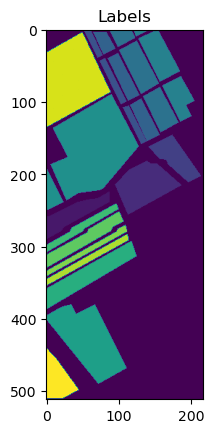

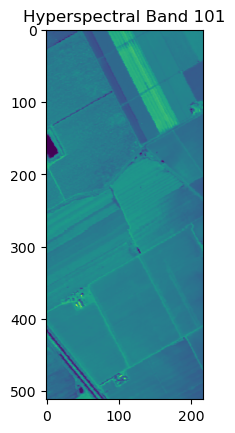

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Salinas_gt.mat'
data_files = 'Salinas_corrected.mat'
label_files = 'salinas_gt'
hypercube_files = 'salinas_corrected'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 54129
Extracted windows shape: (54129, 5, 5, 204)
Corresponding labels shape: (54129,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 20)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 2009 samples
Shuffled class indices for class '1'
Selected 20 training samples and 5 validation samples for class '1'

Class: 2: Found 3726 samples
Shuffled class indices for class '2'
Selected 20 training samples and 5 validation samples for class '2'

Class: 3: Found 1976 samples
Shuffled class indices for class '3'
Selected 20 training samples and 5 validation samples for class '3'

Class: 4: Found 1394 samples
Shuffled class indices for class '4'
Selected 20 training samples and 5 validation samples for class '4'

Class: 5: Found 2678 samples
Shuffled class indices for class '5'
Selected 20 training samples and 5 validation samples for class '5'

Class: 6: Found 3959 samples
Shuffled class indices for class '6'
Selected 20 training samples and 5 validation samples for class '6'

Class: 7: Found 3579 samples
Shuffled class indices fo


 -- Test set created with: 
	53729 samples
	shape (53729, 5, 5, 204) --




All datasets saved to the 'indices' folder.
(320, 5, 5, 204)
(80, 5, 5, 204)
(53729, 5, 5, 204)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 320
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (43303, 5, 5, 204)
Validation data shape: (10826, 5, 5, 204)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

204


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/677], Loss: 0.1552, PSNR: 7.1779


	 Training Batch [200/677], Loss: 0.0905, PSNR: 9.5996


	 Training Batch [400/677], Loss: 0.0453, PSNR: 12.6028


	 Training Batch [600/677], Loss: 0.0264, PSNR: 14.9719


Epoch [1/50] Training Loss: 0.0669, PSNR: 11.6074
	[Val]   Batch [1/170] Loss: 0.0215, PSNR: 15.7542
	[Val]   Batch [10/170] Loss: 0.0212, PSNR: 15.9168
	[Val]   Batch [20/170] Loss: 0.0213, PSNR: 15.8152
	[Val]   Batch [30/170] Loss: 0.0221, PSNR: 15.6091
	[Val]   Batch [40/170] Loss: 0.0222, PSNR: 15.6830


	[Val]   Batch [50/170] Loss: 0.0210, PSNR: 15.8883
	[Val]   Batch [60/170] Loss: 0.0219, PSNR: 15.7758
	[Val]   Batch [70/170] Loss: 0.0214, PSNR: 15.8663
	[Val]   Batch [80/170] Loss: 0.0218, PSNR: 15.6807


	[Val]   Batch [90/170] Loss: 0.0211, PSNR: 15.9204
	[Val]   Batch [100/170] Loss: 0.0212, PSNR: 15.8454
	[Val]   Batch [110/170] Loss: 0.0213, PSNR: 15.8219
	[Val]   Batch [120/170] Loss: 0.0201, PSNR: 14.1207
	[Val]   Batch [130/170] Loss: 0.0211, PSNR: 15.9290


	[Val]   Batch [140/170] Loss: 0.0208, PSNR: 15.9678
	[Val]   Batch [150/170] Loss: 0.0222, PSNR: 15.7239
	[Val]   Batch [160/170] Loss: 0.0218, PSNR: 15.7620
	[Val]   Batch [170/170] Loss: 0.0227, PSNR: 15.0380
Epoch [1/50] Validation Loss: 0.0215, PSNR: 15.7418

LOG: Epoch [2/50]
	 Training Batch [1/677], Loss: 0.0219, PSNR: 15.6875


	 Training Batch [200/677], Loss: 0.0154, PSNR: 17.1817


	 Training Batch [400/677], Loss: 0.0114, PSNR: 18.6175


	 Training Batch [600/677], Loss: 0.0095, PSNR: 19.3200


Epoch [2/50] Training Loss: 0.0132, PSNR: 18.0239
	[Val]   Batch [1/170] Loss: 0.0088, PSNR: 19.6478
	[Val]   Batch [10/170] Loss: 0.0083, PSNR: 19.9891
	[Val]   Batch [20/170] Loss: 0.0084, PSNR: 19.8577
	[Val]   Batch [30/170] Loss: 0.0091, PSNR: 19.4574
	[Val]   Batch [40/170] Loss: 0.0093, PSNR: 19.4403


	[Val]   Batch [50/170] Loss: 0.0081, PSNR: 20.0072
	[Val]   Batch [60/170] Loss: 0.0091, PSNR: 19.5985
	[Val]   Batch [70/170] Loss: 0.0089, PSNR: 19.7065
	[Val]   Batch [80/170] Loss: 0.0089, PSNR: 19.5570
	[Val]   Batch [90/170] Loss: 0.0085, PSNR: 19.8506


	[Val]   Batch [100/170] Loss: 0.0086, PSNR: 19.7756
	[Val]   Batch [110/170] Loss: 0.0085, PSNR: 19.8307
	[Val]   Batch [120/170] Loss: 0.0074, PSNR: 18.4670
	[Val]   Batch [130/170] Loss: 0.0085, PSNR: 19.8660
	[Val]   Batch [140/170] Loss: 0.0080, PSNR: 20.1352


	[Val]   Batch [150/170] Loss: 0.0093, PSNR: 19.4933
	[Val]   Batch [160/170] Loss: 0.0090, PSNR: 19.5922
	[Val]   Batch [170/170] Loss: 0.0093, PSNR: 18.8999
Epoch [2/50] Validation Loss: 0.0087, PSNR: 19.6925

LOG: Epoch [3/50]
	 Training Batch [1/677], Loss: 0.0092, PSNR: 19.5058


	 Training Batch [200/677], Loss: 0.0078, PSNR: 20.1859


	 Training Batch [400/677], Loss: 0.0074, PSNR: 20.4609


	 Training Batch [600/677], Loss: 0.0049, PSNR: 21.8249


Epoch [3/50] Training Loss: 0.0067, PSNR: 20.9113
	[Val]   Batch [1/170] Loss: 0.0050, PSNR: 22.0590
	[Val]   Batch [10/170] Loss: 0.0047, PSNR: 22.4209
	[Val]   Batch [20/170] Loss: 0.0048, PSNR: 22.2851
	[Val]   Batch [30/170] Loss: 0.0053, PSNR: 21.8417
	[Val]   Batch [40/170] Loss: 0.0054, PSNR: 21.8207


	[Val]   Batch [50/170] Loss: 0.0047, PSNR: 22.4194
	[Val]   Batch [60/170] Loss: 0.0052, PSNR: 21.9834
	[Val]   Batch [70/170] Loss: 0.0051, PSNR: 22.1154
	[Val]   Batch [80/170] Loss: 0.0051, PSNR: 21.9738
	[Val]   Batch [90/170] Loss: 0.0049, PSNR: 22.2478


	[Val]   Batch [100/170] Loss: 0.0050, PSNR: 22.1432
	[Val]   Batch [110/170] Loss: 0.0049, PSNR: 22.2360
	[Val]   Batch [120/170] Loss: 0.0042, PSNR: 20.9136
	[Val]   Batch [130/170] Loss: 0.0049, PSNR: 22.2488


	[Val]   Batch [140/170] Loss: 0.0045, PSNR: 22.6010
	[Val]   Batch [150/170] Loss: 0.0054, PSNR: 21.8705
	[Val]   Batch [160/170] Loss: 0.0052, PSNR: 21.9857
	[Val]   Batch [170/170] Loss: 0.0053, PSNR: 21.3563
Epoch [3/50] Validation Loss: 0.0050, PSNR: 22.1059

LOG: Epoch [4/50]
	 Training Batch [1/677], Loss: 0.0051, PSNR: 22.0803


	 Training Batch [200/677], Loss: 0.0040, PSNR: 23.0819


	 Training Batch [400/677], Loss: 0.0040, PSNR: 23.0944


	 Training Batch [600/677], Loss: 0.0031, PSNR: 24.2431


Epoch [4/50] Training Loss: 0.0038, PSNR: 23.3164
	[Val]   Batch [1/170] Loss: 0.0028, PSNR: 24.5604
	[Val]   Batch [10/170] Loss: 0.0027, PSNR: 24.8072
	[Val]   Batch [20/170] Loss: 0.0028, PSNR: 24.6820
	[Val]   Batch [30/170] Loss: 0.0030, PSNR: 24.2371
	[Val]   Batch [40/170] Loss: 0.0030, PSNR: 24.4149


	[Val]   Batch [50/170] Loss: 0.0027, PSNR: 24.7217
	[Val]   Batch [60/170] Loss: 0.0030, PSNR: 24.4489
	[Val]   Batch [70/170] Loss: 0.0028, PSNR: 24.6821
	[Val]   Batch [80/170] Loss: 0.0029, PSNR: 24.4843


	[Val]   Batch [90/170] Loss: 0.0028, PSNR: 24.6840
	[Val]   Batch [100/170] Loss: 0.0029, PSNR: 24.4373
	[Val]   Batch [110/170] Loss: 0.0028, PSNR: 24.7079
	[Val]   Batch [120/170] Loss: 0.0026, PSNR: 23.0221
	[Val]   Batch [130/170] Loss: 0.0029, PSNR: 24.5330


	[Val]   Batch [140/170] Loss: 0.0026, PSNR: 24.9821
	[Val]   Batch [150/170] Loss: 0.0030, PSNR: 24.3788
	[Val]   Batch [160/170] Loss: 0.0029, PSNR: 24.5042
	[Val]   Batch [170/170] Loss: 0.0030, PSNR: 23.8060
Epoch [4/50] Validation Loss: 0.0028, PSNR: 24.5287

LOG: Epoch [5/50]
	 Training Batch [1/677], Loss: 0.0037, PSNR: 23.5550


	 Training Batch [200/677], Loss: 0.0025, PSNR: 25.1905


	 Training Batch [400/677], Loss: 0.0025, PSNR: 25.2220


	 Training Batch [600/677], Loss: 0.0022, PSNR: 25.3101


Epoch [5/50] Training Loss: 0.0025, PSNR: 25.1862
	[Val]   Batch [1/170] Loss: 0.0019, PSNR: 26.3320
	[Val]   Batch [10/170] Loss: 0.0018, PSNR: 26.6076
	[Val]   Batch [20/170] Loss: 0.0018, PSNR: 26.4367
	[Val]   Batch [30/170] Loss: 0.0020, PSNR: 25.9459
	[Val]   Batch [40/170] Loss: 0.0019, PSNR: 26.2695
	[Val]   Batch [50/170] Loss: 0.0019, PSNR: 26.4174


	[Val]   Batch [60/170] Loss: 0.0020, PSNR: 26.2101
	[Val]   Batch [70/170] Loss: 0.0019, PSNR: 26.4826
	[Val]   Batch [80/170] Loss: 0.0019, PSNR: 26.2950
	[Val]   Batch [90/170] Loss: 0.0019, PSNR: 26.4331
	[Val]   Batch [100/170] Loss: 0.0020, PSNR: 26.0879


	[Val]   Batch [110/170] Loss: 0.0018, PSNR: 26.5985
	[Val]   Batch [120/170] Loss: 0.0018, PSNR: 24.6197
	[Val]   Batch [130/170] Loss: 0.0020, PSNR: 26.1622
	[Val]   Batch [140/170] Loss: 0.0017, PSNR: 26.7597
	[Val]   Batch [150/170] Loss: 0.0020, PSNR: 26.1698


	[Val]   Batch [160/170] Loss: 0.0019, PSNR: 26.2879
	[Val]   Batch [170/170] Loss: 0.0020, PSNR: 25.6243
Epoch [5/50] Validation Loss: 0.0019, PSNR: 26.2856

LOG: Epoch [6/50]
	 Training Batch [1/677], Loss: 0.0020, PSNR: 26.0741


	 Training Batch [200/677], Loss: 0.0019, PSNR: 26.4410


	 Training Batch [400/677], Loss: 0.0021, PSNR: 25.9940


	 Training Batch [600/677], Loss: 0.0016, PSNR: 27.1479


Epoch [6/50] Training Loss: 0.0018, PSNR: 26.4612
	[Val]   Batch [1/170] Loss: 0.0015, PSNR: 27.4512
	[Val]   Batch [10/170] Loss: 0.0014, PSNR: 27.6788
	[Val]   Batch [20/170] Loss: 0.0015, PSNR: 27.4911
	[Val]   Batch [30/170] Loss: 0.0016, PSNR: 26.9507
	[Val]   Batch [40/170] Loss: 0.0015, PSNR: 27.4366


	[Val]   Batch [50/170] Loss: 0.0015, PSNR: 27.4300
	[Val]   Batch [60/170] Loss: 0.0016, PSNR: 27.2679
	[Val]   Batch [70/170] Loss: 0.0014, PSNR: 27.6760
	[Val]   Batch [80/170] Loss: 0.0015, PSNR: 27.3707
	[Val]   Batch [90/170] Loss: 0.0014, PSNR: 27.5644


	[Val]   Batch [100/170] Loss: 0.0016, PSNR: 27.1198
	[Val]   Batch [110/170] Loss: 0.0014, PSNR: 27.7769
	[Val]   Batch [120/170] Loss: 0.0014, PSNR: 25.6442
	[Val]   Batch [130/170] Loss: 0.0016, PSNR: 27.1841


	[Val]   Batch [140/170] Loss: 0.0013, PSNR: 27.8589
	[Val]   Batch [150/170] Loss: 0.0016, PSNR: 27.2132
	[Val]   Batch [160/170] Loss: 0.0015, PSNR: 27.4060
	[Val]   Batch [170/170] Loss: 0.0016, PSNR: 26.6473
Epoch [6/50] Validation Loss: 0.0015, PSNR: 27.3539

LOG: Epoch [7/50]
	 Training Batch [1/677], Loss: 0.0016, PSNR: 27.1109


	 Training Batch [200/677], Loss: 0.0013, PSNR: 27.7917


	 Training Batch [400/677], Loss: 0.0015, PSNR: 27.3357


	 Training Batch [600/677], Loss: 0.0015, PSNR: 27.0149


Epoch [7/50] Training Loss: 0.0015, PSNR: 27.4423
	[Val]   Batch [1/170] Loss: 0.0011, PSNR: 28.4899
	[Val]   Batch [10/170] Loss: 0.0011, PSNR: 28.6994
	[Val]   Batch [20/170] Loss: 0.0012, PSNR: 28.4800
	[Val]   Batch [30/170] Loss: 0.0013, PSNR: 27.9163
	[Val]   Batch [40/170] Loss: 0.0012, PSNR: 28.5281


	[Val]   Batch [50/170] Loss: 0.0012, PSNR: 28.3855
	[Val]   Batch [60/170] Loss: 0.0012, PSNR: 28.2670
	[Val]   Batch [70/170] Loss: 0.0011, PSNR: 28.7563
	[Val]   Batch [80/170] Loss: 0.0012, PSNR: 28.3990
	[Val]   Batch [90/170] Loss: 0.0011, PSNR: 28.6037


	[Val]   Batch [100/170] Loss: 0.0013, PSNR: 28.0962
	[Val]   Batch [110/170] Loss: 0.0011, PSNR: 28.8785
	[Val]   Batch [120/170] Loss: 0.0011, PSNR: 26.5746
	[Val]   Batch [130/170] Loss: 0.0013, PSNR: 28.1533


	[Val]   Batch [140/170] Loss: 0.0011, PSNR: 28.8833
	[Val]   Batch [150/170] Loss: 0.0013, PSNR: 28.2098
	[Val]   Batch [160/170] Loss: 0.0012, PSNR: 28.4357
	[Val]   Batch [170/170] Loss: 0.0012, PSNR: 27.6722
Epoch [7/50] Validation Loss: 0.0012, PSNR: 28.3620

LOG: Epoch [8/50]
	 Training Batch [1/677], Loss: 0.0014, PSNR: 27.8243


	 Training Batch [200/677], Loss: 0.0013, PSNR: 28.1153


	 Training Batch [400/677], Loss: 0.0011, PSNR: 28.7092


	 Training Batch [600/677], Loss: 0.0010, PSNR: 29.0627


Epoch [8/50] Training Loss: 0.0012, PSNR: 28.2738
	[Val]   Batch [1/170] Loss: 0.0009, PSNR: 29.6137
	[Val]   Batch [10/170] Loss: 0.0009, PSNR: 29.8400
	[Val]   Batch [20/170] Loss: 0.0009, PSNR: 29.5993
	[Val]   Batch [30/170] Loss: 0.0010, PSNR: 28.9794
	[Val]   Batch [40/170] Loss: 0.0009, PSNR: 29.6984


	[Val]   Batch [50/170] Loss: 0.0009, PSNR: 29.3963
	[Val]   Batch [60/170] Loss: 0.0010, PSNR: 29.3652
	[Val]   Batch [70/170] Loss: 0.0008, PSNR: 29.9056
	[Val]   Batch [80/170] Loss: 0.0009, PSNR: 29.5722
	[Val]   Batch [90/170] Loss: 0.0009, PSNR: 29.7181


	[Val]   Batch [100/170] Loss: 0.0010, PSNR: 29.1222
	[Val]   Batch [110/170] Loss: 0.0008, PSNR: 30.0828
	[Val]   Batch [120/170] Loss: 0.0009, PSNR: 27.5098
	[Val]   Batch [130/170] Loss: 0.0010, PSNR: 29.2008
	[Val]   Batch [140/170] Loss: 0.0008, PSNR: 30.0037


	[Val]   Batch [150/170] Loss: 0.0010, PSNR: 29.3157
	[Val]   Batch [160/170] Loss: 0.0009, PSNR: 29.5377
	[Val]   Batch [170/170] Loss: 0.0009, PSNR: 28.8714
Epoch [8/50] Validation Loss: 0.0009, PSNR: 29.4694

LOG: Epoch [9/50]
	 Training Batch [1/677], Loss: 0.0010, PSNR: 28.9318


	 Training Batch [200/677], Loss: 0.0011, PSNR: 28.7761


	 Training Batch [400/677], Loss: 0.0010, PSNR: 28.7493


	 Training Batch [600/677], Loss: 0.0009, PSNR: 29.1225


Epoch [9/50] Training Loss: 0.0010, PSNR: 28.9554
	[Val]   Batch [1/170] Loss: 0.0008, PSNR: 30.2481
	[Val]   Batch [10/170] Loss: 0.0007, PSNR: 30.4595
	[Val]   Batch [20/170] Loss: 0.0008, PSNR: 30.2063
	[Val]   Batch [30/170] Loss: 0.0009, PSNR: 29.5929
	[Val]   Batch [40/170] Loss: 0.0008, PSNR: 30.3371


	[Val]   Batch [50/170] Loss: 0.0008, PSNR: 29.9999
	[Val]   Batch [60/170] Loss: 0.0008, PSNR: 29.9793
	[Val]   Batch [70/170] Loss: 0.0007, PSNR: 30.5456
	[Val]   Batch [80/170] Loss: 0.0008, PSNR: 30.1960


	[Val]   Batch [90/170] Loss: 0.0008, PSNR: 30.3976
	[Val]   Batch [100/170] Loss: 0.0009, PSNR: 29.7814
	[Val]   Batch [110/170] Loss: 0.0007, PSNR: 30.7326
	[Val]   Batch [120/170] Loss: 0.0008, PSNR: 28.1896
	[Val]   Batch [130/170] Loss: 0.0009, PSNR: 29.8496


	[Val]   Batch [140/170] Loss: 0.0007, PSNR: 30.6600
	[Val]   Batch [150/170] Loss: 0.0008, PSNR: 29.9091
	[Val]   Batch [160/170] Loss: 0.0008, PSNR: 30.1395
	[Val]   Batch [170/170] Loss: 0.0008, PSNR: 29.5190
Epoch [9/50] Validation Loss: 0.0008, PSNR: 30.0901

LOG: Epoch [10/50]
	 Training Batch [1/677], Loss: 0.0009, PSNR: 29.4345


	 Training Batch [200/677], Loss: 0.0008, PSNR: 29.9710


	 Training Batch [400/677], Loss: 0.0007, PSNR: 30.4632


	 Training Batch [600/677], Loss: 0.0008, PSNR: 30.0085


Epoch [10/50] Training Loss: 0.0009, PSNR: 29.6017
	[Val]   Batch [1/170] Loss: 0.0006, PSNR: 31.0244
	[Val]   Batch [10/170] Loss: 0.0006, PSNR: 31.2758
	[Val]   Batch [20/170] Loss: 0.0007, PSNR: 30.9757
	[Val]   Batch [30/170] Loss: 0.0007, PSNR: 30.3810
	[Val]   Batch [40/170] Loss: 0.0006, PSNR: 31.1329
	[Val]   Batch [50/170] Loss: 0.0007, PSNR: 30.7220


	[Val]   Batch [60/170] Loss: 0.0007, PSNR: 30.7757
	[Val]   Batch [70/170] Loss: 0.0006, PSNR: 31.3286
	[Val]   Batch [80/170] Loss: 0.0006, PSNR: 31.0111
	[Val]   Batch [90/170] Loss: 0.0006, PSNR: 31.2368


	[Val]   Batch [100/170] Loss: 0.0007, PSNR: 30.5949
	[Val]   Batch [110/170] Loss: 0.0006, PSNR: 31.5717
	[Val]   Batch [120/170] Loss: 0.0007, PSNR: 28.9398
	[Val]   Batch [130/170] Loss: 0.0007, PSNR: 30.6713
	[Val]   Batch [140/170] Loss: 0.0006, PSNR: 31.4763


	[Val]   Batch [150/170] Loss: 0.0007, PSNR: 30.7123
	[Val]   Batch [160/170] Loss: 0.0007, PSNR: 30.9039
	[Val]   Batch [170/170] Loss: 0.0007, PSNR: 30.3738
Epoch [10/50] Validation Loss: 0.0007, PSNR: 30.8799

LOG: Epoch [11/50]
	 Training Batch [1/677], Loss: 0.0007, PSNR: 30.3657


	 Training Batch [200/677], Loss: 0.0007, PSNR: 30.3579


	 Training Batch [400/677], Loss: 0.0007, PSNR: 30.4646


	 Training Batch [600/677], Loss: 0.0007, PSNR: 30.8682


Epoch [11/50] Training Loss: 0.0008, PSNR: 30.1459
	[Val]   Batch [1/170] Loss: 0.0005, PSNR: 31.9589
	[Val]   Batch [10/170] Loss: 0.0005, PSNR: 32.2340
	[Val]   Batch [20/170] Loss: 0.0005, PSNR: 31.8580
	[Val]   Batch [30/170] Loss: 0.0006, PSNR: 31.3226
	[Val]   Batch [40/170] Loss: 0.0005, PSNR: 32.0826
	[Val]   Batch [50/170] Loss: 0.0006, PSNR: 31.5690


	[Val]   Batch [60/170] Loss: 0.0006, PSNR: 31.7085
	[Val]   Batch [70/170] Loss: 0.0005, PSNR: 32.2353
	[Val]   Batch [80/170] Loss: 0.0005, PSNR: 32.0012
	[Val]   Batch [90/170] Loss: 0.0005, PSNR: 32.2043
	[Val]   Batch [100/170] Loss: 0.0006, PSNR: 31.5425


	[Val]   Batch [110/170] Loss: 0.0005, PSNR: 32.5267
	[Val]   Batch [120/170] Loss: 0.0005, PSNR: 29.7522
	[Val]   Batch [130/170] Loss: 0.0006, PSNR: 31.6258
	[Val]   Batch [140/170] Loss: 0.0005, PSNR: 32.4068
	[Val]   Batch [150/170] Loss: 0.0006, PSNR: 31.6688


	[Val]   Batch [160/170] Loss: 0.0005, PSNR: 31.7935
	[Val]   Batch [170/170] Loss: 0.0005, PSNR: 31.4893
Epoch [11/50] Validation Loss: 0.0005, PSNR: 31.8158

LOG: Epoch [12/50]
	 Training Batch [1/677], Loss: 0.0008, PSNR: 30.4152


	 Training Batch [200/677], Loss: 0.0009, PSNR: 28.1729


	 Training Batch [400/677], Loss: 0.0007, PSNR: 30.5308


	 Training Batch [600/677], Loss: 0.0006, PSNR: 31.1317


Epoch [12/50] Training Loss: 0.0007, PSNR: 30.7021
	[Val]   Batch [1/170] Loss: 0.0005, PSNR: 32.0715
	[Val]   Batch [10/170] Loss: 0.0005, PSNR: 32.3266
	[Val]   Batch [20/170] Loss: 0.0005, PSNR: 31.9566
	[Val]   Batch [30/170] Loss: 0.0006, PSNR: 31.4989
	[Val]   Batch [40/170] Loss: 0.0005, PSNR: 32.1738


	[Val]   Batch [50/170] Loss: 0.0005, PSNR: 31.7247
	[Val]   Batch [60/170] Loss: 0.0005, PSNR: 31.8716
	[Val]   Batch [70/170] Loss: 0.0005, PSNR: 32.3289
	[Val]   Batch [80/170] Loss: 0.0005, PSNR: 32.0861
	[Val]   Batch [90/170] Loss: 0.0005, PSNR: 32.4049


	[Val]   Batch [100/170] Loss: 0.0005, PSNR: 31.8013
	[Val]   Batch [110/170] Loss: 0.0004, PSNR: 32.6027
	[Val]   Batch [120/170] Loss: 0.0005, PSNR: 30.0078
	[Val]   Batch [130/170] Loss: 0.0005, PSNR: 31.8778
	[Val]   Batch [140/170] Loss: 0.0005, PSNR: 32.4892


	[Val]   Batch [150/170] Loss: 0.0005, PSNR: 31.8328
	[Val]   Batch [160/170] Loss: 0.0005, PSNR: 31.9050
	[Val]   Batch [170/170] Loss: 0.0005, PSNR: 31.5723
Epoch [12/50] Validation Loss: 0.0005, PSNR: 31.9396

LOG: Epoch [13/50]
	 Training Batch [1/677], Loss: 0.0006, PSNR: 31.3839


	 Training Batch [200/677], Loss: 0.0007, PSNR: 30.6954


	 Training Batch [400/677], Loss: 0.0006, PSNR: 31.3079


	 Training Batch [600/677], Loss: 0.0005, PSNR: 31.7947


Epoch [13/50] Training Loss: 0.0006, PSNR: 31.1146
	[Val]   Batch [1/170] Loss: 0.0004, PSNR: 32.7711
	[Val]   Batch [10/170] Loss: 0.0004, PSNR: 33.0426
	[Val]   Batch [20/170] Loss: 0.0004, PSNR: 32.6275
	[Val]   Batch [30/170] Loss: 0.0005, PSNR: 32.2173
	[Val]   Batch [40/170] Loss: 0.0004, PSNR: 32.8504


	[Val]   Batch [50/170] Loss: 0.0005, PSNR: 32.3702
	[Val]   Batch [60/170] Loss: 0.0005, PSNR: 32.5775
	[Val]   Batch [70/170] Loss: 0.0004, PSNR: 32.9613
	[Val]   Batch [80/170] Loss: 0.0004, PSNR: 32.8134
	[Val]   Batch [90/170] Loss: 0.0004, PSNR: 33.1432


	[Val]   Batch [100/170] Loss: 0.0005, PSNR: 32.5257
	[Val]   Batch [110/170] Loss: 0.0004, PSNR: 33.3134
	[Val]   Batch [120/170] Loss: 0.0004, PSNR: 30.6946
	[Val]   Batch [130/170] Loss: 0.0005, PSNR: 32.6130
	[Val]   Batch [140/170] Loss: 0.0004, PSNR: 33.2110


	[Val]   Batch [150/170] Loss: 0.0005, PSNR: 32.5473
	[Val]   Batch [160/170] Loss: 0.0005, PSNR: 32.5323
	[Val]   Batch [170/170] Loss: 0.0004, PSNR: 32.4083
Epoch [13/50] Validation Loss: 0.0004, PSNR: 32.6395

LOG: Epoch [14/50]
	 Training Batch [1/677], Loss: 0.0005, PSNR: 32.2062


	 Training Batch [200/677], Loss: 0.0005, PSNR: 31.9930


	 Training Batch [400/677], Loss: 0.0005, PSNR: 32.1614


	 Training Batch [600/677], Loss: 0.0005, PSNR: 32.4140


Epoch [14/50] Training Loss: 0.0006, PSNR: 31.5042
	[Val]   Batch [1/170] Loss: 0.0004, PSNR: 33.3690
	[Val]   Batch [10/170] Loss: 0.0004, PSNR: 33.7386
	[Val]   Batch [20/170] Loss: 0.0004, PSNR: 33.2614
	[Val]   Batch [30/170] Loss: 0.0004, PSNR: 32.9047
	[Val]   Batch [40/170] Loss: 0.0004, PSNR: 33.4654


	[Val]   Batch [50/170] Loss: 0.0004, PSNR: 32.8424
	[Val]   Batch [60/170] Loss: 0.0004, PSNR: 33.2649
	[Val]   Batch [70/170] Loss: 0.0004, PSNR: 33.5767
	[Val]   Batch [80/170] Loss: 0.0004, PSNR: 33.5862
	[Val]   Batch [90/170] Loss: 0.0003, PSNR: 33.7988


	[Val]   Batch [100/170] Loss: 0.0004, PSNR: 33.2772
	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 33.9920
	[Val]   Batch [120/170] Loss: 0.0004, PSNR: 31.1826
	[Val]   Batch [130/170] Loss: 0.0004, PSNR: 33.4032
	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 33.8068


	[Val]   Batch [150/170] Loss: 0.0004, PSNR: 33.3343
	[Val]   Batch [160/170] Loss: 0.0004, PSNR: 33.1487
	[Val]   Batch [170/170] Loss: 0.0003, PSNR: 33.3526
Epoch [14/50] Validation Loss: 0.0004, PSNR: 33.3189

LOG: Epoch [15/50]
	 Training Batch [1/677], Loss: 0.0005, PSNR: 32.0754


	 Training Batch [200/677], Loss: 0.0006, PSNR: 31.4131


	 Training Batch [400/677], Loss: 0.0006, PSNR: 31.6713


	 Training Batch [600/677], Loss: 0.0005, PSNR: 32.1642


Epoch [15/50] Training Loss: 0.0005, PSNR: 31.8599
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 33.8916
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 34.2816
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 33.7685
	[Val]   Batch [30/170] Loss: 0.0004, PSNR: 33.4550
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 34.0213


	[Val]   Batch [50/170] Loss: 0.0004, PSNR: 33.3305
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 33.8163
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 34.0388
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 34.1362
	[Val]   Batch [90/170] Loss: 0.0003, PSNR: 34.3670


	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 33.8396
	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 34.5374
	[Val]   Batch [120/170] Loss: 0.0004, PSNR: 31.6760
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 33.9662
	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 34.3565


	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 33.8896
	[Val]   Batch [160/170] Loss: 0.0004, PSNR: 33.6101
	[Val]   Batch [170/170] Loss: 0.0003, PSNR: 34.0272
Epoch [15/50] Validation Loss: 0.0003, PSNR: 33.8481

LOG: Epoch [16/50]
	 Training Batch [1/677], Loss: 0.0005, PSNR: 32.4950


	 Training Batch [200/677], Loss: 0.0005, PSNR: 32.3204


	 Training Batch [400/677], Loss: 0.0007, PSNR: 30.5631


	 Training Batch [600/677], Loss: 0.0005, PSNR: 32.3579


Epoch [16/50] Training Loss: 0.0005, PSNR: 32.1491
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 34.2335
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 34.6350
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 34.0909
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 33.8070
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 34.3160


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 33.6984
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 34.1626
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 34.3129
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 34.4726
	[Val]   Batch [90/170] Loss: 0.0003, PSNR: 34.7222


	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 34.1798
	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 34.8495
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 32.0689
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 34.2939
	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 34.7100


	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 34.2234
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 33.8974
	[Val]   Batch [170/170] Loss: 0.0003, PSNR: 34.4034
Epoch [16/50] Validation Loss: 0.0003, PSNR: 34.1681

LOG: Epoch [17/50]
	 Training Batch [1/677], Loss: 0.0005, PSNR: 32.1244


	 Training Batch [200/677], Loss: 0.0004, PSNR: 33.3691


	 Training Batch [400/677], Loss: 0.0006, PSNR: 31.3217


	 Training Batch [600/677], Loss: 0.0005, PSNR: 32.0739


Epoch [17/50] Training Loss: 0.0005, PSNR: 32.4811
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 34.7115
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 35.0667
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 34.4980
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 34.3036
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 34.7923
	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 34.1366


	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 34.6601
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 34.7456
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 34.9357
	[Val]   Batch [90/170] Loss: 0.0002, PSNR: 35.2652
	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 34.6664


	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 35.3358
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 32.4969
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 34.7840
	[Val]   Batch [140/170] Loss: 0.0002, PSNR: 35.1817
	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 34.6675


	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 34.3070
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 34.8053
Epoch [17/50] Validation Loss: 0.0003, PSNR: 34.6142
Early stopping triggered at epoch 17. No improvement for 3 epochs.


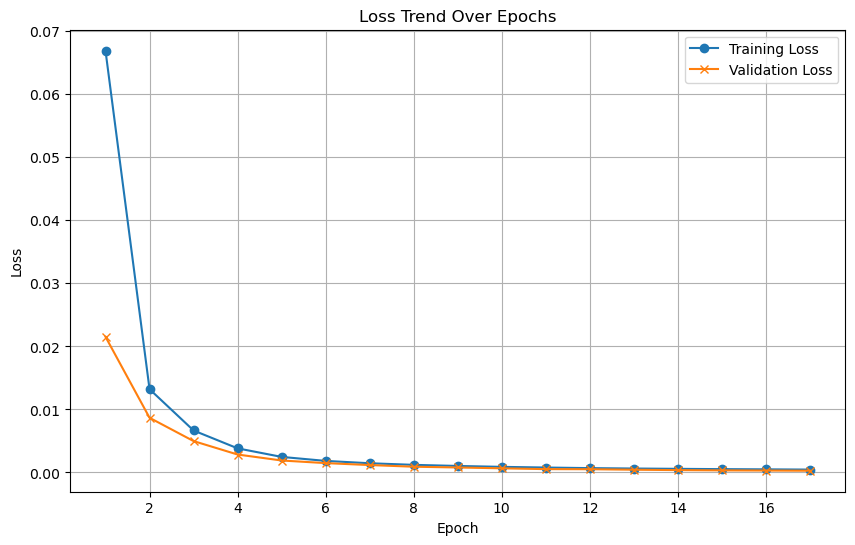

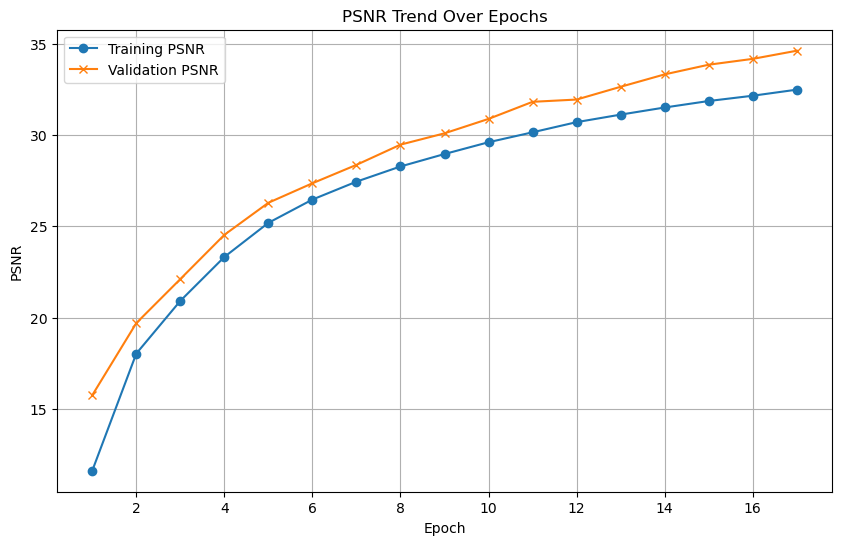

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/210 for test dataset.


    Processed batch 101/210 for test dataset.


    Processed batch 201/210 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.7879
    Validation Batch [1/1], Loss: 2.7785
Validation Loss: 2.7785, Validation Accuracy: 6.25%
Validation loss improved from inf to 2.7785. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.7433
    Validation Batch [1/1], Loss: 2.7784
Validation Loss: 2.7784, Validation Accuracy: 6.25%
Validation loss improved from 2.7785 to 2.7784. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.7166
    Validation Batch [1/1], Loss: 2.7784
Validation Loss: 2.7784, Validation Accuracy: 6.25%
Validation loss improved from 2.7784 to 2.7784. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.6988
    Validation Batch [1/1], Loss: 2.7784
Validation Loss: 2.7784, Validation Accuracy: 6.25%
Validation loss improved from 2.7784 to 2.7784. Saving model...

LOG: Epoch [5/1000] - 

Epoch [16/1000] completed, Average Training Loss: 2.5408
    Validation Batch [1/1], Loss: 2.7777
Validation Loss: 2.7777, Validation Accuracy: 6.25%
Validation loss improved from 2.7779 to 2.7777. Saving model...

LOG: Epoch [17/1000] - Training
Epoch [17/1000] completed, Average Training Loss: 2.5387
    Validation Batch [1/1], Loss: 2.7774
Validation Loss: 2.7774, Validation Accuracy: 6.25%
Validation loss improved from 2.7777 to 2.7774. Saving model...

LOG: Epoch [18/1000] - Training
Epoch [18/1000] completed, Average Training Loss: 2.5287
    Validation Batch [1/1], Loss: 2.7772
Validation Loss: 2.7772, Validation Accuracy: 6.25%
Validation loss improved from 2.7774 to 2.7772. Saving model...

LOG: Epoch [19/1000] - Training
Epoch [19/1000] completed, Average Training Loss: 2.5272
    Validation Batch [1/1], Loss: 2.7770
Validation Loss: 2.7770, Validation Accuracy: 6.25%
Validation loss improved from 2.7772 to 2.7770. Saving model...

LOG: Epoch [20/1000] - Training
Epoch [20/10

Epoch [38/1000] completed, Average Training Loss: 2.3532
    Validation Batch [1/1], Loss: 2.7306
Validation Loss: 2.7306, Validation Accuracy: 6.25%
Validation loss improved from 2.7374 to 2.7306. Saving model...

LOG: Epoch [39/1000] - Training
Epoch [39/1000] completed, Average Training Loss: 2.3295
    Validation Batch [1/1], Loss: 2.7225
Validation Loss: 2.7225, Validation Accuracy: 6.25%
Validation loss improved from 2.7306 to 2.7225. Saving model...

LOG: Epoch [40/1000] - Training
Epoch [40/1000] completed, Average Training Loss: 2.3354
    Validation Batch [1/1], Loss: 2.7129
Validation Loss: 2.7129, Validation Accuracy: 11.25%
Validation loss improved from 2.7225 to 2.7129. Saving model...

LOG: Epoch [41/1000] - Training
Epoch [41/1000] completed, Average Training Loss: 2.3173
    Validation Batch [1/1], Loss: 2.7024
Validation Loss: 2.7024, Validation Accuracy: 16.25%
Validation loss improved from 2.7129 to 2.7024. Saving model...

LOG: Epoch [42/1000] - Training
Epoch [42/

Epoch [61/1000] completed, Average Training Loss: 2.1643
    Validation Batch [1/1], Loss: 2.3561
Validation Loss: 2.3561, Validation Accuracy: 46.25%
Validation loss improved from 2.3756 to 2.3561. Saving model...

LOG: Epoch [62/1000] - Training
Epoch [62/1000] completed, Average Training Loss: 2.1487
    Validation Batch [1/1], Loss: 2.3356
Validation Loss: 2.3356, Validation Accuracy: 47.50%
Validation loss improved from 2.3561 to 2.3356. Saving model...

LOG: Epoch [63/1000] - Training
Epoch [63/1000] completed, Average Training Loss: 2.1362
    Validation Batch [1/1], Loss: 2.3134
Validation Loss: 2.3134, Validation Accuracy: 50.00%
Validation loss improved from 2.3356 to 2.3134. Saving model...

LOG: Epoch [64/1000] - Training
Epoch [64/1000] completed, Average Training Loss: 2.1370
    Validation Batch [1/1], Loss: 2.2903
Validation Loss: 2.2903, Validation Accuracy: 50.00%
Validation loss improved from 2.3134 to 2.2903. Saving model...

LOG: Epoch [65/1000] - Training
Epoch [6

Epoch [74/1000] completed, Average Training Loss: 2.0311
    Validation Batch [1/1], Loss: 2.1296
Validation Loss: 2.1296, Validation Accuracy: 53.75%
Validation loss improved from 2.1380 to 2.1296. Saving model...

LOG: Epoch [75/1000] - Training
Epoch [75/1000] completed, Average Training Loss: 2.0254
    Validation Batch [1/1], Loss: 2.1221
Validation Loss: 2.1221, Validation Accuracy: 60.00%
Validation loss improved from 2.1296 to 2.1221. Saving model...

LOG: Epoch [76/1000] - Training
Epoch [76/1000] completed, Average Training Loss: 2.0419
    Validation Batch [1/1], Loss: 2.0993
Validation Loss: 2.0993, Validation Accuracy: 57.50%
Validation loss improved from 2.1221 to 2.0993. Saving model...

LOG: Epoch [77/1000] - Training
Epoch [77/1000] completed, Average Training Loss: 1.9972
    Validation Batch [1/1], Loss: 2.0722
Validation Loss: 2.0722, Validation Accuracy: 55.00%
Validation loss improved from 2.0993 to 2.0722. Saving model...

LOG: Epoch [78/1000] - Training
Epoch [7

Epoch [97/1000] completed, Average Training Loss: 1.8321
    Validation Batch [1/1], Loss: 1.8447
Validation Loss: 1.8447, Validation Accuracy: 71.25%
Validation loss improved from 1.8508 to 1.8447. Saving model...

LOG: Epoch [98/1000] - Training
Epoch [98/1000] completed, Average Training Loss: 1.8396
    Validation Batch [1/1], Loss: 1.8307
Validation Loss: 1.8307, Validation Accuracy: 76.25%
Validation loss improved from 1.8447 to 1.8307. Saving model...

LOG: Epoch [99/1000] - Training
Epoch [99/1000] completed, Average Training Loss: 1.8157
    Validation Batch [1/1], Loss: 1.8123
Validation Loss: 1.8123, Validation Accuracy: 77.50%
Validation loss improved from 1.8307 to 1.8123. Saving model...

LOG: Epoch [100/1000] - Training
Epoch [100/1000] completed, Average Training Loss: 1.8466
    Validation Batch [1/1], Loss: 1.7875
Validation Loss: 1.7875, Validation Accuracy: 70.00%
Validation loss improved from 1.8123 to 1.7875. Saving model...

LOG: Epoch [101/1000] - Training
Epoch

    Validation Batch [1/1], Loss: 1.6457
Validation Loss: 1.6457, Validation Accuracy: 80.00%
Validation loss improved from 1.6602 to 1.6457. Saving model...

LOG: Epoch [120/1000] - Training
Epoch [120/1000] completed, Average Training Loss: 1.6518
    Validation Batch [1/1], Loss: 1.6258
Validation Loss: 1.6258, Validation Accuracy: 78.75%
Validation loss improved from 1.6457 to 1.6258. Saving model...

LOG: Epoch [121/1000] - Training
Epoch [121/1000] completed, Average Training Loss: 1.6295
    Validation Batch [1/1], Loss: 1.6334
Validation Loss: 1.6334, Validation Accuracy: 81.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [122/1000] - Training
Epoch [122/1000] completed, Average Training Loss: 1.6184
    Validation Batch [1/1], Loss: 1.6414
Validation Loss: 1.6414, Validation Accuracy: 81.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [123/1000] - Training
Epoch [123/1000] completed, Average Training Loss: 1.6176
    Validation Batch [1/1], Lo

    Validation Batch [1/1], Loss: 1.4284
Validation Loss: 1.4284, Validation Accuracy: 83.75%
Validation loss improved from 1.4413 to 1.4284. Saving model...

LOG: Epoch [143/1000] - Training
Epoch [143/1000] completed, Average Training Loss: 1.4716
    Validation Batch [1/1], Loss: 1.4251
Validation Loss: 1.4251, Validation Accuracy: 85.00%
Validation loss improved from 1.4284 to 1.4251. Saving model...

LOG: Epoch [144/1000] - Training
Epoch [144/1000] completed, Average Training Loss: 1.4451
    Validation Batch [1/1], Loss: 1.4293
Validation Loss: 1.4293, Validation Accuracy: 82.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [145/1000] - Training
Epoch [145/1000] completed, Average Training Loss: 1.4791
    Validation Batch [1/1], Loss: 1.4275
Validation Loss: 1.4275, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [146/1000] - Training
Epoch [146/1000] completed, Average Training Loss: 1.4153
    Validation Batch [1/1], Lo

    Validation Batch [1/1], Loss: 1.2595
Validation Loss: 1.2595, Validation Accuracy: 90.00%
Validation loss improved from 1.2701 to 1.2595. Saving model...

LOG: Epoch [166/1000] - Training
Epoch [166/1000] completed, Average Training Loss: 1.2628
    Validation Batch [1/1], Loss: 1.2531
Validation Loss: 1.2531, Validation Accuracy: 91.25%
Validation loss improved from 1.2595 to 1.2531. Saving model...

LOG: Epoch [167/1000] - Training
Epoch [167/1000] completed, Average Training Loss: 1.2641
    Validation Batch [1/1], Loss: 1.2348
Validation Loss: 1.2348, Validation Accuracy: 93.75%
Validation loss improved from 1.2531 to 1.2348. Saving model...

LOG: Epoch [168/1000] - Training
Epoch [168/1000] completed, Average Training Loss: 1.2458
    Validation Batch [1/1], Loss: 1.2214
Validation Loss: 1.2214, Validation Accuracy: 90.00%
Validation loss improved from 1.2348 to 1.2214. Saving model...

LOG: Epoch [169/1000] - Training
Epoch [169/1000] completed, Average Training Loss: 1.2607


Epoch [189/1000] completed, Average Training Loss: 1.0787
    Validation Batch [1/1], Loss: 1.0508
Validation Loss: 1.0508, Validation Accuracy: 93.75%
Validation loss improved from 1.0624 to 1.0508. Saving model...

LOG: Epoch [190/1000] - Training
Epoch [190/1000] completed, Average Training Loss: 1.0597
    Validation Batch [1/1], Loss: 1.0409
Validation Loss: 1.0409, Validation Accuracy: 92.50%
Validation loss improved from 1.0508 to 1.0409. Saving model...

LOG: Epoch [191/1000] - Training
Epoch [191/1000] completed, Average Training Loss: 1.0599
    Validation Batch [1/1], Loss: 1.0239
Validation Loss: 1.0239, Validation Accuracy: 92.50%
Validation loss improved from 1.0409 to 1.0239. Saving model...

LOG: Epoch [192/1000] - Training
Epoch [192/1000] completed, Average Training Loss: 1.0777
    Validation Batch [1/1], Loss: 1.0292
Validation Loss: 1.0292, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [193/1000] - Training
Epoch [193/1000

Epoch [212/1000] completed, Average Training Loss: 0.9227
    Validation Batch [1/1], Loss: 0.8894
Validation Loss: 0.8894, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [213/1000] - Training
Epoch [213/1000] completed, Average Training Loss: 0.8936
    Validation Batch [1/1], Loss: 0.8698
Validation Loss: 0.8698, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [214/1000] - Training
Epoch [214/1000] completed, Average Training Loss: 0.8831
    Validation Batch [1/1], Loss: 0.8652
Validation Loss: 0.8652, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [215/1000] - Training
Epoch [215/1000] completed, Average Training Loss: 0.8592
    Validation Batch [1/1], Loss: 0.8630
Validation Loss: 0.8630, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [216/1000] - Training
Epoch [216/1000] completed, Average Training Loss: 0.8750
  

Epoch [234/1000] completed, Average Training Loss: 0.7173
    Validation Batch [1/1], Loss: 0.7092
Validation Loss: 0.7092, Validation Accuracy: 95.00%
Validation loss improved from 0.7367 to 0.7092. Saving model...

LOG: Epoch [235/1000] - Training
Epoch [235/1000] completed, Average Training Loss: 0.7465
    Validation Batch [1/1], Loss: 0.7312
Validation Loss: 0.7312, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [236/1000] - Training
Epoch [236/1000] completed, Average Training Loss: 0.7567
    Validation Batch [1/1], Loss: 0.7296
Validation Loss: 0.7296, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [237/1000] - Training
Epoch [237/1000] completed, Average Training Loss: 0.7225
    Validation Batch [1/1], Loss: 0.6798
Validation Loss: 0.6798, Validation Accuracy: 95.00%
Validation loss improved from 0.7092 to 0.6798. Saving model...

LOG: Epoch [238/1000] - Training
Epoch [238/1000] completed, Av

Epoch [256/1000] completed, Average Training Loss: 0.5847
    Validation Batch [1/1], Loss: 0.6108
Validation Loss: 0.6108, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [257/1000] - Training
Epoch [257/1000] completed, Average Training Loss: 0.6216
    Validation Batch [1/1], Loss: 0.5713
Validation Loss: 0.5713, Validation Accuracy: 96.25%
Validation loss improved from 0.5793 to 0.5713. Saving model...

LOG: Epoch [258/1000] - Training
Epoch [258/1000] completed, Average Training Loss: 0.5819
    Validation Batch [1/1], Loss: 0.5810
Validation Loss: 0.5810, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [259/1000] - Training
Epoch [259/1000] completed, Average Training Loss: 0.5904
    Validation Batch [1/1], Loss: 0.5959
Validation Loss: 0.5959, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [260/1000] - Training
Epoch [260/1000] completed, Average Training 

Epoch [279/1000] completed, Average Training Loss: 0.4977
    Validation Batch [1/1], Loss: 0.4872
Validation Loss: 0.4872, Validation Accuracy: 95.00%
Validation loss improved from 0.4930 to 0.4872. Saving model...

LOG: Epoch [280/1000] - Training
Epoch [280/1000] completed, Average Training Loss: 0.5165
    Validation Batch [1/1], Loss: 0.4704
Validation Loss: 0.4704, Validation Accuracy: 95.00%
Validation loss improved from 0.4872 to 0.4704. Saving model...

LOG: Epoch [281/1000] - Training
Epoch [281/1000] completed, Average Training Loss: 0.5005
    Validation Batch [1/1], Loss: 0.4993
Validation Loss: 0.4993, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [282/1000] - Training
Epoch [282/1000] completed, Average Training Loss: 0.4975
    Validation Batch [1/1], Loss: 0.5165
Validation Loss: 0.5165, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [283/1000] - Training
Epoch [283/1000] completed, Av

Epoch [302/1000] completed, Average Training Loss: 0.4046
    Validation Batch [1/1], Loss: 0.4546
Validation Loss: 0.4546, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [303/1000] - Training
Epoch [303/1000] completed, Average Training Loss: 0.4096
    Validation Batch [1/1], Loss: 0.4357
Validation Loss: 0.4357, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [304/1000] - Training
Epoch [304/1000] completed, Average Training Loss: 0.4109
    Validation Batch [1/1], Loss: 0.4179
Validation Loss: 0.4179, Validation Accuracy: 95.00%
Validation loss improved from 0.4296 to 0.4179. Saving model...

LOG: Epoch [305/1000] - Training
Epoch [305/1000] completed, Average Training Loss: 0.3917
    Validation Batch [1/1], Loss: 0.4311
Validation Loss: 0.4311, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [306/1000] - Training
Epoch [306/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 0.3687
Validation Loss: 0.3687, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [325/1000] - Training
Epoch [325/1000] completed, Average Training Loss: 0.3409
    Validation Batch [1/1], Loss: 0.4105
Validation Loss: 0.4105, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [326/1000] - Training
Epoch [326/1000] completed, Average Training Loss: 0.3349
    Validation Batch [1/1], Loss: 0.3653
Validation Loss: 0.3653, Validation Accuracy: 95.00%
Validation loss improved from 0.3678 to 0.3653. Saving model...

LOG: Epoch [327/1000] - Training
Epoch [327/1000] completed, Average Training Loss: 0.3364
    Validation Batch [1/1], Loss: 0.3773
Validation Loss: 0.3773, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [328/1000] - Training
Epoch [328/1000] completed, Average Training Loss: 0.3397
    Validation Batch [1/1], Loss: 0.3848
Vali

Epoch [347/1000] completed, Average Training Loss: 0.2812
    Validation Batch [1/1], Loss: 0.3223
Validation Loss: 0.3223, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [348/1000] - Training
Epoch [348/1000] completed, Average Training Loss: 0.2753
    Validation Batch [1/1], Loss: 0.3293
Validation Loss: 0.3293, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [349/1000] - Training
Epoch [349/1000] completed, Average Training Loss: 0.2846
    Validation Batch [1/1], Loss: 0.3405
Validation Loss: 0.3405, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [350/1000] - Training
Epoch [350/1000] completed, Average Training Loss: 0.2642
    Validation Batch [1/1], Loss: 0.3156
Validation Loss: 0.3156, Validation Accuracy: 95.00%
Validation loss improved from 0.3179 to 0.3156. Saving model...

LOG: Epoch [351/1000] - Training
Epoch [351/1000] completed, Average Training 

Epoch [370/1000] completed, Average Training Loss: 0.2375
    Validation Batch [1/1], Loss: 0.3055
Validation Loss: 0.3055, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [371/1000] - Training
Epoch [371/1000] completed, Average Training Loss: 0.2299
    Validation Batch [1/1], Loss: 0.2865
Validation Loss: 0.2865, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [372/1000] - Training
Epoch [372/1000] completed, Average Training Loss: 0.2306
    Validation Batch [1/1], Loss: 0.2847
Validation Loss: 0.2847, Validation Accuracy: 96.25%
Validation loss improved from 0.2854 to 0.2847. Saving model...

LOG: Epoch [373/1000] - Training
Epoch [373/1000] completed, Average Training Loss: 0.2411
    Validation Batch [1/1], Loss: 0.2789
Validation Loss: 0.2789, Validation Accuracy: 96.25%
Validation loss improved from 0.2847 to 0.2789. Saving model...

LOG: Epoch [374/1000] - Training
Epoch [374/1000] completed, Av

    Validation Batch [1/1], Loss: 0.2742
Validation Loss: 0.2742, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [393/1000] - Training
Epoch [393/1000] completed, Average Training Loss: 0.2141
    Validation Batch [1/1], Loss: 0.2757
Validation Loss: 0.2757, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [394/1000] - Training
Epoch [394/1000] completed, Average Training Loss: 0.2092
    Validation Batch [1/1], Loss: 0.3265
Validation Loss: 0.3265, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [395/1000] - Training
Epoch [395/1000] completed, Average Training Loss: 0.2000
    Validation Batch [1/1], Loss: 0.2865
Validation Loss: 0.2865, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [396/1000] - Training
Epoch [396/1000] completed, Average Training Loss: 0.2150
    Validation Batch [1/1], Loss: 0.2715
Validation Loss: 

Epoch [416/1000] completed, Average Training Loss: 0.1599
    Validation Batch [1/1], Loss: 0.2487
Validation Loss: 0.2487, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [417/1000] - Training
Epoch [417/1000] completed, Average Training Loss: 0.1930
    Validation Batch [1/1], Loss: 0.2412
Validation Loss: 0.2412, Validation Accuracy: 96.25%
Validation loss improved from 0.2487 to 0.2412. Saving model...

LOG: Epoch [418/1000] - Training
Epoch [418/1000] completed, Average Training Loss: 0.1773
    Validation Batch [1/1], Loss: 0.2546
Validation Loss: 0.2546, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [419/1000] - Training
Epoch [419/1000] completed, Average Training Loss: 0.1692
    Validation Batch [1/1], Loss: 0.2627
Validation Loss: 0.2627, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [420/1000] - Training
Epoch [420/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 0.2609
Validation Loss: 0.2609, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [439/1000] - Training
Epoch [439/1000] completed, Average Training Loss: 0.1533
    Validation Batch [1/1], Loss: 0.2319
Validation Loss: 0.2319, Validation Accuracy: 96.25%
Validation loss improved from 0.2336 to 0.2319. Saving model...

LOG: Epoch [440/1000] - Training
Epoch [440/1000] completed, Average Training Loss: 0.1486
    Validation Batch [1/1], Loss: 0.2308
Validation Loss: 0.2308, Validation Accuracy: 96.25%
Validation loss improved from 0.2319 to 0.2308. Saving model...

LOG: Epoch [441/1000] - Training
Epoch [441/1000] completed, Average Training Loss: 0.1716
    Validation Batch [1/1], Loss: 0.2431
Validation Loss: 0.2431, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [442/1000] - Training
Epoch [442/1000] completed, Average Training Loss: 0.1695
    Validation Batch [1/1], Lo

Epoch [460/1000] completed, Average Training Loss: 0.1471
    Validation Batch [1/1], Loss: 0.2304
Validation Loss: 0.2304, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [461/1000] - Training
Epoch [461/1000] completed, Average Training Loss: 0.1369
    Validation Batch [1/1], Loss: 0.2220
Validation Loss: 0.2220, Validation Accuracy: 96.25%
Validation loss improved from 0.2290 to 0.2220. Saving model...

LOG: Epoch [462/1000] - Training
Epoch [462/1000] completed, Average Training Loss: 0.1370
    Validation Batch [1/1], Loss: 0.2229
Validation Loss: 0.2229, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [463/1000] - Training
Epoch [463/1000] completed, Average Training Loss: 0.1417
    Validation Batch [1/1], Loss: 0.2426
Validation Loss: 0.2426, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [464/1000] - Training
Epoch [464/1000] completed, Average Training

Epoch [483/1000] completed, Average Training Loss: 0.1209
    Validation Batch [1/1], Loss: 0.2097
Validation Loss: 0.2097, Validation Accuracy: 96.25%
Validation loss improved from 0.2106 to 0.2097. Saving model...

LOG: Epoch [484/1000] - Training
Epoch [484/1000] completed, Average Training Loss: 0.1234
    Validation Batch [1/1], Loss: 0.2125
Validation Loss: 0.2125, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [485/1000] - Training
Epoch [485/1000] completed, Average Training Loss: 0.1056
    Validation Batch [1/1], Loss: 0.2354
Validation Loss: 0.2354, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [486/1000] - Training
Epoch [486/1000] completed, Average Training Loss: 0.1209
    Validation Batch [1/1], Loss: 0.2374
Validation Loss: 0.2374, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [487/1000] - Training
Epoch [487/1000] completed, Average Training 

Epoch [507/1000] completed, Average Training Loss: 0.1108
    Validation Batch [1/1], Loss: 0.2436
Validation Loss: 0.2436, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [508/1000] - Training
Epoch [508/1000] completed, Average Training Loss: 0.1173
    Validation Batch [1/1], Loss: 0.3065
Validation Loss: 0.3065, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [509/1000] - Training
Epoch [509/1000] completed, Average Training Loss: 0.1010
    Validation Batch [1/1], Loss: 0.3618
Validation Loss: 0.3618, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [510/1000] - Training
Epoch [510/1000] completed, Average Training Loss: 0.1417
    Validation Batch [1/1], Loss: 0.2715
Validation Loss: 0.2715, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [511/1000] - Training
Epoch [511/1000] completed, Average Training Loss: 0.117

Epoch [531/1000] completed, Average Training Loss: 0.1125
    Validation Batch [1/1], Loss: 0.2611
Validation Loss: 0.2611, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [532/1000] - Training
Epoch [532/1000] completed, Average Training Loss: 0.0920
    Validation Batch [1/1], Loss: 0.2753
Validation Loss: 0.2753, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 40/100

LOG: Epoch [533/1000] - Training
Epoch [533/1000] completed, Average Training Loss: 0.1067
    Validation Batch [1/1], Loss: 0.2619
Validation Loss: 0.2619, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 41/100

LOG: Epoch [534/1000] - Training
Epoch [534/1000] completed, Average Training Loss: 0.0997
    Validation Batch [1/1], Loss: 0.2571
Validation Loss: 0.2571, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 42/100

LOG: Epoch [535/1000] - Training
Epoch [535/1000] completed, Average Training Loss: 0.120

    Validation Batch [1/1], Loss: 0.2270
Validation Loss: 0.2270, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 62/100

LOG: Epoch [555/1000] - Training
Epoch [555/1000] completed, Average Training Loss: 0.0920
    Validation Batch [1/1], Loss: 0.2233
Validation Loss: 0.2233, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 63/100

LOG: Epoch [556/1000] - Training
Epoch [556/1000] completed, Average Training Loss: 0.0791
    Validation Batch [1/1], Loss: 0.2242
Validation Loss: 0.2242, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 64/100

LOG: Epoch [557/1000] - Training
Epoch [557/1000] completed, Average Training Loss: 0.0798
    Validation Batch [1/1], Loss: 0.2257
Validation Loss: 0.2257, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 65/100

LOG: Epoch [558/1000] - Training
Epoch [558/1000] completed, Average Training Loss: 0.0818
    Validation Batch [1/1], Loss: 0.2343
Validation Loss

Epoch [577/1000] completed, Average Training Loss: 0.0723
    Validation Batch [1/1], Loss: 0.2110
Validation Loss: 0.2110, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 85/100

LOG: Epoch [578/1000] - Training
Epoch [578/1000] completed, Average Training Loss: 0.0679
    Validation Batch [1/1], Loss: 0.2119
Validation Loss: 0.2119, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 86/100

LOG: Epoch [579/1000] - Training
Epoch [579/1000] completed, Average Training Loss: 0.0662
    Validation Batch [1/1], Loss: 0.2161
Validation Loss: 0.2161, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 87/100

LOG: Epoch [580/1000] - Training
Epoch [580/1000] completed, Average Training Loss: 0.0689
    Validation Batch [1/1], Loss: 0.2252
Validation Loss: 0.2252, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 88/100

LOG: Epoch [581/1000] - Training
Epoch [581/1000] completed, Average Training Loss: 0.084

Epoch [598/1000] completed, Average Training Loss: 0.0753
    Validation Batch [1/1], Loss: 0.2006
Validation Loss: 0.2006, Validation Accuracy: 96.25%
Validation loss improved from 0.2029 to 0.2006. Saving model...

LOG: Epoch [599/1000] - Training
Epoch [599/1000] completed, Average Training Loss: 0.0618
    Validation Batch [1/1], Loss: 0.2002
Validation Loss: 0.2002, Validation Accuracy: 96.25%
Validation loss improved from 0.2006 to 0.2002. Saving model...

LOG: Epoch [600/1000] - Training
Epoch [600/1000] completed, Average Training Loss: 0.0674
    Validation Batch [1/1], Loss: 0.2011
Validation Loss: 0.2011, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [601/1000] - Training
Epoch [601/1000] completed, Average Training Loss: 0.0619
    Validation Batch [1/1], Loss: 0.2058
Validation Loss: 0.2058, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [602/1000] - Training
Epoch [602/1000] completed, Av

Epoch [622/1000] completed, Average Training Loss: 0.0719
    Validation Batch [1/1], Loss: 0.2175
Validation Loss: 0.2175, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [623/1000] - Training
Epoch [623/1000] completed, Average Training Loss: 0.0736
    Validation Batch [1/1], Loss: 0.2210
Validation Loss: 0.2210, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [624/1000] - Training
Epoch [624/1000] completed, Average Training Loss: 0.0626
    Validation Batch [1/1], Loss: 0.2165
Validation Loss: 0.2165, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [625/1000] - Training
Epoch [625/1000] completed, Average Training Loss: 0.0723
    Validation Batch [1/1], Loss: 0.2083
Validation Loss: 0.2083, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [626/1000] - Training
Epoch [626/1000] completed, Average Training Loss: 0.066

Epoch [645/1000] completed, Average Training Loss: 0.0592
    Validation Batch [1/1], Loss: 0.2039
Validation Loss: 0.2039, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [646/1000] - Training
Epoch [646/1000] completed, Average Training Loss: 0.0572
    Validation Batch [1/1], Loss: 0.2078
Validation Loss: 0.2078, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [647/1000] - Training
Epoch [647/1000] completed, Average Training Loss: 0.0583
    Validation Batch [1/1], Loss: 0.2142
Validation Loss: 0.2142, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [648/1000] - Training
Epoch [648/1000] completed, Average Training Loss: 0.0531
    Validation Batch [1/1], Loss: 0.2188
Validation Loss: 0.2188, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [649/1000] - Training
Epoch [649/1000] completed, Average Training Loss: 0.053

Epoch [669/1000] completed, Average Training Loss: 0.0606
    Validation Batch [1/1], Loss: 0.2137
Validation Loss: 0.2137, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 41/100

LOG: Epoch [670/1000] - Training
Epoch [670/1000] completed, Average Training Loss: 0.0600
    Validation Batch [1/1], Loss: 0.2150
Validation Loss: 0.2150, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 42/100

LOG: Epoch [671/1000] - Training
Epoch [671/1000] completed, Average Training Loss: 0.0533
    Validation Batch [1/1], Loss: 0.2123
Validation Loss: 0.2123, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 43/100

LOG: Epoch [672/1000] - Training
Epoch [672/1000] completed, Average Training Loss: 0.0534
    Validation Batch [1/1], Loss: 0.2097
Validation Loss: 0.2097, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [673/1000] - Training
Epoch [673/1000] completed, Average Training Loss: 0.058

Epoch [692/1000] completed, Average Training Loss: 0.0621
    Validation Batch [1/1], Loss: 0.2455
Validation Loss: 0.2455, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [693/1000] - Training
Epoch [693/1000] completed, Average Training Loss: 0.0510
    Validation Batch [1/1], Loss: 0.2412
Validation Loss: 0.2412, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [694/1000] - Training
Epoch [694/1000] completed, Average Training Loss: 0.0519
    Validation Batch [1/1], Loss: 0.2303
Validation Loss: 0.2303, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [695/1000] - Training
Epoch [695/1000] completed, Average Training Loss: 0.0425
    Validation Batch [1/1], Loss: 0.2195
Validation Loss: 0.2195, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [696/1000] - Training
Epoch [696/1000] completed, Average Training Loss: 0.0486
  

Epoch [715/1000] completed, Average Training Loss: 0.0495
    Validation Batch [1/1], Loss: 0.2357
Validation Loss: 0.2357, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [716/1000] - Training
Epoch [716/1000] completed, Average Training Loss: 0.0479
    Validation Batch [1/1], Loss: 0.2108
Validation Loss: 0.2108, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [717/1000] - Training
Epoch [717/1000] completed, Average Training Loss: 0.0484
    Validation Batch [1/1], Loss: 0.2154
Validation Loss: 0.2154, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [718/1000] - Training
Epoch [718/1000] completed, Average Training Loss: 0.0468
    Validation Batch [1/1], Loss: 0.2349
Validation Loss: 0.2349, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [719/1000] - Training
Epoch [719/1000] completed, Average Training Loss: 0.046

Epoch [737/1000] completed, Average Training Loss: 0.0396
    Validation Batch [1/1], Loss: 0.2060
Validation Loss: 0.2060, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 50/100

LOG: Epoch [738/1000] - Training
Epoch [738/1000] completed, Average Training Loss: 0.0429
    Validation Batch [1/1], Loss: 0.2059
Validation Loss: 0.2059, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 51/100

LOG: Epoch [739/1000] - Training
Epoch [739/1000] completed, Average Training Loss: 0.0389
    Validation Batch [1/1], Loss: 0.2014
Validation Loss: 0.2014, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 52/100

LOG: Epoch [740/1000] - Training
Epoch [740/1000] completed, Average Training Loss: 0.0435
    Validation Batch [1/1], Loss: 0.2004
Validation Loss: 0.2004, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 53/100

LOG: Epoch [741/1000] - Training
Epoch [741/1000] completed, Average Training Loss: 0.040

Epoch [761/1000] completed, Average Training Loss: 0.0445
    Validation Batch [1/1], Loss: 0.2199
Validation Loss: 0.2199, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 74/100

LOG: Epoch [762/1000] - Training
Epoch [762/1000] completed, Average Training Loss: 0.0367
    Validation Batch [1/1], Loss: 0.2072
Validation Loss: 0.2072, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 75/100

LOG: Epoch [763/1000] - Training
Epoch [763/1000] completed, Average Training Loss: 0.0366
    Validation Batch [1/1], Loss: 0.2100
Validation Loss: 0.2100, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 76/100

LOG: Epoch [764/1000] - Training
Epoch [764/1000] completed, Average Training Loss: 0.0430
    Validation Batch [1/1], Loss: 0.2214
Validation Loss: 0.2214, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 77/100

LOG: Epoch [765/1000] - Training
Epoch [765/1000] completed, Average Training Loss: 0.047

Epoch [784/1000] completed, Average Training Loss: 0.0341
    Validation Batch [1/1], Loss: 0.2067
Validation Loss: 0.2067, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 97/100

LOG: Epoch [785/1000] - Training
Epoch [785/1000] completed, Average Training Loss: 0.0396
    Validation Batch [1/1], Loss: 0.2137
Validation Loss: 0.2137, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 98/100

LOG: Epoch [786/1000] - Training
Epoch [786/1000] completed, Average Training Loss: 0.0464
    Validation Batch [1/1], Loss: 0.2072
Validation Loss: 0.2072, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 99/100

LOG: Epoch [787/1000] - Training
Epoch [787/1000] completed, Average Training Loss: 0.0346
    Validation Batch [1/1], Loss: 0.2042
Validation Loss: 0.2042, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 100/100
Early stopping triggered at epoch 787. No improvement for 100 epochs.
Loading the best mo

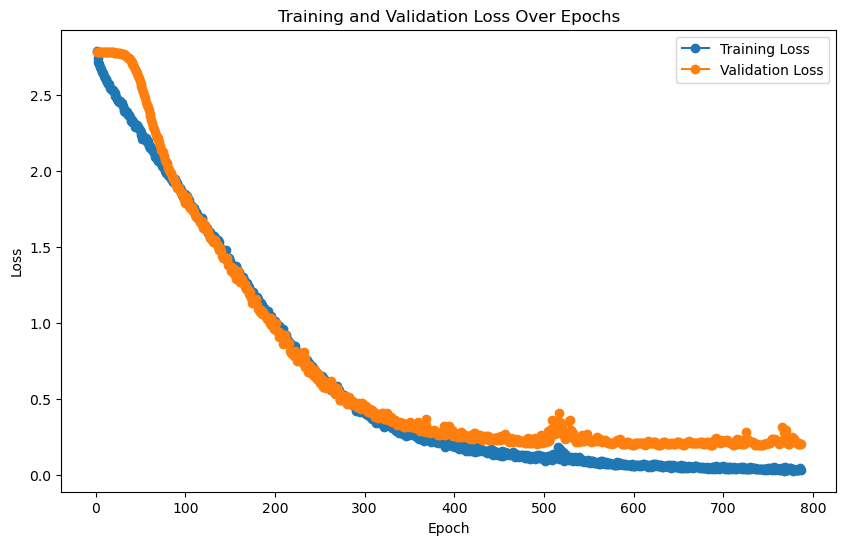

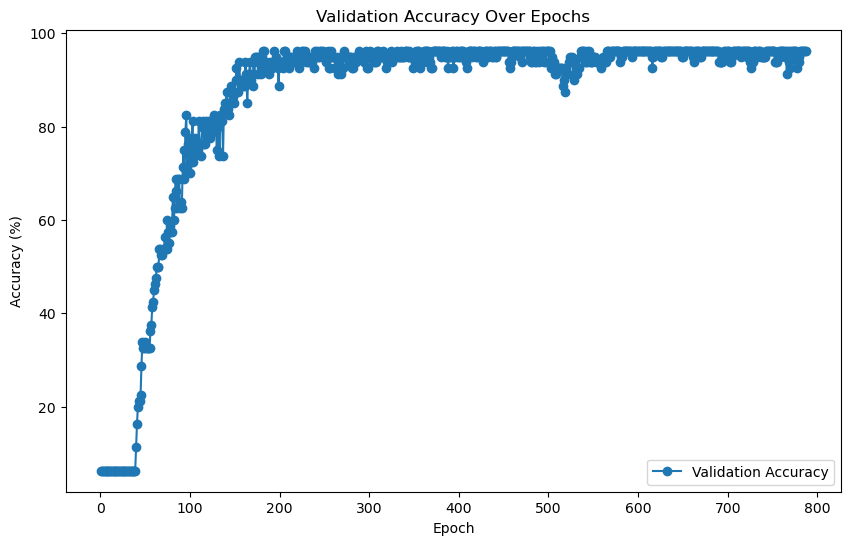


Evaluating on the test set...
    Test Batch [1/210], Loss: 0.0553



Final Test Loss: 0.3016, Test Accuracy: 90.72%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/210 for test dataset.


  Processed batch 20/210 for test dataset.
  Processed batch 30/210 for test dataset.
  Processed batch 40/210 for test dataset.
  Processed batch 50/210 for test dataset.


  Processed batch 60/210 for test dataset.
  Processed batch 70/210 for test dataset.
  Processed batch 80/210 for test dataset.
  Processed batch 90/210 for test dataset.
  Processed batch 100/210 for test dataset.


  Processed batch 110/210 for test dataset.
  Processed batch 120/210 for test dataset.
  Processed batch 130/210 for test dataset.
  Processed batch 140/210 for test dataset.


  Processed batch 150/210 for test dataset.
  Processed batch 160/210 for test dataset.
  Processed batch 170/210 for test dataset.
  Processed batch 180/210 for test dataset.


  Processed batch 190/210 for test dataset.
  Processed batch 200/210 for test dataset.
  Processed batch 210/210 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 53729 samples with 64 features each
LOG: Labels shape: (53729,)

LOG: Training features shape: (320, 64), Training labels shape: (320,)
LOG: Validation features shape: (80, 64), Validation labels shape: (80,)
LOG: Test features shape: (53729, 64), Test labels shape: (53729,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 85.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      0.40      0.57         5
           3       1.00      1.00      1.00         5
           4       0.62      1.00      0.77         5
           5       1.00      1.00      1.00         5
           6       0.83      1.00      0.91         5
           7       0.50      1.00      0.67         5
           8       1.00      1.

Saved CAE+LRM predictions and true labels to model_predictions


### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53729 samples with 64 features each
LOG: Labels shape: (53729,)
Train reps shape: (320, 64)
Train labels shape: (320,)
Val reps shape: (80, 64)
Val labels shape: (80,)
Test reps shape: (53729, 64)
Test labels shape: (53729,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.9903  |  Val Loss: 2.7491
Validation loss improved from inf to 2.7491.
[Epoch 2/1000] Train Loss: 2.6472  |  Val Loss: 2.5406
Validation loss improved from 2.7491 to 2.5406.
[Epoch 3/1000] Train Loss: 2.4611  |  Val Loss: 2.3719
Validation loss improved from 2.5406 to 2.3719.
[Epoch 4/1000] Train Loss: 2.2913  |  Val Loss: 2.1918
Validation loss improved from 2.3719 to 2.1918.
[Epoch 5/1000] Train Loss: 2.1178  |  Val Loss: 2.0269
Validation loss improved from 2.1918 to 2.0269.
[Epoch 6/1000] Train Loss: 1.9512  |  Val Loss: 1.8653
Validation loss improved from 2.0269 to 1.8653.
[Epoch 7/1000] Train Loss: 1.7911  |  Val Loss: 1.7160
Validation loss improved from 1.8653 to 1.7160.
[Epoch 8/1000] Train Loss: 1.6429  |  Val Loss: 1.5819
Validation loss improved from 1.7160 to 1.5819.
[Epoch 9/1000] Train Loss: 1.5182  |  Val Loss: 1.4629
Validation loss improved from 1.5819 to 1.4629.


[Epoch 10/1000] Train Loss: 1.3955  |  Val Loss: 1.3509
Validation loss improved from 1.4629 to 1.3509.
[Epoch 11/1000] Train Loss: 1.2913  |  Val Loss: 1.2445
Validation loss improved from 1.3509 to 1.2445.
[Epoch 12/1000] Train Loss: 1.1881  |  Val Loss: 1.1573
Validation loss improved from 1.2445 to 1.1573.
[Epoch 13/1000] Train Loss: 1.1068  |  Val Loss: 1.0751
Validation loss improved from 1.1573 to 1.0751.
[Epoch 14/1000] Train Loss: 1.0309  |  Val Loss: 1.0061
Validation loss improved from 1.0751 to 1.0061.
[Epoch 15/1000] Train Loss: 0.9740  |  Val Loss: 0.9571
Validation loss improved from 1.0061 to 0.9571.
[Epoch 16/1000] Train Loss: 0.9224  |  Val Loss: 0.9040
Validation loss improved from 0.9571 to 0.9040.
[Epoch 17/1000] Train Loss: 0.8724  |  Val Loss: 0.8700
Validation loss improved from 0.9040 to 0.8700.
[Epoch 18/1000] Train Loss: 0.8302  |  Val Loss: 0.8330
Validation loss improved from 0.8700 to 0.8330.
[Epoch 19/1000] Train Loss: 0.7920  |  Val Loss: 0.8008
Validati

[Epoch 21/1000] Train Loss: 0.7177  |  Val Loss: 0.7557
Validation loss improved from 0.7813 to 0.7557.
[Epoch 22/1000] Train Loss: 0.6999  |  Val Loss: 0.7200
Validation loss improved from 0.7557 to 0.7200.
[Epoch 23/1000] Train Loss: 0.6669  |  Val Loss: 0.7108
Validation loss improved from 0.7200 to 0.7108.
[Epoch 24/1000] Train Loss: 0.6463  |  Val Loss: 0.6917
Validation loss improved from 0.7108 to 0.6917.
[Epoch 25/1000] Train Loss: 0.6311  |  Val Loss: 0.6640
Validation loss improved from 0.6917 to 0.6640.
[Epoch 26/1000] Train Loss: 0.6025  |  Val Loss: 0.6686
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 27/1000] Train Loss: 0.5899  |  Val Loss: 0.6337
Validation loss improved from 0.6640 to 0.6337.
[Epoch 28/1000] Train Loss: 0.5697  |  Val Loss: 0.6282
Validation loss improved from 0.6337 to 0.6282.
[Epoch 29/1000] Train Loss: 0.5524  |  Val Loss: 0.6132
Validation loss improved from 0.6282 to 0.6132.


[Epoch 30/1000] Train Loss: 0.5394  |  Val Loss: 0.6031
Validation loss improved from 0.6132 to 0.6031.
[Epoch 31/1000] Train Loss: 0.5271  |  Val Loss: 0.5782
Validation loss improved from 0.6031 to 0.5782.
[Epoch 32/1000] Train Loss: 0.5150  |  Val Loss: 0.5872
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 33/1000] Train Loss: 0.4992  |  Val Loss: 0.5727
Validation loss improved from 0.5782 to 0.5727.
[Epoch 34/1000] Train Loss: 0.4999  |  Val Loss: 0.5511
Validation loss improved from 0.5727 to 0.5511.
[Epoch 35/1000] Train Loss: 0.4743  |  Val Loss: 0.5671
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 36/1000] Train Loss: 0.4732  |  Val Loss: 0.5394
Validation loss improved from 0.5511 to 0.5394.
[Epoch 37/1000] Train Loss: 0.4581  |  Val Loss: 0.5255
Validation loss improved from 0.5394 to 0.5255.
[Epoch 38/1000] Train Loss: 0.4404  |  Val Loss: 0.5449
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 39/1000] Train Loss: 0.4405  |  Val Los

[Epoch 41/1000] Train Loss: 0.4127  |  Val Loss: 0.5030
Validation loss improved from 0.5168 to 0.5030.
[Epoch 42/1000] Train Loss: 0.4142  |  Val Loss: 0.5001
Validation loss improved from 0.5030 to 0.5001.
[Epoch 43/1000] Train Loss: 0.4108  |  Val Loss: 0.4894
Validation loss improved from 0.5001 to 0.4894.
[Epoch 44/1000] Train Loss: 0.3953  |  Val Loss: 0.5058
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 45/1000] Train Loss: 0.3848  |  Val Loss: 0.5078
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 46/1000] Train Loss: 0.3781  |  Val Loss: 0.4496
Validation loss improved from 0.4894 to 0.4496.
[Epoch 47/1000] Train Loss: 0.3725  |  Val Loss: 0.4763
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 48/1000] Train Loss: 0.3643  |  Val Loss: 0.4929
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 49/1000] Train Loss: 0.3560  |  Val Loss: 0.4423
Validation loss improved from 0.4496 to 0.4423.
[Epoch 50/1000] Train Loss: 0.3491  |  Val Loss: 0.4524
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 51/1000] Train Loss: 0.3528  |  Val Loss: 0.4529
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 52/1000] Train Loss: 0.3412  |  Val Loss: 0.4701
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 53/1000] Train Loss: 0.3425  |  Val Loss: 0.4491
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 54/1000] Train Loss: 0.3276  |  Val Loss: 0.4294
Validation loss improved from 0.4423 to 0.4294.
[Epoch 55/1000] Train Loss: 

[Epoch 61/1000] Train Loss: 0.2974  |  Val Loss: 0.4264
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 62/1000] Train Loss: 0.2934  |  Val Loss: 0.4113
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 63/1000] Train Loss: 0.2922  |  Val Loss: 0.3974
Validation loss improved from 0.4050 to 0.3974.
[Epoch 64/1000] Train Loss: 0.2863  |  Val Loss: 0.4313
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 65/1000] Train Loss: 0.2766  |  Val Loss: 0.4126
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 66/1000] Train Loss: 0.2879  |  Val Loss: 0.3971
Validation loss improved from 0.3974 to 0.3971.


[Epoch 67/1000] Train Loss: 0.2698  |  Val Loss: 0.4211
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 68/1000] Train Loss: 0.2821  |  Val Loss: 0.4117
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 69/1000] Train Loss: 0.2855  |  Val Loss: 0.3778
Validation loss improved from 0.3971 to 0.3778.
[Epoch 70/1000] Train Loss: 0.2812  |  Val Loss: 0.4267
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 71/1000] Train Loss: 0.2708  |  Val Loss: 0.3961
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 72/1000] Train Loss: 0.2678  |  Val Loss: 0.3874
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 73/1000] Train Loss: 0.2707  |  Val Loss: 0.3895
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 74/1000] Train Loss: 0.2654  |  Val Loss: 0.3763
Validation loss improved from 0.3778 to 0.3763.
[Epoch 75/1000] Train Loss: 0.2613  |  Val Loss: 0.3786
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 76/1000] Train 

[Epoch 79/1000] Train Loss: 0.2435  |  Val Loss: 0.3738
Validation loss improved from 0.3759 to 0.3738.
[Epoch 80/1000] Train Loss: 0.2400  |  Val Loss: 0.3741
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 81/1000] Train Loss: 0.2452  |  Val Loss: 0.3744
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 82/1000] Train Loss: 0.2408  |  Val Loss: 0.3743
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 83/1000] Train Loss: 0.2473  |  Val Loss: 0.3820
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 84/1000] Train Loss: 0.2472  |  Val Loss: 0.3671
Validation loss improved from 0.3738 to 0.3671.


[Epoch 85/1000] Train Loss: 0.2346  |  Val Loss: 0.3779
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 86/1000] Train Loss: 0.2318  |  Val Loss: 0.3497
Validation loss improved from 0.3671 to 0.3497.
[Epoch 87/1000] Train Loss: 0.2312  |  Val Loss: 0.3626
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 88/1000] Train Loss: 0.2229  |  Val Loss: 0.3908
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 89/1000] Train Loss: 0.2323  |  Val Loss: 0.3531
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 90/1000] Train Loss: 0.2332  |  Val Loss: 0.3816
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 91/1000] Train Loss: 0.2212  |  Val Loss: 0.3588
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 92/1000] Train Loss: 0.2218  |  Val Loss: 0.3506
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 93/1000] Train Loss: 0.2285  |  Val Loss: 0.3688
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 94/1000] 

[Epoch 97/1000] Train Loss: 0.2104  |  Val Loss: 0.3672
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 98/1000] Train Loss: 0.2030  |  Val Loss: 0.3459
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 99/1000] Train Loss: 0.2034  |  Val Loss: 0.3651
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 100/1000] Train Loss: 0.2028  |  Val Loss: 0.3453
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 101/1000] Train Loss: 0.2129  |  Val Loss: 0.3476
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 102/1000] Train Loss: 0.2040  |  Val Loss: 0.3647
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 103/1000] Train Loss: 0.1957  |  Val Loss: 0.3391
Validation loss improved from 0.3424 to 0.3391.


[Epoch 104/1000] Train Loss: 0.1993  |  Val Loss: 0.3641
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 105/1000] Train Loss: 0.2016  |  Val Loss: 0.3503
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 106/1000] Train Loss: 0.2140  |  Val Loss: 0.3469
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 107/1000] Train Loss: 0.2096  |  Val Loss: 0.3399
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 108/1000] Train Loss: 0.2084  |  Val Loss: 0.3643
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 109/1000] Train Loss: 0.1954  |  Val Loss: 0.3328
Validation loss improved from 0.3391 to 0.3328.
[Epoch 110/1000] Train Loss: 0.1938  |  Val Loss: 0.3341
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 111/1000] Train Loss: 0.1889  |  Val Loss: 0.3454
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 112/1000] Train Loss: 0.1914  |  Val Loss: 0.3314
Validation loss improved from 0.3328 to 0.3314.
[Epoch 113/10

[Epoch 118/1000] Train Loss: 0.1841  |  Val Loss: 0.3383
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 119/1000] Train Loss: 0.1844  |  Val Loss: 0.3356
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 120/1000] Train Loss: 0.1786  |  Val Loss: 0.3282
Validation loss improved from 0.3314 to 0.3282.
[Epoch 121/1000] Train Loss: 0.1684  |  Val Loss: 0.3554
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 122/1000] Train Loss: 0.1971  |  Val Loss: 0.3166
Validation loss improved from 0.3282 to 0.3166.


[Epoch 123/1000] Train Loss: 0.1789  |  Val Loss: 0.3590
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 124/1000] Train Loss: 0.1909  |  Val Loss: 0.3649
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 125/1000] Train Loss: 0.1729  |  Val Loss: 0.3240
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 126/1000] Train Loss: 0.1735  |  Val Loss: 0.3124
Validation loss improved from 0.3166 to 0.3124.
[Epoch 127/1000] Train Loss: 0.1780  |  Val Loss: 0.3652
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 128/1000] Train Loss: 0.1770  |  Val Loss: 0.3130
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 129/1000] Train Loss: 0.1656  |  Val Loss: 0.3299
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 130/1000] Train Loss: 0.1719  |  Val Loss: 0.3577
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 131/1000] Train Loss: 0.1679  |  Val Loss: 0.3360
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 

[Epoch 137/1000] Train Loss: 0.1623  |  Val Loss: 0.3251
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 138/1000] Train Loss: 0.1614  |  Val Loss: 0.3154
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 139/1000] Train Loss: 0.1559  |  Val Loss: 0.3211
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 140/1000] Train Loss: 0.1533  |  Val Loss: 0.3142
!! Validation loss did NOT improve !! Patience: 14/100


[Epoch 141/1000] Train Loss: 0.1487  |  Val Loss: 0.3232
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 142/1000] Train Loss: 0.1507  |  Val Loss: 0.3265
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 143/1000] Train Loss: 0.1476  |  Val Loss: 0.3253
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 144/1000] Train Loss: 0.1501  |  Val Loss: 0.3294
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 145/1000] Train Loss: 0.1493  |  Val Loss: 0.3137
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 146/1000] Train Loss: 0.1610  |  Val Loss: 0.3256
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 147/1000] Train Loss: 0.1551  |  Val Loss: 0.3136
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 148/1000] Train Loss: 0.1483  |  Val Loss: 0.3368
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 149/1000] Train Loss: 0.1486  |  Val Loss: 0.3199
!! Validation loss did NOT improve !! Patience:

[Epoch 156/1000] Train Loss: 0.1383  |  Val Loss: 0.3326
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 157/1000] Train Loss: 0.1579  |  Val Loss: 0.3173
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 158/1000] Train Loss: 0.1442  |  Val Loss: 0.3133
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 159/1000] Train Loss: 0.1496  |  Val Loss: 0.3192
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 160/1000] Train Loss: 0.1607  |  Val Loss: 0.3354
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 161/1000] Train Loss: 0.1546  |  Val Loss: 0.3356
!! Validation loss did NOT improve !! Patience: 6/100


[Epoch 162/1000] Train Loss: 0.1584  |  Val Loss: 0.3234
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 163/1000] Train Loss: 0.1551  |  Val Loss: 0.3413
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 164/1000] Train Loss: 0.1613  |  Val Loss: 0.3380
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 165/1000] Train Loss: 0.1694  |  Val Loss: 0.3520
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 166/1000] Train Loss: 0.1458  |  Val Loss: 0.3301
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 167/1000] Train Loss: 0.1430  |  Val Loss: 0.3157
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 168/1000] Train Loss: 0.1386  |  Val Loss: 0.3233
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 169/1000] Train Loss: 0.1356  |  Val Loss: 0.3428
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 170/1000] Train Loss: 0.1338  |  Val Loss: 0.3051
Validation loss improved from 0.3093 to 0.3051.
[E

[Epoch 174/1000] Train Loss: 0.1303  |  Val Loss: 0.3039
Validation loss improved from 0.3051 to 0.3039.
[Epoch 175/1000] Train Loss: 0.1226  |  Val Loss: 0.3496
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 176/1000] Train Loss: 0.1246  |  Val Loss: 0.3114
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 177/1000] Train Loss: 0.1245  |  Val Loss: 0.3206
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 178/1000] Train Loss: 0.1254  |  Val Loss: 0.3028
Validation loss improved from 0.3039 to 0.3028.
[Epoch 179/1000] Train Loss: 0.1152  |  Val Loss: 0.3024
Validation loss improved from 0.3028 to 0.3024.
[Epoch 180/1000] Train Loss: 0.1133  |  Val Loss: 0.3196
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 181/1000] Train Loss: 0.1168  |  Val Loss: 0.3159
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 182/1000] Train Loss: 0.1190  |  Val Loss: 0.3077
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 183/1000] Train Loss: 0.1163  |  Val Loss: 0.3096
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 184/1000] Train Loss: 0.1138  |  Val Loss: 0.2977
Validation loss improved from 0.3024 to 0.2977.
[Epoch 185/1000] Train Loss: 0.1123  |  Val Loss: 0.3266
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 186/1000] Train Loss: 0.1195  |  Val Loss: 0.3138
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 187/1000] Train Loss: 0.1160  |  Val Loss: 0.3125
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 188/1000] Train Loss: 0.1185  |  Val Loss: 0.3040
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 189/1000] Train Loss: 0.1123  |  Val Loss: 0.3225
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 

[Epoch 193/1000] Train Loss: 0.1162  |  Val Loss: 0.3055
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 194/1000] Train Loss: 0.1130  |  Val Loss: 0.3127
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 195/1000] Train Loss: 0.1086  |  Val Loss: 0.3170
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 196/1000] Train Loss: 0.1068  |  Val Loss: 0.3056
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 197/1000] Train Loss: 0.1063  |  Val Loss: 0.3086
!! Validation loss did NOT improve !! Patience: 13/100


[Epoch 198/1000] Train Loss: 0.1041  |  Val Loss: 0.3150
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 199/1000] Train Loss: 0.1075  |  Val Loss: 0.3108
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 200/1000] Train Loss: 0.1039  |  Val Loss: 0.3027
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 201/1000] Train Loss: 0.1050  |  Val Loss: 0.3033
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 202/1000] Train Loss: 0.0971  |  Val Loss: 0.3201
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 203/1000] Train Loss: 0.1030  |  Val Loss: 0.3278
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 204/1000] Train Loss: 0.1072  |  Val Loss: 0.2985
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 205/1000] Train Loss: 0.1159  |  Val Loss: 0.3215
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 206/1000] Train Loss: 0.1242  |  Val Loss: 0.3221
!! Validation loss did NOT improve !! Patience:

[Epoch 212/1000] Train Loss: 0.1073  |  Val Loss: 0.3215
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 213/1000] Train Loss: 0.1061  |  Val Loss: 0.3273
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 214/1000] Train Loss: 0.1256  |  Val Loss: 0.3443
!! Validation loss did NOT improve !! Patience: 30/100


[Epoch 215/1000] Train Loss: 0.1139  |  Val Loss: 0.3341
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 216/1000] Train Loss: 0.1046  |  Val Loss: 0.3117
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 217/1000] Train Loss: 0.0981  |  Val Loss: 0.3139
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 218/1000] Train Loss: 0.1040  |  Val Loss: 0.3090
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 219/1000] Train Loss: 0.0915  |  Val Loss: 0.3003
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 220/1000] Train Loss: 0.1014  |  Val Loss: 0.3256
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 221/1000] Train Loss: 0.0996  |  Val Loss: 0.3008
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 222/1000] Train Loss: 0.0933  |  Val Loss: 0.3222
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 223/1000] Train Loss: 0.0931  |  Val Loss: 0.3186
!! Validation loss did NOT improve !! Patience:

[Epoch 231/1000] Train Loss: 0.0963  |  Val Loss: 0.3206
!! Validation loss did NOT improve !! Patience: 6/100


[Epoch 232/1000] Train Loss: 0.0923  |  Val Loss: 0.2817
Validation loss improved from 0.2923 to 0.2817.
[Epoch 233/1000] Train Loss: 0.0859  |  Val Loss: 0.3119
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 234/1000] Train Loss: 0.0890  |  Val Loss: 0.3228
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 235/1000] Train Loss: 0.0914  |  Val Loss: 0.2922
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 236/1000] Train Loss: 0.0904  |  Val Loss: 0.3188
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 237/1000] Train Loss: 0.0828  |  Val Loss: 0.3161
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 238/1000] Train Loss: 0.0883  |  Val Loss: 0.2932
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 239/1000] Train Loss: 0.0820  |  Val Loss: 0.3365
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 240/1000] Train Loss: 0.0928  |  Val Loss: 0.3129
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 251/1000] Train Loss: 0.0867  |  Val Loss: 0.3124
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 252/1000] Train Loss: 0.0859  |  Val Loss: 0.3000
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 253/1000] Train Loss: 0.0868  |  Val Loss: 0.3119
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 254/1000] Train Loss: 0.0972  |  Val Loss: 0.3115
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 255/1000] Train Loss: 0.1064  |  Val Loss: 0.3139
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 256/1000] Train Loss: 0.0865  |  Val Loss: 0.3317
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 257/1000] Train Loss: 0.0858  |  Val Loss: 0.3349
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 258/1000] Train Loss: 0.0826  |  Val Loss: 0.3339
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 259/1000] Train Loss: 0.0787  |  Val Loss: 0.3093
!! Validation loss did NOT improve !! Patience:

[Epoch 270/1000] Train Loss: 0.0714  |  Val Loss: 0.2991
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 271/1000] Train Loss: 0.0727  |  Val Loss: 0.3093
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 272/1000] Train Loss: 0.0783  |  Val Loss: 0.3415
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 273/1000] Train Loss: 0.0717  |  Val Loss: 0.3044
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 274/1000] Train Loss: 0.0697  |  Val Loss: 0.3098
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 275/1000] Train Loss: 0.0693  |  Val Loss: 0.3215
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 276/1000] Train Loss: 0.0800  |  Val Loss: 0.3074
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 277/1000] Train Loss: 0.0807  |  Val Loss: 0.3049
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 278/1000] Train Loss: 0.0859  |  Val Loss: 0.3264
!! Validation loss did NOT improve !! Patience:

[Epoch 288/1000] Train Loss: 0.0750  |  Val Loss: 0.3103
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 289/1000] Train Loss: 0.0897  |  Val Loss: 0.3508
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 290/1000] Train Loss: 0.0845  |  Val Loss: 0.3349
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 291/1000] Train Loss: 0.1013  |  Val Loss: 0.3527
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 292/1000] Train Loss: 0.0989  |  Val Loss: 0.3092
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 293/1000] Train Loss: 0.0994  |  Val Loss: 0.3408
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 294/1000] Train Loss: 0.1017  |  Val Loss: 0.3532
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 295/1000] Train Loss: 0.0994  |  Val Loss: 0.3900
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 296/1000] Train Loss: 0.0779  |  Val Loss: 0.3044
!! Validation loss did NOT improve !! Patience:

[Epoch 305/1000] Train Loss: 0.0719  |  Val Loss: 0.3025
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 306/1000] Train Loss: 0.0646  |  Val Loss: 0.3220
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 307/1000] Train Loss: 0.0641  |  Val Loss: 0.3539
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 308/1000] Train Loss: 0.0610  |  Val Loss: 0.3155
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 309/1000] Train Loss: 0.0693  |  Val Loss: 0.3222
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 310/1000] Train Loss: 0.0653  |  Val Loss: 0.3350
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 311/1000] Train Loss: 0.0649  |  Val Loss: 0.3070
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 312/1000] Train Loss: 0.0596  |  Val Loss: 0.3314
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 313/1000] Train Loss: 0.0578  |  Val Loss: 0.3282
!! Validation loss did NOT improve !! Patience:

[Epoch 325/1000] Train Loss: 0.0889  |  Val Loss: 0.3803
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 326/1000] Train Loss: 0.0974  |  Val Loss: 0.3430
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 327/1000] Train Loss: 0.0852  |  Val Loss: 0.3752
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 328/1000] Train Loss: 0.0797  |  Val Loss: 0.3156
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 329/1000] Train Loss: 0.0721  |  Val Loss: 0.3291
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 330/1000] Train Loss: 0.0707  |  Val Loss: 0.3887
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 331/1000] Train Loss: 0.0827  |  Val Loss: 0.3104
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 332/1000] Train Loss: 0.0626  |  Val Loss: 0.3487
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 332 !!
No improvement for 100 epochs.


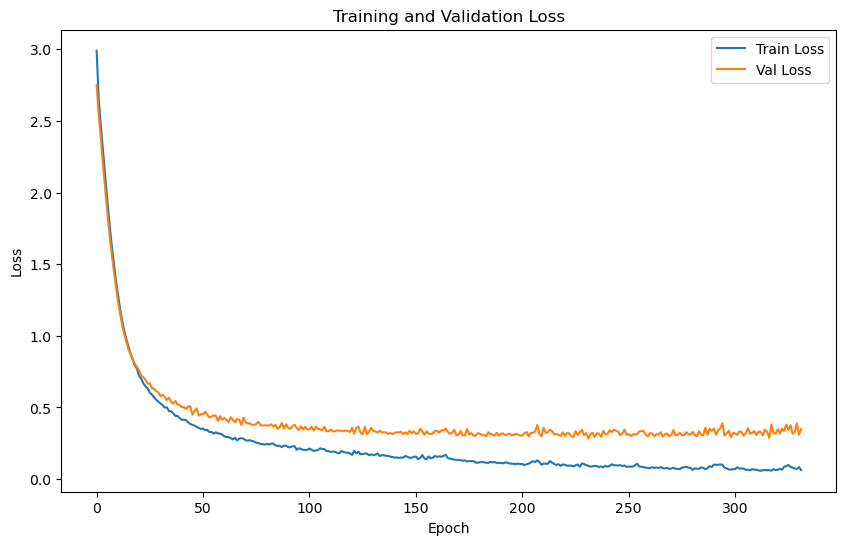

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 0.7366 | Test Accuracy: 82.95%


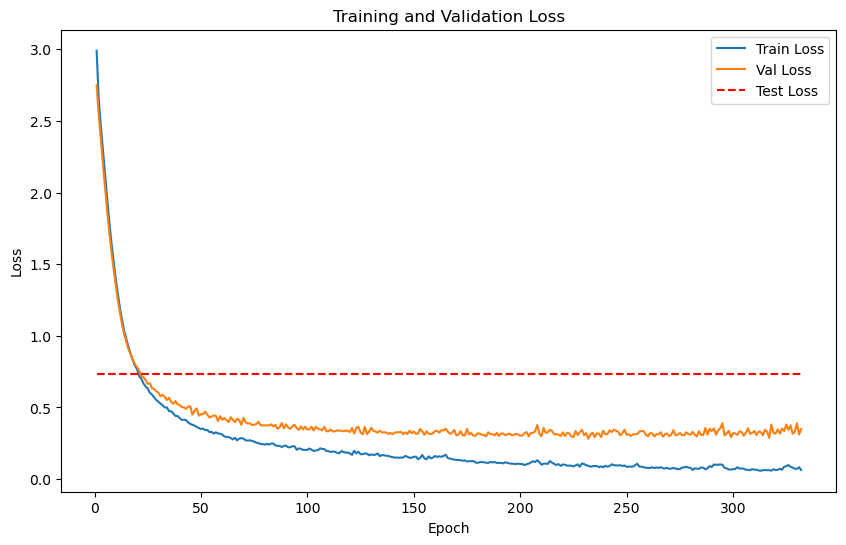

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53729 samples with 64 features each
LOG: Labels shape: (53729,)


Train embeddings shape: (320, 64), 
Train labels shape: (320,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (53729, 64), 
Test labels shape: (53729,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}
Training batch size: 320


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 7.9406
Epoch [1/2000], Avg Train Loss: 7.9406


Epoch [1/2000], Avg Val Loss: 3.1094
Validation loss improved from inf to 3.1094. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 8.0079
Epoch [2/2000], Avg Train Loss: 8.0079
Epoch [2/2000], Avg Val Loss: 3.0959
Validation loss improved from 3.1094 to 3.0959. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.0247
Epoch [3/2000], Avg Train Loss: 8.0247
Epoch [3/2000], Avg Val Loss: 3.0825
Validation loss improved from 3.0959 to 3.0825. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 7.9655
Epoch [4/2000], Avg Train Loss: 7.9655
Epoch [4/2000], Avg Val Loss: 3.0697
Validation loss improved from 3.0825 to 3.0697. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 7.7110
Epoch [5/2000], Avg Train Loss: 7.7110
Epoch [5/2000], Avg Val Loss: 3.0571
Validation loss improved from 3.0697 to 3.0571. Saving model...

LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 7.7004
Ep

    Batch [1/1], Train Loss: 7.0349
Epoch [16/2000], Avg Train Loss: 7.0349
Epoch [16/2000], Avg Val Loss: 2.9434
Validation loss improved from 2.9520 to 2.9434. Saving model...

LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 6.9018
Epoch [17/2000], Avg Train Loss: 6.9018
Epoch [17/2000], Avg Val Loss: 2.9351
Validation loss improved from 2.9434 to 2.9351. Saving model...

LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 6.9266
Epoch [18/2000], Avg Train Loss: 6.9266
Epoch [18/2000], Avg Val Loss: 2.9271
Validation loss improved from 2.9351 to 2.9271. Saving model...

LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 6.9206
Epoch [19/2000], Avg Train Loss: 6.9206
Epoch [19/2000], Avg Val Loss: 2.9193
Validation loss improved from 2.9271 to 2.9193. Saving model...

LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 6.7802
Epoch [20/2000], Avg Train Loss: 6.7802
Epoch [20/2000], Avg Val Loss: 2.9118
Validation loss improved from 2.9193 to 2.

    Batch [1/1], Train Loss: 6.5275
Epoch [23/2000], Avg Train Loss: 6.5275
Epoch [23/2000], Avg Val Loss: 2.8911
Validation loss improved from 2.8977 to 2.8911. Saving model...

LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 6.7025
Epoch [24/2000], Avg Train Loss: 6.7025
Epoch [24/2000], Avg Val Loss: 2.8847
Validation loss improved from 2.8911 to 2.8847. Saving model...

LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 6.6536
Epoch [25/2000], Avg Train Loss: 6.6536
Epoch [25/2000], Avg Val Loss: 2.8786
Validation loss improved from 2.8847 to 2.8786. Saving model...

LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 6.5875
Epoch [26/2000], Avg Train Loss: 6.5875
Epoch [26/2000], Avg Val Loss: 2.8728
Validation loss improved from 2.8786 to 2.8728. Saving model...

LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 6.5494
Epoch [27/2000], Avg Train Loss: 6.5494
Epoch [27/2000], Avg Val Loss: 2.8673
Validation loss improved from 2.8728 to 2.

Epoch [35/2000], Avg Val Loss: 2.8302
Validation loss improved from 2.8342 to 2.8302. Saving model...

LOG: Epoch [36/2000] - Training
    Batch [1/1], Train Loss: 6.0018
Epoch [36/2000], Avg Train Loss: 6.0018
Epoch [36/2000], Avg Val Loss: 2.8265
Validation loss improved from 2.8302 to 2.8265. Saving model...

LOG: Epoch [37/2000] - Training
    Batch [1/1], Train Loss: 5.9823
Epoch [37/2000], Avg Train Loss: 5.9823
Epoch [37/2000], Avg Val Loss: 2.8229
Validation loss improved from 2.8265 to 2.8229. Saving model...

LOG: Epoch [38/2000] - Training
    Batch [1/1], Train Loss: 6.0694
Epoch [38/2000], Avg Train Loss: 6.0694
Epoch [38/2000], Avg Val Loss: 2.8195
Validation loss improved from 2.8229 to 2.8195. Saving model...

LOG: Epoch [39/2000] - Training
    Batch [1/1], Train Loss: 6.0042
Epoch [39/2000], Avg Train Loss: 6.0042
Epoch [39/2000], Avg Val Loss: 2.8162
Validation loss improved from 2.8195 to 2.8162. Saving model...

LOG: Epoch [40/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 5.8173
Epoch [47/2000], Avg Train Loss: 5.8173
Epoch [47/2000], Avg Val Loss: 2.7952
Validation loss improved from 2.7974 to 2.7952. Saving model...

LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 5.7497
Epoch [48/2000], Avg Train Loss: 5.7497
Epoch [48/2000], Avg Val Loss: 2.7930
Validation loss improved from 2.7952 to 2.7930. Saving model...

LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 5.6756
Epoch [49/2000], Avg Train Loss: 5.6756
Epoch [49/2000], Avg Val Loss: 2.7910
Validation loss improved from 2.7930 to 2.7910. Saving model...

LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 5.7200
Epoch [50/2000], Avg Train Loss: 5.7200
Epoch [50/2000], Avg Val Loss: 2.7890
Validation loss improved from 2.7910 to 2.7890. Saving model...

LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 5.6523
Epoch [51/2000], Avg Train Loss: 5.6523
Epoch [51/2000], Avg Val Loss: 2.7871
Validation loss improved from 2.7890 to 2.

    Batch [1/1], Train Loss: 5.5306
Epoch [57/2000], Avg Train Loss: 5.5306
Epoch [57/2000], Avg Val Loss: 2.7774
Validation loss improved from 2.7788 to 2.7774. Saving model...

LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 5.4602
Epoch [58/2000], Avg Train Loss: 5.4602
Epoch [58/2000], Avg Val Loss: 2.7760
Validation loss improved from 2.7774 to 2.7760. Saving model...

LOG: Epoch [59/2000] - Training
    Batch [1/1], Train Loss: 5.4877
Epoch [59/2000], Avg Train Loss: 5.4877
Epoch [59/2000], Avg Val Loss: 2.7748
Validation loss improved from 2.7760 to 2.7748. Saving model...

LOG: Epoch [60/2000] - Training
    Batch [1/1], Train Loss: 5.4287
Epoch [60/2000], Avg Train Loss: 5.4287
Epoch [60/2000], Avg Val Loss: 2.7736
Validation loss improved from 2.7748 to 2.7736. Saving model...

LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 5.5178
Epoch [61/2000], Avg Train Loss: 5.5178
Epoch [61/2000], Avg Val Loss: 2.7725
Validation loss improved from 2.7736 to 2.

    Batch [1/1], Train Loss: 5.2745
Epoch [70/2000], Avg Train Loss: 5.2745
Epoch [70/2000], Avg Val Loss: 2.7642
Validation loss improved from 2.7650 to 2.7642. Saving model...

LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 5.2908
Epoch [71/2000], Avg Train Loss: 5.2908
Epoch [71/2000], Avg Val Loss: 2.7635
Validation loss improved from 2.7642 to 2.7635. Saving model...

LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 5.1879
Epoch [72/2000], Avg Train Loss: 5.1879
Epoch [72/2000], Avg Val Loss: 2.7628
Validation loss improved from 2.7635 to 2.7628. Saving model...

LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 5.1516
Epoch [73/2000], Avg Train Loss: 5.1516
Epoch [73/2000], Avg Val Loss: 2.7622
Validation loss improved from 2.7628 to 2.7622. Saving model...

LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 5.2398
Epoch [74/2000], Avg Train Loss: 5.2398
Epoch [74/2000], Avg Val Loss: 2.7615
Validation loss improved from 2.7622 to 2.

    Batch [1/1], Train Loss: 5.1679
Epoch [83/2000], Avg Train Loss: 5.1679
Epoch [83/2000], Avg Val Loss: 2.7563
Validation loss improved from 2.7568 to 2.7563. Saving model...

LOG: Epoch [84/2000] - Training
    Batch [1/1], Train Loss: 5.1175
Epoch [84/2000], Avg Train Loss: 5.1175
Epoch [84/2000], Avg Val Loss: 2.7558
Validation loss improved from 2.7563 to 2.7558. Saving model...

LOG: Epoch [85/2000] - Training
    Batch [1/1], Train Loss: 5.0860
Epoch [85/2000], Avg Train Loss: 5.0860
Epoch [85/2000], Avg Val Loss: 2.7553
Validation loss improved from 2.7558 to 2.7553. Saving model...

LOG: Epoch [86/2000] - Training
    Batch [1/1], Train Loss: 5.0320
Epoch [86/2000], Avg Train Loss: 5.0320
Epoch [86/2000], Avg Val Loss: 2.7548
Validation loss improved from 2.7553 to 2.7548. Saving model...

LOG: Epoch [87/2000] - Training
    Batch [1/1], Train Loss: 5.0303
Epoch [87/2000], Avg Train Loss: 5.0303
Epoch [87/2000], Avg Val Loss: 2.7543
Validation loss improved from 2.7548 to 2.

    Batch [1/1], Train Loss: 4.9816
Epoch [93/2000], Avg Train Loss: 4.9816
Epoch [93/2000], Avg Val Loss: 2.7517
Validation loss improved from 2.7521 to 2.7517. Saving model...

LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 4.9487
Epoch [94/2000], Avg Train Loss: 4.9487
Epoch [94/2000], Avg Val Loss: 2.7512
Validation loss improved from 2.7517 to 2.7512. Saving model...

LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 5.0100
Epoch [95/2000], Avg Train Loss: 5.0100
Epoch [95/2000], Avg Val Loss: 2.7508
Validation loss improved from 2.7512 to 2.7508. Saving model...

LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 5.0041
Epoch [96/2000], Avg Train Loss: 5.0041
Epoch [96/2000], Avg Val Loss: 2.7503
Validation loss improved from 2.7508 to 2.7503. Saving model...

LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 4.9454
Epoch [97/2000], Avg Train Loss: 4.9454
Epoch [97/2000], Avg Val Loss: 2.7499
Validation loss improved from 2.7503 to 2.

Epoch [107/2000], Avg Val Loss: 2.7450
Validation loss improved from 2.7455 to 2.7450. Saving model...

LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 4.8579
Epoch [108/2000], Avg Train Loss: 4.8579
Epoch [108/2000], Avg Val Loss: 2.7444
Validation loss improved from 2.7450 to 2.7444. Saving model...

LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 4.9373
Epoch [109/2000], Avg Train Loss: 4.9373
Epoch [109/2000], Avg Val Loss: 2.7439
Validation loss improved from 2.7444 to 2.7439. Saving model...

LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 4.8746
Epoch [110/2000], Avg Train Loss: 4.8746
Epoch [110/2000], Avg Val Loss: 2.7434
Validation loss improved from 2.7439 to 2.7434. Saving model...

LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 4.8405
Epoch [111/2000], Avg Train Loss: 4.8405
Epoch [111/2000], Avg Val Loss: 2.7428
Validation loss improved from 2.7434 to 2.7428. Saving model...

LOG: Epoch [112/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.8175
Epoch [119/2000], Avg Train Loss: 4.8175
Epoch [119/2000], Avg Val Loss: 2.7381
Validation loss improved from 2.7387 to 2.7381. Saving model...

LOG: Epoch [120/2000] - Training
    Batch [1/1], Train Loss: 4.8270
Epoch [120/2000], Avg Train Loss: 4.8270
Epoch [120/2000], Avg Val Loss: 2.7374
Validation loss improved from 2.7381 to 2.7374. Saving model...

LOG: Epoch [121/2000] - Training
    Batch [1/1], Train Loss: 4.8245
Epoch [121/2000], Avg Train Loss: 4.8245
Epoch [121/2000], Avg Val Loss: 2.7368
Validation loss improved from 2.7374 to 2.7368. Saving model...

LOG: Epoch [122/2000] - Training
    Batch [1/1], Train Loss: 4.7661
Epoch [122/2000], Avg Train Loss: 4.7661
Epoch [122/2000], Avg Val Loss: 2.7362
Validation loss improved from 2.7368 to 2.7362. Saving model...

LOG: Epoch [123/2000] - Training
    Batch [1/1], Train Loss: 4.8072
Epoch [123/2000], Avg Train Loss: 4.8072
Epoch [123/2000], Avg Val Loss: 2.7355
Validation loss improved fro

Epoch [127/2000], Avg Val Loss: 2.7330
Validation loss improved from 2.7336 to 2.7330. Saving model...

LOG: Epoch [128/2000] - Training
    Batch [1/1], Train Loss: 4.7539
Epoch [128/2000], Avg Train Loss: 4.7539
Epoch [128/2000], Avg Val Loss: 2.7323
Validation loss improved from 2.7330 to 2.7323. Saving model...

LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 4.7487
Epoch [129/2000], Avg Train Loss: 4.7487
Epoch [129/2000], Avg Val Loss: 2.7317
Validation loss improved from 2.7323 to 2.7317. Saving model...

LOG: Epoch [130/2000] - Training
    Batch [1/1], Train Loss: 4.7641
Epoch [130/2000], Avg Train Loss: 4.7641
Epoch [130/2000], Avg Val Loss: 2.7310
Validation loss improved from 2.7317 to 2.7310. Saving model...

LOG: Epoch [131/2000] - Training
    Batch [1/1], Train Loss: 4.7695
Epoch [131/2000], Avg Train Loss: 4.7695
Epoch [131/2000], Avg Val Loss: 2.7303
Validation loss improved from 2.7310 to 2.7303. Saving model...

LOG: Epoch [132/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.7422
Epoch [143/2000], Avg Train Loss: 4.7422
Epoch [143/2000], Avg Val Loss: 2.7210
Validation loss improved from 2.7218 to 2.7210. Saving model...

LOG: Epoch [144/2000] - Training
    Batch [1/1], Train Loss: 4.7048
Epoch [144/2000], Avg Train Loss: 4.7048
Epoch [144/2000], Avg Val Loss: 2.7202
Validation loss improved from 2.7210 to 2.7202. Saving model...

LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 4.6694
Epoch [145/2000], Avg Train Loss: 4.6694
Epoch [145/2000], Avg Val Loss: 2.7193
Validation loss improved from 2.7202 to 2.7193. Saving model...

LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 4.6689
Epoch [146/2000], Avg Train Loss: 4.6689
Epoch [146/2000], Avg Val Loss: 2.7185
Validation loss improved from 2.7193 to 2.7185. Saving model...

LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 4.6774
Epoch [147/2000], Avg Train Loss: 4.6774
Epoch [147/2000], Avg Val Loss: 2.7176
Validation loss improved fro

Epoch [155/2000], Avg Val Loss: 2.7104
Validation loss improved from 2.7113 to 2.7104. Saving model...

LOG: Epoch [156/2000] - Training
    Batch [1/1], Train Loss: 4.6453
Epoch [156/2000], Avg Train Loss: 4.6453
Epoch [156/2000], Avg Val Loss: 2.7095
Validation loss improved from 2.7104 to 2.7095. Saving model...

LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 4.6652
Epoch [157/2000], Avg Train Loss: 4.6652
Epoch [157/2000], Avg Val Loss: 2.7086
Validation loss improved from 2.7095 to 2.7086. Saving model...

LOG: Epoch [158/2000] - Training
    Batch [1/1], Train Loss: 4.6913
Epoch [158/2000], Avg Train Loss: 4.6913
Epoch [158/2000], Avg Val Loss: 2.7076
Validation loss improved from 2.7086 to 2.7076. Saving model...

LOG: Epoch [159/2000] - Training
    Batch [1/1], Train Loss: 4.6244
Epoch [159/2000], Avg Train Loss: 4.6244
Epoch [159/2000], Avg Val Loss: 2.7067
Validation loss improved from 2.7076 to 2.7067. Saving model...

LOG: Epoch [160/2000] - Training
    Bat

Epoch [160/2000], Avg Val Loss: 2.7058
Validation loss improved from 2.7067 to 2.7058. Saving model...

LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 4.6636
Epoch [161/2000], Avg Train Loss: 4.6636
Epoch [161/2000], Avg Val Loss: 2.7048
Validation loss improved from 2.7058 to 2.7048. Saving model...

LOG: Epoch [162/2000] - Training
    Batch [1/1], Train Loss: 4.6487
Epoch [162/2000], Avg Train Loss: 4.6487
Epoch [162/2000], Avg Val Loss: 2.7039
Validation loss improved from 2.7048 to 2.7039. Saving model...

LOG: Epoch [163/2000] - Training
    Batch [1/1], Train Loss: 4.6240
Epoch [163/2000], Avg Train Loss: 4.6240
Epoch [163/2000], Avg Val Loss: 2.7030
Validation loss improved from 2.7039 to 2.7030. Saving model...

LOG: Epoch [164/2000] - Training
    Batch [1/1], Train Loss: 4.6163
Epoch [164/2000], Avg Train Loss: 4.6163
Epoch [164/2000], Avg Val Loss: 2.7021
Validation loss improved from 2.7030 to 2.7021. Saving model...

LOG: Epoch [165/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.5860
Epoch [180/2000], Avg Train Loss: 4.5860
Epoch [180/2000], Avg Val Loss: 2.6875
Validation loss improved from 2.6884 to 2.6875. Saving model...

LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 4.5880
Epoch [181/2000], Avg Train Loss: 4.5880
Epoch [181/2000], Avg Val Loss: 2.6865
Validation loss improved from 2.6875 to 2.6865. Saving model...

LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 4.5683
Epoch [182/2000], Avg Train Loss: 4.5683
Epoch [182/2000], Avg Val Loss: 2.6856
Validation loss improved from 2.6865 to 2.6856. Saving model...

LOG: Epoch [183/2000] - Training
    Batch [1/1], Train Loss: 4.5732
Epoch [183/2000], Avg Train Loss: 4.5732
Epoch [183/2000], Avg Val Loss: 2.6847
Validation loss improved from 2.6856 to 2.6847. Saving model...

LOG: Epoch [184/2000] - Training
    Batch [1/1], Train Loss: 4.5584
Epoch [184/2000], Avg Train Loss: 4.5584
Epoch [184/2000], Avg Val Loss: 2.6837
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5323
Epoch [192/2000], Avg Train Loss: 4.5323
Epoch [192/2000], Avg Val Loss: 2.6762
Validation loss improved from 2.6772 to 2.6762. Saving model...

LOG: Epoch [193/2000] - Training
    Batch [1/1], Train Loss: 4.5314
Epoch [193/2000], Avg Train Loss: 4.5314
Epoch [193/2000], Avg Val Loss: 2.6753
Validation loss improved from 2.6762 to 2.6753. Saving model...

LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 4.5405
Epoch [194/2000], Avg Train Loss: 4.5405
Epoch [194/2000], Avg Val Loss: 2.6744
Validation loss improved from 2.6753 to 2.6744. Saving model...

LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 4.5716
Epoch [195/2000], Avg Train Loss: 4.5716
Epoch [195/2000], Avg Val Loss: 2.6735
Validation loss improved from 2.6744 to 2.6735. Saving model...

LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 4.5805
Epoch [196/2000], Avg Train Loss: 4.5805
Epoch [196/2000], Avg Val Loss: 2.6726
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5121
Epoch [215/2000], Avg Train Loss: 4.5121
Epoch [215/2000], Avg Val Loss: 2.6559
Validation loss improved from 2.6567 to 2.6559. Saving model...

LOG: Epoch [216/2000] - Training
    Batch [1/1], Train Loss: 4.4730
Epoch [216/2000], Avg Train Loss: 4.4730
Epoch [216/2000], Avg Val Loss: 2.6550
Validation loss improved from 2.6559 to 2.6550. Saving model...

LOG: Epoch [217/2000] - Training
    Batch [1/1], Train Loss: 4.4510
Epoch [217/2000], Avg Train Loss: 4.4510
Epoch [217/2000], Avg Val Loss: 2.6541
Validation loss improved from 2.6550 to 2.6541. Saving model...

LOG: Epoch [218/2000] - Training
    Batch [1/1], Train Loss: 4.4661
Epoch [218/2000], Avg Train Loss: 4.4661
Epoch [218/2000], Avg Val Loss: 2.6533
Validation loss improved from 2.6541 to 2.6533. Saving model...

LOG: Epoch [219/2000] - Training
    Batch [1/1], Train Loss: 4.4911
Epoch [219/2000], Avg Train Loss: 4.4911
Epoch [219/2000], Avg Val Loss: 2.6525
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5006
Epoch [228/2000], Avg Train Loss: 4.5006
Epoch [228/2000], Avg Val Loss: 2.6450
Validation loss improved from 2.6459 to 2.6450. Saving model...

LOG: Epoch [229/2000] - Training
    Batch [1/1], Train Loss: 4.4866
Epoch [229/2000], Avg Train Loss: 4.4866
Epoch [229/2000], Avg Val Loss: 2.6442
Validation loss improved from 2.6450 to 2.6442. Saving model...

LOG: Epoch [230/2000] - Training
    Batch [1/1], Train Loss: 4.4607
Epoch [230/2000], Avg Train Loss: 4.4607
Epoch [230/2000], Avg Val Loss: 2.6434
Validation loss improved from 2.6442 to 2.6434. Saving model...

LOG: Epoch [231/2000] - Training
    Batch [1/1], Train Loss: 4.4193
Epoch [231/2000], Avg Train Loss: 4.4193
Epoch [231/2000], Avg Val Loss: 2.6426
Validation loss improved from 2.6434 to 2.6426. Saving model...

LOG: Epoch [232/2000] - Training
    Batch [1/1], Train Loss: 4.4595
Epoch [232/2000], Avg Train Loss: 4.4595
Epoch [232/2000], Avg Val Loss: 2.6417
Validation loss improved fro

    Batch [1/1], Train Loss: 4.3779
Epoch [249/2000], Avg Train Loss: 4.3779
Epoch [249/2000], Avg Val Loss: 2.6282
Validation loss improved from 2.6289 to 2.6282. Saving model...

LOG: Epoch [250/2000] - Training
    Batch [1/1], Train Loss: 4.3937
Epoch [250/2000], Avg Train Loss: 4.3937
Epoch [250/2000], Avg Val Loss: 2.6274
Validation loss improved from 2.6282 to 2.6274. Saving model...

LOG: Epoch [251/2000] - Training
    Batch [1/1], Train Loss: 4.3879
Epoch [251/2000], Avg Train Loss: 4.3879
Epoch [251/2000], Avg Val Loss: 2.6266
Validation loss improved from 2.6274 to 2.6266. Saving model...

LOG: Epoch [252/2000] - Training
    Batch [1/1], Train Loss: 4.4181
Epoch [252/2000], Avg Train Loss: 4.4181
Epoch [252/2000], Avg Val Loss: 2.6258
Validation loss improved from 2.6266 to 2.6258. Saving model...

LOG: Epoch [253/2000] - Training
    Batch [1/1], Train Loss: 4.3926
Epoch [253/2000], Avg Train Loss: 4.3926
Epoch [253/2000], Avg Val Loss: 2.6250
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4067
Epoch [259/2000], Avg Train Loss: 4.4067
Epoch [259/2000], Avg Val Loss: 2.6202
Validation loss improved from 2.6210 to 2.6202. Saving model...

LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 4.3638
Epoch [260/2000], Avg Train Loss: 4.3638
Epoch [260/2000], Avg Val Loss: 2.6194
Validation loss improved from 2.6202 to 2.6194. Saving model...

LOG: Epoch [261/2000] - Training
    Batch [1/1], Train Loss: 4.4122
Epoch [261/2000], Avg Train Loss: 4.4122
Epoch [261/2000], Avg Val Loss: 2.6186
Validation loss improved from 2.6194 to 2.6186. Saving model...

LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 4.3885
Epoch [262/2000], Avg Train Loss: 4.3885
Epoch [262/2000], Avg Val Loss: 2.6178
Validation loss improved from 2.6186 to 2.6178. Saving model...

LOG: Epoch [263/2000] - Training
    Batch [1/1], Train Loss: 4.3702
Epoch [263/2000], Avg Train Loss: 4.3702
Epoch [263/2000], Avg Val Loss: 2.6171
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2996
Epoch [286/2000], Avg Train Loss: 4.2996
Epoch [286/2000], Avg Val Loss: 2.5999
Validation loss improved from 2.6005 to 2.5999. Saving model...

LOG: Epoch [287/2000] - Training
    Batch [1/1], Train Loss: 4.3435
Epoch [287/2000], Avg Train Loss: 4.3435
Epoch [287/2000], Avg Val Loss: 2.5992
Validation loss improved from 2.5999 to 2.5992. Saving model...

LOG: Epoch [288/2000] - Training
    Batch [1/1], Train Loss: 4.3535
Epoch [288/2000], Avg Train Loss: 4.3535
Epoch [288/2000], Avg Val Loss: 2.5985
Validation loss improved from 2.5992 to 2.5985. Saving model...

LOG: Epoch [289/2000] - Training
    Batch [1/1], Train Loss: 4.3235
Epoch [289/2000], Avg Train Loss: 4.3235
Epoch [289/2000], Avg Val Loss: 2.5979
Validation loss improved from 2.5985 to 2.5979. Saving model...

LOG: Epoch [290/2000] - Training
    Batch [1/1], Train Loss: 4.3274
Epoch [290/2000], Avg Train Loss: 4.3274
Epoch [290/2000], Avg Val Loss: 2.5972
Validation loss improved fro

    Batch [1/1], Train Loss: 4.3035
Epoch [294/2000], Avg Train Loss: 4.3035
Epoch [294/2000], Avg Val Loss: 2.5945
Validation loss improved from 2.5952 to 2.5945. Saving model...

LOG: Epoch [295/2000] - Training
    Batch [1/1], Train Loss: 4.3048
Epoch [295/2000], Avg Train Loss: 4.3048
Epoch [295/2000], Avg Val Loss: 2.5938
Validation loss improved from 2.5945 to 2.5938. Saving model...

LOG: Epoch [296/2000] - Training
    Batch [1/1], Train Loss: 4.3492
Epoch [296/2000], Avg Train Loss: 4.3492
Epoch [296/2000], Avg Val Loss: 2.5932
Validation loss improved from 2.5938 to 2.5932. Saving model...

LOG: Epoch [297/2000] - Training
    Batch [1/1], Train Loss: 4.3160
Epoch [297/2000], Avg Train Loss: 4.3160
Epoch [297/2000], Avg Val Loss: 2.5925
Validation loss improved from 2.5932 to 2.5925. Saving model...

LOG: Epoch [298/2000] - Training
    Batch [1/1], Train Loss: 4.3079
Epoch [298/2000], Avg Train Loss: 4.3079
Epoch [298/2000], Avg Val Loss: 2.5918
Validation loss improved fro

    Batch [1/1], Train Loss: 4.3209
Epoch [323/2000], Avg Train Loss: 4.3209
Epoch [323/2000], Avg Val Loss: 2.5753
Validation loss improved from 2.5759 to 2.5753. Saving model...

LOG: Epoch [324/2000] - Training
    Batch [1/1], Train Loss: 4.2886
Epoch [324/2000], Avg Train Loss: 4.2886
Epoch [324/2000], Avg Val Loss: 2.5747
Validation loss improved from 2.5753 to 2.5747. Saving model...

LOG: Epoch [325/2000] - Training
    Batch [1/1], Train Loss: 4.2939
Epoch [325/2000], Avg Train Loss: 4.2939
Epoch [325/2000], Avg Val Loss: 2.5741
Validation loss improved from 2.5747 to 2.5741. Saving model...

LOG: Epoch [326/2000] - Training
    Batch [1/1], Train Loss: 4.2837
Epoch [326/2000], Avg Train Loss: 4.2837
Epoch [326/2000], Avg Val Loss: 2.5736
Validation loss improved from 2.5741 to 2.5736. Saving model...

LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 4.3244
Epoch [327/2000], Avg Train Loss: 4.3244
Epoch [327/2000], Avg Val Loss: 2.5730
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2528
Epoch [330/2000], Avg Train Loss: 4.2528
Epoch [330/2000], Avg Val Loss: 2.5713
Validation loss improved from 2.5718 to 2.5713. Saving model...

LOG: Epoch [331/2000] - Training
    Batch [1/1], Train Loss: 4.2752
Epoch [331/2000], Avg Train Loss: 4.2752
Epoch [331/2000], Avg Val Loss: 2.5707
Validation loss improved from 2.5713 to 2.5707. Saving model...

LOG: Epoch [332/2000] - Training
    Batch [1/1], Train Loss: 4.2875
Epoch [332/2000], Avg Train Loss: 4.2875
Epoch [332/2000], Avg Val Loss: 2.5701
Validation loss improved from 2.5707 to 2.5701. Saving model...

LOG: Epoch [333/2000] - Training
    Batch [1/1], Train Loss: 4.2877
Epoch [333/2000], Avg Train Loss: 4.2877
Epoch [333/2000], Avg Val Loss: 2.5696
Validation loss improved from 2.5701 to 2.5696. Saving model...

LOG: Epoch [334/2000] - Training
    Batch [1/1], Train Loss: 4.2928
Epoch [334/2000], Avg Train Loss: 4.2928
Epoch [334/2000], Avg Val Loss: 2.5690
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2293
Epoch [358/2000], Avg Train Loss: 4.2293
Epoch [358/2000], Avg Val Loss: 2.5564
Validation loss improved from 2.5570 to 2.5564. Saving model...

LOG: Epoch [359/2000] - Training
    Batch [1/1], Train Loss: 4.2343
Epoch [359/2000], Avg Train Loss: 4.2343
Epoch [359/2000], Avg Val Loss: 2.5559
Validation loss improved from 2.5564 to 2.5559. Saving model...

LOG: Epoch [360/2000] - Training
    Batch [1/1], Train Loss: 4.2297
Epoch [360/2000], Avg Train Loss: 4.2297
Epoch [360/2000], Avg Val Loss: 2.5554
Validation loss improved from 2.5559 to 2.5554. Saving model...

LOG: Epoch [361/2000] - Training
    Batch [1/1], Train Loss: 4.2157
Epoch [361/2000], Avg Train Loss: 4.2157
Epoch [361/2000], Avg Val Loss: 2.5548
Validation loss improved from 2.5554 to 2.5548. Saving model...

LOG: Epoch [362/2000] - Training
    Batch [1/1], Train Loss: 4.2168
Epoch [362/2000], Avg Train Loss: 4.2168
Epoch [362/2000], Avg Val Loss: 2.5542
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2252
Epoch [368/2000], Avg Train Loss: 4.2252
Epoch [368/2000], Avg Val Loss: 2.5510
Validation loss improved from 2.5515 to 2.5510. Saving model...

LOG: Epoch [369/2000] - Training
    Batch [1/1], Train Loss: 4.2283
Epoch [369/2000], Avg Train Loss: 4.2283
Epoch [369/2000], Avg Val Loss: 2.5505
Validation loss improved from 2.5510 to 2.5505. Saving model...

LOG: Epoch [370/2000] - Training
    Batch [1/1], Train Loss: 4.1972
Epoch [370/2000], Avg Train Loss: 4.1972
Epoch [370/2000], Avg Val Loss: 2.5499
Validation loss improved from 2.5505 to 2.5499. Saving model...

LOG: Epoch [371/2000] - Training
    Batch [1/1], Train Loss: 4.2075
Epoch [371/2000], Avg Train Loss: 4.2075
Epoch [371/2000], Avg Val Loss: 2.5494
Validation loss improved from 2.5499 to 2.5494. Saving model...

LOG: Epoch [372/2000] - Training
    Batch [1/1], Train Loss: 4.2175
Epoch [372/2000], Avg Train Loss: 4.2175
Epoch [372/2000], Avg Val Loss: 2.5488
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1869
Epoch [392/2000], Avg Train Loss: 4.1869
Epoch [392/2000], Avg Val Loss: 2.5382
Validation loss improved from 2.5387 to 2.5382. Saving model...

LOG: Epoch [393/2000] - Training
    Batch [1/1], Train Loss: 4.1991
Epoch [393/2000], Avg Train Loss: 4.1991
Epoch [393/2000], Avg Val Loss: 2.5378
Validation loss improved from 2.5382 to 2.5378. Saving model...

LOG: Epoch [394/2000] - Training
    Batch [1/1], Train Loss: 4.1923
Epoch [394/2000], Avg Train Loss: 4.1923
Epoch [394/2000], Avg Val Loss: 2.5373
Validation loss improved from 2.5378 to 2.5373. Saving model...

LOG: Epoch [395/2000] - Training
    Batch [1/1], Train Loss: 4.1871
Epoch [395/2000], Avg Train Loss: 4.1871
Epoch [395/2000], Avg Val Loss: 2.5368
Validation loss improved from 2.5373 to 2.5368. Saving model...

LOG: Epoch [396/2000] - Training
    Batch [1/1], Train Loss: 4.1900
Epoch [396/2000], Avg Train Loss: 4.1900
Epoch [396/2000], Avg Val Loss: 2.5364
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1782
Epoch [406/2000], Avg Train Loss: 4.1782
Epoch [406/2000], Avg Val Loss: 2.5315
Validation loss improved from 2.5320 to 2.5315. Saving model...

LOG: Epoch [407/2000] - Training
    Batch [1/1], Train Loss: 4.1885
Epoch [407/2000], Avg Train Loss: 4.1885
Epoch [407/2000], Avg Val Loss: 2.5310
Validation loss improved from 2.5315 to 2.5310. Saving model...

LOG: Epoch [408/2000] - Training
    Batch [1/1], Train Loss: 4.2016
Epoch [408/2000], Avg Train Loss: 4.2016
Epoch [408/2000], Avg Val Loss: 2.5305
Validation loss improved from 2.5310 to 2.5305. Saving model...

LOG: Epoch [409/2000] - Training
    Batch [1/1], Train Loss: 4.1792
Epoch [409/2000], Avg Train Loss: 4.1792
Epoch [409/2000], Avg Val Loss: 2.5300
Validation loss improved from 2.5305 to 2.5300. Saving model...

LOG: Epoch [410/2000] - Training
    Batch [1/1], Train Loss: 4.2071
Epoch [410/2000], Avg Train Loss: 4.2071
Epoch [410/2000], Avg Val Loss: 2.5296
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1951
Epoch [429/2000], Avg Train Loss: 4.1951
Epoch [429/2000], Avg Val Loss: 2.5215
Validation loss improved from 2.5219 to 2.5215. Saving model...

LOG: Epoch [430/2000] - Training
    Batch [1/1], Train Loss: 4.1492
Epoch [430/2000], Avg Train Loss: 4.1492
Epoch [430/2000], Avg Val Loss: 2.5212
Validation loss improved from 2.5215 to 2.5212. Saving model...

LOG: Epoch [431/2000] - Training
    Batch [1/1], Train Loss: 4.1801
Epoch [431/2000], Avg Train Loss: 4.1801
Epoch [431/2000], Avg Val Loss: 2.5209
Validation loss improved from 2.5212 to 2.5209. Saving model...

LOG: Epoch [432/2000] - Training
    Batch [1/1], Train Loss: 4.1395
Epoch [432/2000], Avg Train Loss: 4.1395
Epoch [432/2000], Avg Val Loss: 2.5205
Validation loss improved from 2.5209 to 2.5205. Saving model...

LOG: Epoch [433/2000] - Training
    Batch [1/1], Train Loss: 4.1165
Epoch [433/2000], Avg Train Loss: 4.1165
Epoch [433/2000], Avg Val Loss: 2.5202
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1558
Epoch [442/2000], Avg Train Loss: 4.1558
Epoch [442/2000], Avg Val Loss: 2.5168
Validation loss improved from 2.5172 to 2.5168. Saving model...

LOG: Epoch [443/2000] - Training
    Batch [1/1], Train Loss: 4.1739
Epoch [443/2000], Avg Train Loss: 4.1739
Epoch [443/2000], Avg Val Loss: 2.5164
Validation loss improved from 2.5168 to 2.5164. Saving model...

LOG: Epoch [444/2000] - Training
    Batch [1/1], Train Loss: 4.1810
Epoch [444/2000], Avg Train Loss: 4.1810
Epoch [444/2000], Avg Val Loss: 2.5161
Validation loss improved from 2.5164 to 2.5161. Saving model...

LOG: Epoch [445/2000] - Training
    Batch [1/1], Train Loss: 4.1535
Epoch [445/2000], Avg Train Loss: 4.1535
Epoch [445/2000], Avg Val Loss: 2.5157
Validation loss improved from 2.5161 to 2.5157. Saving model...

LOG: Epoch [446/2000] - Training
    Batch [1/1], Train Loss: 4.1639
Epoch [446/2000], Avg Train Loss: 4.1639
Epoch [446/2000], Avg Val Loss: 2.5153
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1124
Epoch [464/2000], Avg Train Loss: 4.1124
Epoch [464/2000], Avg Val Loss: 2.5080
Validation loss improved from 2.5084 to 2.5080. Saving model...

LOG: Epoch [465/2000] - Training
    Batch [1/1], Train Loss: 4.1315
Epoch [465/2000], Avg Train Loss: 4.1315
Epoch [465/2000], Avg Val Loss: 2.5076
Validation loss improved from 2.5080 to 2.5076. Saving model...

LOG: Epoch [466/2000] - Training
    Batch [1/1], Train Loss: 4.1337
Epoch [466/2000], Avg Train Loss: 4.1337
Epoch [466/2000], Avg Val Loss: 2.5072
Validation loss improved from 2.5076 to 2.5072. Saving model...

LOG: Epoch [467/2000] - Training
    Batch [1/1], Train Loss: 4.1112
Epoch [467/2000], Avg Train Loss: 4.1112
Epoch [467/2000], Avg Val Loss: 2.5068
Validation loss improved from 2.5072 to 2.5068. Saving model...

LOG: Epoch [468/2000] - Training
    Batch [1/1], Train Loss: 4.1436
Epoch [468/2000], Avg Train Loss: 4.1436
Epoch [468/2000], Avg Val Loss: 2.5064
Validation loss improved fro

Epoch [475/2000], Avg Val Loss: 2.5036
Validation loss improved from 2.5040 to 2.5036. Saving model...

LOG: Epoch [476/2000] - Training
    Batch [1/1], Train Loss: 4.1059
Epoch [476/2000], Avg Train Loss: 4.1059
Epoch [476/2000], Avg Val Loss: 2.5032
Validation loss improved from 2.5036 to 2.5032. Saving model...

LOG: Epoch [477/2000] - Training
    Batch [1/1], Train Loss: 4.1159
Epoch [477/2000], Avg Train Loss: 4.1159
Epoch [477/2000], Avg Val Loss: 2.5028
Validation loss improved from 2.5032 to 2.5028. Saving model...

LOG: Epoch [478/2000] - Training
    Batch [1/1], Train Loss: 4.1349
Epoch [478/2000], Avg Train Loss: 4.1349
Epoch [478/2000], Avg Val Loss: 2.5024
Validation loss improved from 2.5028 to 2.5024. Saving model...

LOG: Epoch [479/2000] - Training
    Batch [1/1], Train Loss: 4.1100
Epoch [479/2000], Avg Train Loss: 4.1100
Epoch [479/2000], Avg Val Loss: 2.5020
Validation loss improved from 2.5024 to 2.5020. Saving model...

LOG: Epoch [480/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.1075
Epoch [501/2000], Avg Train Loss: 4.1075
Epoch [501/2000], Avg Val Loss: 2.4935
Validation loss improved from 2.4939 to 2.4935. Saving model...

LOG: Epoch [502/2000] - Training
    Batch [1/1], Train Loss: 4.0862
Epoch [502/2000], Avg Train Loss: 4.0862
Epoch [502/2000], Avg Val Loss: 2.4931
Validation loss improved from 2.4935 to 2.4931. Saving model...

LOG: Epoch [503/2000] - Training
    Batch [1/1], Train Loss: 4.0871
Epoch [503/2000], Avg Train Loss: 4.0871
Epoch [503/2000], Avg Val Loss: 2.4927
Validation loss improved from 2.4931 to 2.4927. Saving model...

LOG: Epoch [504/2000] - Training
    Batch [1/1], Train Loss: 4.0786
Epoch [504/2000], Avg Train Loss: 4.0786
Epoch [504/2000], Avg Val Loss: 2.4923
Validation loss improved from 2.4927 to 2.4923. Saving model...

LOG: Epoch [505/2000] - Training
    Batch [1/1], Train Loss: 4.0627
Epoch [505/2000], Avg Train Loss: 4.0627
Epoch [505/2000], Avg Val Loss: 2.4919
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0732
Epoch [516/2000], Avg Train Loss: 4.0732
Epoch [516/2000], Avg Val Loss: 2.4873
Validation loss improved from 2.4878 to 2.4873. Saving model...

LOG: Epoch [517/2000] - Training
    Batch [1/1], Train Loss: 4.0933
Epoch [517/2000], Avg Train Loss: 4.0933
Epoch [517/2000], Avg Val Loss: 2.4869
Validation loss improved from 2.4873 to 2.4869. Saving model...

LOG: Epoch [518/2000] - Training
    Batch [1/1], Train Loss: 4.0646
Epoch [518/2000], Avg Train Loss: 4.0646
Epoch [518/2000], Avg Val Loss: 2.4865
Validation loss improved from 2.4869 to 2.4865. Saving model...

LOG: Epoch [519/2000] - Training
    Batch [1/1], Train Loss: 4.0765
Epoch [519/2000], Avg Train Loss: 4.0765
Epoch [519/2000], Avg Val Loss: 2.4861
Validation loss improved from 2.4865 to 2.4861. Saving model...

LOG: Epoch [520/2000] - Training
    Batch [1/1], Train Loss: 4.0698
Epoch [520/2000], Avg Train Loss: 4.0698
Epoch [520/2000], Avg Val Loss: 2.4857
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0529
Epoch [538/2000], Avg Train Loss: 4.0529
Epoch [538/2000], Avg Val Loss: 2.4790
Validation loss improved from 2.4793 to 2.4790. Saving model...

LOG: Epoch [539/2000] - Training
    Batch [1/1], Train Loss: 4.0354
Epoch [539/2000], Avg Train Loss: 4.0354
Epoch [539/2000], Avg Val Loss: 2.4786
Validation loss improved from 2.4790 to 2.4786. Saving model...

LOG: Epoch [540/2000] - Training
    Batch [1/1], Train Loss: 4.0305
Epoch [540/2000], Avg Train Loss: 4.0305
Epoch [540/2000], Avg Val Loss: 2.4783
Validation loss improved from 2.4786 to 2.4783. Saving model...

LOG: Epoch [541/2000] - Training
    Batch [1/1], Train Loss: 4.0200
Epoch [541/2000], Avg Train Loss: 4.0200
Epoch [541/2000], Avg Val Loss: 2.4779
Validation loss improved from 2.4783 to 2.4779. Saving model...

LOG: Epoch [542/2000] - Training
    Batch [1/1], Train Loss: 4.0230
Epoch [542/2000], Avg Train Loss: 4.0230
Epoch [542/2000], Avg Val Loss: 2.4776
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0100
Epoch [553/2000], Avg Train Loss: 4.0100
Epoch [553/2000], Avg Val Loss: 2.4737
Validation loss improved from 2.4741 to 2.4737. Saving model...

LOG: Epoch [554/2000] - Training
    Batch [1/1], Train Loss: 4.0378
Epoch [554/2000], Avg Train Loss: 4.0378
Epoch [554/2000], Avg Val Loss: 2.4733
Validation loss improved from 2.4737 to 2.4733. Saving model...

LOG: Epoch [555/2000] - Training
    Batch [1/1], Train Loss: 4.0652
Epoch [555/2000], Avg Train Loss: 4.0652
Epoch [555/2000], Avg Val Loss: 2.4729
Validation loss improved from 2.4733 to 2.4729. Saving model...

LOG: Epoch [556/2000] - Training
    Batch [1/1], Train Loss: 4.0442
Epoch [556/2000], Avg Train Loss: 4.0442
Epoch [556/2000], Avg Val Loss: 2.4726
Validation loss improved from 2.4729 to 2.4726. Saving model...

LOG: Epoch [557/2000] - Training
    Batch [1/1], Train Loss: 4.0447
Epoch [557/2000], Avg Train Loss: 4.0447
Epoch [557/2000], Avg Val Loss: 2.4722
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0282
Epoch [575/2000], Avg Train Loss: 4.0282
Epoch [575/2000], Avg Val Loss: 2.4654
Validation loss improved from 2.4657 to 2.4654. Saving model...

LOG: Epoch [576/2000] - Training
    Batch [1/1], Train Loss: 4.0353
Epoch [576/2000], Avg Train Loss: 4.0353
Epoch [576/2000], Avg Val Loss: 2.4650
Validation loss improved from 2.4654 to 2.4650. Saving model...

LOG: Epoch [577/2000] - Training
    Batch [1/1], Train Loss: 3.9894
Epoch [577/2000], Avg Train Loss: 3.9894
Epoch [577/2000], Avg Val Loss: 2.4646
Validation loss improved from 2.4650 to 2.4646. Saving model...

LOG: Epoch [578/2000] - Training
    Batch [1/1], Train Loss: 3.9953
Epoch [578/2000], Avg Train Loss: 3.9953
Epoch [578/2000], Avg Val Loss: 2.4642
Validation loss improved from 2.4646 to 2.4642. Saving model...

LOG: Epoch [579/2000] - Training
    Batch [1/1], Train Loss: 4.0017
Epoch [579/2000], Avg Train Loss: 4.0017
Epoch [579/2000], Avg Val Loss: 2.4638
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0374
Epoch [592/2000], Avg Train Loss: 4.0374
Epoch [592/2000], Avg Val Loss: 2.4588
Validation loss improved from 2.4591 to 2.4588. Saving model...

LOG: Epoch [593/2000] - Training
    Batch [1/1], Train Loss: 4.0058
Epoch [593/2000], Avg Train Loss: 4.0058
Epoch [593/2000], Avg Val Loss: 2.4584
Validation loss improved from 2.4588 to 2.4584. Saving model...

LOG: Epoch [594/2000] - Training
    Batch [1/1], Train Loss: 4.0295
Epoch [594/2000], Avg Train Loss: 4.0295
Epoch [594/2000], Avg Val Loss: 2.4581
Validation loss improved from 2.4584 to 2.4581. Saving model...

LOG: Epoch [595/2000] - Training
    Batch [1/1], Train Loss: 3.9757
Epoch [595/2000], Avg Train Loss: 3.9757
Epoch [595/2000], Avg Val Loss: 2.4577
Validation loss improved from 2.4581 to 2.4577. Saving model...

LOG: Epoch [596/2000] - Training
    Batch [1/1], Train Loss: 4.0047
Epoch [596/2000], Avg Train Loss: 4.0047
Epoch [596/2000], Avg Val Loss: 2.4573
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0445
Epoch [614/2000], Avg Train Loss: 4.0445
Epoch [614/2000], Avg Val Loss: 2.4496
Validation loss improved from 2.4500 to 2.4496. Saving model...

LOG: Epoch [615/2000] - Training
    Batch [1/1], Train Loss: 4.0177
Epoch [615/2000], Avg Train Loss: 4.0177
Epoch [615/2000], Avg Val Loss: 2.4492
Validation loss improved from 2.4496 to 2.4492. Saving model...

LOG: Epoch [616/2000] - Training
    Batch [1/1], Train Loss: 4.0190
Epoch [616/2000], Avg Train Loss: 4.0190
Epoch [616/2000], Avg Val Loss: 2.4488
Validation loss improved from 2.4492 to 2.4488. Saving model...

LOG: Epoch [617/2000] - Training
    Batch [1/1], Train Loss: 3.9741
Epoch [617/2000], Avg Train Loss: 3.9741
Epoch [617/2000], Avg Val Loss: 2.4485
Validation loss improved from 2.4488 to 2.4485. Saving model...

LOG: Epoch [618/2000] - Training
    Batch [1/1], Train Loss: 4.0043
Epoch [618/2000], Avg Train Loss: 4.0043
Epoch [618/2000], Avg Val Loss: 2.4481
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9891
Epoch [627/2000], Avg Train Loss: 3.9891
Epoch [627/2000], Avg Val Loss: 2.4448
Validation loss improved from 2.4452 to 2.4448. Saving model...

LOG: Epoch [628/2000] - Training
    Batch [1/1], Train Loss: 3.9659
Epoch [628/2000], Avg Train Loss: 3.9659
Epoch [628/2000], Avg Val Loss: 2.4443
Validation loss improved from 2.4448 to 2.4443. Saving model...

LOG: Epoch [629/2000] - Training
    Batch [1/1], Train Loss: 3.9637
Epoch [629/2000], Avg Train Loss: 3.9637
Epoch [629/2000], Avg Val Loss: 2.4439
Validation loss improved from 2.4443 to 2.4439. Saving model...

LOG: Epoch [630/2000] - Training
    Batch [1/1], Train Loss: 3.9935
Epoch [630/2000], Avg Train Loss: 3.9935
Epoch [630/2000], Avg Val Loss: 2.4435
Validation loss improved from 2.4439 to 2.4435. Saving model...

LOG: Epoch [631/2000] - Training
    Batch [1/1], Train Loss: 4.0180
Epoch [631/2000], Avg Train Loss: 4.0180
Epoch [631/2000], Avg Val Loss: 2.4432
Validation loss improved fro

Epoch [651/2000], Avg Val Loss: 2.4371
Validation loss improved from 2.4374 to 2.4371. Saving model...

LOG: Epoch [652/2000] - Training
    Batch [1/1], Train Loss: 3.9804
Epoch [652/2000], Avg Train Loss: 3.9804
Epoch [652/2000], Avg Val Loss: 2.4368
Validation loss improved from 2.4371 to 2.4368. Saving model...

LOG: Epoch [653/2000] - Training
    Batch [1/1], Train Loss: 3.9478
Epoch [653/2000], Avg Train Loss: 3.9478
Epoch [653/2000], Avg Val Loss: 2.4365
Validation loss improved from 2.4368 to 2.4365. Saving model...

LOG: Epoch [654/2000] - Training
    Batch [1/1], Train Loss: 3.9920
Epoch [654/2000], Avg Train Loss: 3.9920
Epoch [654/2000], Avg Val Loss: 2.4361
Validation loss improved from 2.4365 to 2.4361. Saving model...

LOG: Epoch [655/2000] - Training
    Batch [1/1], Train Loss: 3.9959
Epoch [655/2000], Avg Train Loss: 3.9959
Epoch [655/2000], Avg Val Loss: 2.4357
Validation loss improved from 2.4361 to 2.4357. Saving model...

LOG: Epoch [656/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.9485
Epoch [664/2000], Avg Train Loss: 3.9485
Epoch [664/2000], Avg Val Loss: 2.4317
Validation loss improved from 2.4322 to 2.4317. Saving model...

LOG: Epoch [665/2000] - Training
    Batch [1/1], Train Loss: 3.9858
Epoch [665/2000], Avg Train Loss: 3.9858
Epoch [665/2000], Avg Val Loss: 2.4313
Validation loss improved from 2.4317 to 2.4313. Saving model...

LOG: Epoch [666/2000] - Training
    Batch [1/1], Train Loss: 3.9436
Epoch [666/2000], Avg Train Loss: 3.9436
Epoch [666/2000], Avg Val Loss: 2.4308
Validation loss improved from 2.4313 to 2.4308. Saving model...

LOG: Epoch [667/2000] - Training
    Batch [1/1], Train Loss: 3.9469
Epoch [667/2000], Avg Train Loss: 3.9469
Epoch [667/2000], Avg Val Loss: 2.4303
Validation loss improved from 2.4308 to 2.4303. Saving model...

LOG: Epoch [668/2000] - Training
    Batch [1/1], Train Loss: 3.9590
Epoch [668/2000], Avg Train Loss: 3.9590
Epoch [668/2000], Avg Val Loss: 2.4299
Validation loss improved fro

Epoch [687/2000], Avg Val Loss: 2.4221
Validation loss improved from 2.4224 to 2.4221. Saving model...

LOG: Epoch [688/2000] - Training
    Batch [1/1], Train Loss: 3.9589
Epoch [688/2000], Avg Train Loss: 3.9589
Epoch [688/2000], Avg Val Loss: 2.4218
Validation loss improved from 2.4221 to 2.4218. Saving model...

LOG: Epoch [689/2000] - Training
    Batch [1/1], Train Loss: 3.9704
Epoch [689/2000], Avg Train Loss: 3.9704
Epoch [689/2000], Avg Val Loss: 2.4214
Validation loss improved from 2.4218 to 2.4214. Saving model...

LOG: Epoch [690/2000] - Training
    Batch [1/1], Train Loss: 3.8932
Epoch [690/2000], Avg Train Loss: 3.8932
Epoch [690/2000], Avg Val Loss: 2.4210
Validation loss improved from 2.4214 to 2.4210. Saving model...

LOG: Epoch [691/2000] - Training
    Batch [1/1], Train Loss: 3.9448
Epoch [691/2000], Avg Train Loss: 3.9448
Epoch [691/2000], Avg Val Loss: 2.4207
Validation loss improved from 2.4210 to 2.4207. Saving model...

LOG: Epoch [692/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.9482
Epoch [701/2000], Avg Train Loss: 3.9482
Epoch [701/2000], Avg Val Loss: 2.4176
Validation loss improved from 2.4179 to 2.4176. Saving model...

LOG: Epoch [702/2000] - Training
    Batch [1/1], Train Loss: 3.9626
Epoch [702/2000], Avg Train Loss: 3.9626
Epoch [702/2000], Avg Val Loss: 2.4173
Validation loss improved from 2.4176 to 2.4173. Saving model...

LOG: Epoch [703/2000] - Training
    Batch [1/1], Train Loss: 3.9315
Epoch [703/2000], Avg Train Loss: 3.9315
Epoch [703/2000], Avg Val Loss: 2.4170
Validation loss improved from 2.4173 to 2.4170. Saving model...

LOG: Epoch [704/2000] - Training
    Batch [1/1], Train Loss: 3.9215
Epoch [704/2000], Avg Train Loss: 3.9215
Epoch [704/2000], Avg Val Loss: 2.4166
Validation loss improved from 2.4170 to 2.4166. Saving model...

LOG: Epoch [705/2000] - Training
    Batch [1/1], Train Loss: 3.9568
Epoch [705/2000], Avg Train Loss: 3.9568
Epoch [705/2000], Avg Val Loss: 2.4163
Validation loss improved fro

Epoch [723/2000], Avg Val Loss: 2.4086
Validation loss improved from 2.4090 to 2.4086. Saving model...

LOG: Epoch [724/2000] - Training
    Batch [1/1], Train Loss: 3.9163
Epoch [724/2000], Avg Train Loss: 3.9163
Epoch [724/2000], Avg Val Loss: 2.4082
Validation loss improved from 2.4086 to 2.4082. Saving model...

LOG: Epoch [725/2000] - Training
    Batch [1/1], Train Loss: 3.9040
Epoch [725/2000], Avg Train Loss: 3.9040
Epoch [725/2000], Avg Val Loss: 2.4078
Validation loss improved from 2.4082 to 2.4078. Saving model...

LOG: Epoch [726/2000] - Training
    Batch [1/1], Train Loss: 3.9457
Epoch [726/2000], Avg Train Loss: 3.9457
Epoch [726/2000], Avg Val Loss: 2.4074
Validation loss improved from 2.4078 to 2.4074. Saving model...

LOG: Epoch [727/2000] - Training
    Batch [1/1], Train Loss: 3.8944
Epoch [727/2000], Avg Train Loss: 3.8944
Epoch [727/2000], Avg Val Loss: 2.4070
Validation loss improved from 2.4074 to 2.4070. Saving model...

LOG: Epoch [728/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.9298
Epoch [737/2000], Avg Train Loss: 3.9298
Epoch [737/2000], Avg Val Loss: 2.4026
Validation loss improved from 2.4030 to 2.4026. Saving model...

LOG: Epoch [738/2000] - Training
    Batch [1/1], Train Loss: 3.8898
Epoch [738/2000], Avg Train Loss: 3.8898
Epoch [738/2000], Avg Val Loss: 2.4022
Validation loss improved from 2.4026 to 2.4022. Saving model...

LOG: Epoch [739/2000] - Training
    Batch [1/1], Train Loss: 3.9340
Epoch [739/2000], Avg Train Loss: 3.9340
Epoch [739/2000], Avg Val Loss: 2.4017
Validation loss improved from 2.4022 to 2.4017. Saving model...

LOG: Epoch [740/2000] - Training
    Batch [1/1], Train Loss: 3.8932
Epoch [740/2000], Avg Train Loss: 3.8932
Epoch [740/2000], Avg Val Loss: 2.4013
Validation loss improved from 2.4017 to 2.4013. Saving model...

LOG: Epoch [741/2000] - Training
    Batch [1/1], Train Loss: 3.9402
Epoch [741/2000], Avg Train Loss: 3.9402
Epoch [741/2000], Avg Val Loss: 2.4009
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9265
Epoch [758/2000], Avg Train Loss: 3.9265
Epoch [758/2000], Avg Val Loss: 2.3956
Validation loss improved from 2.3959 to 2.3956. Saving model...

LOG: Epoch [759/2000] - Training
    Batch [1/1], Train Loss: 3.8821
Epoch [759/2000], Avg Train Loss: 3.8821
Epoch [759/2000], Avg Val Loss: 2.3952
Validation loss improved from 2.3956 to 2.3952. Saving model...

LOG: Epoch [760/2000] - Training
    Batch [1/1], Train Loss: 3.8938
Epoch [760/2000], Avg Train Loss: 3.8938
Epoch [760/2000], Avg Val Loss: 2.3948
Validation loss improved from 2.3952 to 2.3948. Saving model...

LOG: Epoch [761/2000] - Training
    Batch [1/1], Train Loss: 3.8849
Epoch [761/2000], Avg Train Loss: 3.8849
Epoch [761/2000], Avg Val Loss: 2.3943
Validation loss improved from 2.3948 to 2.3943. Saving model...

LOG: Epoch [762/2000] - Training
    Batch [1/1], Train Loss: 3.9113
Epoch [762/2000], Avg Train Loss: 3.9113
Epoch [762/2000], Avg Val Loss: 2.3939
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8745
Epoch [775/2000], Avg Train Loss: 3.8745
Epoch [775/2000], Avg Val Loss: 2.3893
Validation loss improved from 2.3896 to 2.3893. Saving model...

LOG: Epoch [776/2000] - Training
    Batch [1/1], Train Loss: 3.8794
Epoch [776/2000], Avg Train Loss: 3.8794
Epoch [776/2000], Avg Val Loss: 2.3890
Validation loss improved from 2.3893 to 2.3890. Saving model...

LOG: Epoch [777/2000] - Training
    Batch [1/1], Train Loss: 3.8463
Epoch [777/2000], Avg Train Loss: 3.8463
Epoch [777/2000], Avg Val Loss: 2.3886
Validation loss improved from 2.3890 to 2.3886. Saving model...

LOG: Epoch [778/2000] - Training
    Batch [1/1], Train Loss: 3.8839
Epoch [778/2000], Avg Train Loss: 3.8839
Epoch [778/2000], Avg Val Loss: 2.3882
Validation loss improved from 2.3886 to 2.3882. Saving model...

LOG: Epoch [779/2000] - Training
    Batch [1/1], Train Loss: 3.8782
Epoch [779/2000], Avg Train Loss: 3.8782
Epoch [779/2000], Avg Val Loss: 2.3878
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8718
Epoch [797/2000], Avg Train Loss: 3.8718
Epoch [797/2000], Avg Val Loss: 2.3804
Validation loss improved from 2.3807 to 2.3804. Saving model...

LOG: Epoch [798/2000] - Training
    Batch [1/1], Train Loss: 3.9184
Epoch [798/2000], Avg Train Loss: 3.9184
Epoch [798/2000], Avg Val Loss: 2.3801
Validation loss improved from 2.3804 to 2.3801. Saving model...

LOG: Epoch [799/2000] - Training
    Batch [1/1], Train Loss: 3.8527
Epoch [799/2000], Avg Train Loss: 3.8527
Epoch [799/2000], Avg Val Loss: 2.3798
Validation loss improved from 2.3801 to 2.3798. Saving model...

LOG: Epoch [800/2000] - Training
    Batch [1/1], Train Loss: 3.8696
Epoch [800/2000], Avg Train Loss: 3.8696
Epoch [800/2000], Avg Val Loss: 2.3795
Validation loss improved from 2.3798 to 2.3795. Saving model...

LOG: Epoch [801/2000] - Training
    Batch [1/1], Train Loss: 3.8924
Epoch [801/2000], Avg Train Loss: 3.8924
Epoch [801/2000], Avg Val Loss: 2.3793
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8661
Epoch [813/2000], Avg Train Loss: 3.8661
Epoch [813/2000], Avg Val Loss: 2.3741
Validation loss improved from 2.3747 to 2.3741. Saving model...

LOG: Epoch [814/2000] - Training
    Batch [1/1], Train Loss: 3.8895
Epoch [814/2000], Avg Train Loss: 3.8895
Epoch [814/2000], Avg Val Loss: 2.3735
Validation loss improved from 2.3741 to 2.3735. Saving model...

LOG: Epoch [815/2000] - Training
    Batch [1/1], Train Loss: 3.8650
Epoch [815/2000], Avg Train Loss: 3.8650
Epoch [815/2000], Avg Val Loss: 2.3730
Validation loss improved from 2.3735 to 2.3730. Saving model...

LOG: Epoch [816/2000] - Training
    Batch [1/1], Train Loss: 3.8776
Epoch [816/2000], Avg Train Loss: 3.8776
Epoch [816/2000], Avg Val Loss: 2.3725
Validation loss improved from 2.3730 to 2.3725. Saving model...

LOG: Epoch [817/2000] - Training
    Batch [1/1], Train Loss: 3.8564
Epoch [817/2000], Avg Train Loss: 3.8564
Epoch [817/2000], Avg Val Loss: 2.3721
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8465
Epoch [834/2000], Avg Train Loss: 3.8465
Epoch [834/2000], Avg Val Loss: 2.3646
Validation loss improved from 2.3649 to 2.3646. Saving model...

LOG: Epoch [835/2000] - Training
    Batch [1/1], Train Loss: 3.8580
Epoch [835/2000], Avg Train Loss: 3.8580
Epoch [835/2000], Avg Val Loss: 2.3643
Validation loss improved from 2.3646 to 2.3643. Saving model...

LOG: Epoch [836/2000] - Training
    Batch [1/1], Train Loss: 3.8614
Epoch [836/2000], Avg Train Loss: 3.8614
Epoch [836/2000], Avg Val Loss: 2.3640
Validation loss improved from 2.3643 to 2.3640. Saving model...

LOG: Epoch [837/2000] - Training
    Batch [1/1], Train Loss: 3.8438
Epoch [837/2000], Avg Train Loss: 3.8438
Epoch [837/2000], Avg Val Loss: 2.3637
Validation loss improved from 2.3640 to 2.3637. Saving model...

LOG: Epoch [838/2000] - Training
    Batch [1/1], Train Loss: 3.8358
Epoch [838/2000], Avg Train Loss: 3.8358
Epoch [838/2000], Avg Val Loss: 2.3634
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7965
Epoch [848/2000], Avg Train Loss: 3.7965
Epoch [848/2000], Avg Val Loss: 2.3598
Validation loss improved from 2.3602 to 2.3598. Saving model...

LOG: Epoch [849/2000] - Training
    Batch [1/1], Train Loss: 3.7788
Epoch [849/2000], Avg Train Loss: 3.7788
Epoch [849/2000], Avg Val Loss: 2.3594
Validation loss improved from 2.3598 to 2.3594. Saving model...

LOG: Epoch [850/2000] - Training
    Batch [1/1], Train Loss: 3.8283
Epoch [850/2000], Avg Train Loss: 3.8283
Epoch [850/2000], Avg Val Loss: 2.3590
Validation loss improved from 2.3594 to 2.3590. Saving model...

LOG: Epoch [851/2000] - Training
    Batch [1/1], Train Loss: 3.8373
Epoch [851/2000], Avg Train Loss: 3.8373
Epoch [851/2000], Avg Val Loss: 2.3585
Validation loss improved from 2.3590 to 2.3585. Saving model...

LOG: Epoch [852/2000] - Training
    Batch [1/1], Train Loss: 3.8627
Epoch [852/2000], Avg Train Loss: 3.8627
Epoch [852/2000], Avg Val Loss: 2.3581
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8027
Epoch [873/2000], Avg Train Loss: 3.8027
Epoch [873/2000], Avg Val Loss: 2.3512
Validation loss improved from 2.3515 to 2.3512. Saving model...

LOG: Epoch [874/2000] - Training
    Batch [1/1], Train Loss: 3.8390
Epoch [874/2000], Avg Train Loss: 3.8390
Epoch [874/2000], Avg Val Loss: 2.3509
Validation loss improved from 2.3512 to 2.3509. Saving model...

LOG: Epoch [875/2000] - Training
    Batch [1/1], Train Loss: 3.8250
Epoch [875/2000], Avg Train Loss: 3.8250
Epoch [875/2000], Avg Val Loss: 2.3506
Validation loss improved from 2.3509 to 2.3506. Saving model...

LOG: Epoch [876/2000] - Training
    Batch [1/1], Train Loss: 3.8393
Epoch [876/2000], Avg Train Loss: 3.8393
Epoch [876/2000], Avg Val Loss: 2.3503
Validation loss improved from 2.3506 to 2.3503. Saving model...

LOG: Epoch [877/2000] - Training
    Batch [1/1], Train Loss: 3.7954
Epoch [877/2000], Avg Train Loss: 3.7954
Epoch [877/2000], Avg Val Loss: 2.3499
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8129
Epoch [886/2000], Avg Train Loss: 3.8129
Epoch [886/2000], Avg Val Loss: 2.3476
Validation loss improved from 2.3478 to 2.3476. Saving model...

LOG: Epoch [887/2000] - Training
    Batch [1/1], Train Loss: 3.8229
Epoch [887/2000], Avg Train Loss: 3.8229
Epoch [887/2000], Avg Val Loss: 2.3474
Validation loss improved from 2.3476 to 2.3474. Saving model...

LOG: Epoch [888/2000] - Training
    Batch [1/1], Train Loss: 3.8176
Epoch [888/2000], Avg Train Loss: 3.8176
Epoch [888/2000], Avg Val Loss: 2.3471
Validation loss improved from 2.3474 to 2.3471. Saving model...

LOG: Epoch [889/2000] - Training
    Batch [1/1], Train Loss: 3.8049
Epoch [889/2000], Avg Train Loss: 3.8049
Epoch [889/2000], Avg Val Loss: 2.3469
Validation loss improved from 2.3471 to 2.3469. Saving model...

LOG: Epoch [890/2000] - Training
    Batch [1/1], Train Loss: 3.8423
Epoch [890/2000], Avg Train Loss: 3.8423
Epoch [890/2000], Avg Val Loss: 2.3468
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7983
Epoch [907/2000], Avg Train Loss: 3.7983
Epoch [907/2000], Avg Val Loss: 2.3404
Validation loss improved from 2.3408 to 2.3404. Saving model...

LOG: Epoch [908/2000] - Training
    Batch [1/1], Train Loss: 3.7539
Epoch [908/2000], Avg Train Loss: 3.7539
Epoch [908/2000], Avg Val Loss: 2.3399
Validation loss improved from 2.3404 to 2.3399. Saving model...

LOG: Epoch [909/2000] - Training
    Batch [1/1], Train Loss: 3.7810
Epoch [909/2000], Avg Train Loss: 3.7810
Epoch [909/2000], Avg Val Loss: 2.3395
Validation loss improved from 2.3399 to 2.3395. Saving model...

LOG: Epoch [910/2000] - Training
    Batch [1/1], Train Loss: 3.7733
Epoch [910/2000], Avg Train Loss: 3.7733
Epoch [910/2000], Avg Val Loss: 2.3390
Validation loss improved from 2.3395 to 2.3390. Saving model...

LOG: Epoch [911/2000] - Training
    Batch [1/1], Train Loss: 3.8033
Epoch [911/2000], Avg Train Loss: 3.8033
Epoch [911/2000], Avg Val Loss: 2.3386
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7461
Epoch [919/2000], Avg Train Loss: 3.7461
Epoch [919/2000], Avg Val Loss: 2.3357
Validation loss improved from 2.3361 to 2.3357. Saving model...

LOG: Epoch [920/2000] - Training
    Batch [1/1], Train Loss: 3.7928
Epoch [920/2000], Avg Train Loss: 3.7928
Epoch [920/2000], Avg Val Loss: 2.3354
Validation loss improved from 2.3357 to 2.3354. Saving model...

LOG: Epoch [921/2000] - Training
    Batch [1/1], Train Loss: 3.8027
Epoch [921/2000], Avg Train Loss: 3.8027
Epoch [921/2000], Avg Val Loss: 2.3351
Validation loss improved from 2.3354 to 2.3351. Saving model...

LOG: Epoch [922/2000] - Training
    Batch [1/1], Train Loss: 3.8112
Epoch [922/2000], Avg Train Loss: 3.8112
Epoch [922/2000], Avg Val Loss: 2.3350
Validation loss improved from 2.3351 to 2.3350. Saving model...

LOG: Epoch [923/2000] - Training
    Batch [1/1], Train Loss: 3.7875
Epoch [923/2000], Avg Train Loss: 3.7875
Epoch [923/2000], Avg Val Loss: 2.3350
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7735
Epoch [943/2000], Avg Train Loss: 3.7735
Epoch [943/2000], Avg Val Loss: 2.3319
Validation loss improved from 2.3319 to 2.3319. Saving model...

LOG: Epoch [944/2000] - Training
    Batch [1/1], Train Loss: 3.7668
Epoch [944/2000], Avg Train Loss: 3.7668
Epoch [944/2000], Avg Val Loss: 2.3318
Validation loss improved from 2.3319 to 2.3318. Saving model...

LOG: Epoch [945/2000] - Training
    Batch [1/1], Train Loss: 3.7416
Epoch [945/2000], Avg Train Loss: 3.7416
Epoch [945/2000], Avg Val Loss: 2.3317
Validation loss improved from 2.3318 to 2.3317. Saving model...

LOG: Epoch [946/2000] - Training
    Batch [1/1], Train Loss: 3.8010
Epoch [946/2000], Avg Train Loss: 3.8010
Epoch [946/2000], Avg Val Loss: 2.3316
Validation loss improved from 2.3317 to 2.3316. Saving model...

LOG: Epoch [947/2000] - Training
    Batch [1/1], Train Loss: 3.7631
Epoch [947/2000], Avg Train Loss: 3.7631
Epoch [947/2000], Avg Val Loss: 2.3315
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7575
Epoch [956/2000], Avg Train Loss: 3.7575
Epoch [956/2000], Avg Val Loss: 2.3305
Validation loss improved from 2.3306 to 2.3305. Saving model...

LOG: Epoch [957/2000] - Training
    Batch [1/1], Train Loss: 3.7964
Epoch [957/2000], Avg Train Loss: 3.7964
Epoch [957/2000], Avg Val Loss: 2.3304
Validation loss improved from 2.3305 to 2.3304. Saving model...

LOG: Epoch [958/2000] - Training
    Batch [1/1], Train Loss: 3.7307
Epoch [958/2000], Avg Train Loss: 3.7307
Epoch [958/2000], Avg Val Loss: 2.3302
Validation loss improved from 2.3304 to 2.3302. Saving model...

LOG: Epoch [959/2000] - Training
    Batch [1/1], Train Loss: 3.8005
Epoch [959/2000], Avg Train Loss: 3.8005
Epoch [959/2000], Avg Val Loss: 2.3300
Validation loss improved from 2.3302 to 2.3300. Saving model...

LOG: Epoch [960/2000] - Training
    Batch [1/1], Train Loss: 3.7854
Epoch [960/2000], Avg Train Loss: 3.7854
Epoch [960/2000], Avg Val Loss: 2.3296
Validation loss improved fro

Epoch [979/2000], Avg Val Loss: 2.3242
Validation loss improved from 2.3246 to 2.3242. Saving model...

LOG: Epoch [980/2000] - Training
    Batch [1/1], Train Loss: 3.7396
Epoch [980/2000], Avg Train Loss: 3.7396
Epoch [980/2000], Avg Val Loss: 2.3239
Validation loss improved from 2.3242 to 2.3239. Saving model...

LOG: Epoch [981/2000] - Training
    Batch [1/1], Train Loss: 3.7551
Epoch [981/2000], Avg Train Loss: 3.7551
Epoch [981/2000], Avg Val Loss: 2.3235
Validation loss improved from 2.3239 to 2.3235. Saving model...

LOG: Epoch [982/2000] - Training
    Batch [1/1], Train Loss: 3.7494
Epoch [982/2000], Avg Train Loss: 3.7494
Epoch [982/2000], Avg Val Loss: 2.3232
Validation loss improved from 2.3235 to 2.3232. Saving model...

LOG: Epoch [983/2000] - Training
    Batch [1/1], Train Loss: 3.7668
Epoch [983/2000], Avg Train Loss: 3.7668
Epoch [983/2000], Avg Val Loss: 2.3230
Validation loss improved from 2.3232 to 2.3230. Saving model...

LOG: Epoch [984/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.7530
Epoch [994/2000], Avg Train Loss: 3.7530
Epoch [994/2000], Avg Val Loss: 2.3201
Validation loss improved from 2.3202 to 2.3201. Saving model...

LOG: Epoch [995/2000] - Training
    Batch [1/1], Train Loss: 3.7627
Epoch [995/2000], Avg Train Loss: 3.7627
Epoch [995/2000], Avg Val Loss: 2.3198
Validation loss improved from 2.3201 to 2.3198. Saving model...

LOG: Epoch [996/2000] - Training
    Batch [1/1], Train Loss: 3.7689
Epoch [996/2000], Avg Train Loss: 3.7689
Epoch [996/2000], Avg Val Loss: 2.3196
Validation loss improved from 2.3198 to 2.3196. Saving model...

LOG: Epoch [997/2000] - Training
    Batch [1/1], Train Loss: 3.7459
Epoch [997/2000], Avg Train Loss: 3.7459
Epoch [997/2000], Avg Val Loss: 2.3194
Validation loss improved from 2.3196 to 2.3194. Saving model...

LOG: Epoch [998/2000] - Training
    Batch [1/1], Train Loss: 3.7513
Epoch [998/2000], Avg Train Loss: 3.7513
Epoch [998/2000], Avg Val Loss: 2.3191
Validation loss improved fro

Epoch [1019/2000], Avg Val Loss: 2.3138
Validation loss improved from 2.3141 to 2.3138. Saving model...

LOG: Epoch [1020/2000] - Training
    Batch [1/1], Train Loss: 3.7536
Epoch [1020/2000], Avg Train Loss: 3.7536
Epoch [1020/2000], Avg Val Loss: 2.3135
Validation loss improved from 2.3138 to 2.3135. Saving model...

LOG: Epoch [1021/2000] - Training
    Batch [1/1], Train Loss: 3.7650
Epoch [1021/2000], Avg Train Loss: 3.7650
Epoch [1021/2000], Avg Val Loss: 2.3133
Validation loss improved from 2.3135 to 2.3133. Saving model...

LOG: Epoch [1022/2000] - Training
    Batch [1/1], Train Loss: 3.7295
Epoch [1022/2000], Avg Train Loss: 3.7295
Epoch [1022/2000], Avg Val Loss: 2.3131
Validation loss improved from 2.3133 to 2.3131. Saving model...

LOG: Epoch [1023/2000] - Training
    Batch [1/1], Train Loss: 3.7734
Epoch [1023/2000], Avg Train Loss: 3.7734
Epoch [1023/2000], Avg Val Loss: 2.3130
Validation loss improved from 2.3131 to 2.3130. Saving model...

LOG: Epoch [1024/2000] - Tr

    Batch [1/1], Train Loss: 3.7499
Epoch [1032/2000], Avg Train Loss: 3.7499
Epoch [1032/2000], Avg Val Loss: 2.3106
Validation loss improved from 2.3107 to 2.3106. Saving model...

LOG: Epoch [1033/2000] - Training
    Batch [1/1], Train Loss: 3.7051
Epoch [1033/2000], Avg Train Loss: 3.7051
Epoch [1033/2000], Avg Val Loss: 2.3104
Validation loss improved from 2.3106 to 2.3104. Saving model...

LOG: Epoch [1034/2000] - Training
    Batch [1/1], Train Loss: 3.7718
Epoch [1034/2000], Avg Train Loss: 3.7718
Epoch [1034/2000], Avg Val Loss: 2.3103
Validation loss improved from 2.3104 to 2.3103. Saving model...

LOG: Epoch [1035/2000] - Training
    Batch [1/1], Train Loss: 3.7156
Epoch [1035/2000], Avg Train Loss: 3.7156
Epoch [1035/2000], Avg Val Loss: 2.3102
Validation loss improved from 2.3103 to 2.3102. Saving model...

LOG: Epoch [1036/2000] - Training
    Batch [1/1], Train Loss: 3.7341
Epoch [1036/2000], Avg Train Loss: 3.7341
Epoch [1036/2000], Avg Val Loss: 2.3102
Validation los

Epoch [1055/2000], Avg Val Loss: 2.3066
Validation loss improved from 2.3070 to 2.3066. Saving model...

LOG: Epoch [1056/2000] - Training
    Batch [1/1], Train Loss: 3.7437
Epoch [1056/2000], Avg Train Loss: 3.7437
Epoch [1056/2000], Avg Val Loss: 2.3064
Validation loss improved from 2.3066 to 2.3064. Saving model...

LOG: Epoch [1057/2000] - Training
    Batch [1/1], Train Loss: 3.7174
Epoch [1057/2000], Avg Train Loss: 3.7174
Epoch [1057/2000], Avg Val Loss: 2.3061
Validation loss improved from 2.3064 to 2.3061. Saving model...

LOG: Epoch [1058/2000] - Training
    Batch [1/1], Train Loss: 3.7277
Epoch [1058/2000], Avg Train Loss: 3.7277
Epoch [1058/2000], Avg Val Loss: 2.3060
Validation loss improved from 2.3061 to 2.3060. Saving model...

LOG: Epoch [1059/2000] - Training
    Batch [1/1], Train Loss: 3.7251
Epoch [1059/2000], Avg Train Loss: 3.7251
Epoch [1059/2000], Avg Val Loss: 2.3059
Validation loss improved from 2.3060 to 2.3059. Saving model...

LOG: Epoch [1060/2000] - Tr

    Batch [1/1], Train Loss: 3.7536
Epoch [1071/2000], Avg Train Loss: 3.7536
Epoch [1071/2000], Avg Val Loss: 2.3049
Validation loss improved from 2.3051 to 2.3049. Saving model...

LOG: Epoch [1072/2000] - Training
    Batch [1/1], Train Loss: 3.7235
Epoch [1072/2000], Avg Train Loss: 3.7235
Epoch [1072/2000], Avg Val Loss: 2.3047
Validation loss improved from 2.3049 to 2.3047. Saving model...

LOG: Epoch [1073/2000] - Training
    Batch [1/1], Train Loss: 3.7053
Epoch [1073/2000], Avg Train Loss: 3.7053
Epoch [1073/2000], Avg Val Loss: 2.3043
Validation loss improved from 2.3047 to 2.3043. Saving model...

LOG: Epoch [1074/2000] - Training
    Batch [1/1], Train Loss: 3.7761
Epoch [1074/2000], Avg Train Loss: 3.7761
Epoch [1074/2000], Avg Val Loss: 2.3040
Validation loss improved from 2.3043 to 2.3040. Saving model...

LOG: Epoch [1075/2000] - Training
    Batch [1/1], Train Loss: 3.7301
Epoch [1075/2000], Avg Train Loss: 3.7301
Epoch [1075/2000], Avg Val Loss: 2.3037
Validation los

Epoch [1091/2000], Avg Val Loss: 2.2998
Validation loss improved from 2.3000 to 2.2998. Saving model...

LOG: Epoch [1092/2000] - Training
    Batch [1/1], Train Loss: 3.7581
Epoch [1092/2000], Avg Train Loss: 3.7581
Epoch [1092/2000], Avg Val Loss: 2.2998
Validation loss improved from 2.2998 to 2.2998. Saving model...

LOG: Epoch [1093/2000] - Training
    Batch [1/1], Train Loss: 3.6868
Epoch [1093/2000], Avg Train Loss: 3.6868
Epoch [1093/2000], Avg Val Loss: 2.2998
Validation loss improved from 2.2998 to 2.2998. Saving model...

LOG: Epoch [1094/2000] - Training
    Batch [1/1], Train Loss: 3.7170
Epoch [1094/2000], Avg Train Loss: 3.7170
Epoch [1094/2000], Avg Val Loss: 2.2998
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1095/2000] - Training
    Batch [1/1], Train Loss: 3.6926
Epoch [1095/2000], Avg Train Loss: 3.6926
Epoch [1095/2000], Avg Val Loss: 2.2998
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1096/2000] - Training
    Batch [1/1], Train 

    Batch [1/1], Train Loss: 3.6834
Epoch [1108/2000], Avg Train Loss: 3.6834
Epoch [1108/2000], Avg Val Loss: 2.2989
Validation loss improved from 2.2990 to 2.2989. Saving model...

LOG: Epoch [1109/2000] - Training
    Batch [1/1], Train Loss: 3.6814
Epoch [1109/2000], Avg Train Loss: 3.6814
Epoch [1109/2000], Avg Val Loss: 2.2987
Validation loss improved from 2.2989 to 2.2987. Saving model...

LOG: Epoch [1110/2000] - Training
    Batch [1/1], Train Loss: 3.7065
Epoch [1110/2000], Avg Train Loss: 3.7065
Epoch [1110/2000], Avg Val Loss: 2.2986
Validation loss improved from 2.2987 to 2.2986. Saving model...

LOG: Epoch [1111/2000] - Training
    Batch [1/1], Train Loss: 3.7227
Epoch [1111/2000], Avg Train Loss: 3.7227
Epoch [1111/2000], Avg Val Loss: 2.2985
Validation loss improved from 2.2986 to 2.2985. Saving model...

LOG: Epoch [1112/2000] - Training
    Batch [1/1], Train Loss: 3.6664
Epoch [1112/2000], Avg Train Loss: 3.6664
Epoch [1112/2000], Avg Val Loss: 2.2983
Validation los

Epoch [1130/2000], Avg Val Loss: 2.2947
Validation loss improved from 2.2951 to 2.2947. Saving model...

LOG: Epoch [1131/2000] - Training
    Batch [1/1], Train Loss: 3.6971
Epoch [1131/2000], Avg Train Loss: 3.6971
Epoch [1131/2000], Avg Val Loss: 2.2944
Validation loss improved from 2.2947 to 2.2944. Saving model...

LOG: Epoch [1132/2000] - Training
    Batch [1/1], Train Loss: 3.7012
Epoch [1132/2000], Avg Train Loss: 3.7012
Epoch [1132/2000], Avg Val Loss: 2.2942
Validation loss improved from 2.2944 to 2.2942. Saving model...

LOG: Epoch [1133/2000] - Training
    Batch [1/1], Train Loss: 3.7176
Epoch [1133/2000], Avg Train Loss: 3.7176
Epoch [1133/2000], Avg Val Loss: 2.2939
Validation loss improved from 2.2942 to 2.2939. Saving model...

LOG: Epoch [1134/2000] - Training
    Batch [1/1], Train Loss: 3.6555
Epoch [1134/2000], Avg Train Loss: 3.6555
Epoch [1134/2000], Avg Val Loss: 2.2936
Validation loss improved from 2.2939 to 2.2936. Saving model...

LOG: Epoch [1135/2000] - Tr

    Batch [1/1], Train Loss: 3.7045
Epoch [1146/2000], Avg Train Loss: 3.7045
Epoch [1146/2000], Avg Val Loss: 2.2917
Validation loss improved from 2.2919 to 2.2917. Saving model...

LOG: Epoch [1147/2000] - Training
    Batch [1/1], Train Loss: 3.6817
Epoch [1147/2000], Avg Train Loss: 3.6817
Epoch [1147/2000], Avg Val Loss: 2.2917
Validation loss improved from 2.2917 to 2.2917. Saving model...

LOG: Epoch [1148/2000] - Training
    Batch [1/1], Train Loss: 3.7285
Epoch [1148/2000], Avg Train Loss: 3.7285
Epoch [1148/2000], Avg Val Loss: 2.2917
Validation loss improved from 2.2917 to 2.2917. Saving model...

LOG: Epoch [1149/2000] - Training
    Batch [1/1], Train Loss: 3.7243
Epoch [1149/2000], Avg Train Loss: 3.7243
Epoch [1149/2000], Avg Val Loss: 2.2917
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1150/2000] - Training
    Batch [1/1], Train Loss: 3.6797
Epoch [1150/2000], Avg Train Loss: 3.6797
Epoch [1150/2000], Avg Val Loss: 2.2917
Validation loss did not impro

Epoch [1166/2000], Avg Val Loss: 2.2914
Validation loss improved from 2.2916 to 2.2914. Saving model...

LOG: Epoch [1167/2000] - Training
    Batch [1/1], Train Loss: 3.6546
Epoch [1167/2000], Avg Train Loss: 3.6546
Epoch [1167/2000], Avg Val Loss: 2.2911
Validation loss improved from 2.2914 to 2.2911. Saving model...

LOG: Epoch [1168/2000] - Training
    Batch [1/1], Train Loss: 3.6622
Epoch [1168/2000], Avg Train Loss: 3.6622
Epoch [1168/2000], Avg Val Loss: 2.2909
Validation loss improved from 2.2911 to 2.2909. Saving model...

LOG: Epoch [1169/2000] - Training
    Batch [1/1], Train Loss: 3.7090
Epoch [1169/2000], Avg Train Loss: 3.7090
Epoch [1169/2000], Avg Val Loss: 2.2906
Validation loss improved from 2.2909 to 2.2906. Saving model...

LOG: Epoch [1170/2000] - Training
    Batch [1/1], Train Loss: 3.6789
Epoch [1170/2000], Avg Train Loss: 3.6789
Epoch [1170/2000], Avg Val Loss: 2.2904
Validation loss improved from 2.2906 to 2.2904. Saving model...

LOG: Epoch [1171/2000] - Tr

    Batch [1/1], Train Loss: 3.6867
Epoch [1183/2000], Avg Train Loss: 3.6867
Epoch [1183/2000], Avg Val Loss: 2.2871
Validation loss improved from 2.2872 to 2.2871. Saving model...

LOG: Epoch [1184/2000] - Training
    Batch [1/1], Train Loss: 3.6685
Epoch [1184/2000], Avg Train Loss: 3.6685
Epoch [1184/2000], Avg Val Loss: 2.2871
Validation loss improved from 2.2871 to 2.2871. Saving model...

LOG: Epoch [1185/2000] - Training
    Batch [1/1], Train Loss: 3.6698
Epoch [1185/2000], Avg Train Loss: 3.6698
Epoch [1185/2000], Avg Val Loss: 2.2870
Validation loss improved from 2.2871 to 2.2870. Saving model...

LOG: Epoch [1186/2000] - Training
    Batch [1/1], Train Loss: 3.7045
Epoch [1186/2000], Avg Train Loss: 3.7045
Epoch [1186/2000], Avg Val Loss: 2.2871
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1187/2000] - Training
    Batch [1/1], Train Loss: 3.6407
Epoch [1187/2000], Avg Train Loss: 3.6407
Epoch [1187/2000], Avg Val Loss: 2.2872
Validation loss did not impro

    Batch [1/1], Train Loss: 3.6681
Epoch [1204/2000], Avg Train Loss: 3.6681
Epoch [1204/2000], Avg Val Loss: 2.2880
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1205/2000] - Training
    Batch [1/1], Train Loss: 3.6740
Epoch [1205/2000], Avg Train Loss: 3.6740
Epoch [1205/2000], Avg Val Loss: 2.2878
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1206/2000] - Training
    Batch [1/1], Train Loss: 3.6277
Epoch [1206/2000], Avg Train Loss: 3.6277
Epoch [1206/2000], Avg Val Loss: 2.2875
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1207/2000] - Training
    Batch [1/1], Train Loss: 3.6538
Epoch [1207/2000], Avg Train Loss: 3.6538
Epoch [1207/2000], Avg Val Loss: 2.2872
Validation loss did not improve. Patience: 22/100

LOG: Epoch [1208/2000] - Training
    Batch [1/1], Train Loss: 3.6658
Epoch [1208/2000], Avg Train Loss: 3.6658
Epoch [1208/2000], Avg Val Loss: 2.2868
Validation loss improved from 2.2870 to 2.2868. Saving model...

LOG: 

Epoch [1220/2000], Avg Val Loss: 2.2836
Validation loss improved from 2.2838 to 2.2836. Saving model...

LOG: Epoch [1221/2000] - Training
    Batch [1/1], Train Loss: 3.6524
Epoch [1221/2000], Avg Train Loss: 3.6524
Epoch [1221/2000], Avg Val Loss: 2.2835
Validation loss improved from 2.2836 to 2.2835. Saving model...

LOG: Epoch [1222/2000] - Training
    Batch [1/1], Train Loss: 3.6475
Epoch [1222/2000], Avg Train Loss: 3.6475
Epoch [1222/2000], Avg Val Loss: 2.2835
Validation loss improved from 2.2835 to 2.2835. Saving model...

LOG: Epoch [1223/2000] - Training
    Batch [1/1], Train Loss: 3.6573
Epoch [1223/2000], Avg Train Loss: 3.6573
Epoch [1223/2000], Avg Val Loss: 2.2835
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1224/2000] - Training
    Batch [1/1], Train Loss: 3.6495
Epoch [1224/2000], Avg Train Loss: 3.6495
Epoch [1224/2000], Avg Val Loss: 2.2834
Validation loss improved from 2.2835 to 2.2834. Saving model...

LOG: Epoch [1225/2000] - Training
    Batc

Epoch [1242/2000], Avg Val Loss: 2.2811
Validation loss improved from 2.2812 to 2.2811. Saving model...

LOG: Epoch [1243/2000] - Training
    Batch [1/1], Train Loss: 3.6701
Epoch [1243/2000], Avg Train Loss: 3.6701
Epoch [1243/2000], Avg Val Loss: 2.2809
Validation loss improved from 2.2811 to 2.2809. Saving model...

LOG: Epoch [1244/2000] - Training
    Batch [1/1], Train Loss: 3.6403
Epoch [1244/2000], Avg Train Loss: 3.6403
Epoch [1244/2000], Avg Val Loss: 2.2808
Validation loss improved from 2.2809 to 2.2808. Saving model...

LOG: Epoch [1245/2000] - Training
    Batch [1/1], Train Loss: 3.6557
Epoch [1245/2000], Avg Train Loss: 3.6557
Epoch [1245/2000], Avg Val Loss: 2.2807
Validation loss improved from 2.2808 to 2.2807. Saving model...

LOG: Epoch [1246/2000] - Training
    Batch [1/1], Train Loss: 3.6425
Epoch [1246/2000], Avg Train Loss: 3.6425
Epoch [1246/2000], Avg Val Loss: 2.2806
Validation loss improved from 2.2807 to 2.2806. Saving model...

LOG: Epoch [1247/2000] - Tr

Epoch [1258/2000], Avg Val Loss: 2.2782
Validation loss improved from 2.2784 to 2.2782. Saving model...

LOG: Epoch [1259/2000] - Training
    Batch [1/1], Train Loss: 3.6589
Epoch [1259/2000], Avg Train Loss: 3.6589
Epoch [1259/2000], Avg Val Loss: 2.2780
Validation loss improved from 2.2782 to 2.2780. Saving model...

LOG: Epoch [1260/2000] - Training
    Batch [1/1], Train Loss: 3.6712
Epoch [1260/2000], Avg Train Loss: 3.6712
Epoch [1260/2000], Avg Val Loss: 2.2780
Validation loss improved from 2.2780 to 2.2780. Saving model...

LOG: Epoch [1261/2000] - Training
    Batch [1/1], Train Loss: 3.6604
Epoch [1261/2000], Avg Train Loss: 3.6604
Epoch [1261/2000], Avg Val Loss: 2.2779
Validation loss improved from 2.2780 to 2.2779. Saving model...

LOG: Epoch [1262/2000] - Training
    Batch [1/1], Train Loss: 3.6380
Epoch [1262/2000], Avg Train Loss: 3.6380
Epoch [1262/2000], Avg Val Loss: 2.2778
Validation loss improved from 2.2779 to 2.2778. Saving model...

LOG: Epoch [1263/2000] - Tr

    Batch [1/1], Train Loss: 3.6543
Epoch [1269/2000], Avg Train Loss: 3.6543
Epoch [1269/2000], Avg Val Loss: 2.2779
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1270/2000] - Training
    Batch [1/1], Train Loss: 3.6320
Epoch [1270/2000], Avg Train Loss: 3.6320
Epoch [1270/2000], Avg Val Loss: 2.2777
Validation loss improved from 2.2778 to 2.2777. Saving model...

LOG: Epoch [1271/2000] - Training
    Batch [1/1], Train Loss: 3.6521
Epoch [1271/2000], Avg Train Loss: 3.6521
Epoch [1271/2000], Avg Val Loss: 2.2775
Validation loss improved from 2.2777 to 2.2775. Saving model...

LOG: Epoch [1272/2000] - Training
    Batch [1/1], Train Loss: 3.6519
Epoch [1272/2000], Avg Train Loss: 3.6519
Epoch [1272/2000], Avg Val Loss: 2.2774
Validation loss improved from 2.2775 to 2.2774. Saving model...

LOG: Epoch [1273/2000] - Training
    Batch [1/1], Train Loss: 3.6694
Epoch [1273/2000], Avg Train Loss: 3.6694
Epoch [1273/2000], Avg Val Loss: 2.2774
Validation loss improved from

    Batch [1/1], Train Loss: 3.6411
Epoch [1280/2000], Avg Train Loss: 3.6411
Epoch [1280/2000], Avg Val Loss: 2.2775
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1281/2000] - Training
    Batch [1/1], Train Loss: 3.6603
Epoch [1281/2000], Avg Train Loss: 3.6603
Epoch [1281/2000], Avg Val Loss: 2.2775
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1282/2000] - Training
    Batch [1/1], Train Loss: 3.6226
Epoch [1282/2000], Avg Train Loss: 3.6226
Epoch [1282/2000], Avg Val Loss: 2.2774
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1283/2000] - Training
    Batch [1/1], Train Loss: 3.6271
Epoch [1283/2000], Avg Train Loss: 3.6271
Epoch [1283/2000], Avg Val Loss: 2.2773
Validation loss improved from 2.2774 to 2.2773. Saving model...

LOG: Epoch [1284/2000] - Training
    Batch [1/1], Train Loss: 3.6535
Epoch [1284/2000], Avg Train Loss: 3.6535
Epoch [1284/2000], Avg Val Loss: 2.2773
Validation loss improved from 2.2773 to 2.2773. Saving mode

    Batch [1/1], Train Loss: 3.6309
Epoch [1305/2000], Avg Train Loss: 3.6309
Epoch [1305/2000], Avg Val Loss: 2.2750
Validation loss improved from 2.2751 to 2.2750. Saving model...

LOG: Epoch [1306/2000] - Training
    Batch [1/1], Train Loss: 3.6315
Epoch [1306/2000], Avg Train Loss: 3.6315
Epoch [1306/2000], Avg Val Loss: 2.2747
Validation loss improved from 2.2750 to 2.2747. Saving model...

LOG: Epoch [1307/2000] - Training
    Batch [1/1], Train Loss: 3.6705
Epoch [1307/2000], Avg Train Loss: 3.6705
Epoch [1307/2000], Avg Val Loss: 2.2745
Validation loss improved from 2.2747 to 2.2745. Saving model...

LOG: Epoch [1308/2000] - Training
    Batch [1/1], Train Loss: 3.6425
Epoch [1308/2000], Avg Train Loss: 3.6425
Epoch [1308/2000], Avg Val Loss: 2.2742
Validation loss improved from 2.2745 to 2.2742. Saving model...

LOG: Epoch [1309/2000] - Training
    Batch [1/1], Train Loss: 3.6352
Epoch [1309/2000], Avg Train Loss: 3.6352
Epoch [1309/2000], Avg Val Loss: 2.2740
Validation los

    Batch [1/1], Train Loss: 3.6282
Epoch [1318/2000], Avg Train Loss: 3.6282
Epoch [1318/2000], Avg Val Loss: 2.2721
Validation loss improved from 2.2723 to 2.2721. Saving model...

LOG: Epoch [1319/2000] - Training
    Batch [1/1], Train Loss: 3.6574
Epoch [1319/2000], Avg Train Loss: 3.6574
Epoch [1319/2000], Avg Val Loss: 2.2718
Validation loss improved from 2.2721 to 2.2718. Saving model...

LOG: Epoch [1320/2000] - Training
    Batch [1/1], Train Loss: 3.6330
Epoch [1320/2000], Avg Train Loss: 3.6330
Epoch [1320/2000], Avg Val Loss: 2.2716
Validation loss improved from 2.2718 to 2.2716. Saving model...

LOG: Epoch [1321/2000] - Training
    Batch [1/1], Train Loss: 3.6261
Epoch [1321/2000], Avg Train Loss: 3.6261
Epoch [1321/2000], Avg Val Loss: 2.2712
Validation loss improved from 2.2716 to 2.2712. Saving model...

LOG: Epoch [1322/2000] - Training
    Batch [1/1], Train Loss: 3.6250
Epoch [1322/2000], Avg Train Loss: 3.6250
Epoch [1322/2000], Avg Val Loss: 2.2709
Validation los

Epoch [1342/2000], Avg Val Loss: 2.2692
Validation loss improved from 2.2693 to 2.2692. Saving model...

LOG: Epoch [1343/2000] - Training
    Batch [1/1], Train Loss: 3.6168
Epoch [1343/2000], Avg Train Loss: 3.6168
Epoch [1343/2000], Avg Val Loss: 2.2690
Validation loss improved from 2.2692 to 2.2690. Saving model...

LOG: Epoch [1344/2000] - Training
    Batch [1/1], Train Loss: 3.6313
Epoch [1344/2000], Avg Train Loss: 3.6313
Epoch [1344/2000], Avg Val Loss: 2.2688
Validation loss improved from 2.2690 to 2.2688. Saving model...

LOG: Epoch [1345/2000] - Training
    Batch [1/1], Train Loss: 3.6092
Epoch [1345/2000], Avg Train Loss: 3.6092
Epoch [1345/2000], Avg Val Loss: 2.2686
Validation loss improved from 2.2688 to 2.2686. Saving model...

LOG: Epoch [1346/2000] - Training
    Batch [1/1], Train Loss: 3.6534
Epoch [1346/2000], Avg Train Loss: 3.6534
Epoch [1346/2000], Avg Val Loss: 2.2684
Validation loss improved from 2.2686 to 2.2684. Saving model...

LOG: Epoch [1347/2000] - Tr

    Batch [1/1], Train Loss: 3.6329
Epoch [1355/2000], Avg Train Loss: 3.6329
Epoch [1355/2000], Avg Val Loss: 2.2664
Validation loss improved from 2.2666 to 2.2664. Saving model...

LOG: Epoch [1356/2000] - Training
    Batch [1/1], Train Loss: 3.6187
Epoch [1356/2000], Avg Train Loss: 3.6187
Epoch [1356/2000], Avg Val Loss: 2.2663
Validation loss improved from 2.2664 to 2.2663. Saving model...

LOG: Epoch [1357/2000] - Training
    Batch [1/1], Train Loss: 3.6016
Epoch [1357/2000], Avg Train Loss: 3.6016
Epoch [1357/2000], Avg Val Loss: 2.2661
Validation loss improved from 2.2663 to 2.2661. Saving model...

LOG: Epoch [1358/2000] - Training
    Batch [1/1], Train Loss: 3.6023
Epoch [1358/2000], Avg Train Loss: 3.6023
Epoch [1358/2000], Avg Val Loss: 2.2659
Validation loss improved from 2.2661 to 2.2659. Saving model...

LOG: Epoch [1359/2000] - Training
    Batch [1/1], Train Loss: 3.5877
Epoch [1359/2000], Avg Train Loss: 3.5877
Epoch [1359/2000], Avg Val Loss: 2.2657
Validation los

    Batch [1/1], Train Loss: 3.6065
Epoch [1381/2000], Avg Train Loss: 3.6065
Epoch [1381/2000], Avg Val Loss: 2.2642
Validation loss improved from 2.2643 to 2.2642. Saving model...

LOG: Epoch [1382/2000] - Training
    Batch [1/1], Train Loss: 3.6381
Epoch [1382/2000], Avg Train Loss: 3.6381
Epoch [1382/2000], Avg Val Loss: 2.2641
Validation loss improved from 2.2642 to 2.2641. Saving model...

LOG: Epoch [1383/2000] - Training
    Batch [1/1], Train Loss: 3.5977
Epoch [1383/2000], Avg Train Loss: 3.5977
Epoch [1383/2000], Avg Val Loss: 2.2640
Validation loss improved from 2.2641 to 2.2640. Saving model...

LOG: Epoch [1384/2000] - Training
    Batch [1/1], Train Loss: 3.6144
Epoch [1384/2000], Avg Train Loss: 3.6144
Epoch [1384/2000], Avg Val Loss: 2.2640
Validation loss improved from 2.2640 to 2.2640. Saving model...

LOG: Epoch [1385/2000] - Training
    Batch [1/1], Train Loss: 3.6072
Epoch [1385/2000], Avg Train Loss: 3.6072
Epoch [1385/2000], Avg Val Loss: 2.2640
Validation los

Epoch [1391/2000], Avg Val Loss: 2.2644
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1392/2000] - Training
    Batch [1/1], Train Loss: 3.6014
Epoch [1392/2000], Avg Train Loss: 3.6014
Epoch [1392/2000], Avg Val Loss: 2.2644
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1393/2000] - Training
    Batch [1/1], Train Loss: 3.6165
Epoch [1393/2000], Avg Train Loss: 3.6165
Epoch [1393/2000], Avg Val Loss: 2.2642
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1394/2000] - Training
    Batch [1/1], Train Loss: 3.5771
Epoch [1394/2000], Avg Train Loss: 3.5771
Epoch [1394/2000], Avg Val Loss: 2.2643
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1395/2000] - Training
    Batch [1/1], Train Loss: 3.6018
Epoch [1395/2000], Avg Train Loss: 3.6018
Epoch [1395/2000], Avg Val Loss: 2.2643
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1396/2000] - Training
    Batch [1/1], Train Loss: 3.6187
Epoch [1396/2000], Avg Train L

    Batch [1/1], Train Loss: 3.6394
Epoch [1418/2000], Avg Train Loss: 3.6394
Epoch [1418/2000], Avg Val Loss: 2.2619
Validation loss improved from 2.2621 to 2.2619. Saving model...

LOG: Epoch [1419/2000] - Training
    Batch [1/1], Train Loss: 3.5952
Epoch [1419/2000], Avg Train Loss: 3.5952
Epoch [1419/2000], Avg Val Loss: 2.2617
Validation loss improved from 2.2619 to 2.2617. Saving model...

LOG: Epoch [1420/2000] - Training
    Batch [1/1], Train Loss: 3.5693
Epoch [1420/2000], Avg Train Loss: 3.5693
Epoch [1420/2000], Avg Val Loss: 2.2616
Validation loss improved from 2.2617 to 2.2616. Saving model...

LOG: Epoch [1421/2000] - Training
    Batch [1/1], Train Loss: 3.6137
Epoch [1421/2000], Avg Train Loss: 3.6137
Epoch [1421/2000], Avg Val Loss: 2.2615
Validation loss improved from 2.2616 to 2.2615. Saving model...

LOG: Epoch [1422/2000] - Training
    Batch [1/1], Train Loss: 3.6188
Epoch [1422/2000], Avg Train Loss: 3.6188
Epoch [1422/2000], Avg Val Loss: 2.2614
Validation los

Epoch [1431/2000], Avg Val Loss: 2.2605
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1432/2000] - Training
    Batch [1/1], Train Loss: 3.5917
Epoch [1432/2000], Avg Train Loss: 3.5917
Epoch [1432/2000], Avg Val Loss: 2.2606
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1433/2000] - Training
    Batch [1/1], Train Loss: 3.5952
Epoch [1433/2000], Avg Train Loss: 3.5952
Epoch [1433/2000], Avg Val Loss: 2.2608
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1434/2000] - Training
    Batch [1/1], Train Loss: 3.5990
Epoch [1434/2000], Avg Train Loss: 3.5990
Epoch [1434/2000], Avg Val Loss: 2.2609
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1435/2000] - Training
    Batch [1/1], Train Loss: 3.5866
Epoch [1435/2000], Avg Train Loss: 3.5866
Epoch [1435/2000], Avg Val Loss: 2.2611
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1436/2000] - Training
    Batch [1/1], Train Loss: 3.6013
Epoch [1436/2000], Avg Train Los

    Batch [1/1], Train Loss: 3.5697
Epoch [1455/2000], Avg Train Loss: 3.5697
Epoch [1455/2000], Avg Val Loss: 2.2612
Validation loss did not improve. Patience: 25/100

LOG: Epoch [1456/2000] - Training
    Batch [1/1], Train Loss: 3.6306
Epoch [1456/2000], Avg Train Loss: 3.6306
Epoch [1456/2000], Avg Val Loss: 2.2608
Validation loss did not improve. Patience: 26/100

LOG: Epoch [1457/2000] - Training
    Batch [1/1], Train Loss: 3.5707
Epoch [1457/2000], Avg Train Loss: 3.5707
Epoch [1457/2000], Avg Val Loss: 2.2604
Validation loss improved from 2.2605 to 2.2604. Saving model...

LOG: Epoch [1458/2000] - Training
    Batch [1/1], Train Loss: 3.5781
Epoch [1458/2000], Avg Train Loss: 3.5781
Epoch [1458/2000], Avg Val Loss: 2.2600
Validation loss improved from 2.2604 to 2.2600. Saving model...

LOG: Epoch [1459/2000] - Training
    Batch [1/1], Train Loss: 3.6057
Epoch [1459/2000], Avg Train Loss: 3.6057
Epoch [1459/2000], Avg Val Loss: 2.2597
Validation loss improved from 2.2600 to 2.

Epoch [1466/2000], Avg Val Loss: 2.2589
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1467/2000] - Training
    Batch [1/1], Train Loss: 3.6236
Epoch [1467/2000], Avg Train Loss: 3.6236
Epoch [1467/2000], Avg Val Loss: 2.2590
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1468/2000] - Training
    Batch [1/1], Train Loss: 3.5708
Epoch [1468/2000], Avg Train Loss: 3.5708
Epoch [1468/2000], Avg Val Loss: 2.2592
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1469/2000] - Training
    Batch [1/1], Train Loss: 3.6081
Epoch [1469/2000], Avg Train Loss: 3.6081
Epoch [1469/2000], Avg Val Loss: 2.2594
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1470/2000] - Training
    Batch [1/1], Train Loss: 3.5639
Epoch [1470/2000], Avg Train Loss: 3.5639
Epoch [1470/2000], Avg Val Loss: 2.2596
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1471/2000] - Training
    Batch [1/1], Train Loss: 3.5833
Epoch [1471/2000], Avg Train Los

    Batch [1/1], Train Loss: 3.5655
Epoch [1492/2000], Avg Train Loss: 3.5655
Epoch [1492/2000], Avg Val Loss: 2.2587
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1493/2000] - Training
    Batch [1/1], Train Loss: 3.5584
Epoch [1493/2000], Avg Train Loss: 3.5584
Epoch [1493/2000], Avg Val Loss: 2.2587
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1494/2000] - Training
    Batch [1/1], Train Loss: 3.5635
Epoch [1494/2000], Avg Train Loss: 3.5635
Epoch [1494/2000], Avg Val Loss: 2.2588
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1495/2000] - Training
    Batch [1/1], Train Loss: 3.5933
Epoch [1495/2000], Avg Train Loss: 3.5933
Epoch [1495/2000], Avg Val Loss: 2.2588
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1496/2000] - Training
    Batch [1/1], Train Loss: 3.6088
Epoch [1496/2000], Avg Train Loss: 3.6088
Epoch [1496/2000], Avg Val Loss: 2.2588
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1497/2000] -

Epoch [1503/2000], Avg Val Loss: 2.2586
Validation loss improved from 2.2586 to 2.2586. Saving model...

LOG: Epoch [1504/2000] - Training
    Batch [1/1], Train Loss: 3.5891
Epoch [1504/2000], Avg Train Loss: 3.5891
Epoch [1504/2000], Avg Val Loss: 2.2586
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1505/2000] - Training
    Batch [1/1], Train Loss: 3.5745
Epoch [1505/2000], Avg Train Loss: 3.5745
Epoch [1505/2000], Avg Val Loss: 2.2587
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1506/2000] - Training
    Batch [1/1], Train Loss: 3.5680
Epoch [1506/2000], Avg Train Loss: 3.5680
Epoch [1506/2000], Avg Val Loss: 2.2587
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1507/2000] - Training
    Batch [1/1], Train Loss: 3.5938
Epoch [1507/2000], Avg Train Loss: 3.5938
Epoch [1507/2000], Avg Val Loss: 2.2588
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1508/2000] - Training
    Batch [1/1], Train Loss: 3.5552
Epoch [1508/2000]

Epoch [1527/2000], Avg Val Loss: 2.2576
Validation loss improved from 2.2577 to 2.2576. Saving model...

LOG: Epoch [1528/2000] - Training
    Batch [1/1], Train Loss: 3.5484
Epoch [1528/2000], Avg Train Loss: 3.5484
Epoch [1528/2000], Avg Val Loss: 2.2574
Validation loss improved from 2.2576 to 2.2574. Saving model...

LOG: Epoch [1529/2000] - Training
    Batch [1/1], Train Loss: 3.5653
Epoch [1529/2000], Avg Train Loss: 3.5653
Epoch [1529/2000], Avg Val Loss: 2.2574
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1530/2000] - Training
    Batch [1/1], Train Loss: 3.5698
Epoch [1530/2000], Avg Train Loss: 3.5698
Epoch [1530/2000], Avg Val Loss: 2.2574
Validation loss improved from 2.2574 to 2.2574. Saving model...

LOG: Epoch [1531/2000] - Training
    Batch [1/1], Train Loss: 3.6112
Epoch [1531/2000], Avg Train Loss: 3.6112
Epoch [1531/2000], Avg Val Loss: 2.2572
Validation loss improved from 2.2574 to 2.2572. Saving model...

LOG: Epoch [1532/2000] - Training
    Batc

    Batch [1/1], Train Loss: 3.5779
Epoch [1540/2000], Avg Train Loss: 3.5779
Epoch [1540/2000], Avg Val Loss: 2.2578
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1541/2000] - Training
    Batch [1/1], Train Loss: 3.5829
Epoch [1541/2000], Avg Train Loss: 3.5829
Epoch [1541/2000], Avg Val Loss: 2.2580
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1542/2000] - Training
    Batch [1/1], Train Loss: 3.5595
Epoch [1542/2000], Avg Train Loss: 3.5595
Epoch [1542/2000], Avg Val Loss: 2.2581
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1543/2000] - Training
    Batch [1/1], Train Loss: 3.5708
Epoch [1543/2000], Avg Train Loss: 3.5708
Epoch [1543/2000], Avg Val Loss: 2.2583
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1544/2000] - Training
    Batch [1/1], Train Loss: 3.5559
Epoch [1544/2000], Avg Train Loss: 3.5559
Epoch [1544/2000], Avg Val Loss: 2.2585
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1545/2000] 

    Batch [1/1], Train Loss: 3.5785
Epoch [1567/2000], Avg Train Loss: 3.5785
Epoch [1567/2000], Avg Val Loss: 2.2591
Validation loss did not improve. Patience: 33/100

LOG: Epoch [1568/2000] - Training
    Batch [1/1], Train Loss: 3.5568
Epoch [1568/2000], Avg Train Loss: 3.5568
Epoch [1568/2000], Avg Val Loss: 2.2592
Validation loss did not improve. Patience: 34/100

LOG: Epoch [1569/2000] - Training
    Batch [1/1], Train Loss: 3.5896
Epoch [1569/2000], Avg Train Loss: 3.5896
Epoch [1569/2000], Avg Val Loss: 2.2594
Validation loss did not improve. Patience: 35/100

LOG: Epoch [1570/2000] - Training
    Batch [1/1], Train Loss: 3.5449
Epoch [1570/2000], Avg Train Loss: 3.5449
Epoch [1570/2000], Avg Val Loss: 2.2595
Validation loss did not improve. Patience: 36/100

LOG: Epoch [1571/2000] - Training
    Batch [1/1], Train Loss: 3.5840
Epoch [1571/2000], Avg Train Loss: 3.5840
Epoch [1571/2000], Avg Val Loss: 2.2596
Validation loss did not improve. Patience: 37/100

LOG: Epoch [1572/20

    Batch [1/1], Train Loss: 3.5470
Epoch [1580/2000], Avg Train Loss: 3.5470
Epoch [1580/2000], Avg Val Loss: 2.2584
Validation loss did not improve. Patience: 46/100

LOG: Epoch [1581/2000] - Training
    Batch [1/1], Train Loss: 3.5395
Epoch [1581/2000], Avg Train Loss: 3.5395
Epoch [1581/2000], Avg Val Loss: 2.2582
Validation loss did not improve. Patience: 47/100

LOG: Epoch [1582/2000] - Training
    Batch [1/1], Train Loss: 3.5633
Epoch [1582/2000], Avg Train Loss: 3.5633
Epoch [1582/2000], Avg Val Loss: 2.2579
Validation loss did not improve. Patience: 48/100

LOG: Epoch [1583/2000] - Training
    Batch [1/1], Train Loss: 3.5380
Epoch [1583/2000], Avg Train Loss: 3.5380
Epoch [1583/2000], Avg Val Loss: 2.2576
Validation loss did not improve. Patience: 49/100

LOG: Epoch [1584/2000] - Training
    Batch [1/1], Train Loss: 3.5509
Epoch [1584/2000], Avg Train Loss: 3.5509
Epoch [1584/2000], Avg Val Loss: 2.2572
Validation loss did not improve. Patience: 50/100

LOG: Epoch [1585/20

    Batch [1/1], Train Loss: 3.5695
Epoch [1603/2000], Avg Train Loss: 3.5695
Epoch [1603/2000], Avg Val Loss: 2.2580
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1604/2000] - Training
    Batch [1/1], Train Loss: 3.5440
Epoch [1604/2000], Avg Train Loss: 3.5440
Epoch [1604/2000], Avg Val Loss: 2.2582
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1605/2000] - Training
    Batch [1/1], Train Loss: 3.5800
Epoch [1605/2000], Avg Train Loss: 3.5800
Epoch [1605/2000], Avg Val Loss: 2.2585
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1606/2000] - Training
    Batch [1/1], Train Loss: 3.5486
Epoch [1606/2000], Avg Train Loss: 3.5486
Epoch [1606/2000], Avg Val Loss: 2.2588
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1607/2000] - Training
    Batch [1/1], Train Loss: 3.5489
Epoch [1607/2000], Avg Train Loss: 3.5489
Epoch [1607/2000], Avg Val Loss: 2.2591
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1608/20

Epoch [1616/2000], Avg Val Loss: 2.2574
Validation loss did not improve. Patience: 26/100

LOG: Epoch [1617/2000] - Training
    Batch [1/1], Train Loss: 3.5707
Epoch [1617/2000], Avg Train Loss: 3.5707
Epoch [1617/2000], Avg Val Loss: 2.2570
Validation loss did not improve. Patience: 27/100

LOG: Epoch [1618/2000] - Training
    Batch [1/1], Train Loss: 3.5609
Epoch [1618/2000], Avg Train Loss: 3.5609
Epoch [1618/2000], Avg Val Loss: 2.2566
Validation loss did not improve. Patience: 28/100

LOG: Epoch [1619/2000] - Training
    Batch [1/1], Train Loss: 3.5505
Epoch [1619/2000], Avg Train Loss: 3.5505
Epoch [1619/2000], Avg Val Loss: 2.2563
Validation loss did not improve. Patience: 29/100

LOG: Epoch [1620/2000] - Training
    Batch [1/1], Train Loss: 3.5371
Epoch [1620/2000], Avg Train Loss: 3.5371
Epoch [1620/2000], Avg Val Loss: 2.2559
Validation loss improved from 2.2560 to 2.2559. Saving model...

LOG: Epoch [1621/2000] - Training
    Batch [1/1], Train Loss: 3.5364
Epoch [1621/2

    Batch [1/1], Train Loss: 3.5502
Epoch [1641/2000], Avg Train Loss: 3.5502
Epoch [1641/2000], Avg Val Loss: 2.2546
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1642/2000] - Training
    Batch [1/1], Train Loss: 3.5556
Epoch [1642/2000], Avg Train Loss: 3.5556
Epoch [1642/2000], Avg Val Loss: 2.2548
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1643/2000] - Training
    Batch [1/1], Train Loss: 3.5516
Epoch [1643/2000], Avg Train Loss: 3.5516
Epoch [1643/2000], Avg Val Loss: 2.2550
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1644/2000] - Training
    Batch [1/1], Train Loss: 3.5626
Epoch [1644/2000], Avg Train Loss: 3.5626
Epoch [1644/2000], Avg Val Loss: 2.2551
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1645/2000] - Training
    Batch [1/1], Train Loss: 3.5327
Epoch [1645/2000], Avg Train Loss: 3.5327
Epoch [1645/2000], Avg Val Loss: 2.2554
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1646/2000] 

    Batch [1/1], Train Loss: 3.5436
Epoch [1655/2000], Avg Train Loss: 3.5436
Epoch [1655/2000], Avg Val Loss: 2.2565
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1656/2000] - Training
    Batch [1/1], Train Loss: 3.5873
Epoch [1656/2000], Avg Train Loss: 3.5873
Epoch [1656/2000], Avg Val Loss: 2.2565
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1657/2000] - Training
    Batch [1/1], Train Loss: 3.5419
Epoch [1657/2000], Avg Train Loss: 3.5419
Epoch [1657/2000], Avg Val Loss: 2.2563
Validation loss did not improve. Patience: 22/100

LOG: Epoch [1658/2000] - Training
    Batch [1/1], Train Loss: 3.5668
Epoch [1658/2000], Avg Train Loss: 3.5668
Epoch [1658/2000], Avg Val Loss: 2.2561
Validation loss did not improve. Patience: 23/100

LOG: Epoch [1659/2000] - Training
    Batch [1/1], Train Loss: 3.5756
Epoch [1659/2000], Avg Train Loss: 3.5756
Epoch [1659/2000], Avg Val Loss: 2.2558
Validation loss did not improve. Patience: 24/100

LOG: Epoch [1660/20

    Batch [1/1], Train Loss: 3.5513
Epoch [1678/2000], Avg Train Loss: 3.5513
Epoch [1678/2000], Avg Val Loss: 2.2540
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1679/2000] - Training
    Batch [1/1], Train Loss: 3.5570
Epoch [1679/2000], Avg Train Loss: 3.5570
Epoch [1679/2000], Avg Val Loss: 2.2541
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1680/2000] - Training
    Batch [1/1], Train Loss: 3.5707
Epoch [1680/2000], Avg Train Loss: 3.5707
Epoch [1680/2000], Avg Val Loss: 2.2541
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1681/2000] - Training
    Batch [1/1], Train Loss: 3.5497
Epoch [1681/2000], Avg Train Loss: 3.5497
Epoch [1681/2000], Avg Val Loss: 2.2540
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1682/2000] - Training
    Batch [1/1], Train Loss: 3.5287
Epoch [1682/2000], Avg Train Loss: 3.5287
Epoch [1682/2000], Avg Val Loss: 2.2538
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1683/20

    Batch [1/1], Train Loss: 3.5062
Epoch [1692/2000], Avg Train Loss: 3.5062
Epoch [1692/2000], Avg Val Loss: 2.2519
Validation loss improved from 2.2521 to 2.2519. Saving model...

LOG: Epoch [1693/2000] - Training
    Batch [1/1], Train Loss: 3.5200
Epoch [1693/2000], Avg Train Loss: 3.5200
Epoch [1693/2000], Avg Val Loss: 2.2517
Validation loss improved from 2.2519 to 2.2517. Saving model...

LOG: Epoch [1694/2000] - Training
    Batch [1/1], Train Loss: 3.4934
Epoch [1694/2000], Avg Train Loss: 3.4934
Epoch [1694/2000], Avg Val Loss: 2.2515
Validation loss improved from 2.2517 to 2.2515. Saving model...

LOG: Epoch [1695/2000] - Training
    Batch [1/1], Train Loss: 3.5389
Epoch [1695/2000], Avg Train Loss: 3.5389
Epoch [1695/2000], Avg Val Loss: 2.2512
Validation loss improved from 2.2515 to 2.2512. Saving model...

LOG: Epoch [1696/2000] - Training
    Batch [1/1], Train Loss: 3.5249
Epoch [1696/2000], Avg Train Loss: 3.5249
Epoch [1696/2000], Avg Val Loss: 2.2510
Validation los

    Batch [1/1], Train Loss: 3.5675
Epoch [1715/2000], Avg Train Loss: 3.5675
Epoch [1715/2000], Avg Val Loss: 2.2481
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1716/2000] - Training
    Batch [1/1], Train Loss: 3.5582
Epoch [1716/2000], Avg Train Loss: 3.5582
Epoch [1716/2000], Avg Val Loss: 2.2482
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1717/2000] - Training
    Batch [1/1], Train Loss: 3.5305
Epoch [1717/2000], Avg Train Loss: 3.5305
Epoch [1717/2000], Avg Val Loss: 2.2482
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1718/2000] - Training
    Batch [1/1], Train Loss: 3.5402
Epoch [1718/2000], Avg Train Loss: 3.5402
Epoch [1718/2000], Avg Val Loss: 2.2483
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1719/2000] - Training
    Batch [1/1], Train Loss: 3.5534
Epoch [1719/2000], Avg Train Loss: 3.5534
Epoch [1719/2000], Avg Val Loss: 2.2483
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1720/2000] -

Epoch [1727/2000], Avg Val Loss: 2.2476
Validation loss improved from 2.2477 to 2.2476. Saving model...

LOG: Epoch [1728/2000] - Training
    Batch [1/1], Train Loss: 3.4882
Epoch [1728/2000], Avg Train Loss: 3.4882
Epoch [1728/2000], Avg Val Loss: 2.2477
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1729/2000] - Training
    Batch [1/1], Train Loss: 3.5193
Epoch [1729/2000], Avg Train Loss: 3.5193
Epoch [1729/2000], Avg Val Loss: 2.2478
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1730/2000] - Training
    Batch [1/1], Train Loss: 3.5181
Epoch [1730/2000], Avg Train Loss: 3.5181
Epoch [1730/2000], Avg Val Loss: 2.2479
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1731/2000] - Training
    Batch [1/1], Train Loss: 3.5391
Epoch [1731/2000], Avg Train Loss: 3.5391
Epoch [1731/2000], Avg Val Loss: 2.2480
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1732/2000] - Training
    Batch [1/1], Train Loss: 3.5493
Epoch [1732/2000]

    Batch [1/1], Train Loss: 3.5189
Epoch [1747/2000], Avg Train Loss: 3.5189
Epoch [1747/2000], Avg Val Loss: 2.2527
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1748/2000] - Training
    Batch [1/1], Train Loss: 3.5164
Epoch [1748/2000], Avg Train Loss: 3.5164
Epoch [1748/2000], Avg Val Loss: 2.2528
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1749/2000] - Training
    Batch [1/1], Train Loss: 3.5238
Epoch [1749/2000], Avg Train Loss: 3.5238
Epoch [1749/2000], Avg Val Loss: 2.2528
Validation loss did not improve. Patience: 22/100

LOG: Epoch [1750/2000] - Training
    Batch [1/1], Train Loss: 3.5539
Epoch [1750/2000], Avg Train Loss: 3.5539
Epoch [1750/2000], Avg Val Loss: 2.2527
Validation loss did not improve. Patience: 23/100

LOG: Epoch [1751/2000] - Training
    Batch [1/1], Train Loss: 3.5498
Epoch [1751/2000], Avg Train Loss: 3.5498
Epoch [1751/2000], Avg Val Loss: 2.2524
Validation loss did not improve. Patience: 24/100

LOG: Epoch [1752/20

Epoch [1761/2000], Avg Val Loss: 2.2493
Validation loss did not improve. Patience: 34/100

LOG: Epoch [1762/2000] - Training
    Batch [1/1], Train Loss: 3.5443
Epoch [1762/2000], Avg Train Loss: 3.5443
Epoch [1762/2000], Avg Val Loss: 2.2493
Validation loss did not improve. Patience: 35/100

LOG: Epoch [1763/2000] - Training
    Batch [1/1], Train Loss: 3.5209
Epoch [1763/2000], Avg Train Loss: 3.5209
Epoch [1763/2000], Avg Val Loss: 2.2493
Validation loss did not improve. Patience: 36/100

LOG: Epoch [1764/2000] - Training
    Batch [1/1], Train Loss: 3.5471
Epoch [1764/2000], Avg Train Loss: 3.5471
Epoch [1764/2000], Avg Val Loss: 2.2492
Validation loss did not improve. Patience: 37/100

LOG: Epoch [1765/2000] - Training
    Batch [1/1], Train Loss: 3.5443
Epoch [1765/2000], Avg Train Loss: 3.5443
Epoch [1765/2000], Avg Val Loss: 2.2492
Validation loss did not improve. Patience: 38/100

LOG: Epoch [1766/2000] - Training
    Batch [1/1], Train Loss: 3.5193
Epoch [1766/2000], Avg Trai

    Batch [1/1], Train Loss: 3.5304
Epoch [1780/2000], Avg Train Loss: 3.5304
Epoch [1780/2000], Avg Val Loss: 2.2488
Validation loss did not improve. Patience: 53/100

LOG: Epoch [1781/2000] - Training
    Batch [1/1], Train Loss: 3.5278
Epoch [1781/2000], Avg Train Loss: 3.5278
Epoch [1781/2000], Avg Val Loss: 2.2486
Validation loss did not improve. Patience: 54/100

LOG: Epoch [1782/2000] - Training
    Batch [1/1], Train Loss: 3.5291
Epoch [1782/2000], Avg Train Loss: 3.5291
Epoch [1782/2000], Avg Val Loss: 2.2484
Validation loss did not improve. Patience: 55/100

LOG: Epoch [1783/2000] - Training
    Batch [1/1], Train Loss: 3.4957
Epoch [1783/2000], Avg Train Loss: 3.4957
Epoch [1783/2000], Avg Val Loss: 2.2481
Validation loss did not improve. Patience: 56/100

LOG: Epoch [1784/2000] - Training
    Batch [1/1], Train Loss: 3.5132
Epoch [1784/2000], Avg Train Loss: 3.5132
Epoch [1784/2000], Avg Val Loss: 2.2480
Validation loss did not improve. Patience: 57/100

LOG: Epoch [1785/20

    Batch [1/1], Train Loss: 3.4759
Epoch [1797/2000], Avg Train Loss: 3.4759
Epoch [1797/2000], Avg Val Loss: 2.2483
Validation loss did not improve. Patience: 70/100

LOG: Epoch [1798/2000] - Training
    Batch [1/1], Train Loss: 3.4808
Epoch [1798/2000], Avg Train Loss: 3.4808
Epoch [1798/2000], Avg Val Loss: 2.2483
Validation loss did not improve. Patience: 71/100

LOG: Epoch [1799/2000] - Training
    Batch [1/1], Train Loss: 3.5163
Epoch [1799/2000], Avg Train Loss: 3.5163
Epoch [1799/2000], Avg Val Loss: 2.2483
Validation loss did not improve. Patience: 72/100

LOG: Epoch [1800/2000] - Training
    Batch [1/1], Train Loss: 3.5136
Epoch [1800/2000], Avg Train Loss: 3.5136
Epoch [1800/2000], Avg Val Loss: 2.2483
Validation loss did not improve. Patience: 73/100

LOG: Epoch [1801/2000] - Training
    Batch [1/1], Train Loss: 3.5220
Epoch [1801/2000], Avg Train Loss: 3.5220
Epoch [1801/2000], Avg Val Loss: 2.2482
Validation loss did not improve. Patience: 74/100

LOG: Epoch [1802/20

    Batch [1/1], Train Loss: 3.5076
Epoch [1818/2000], Avg Train Loss: 3.5076
Epoch [1818/2000], Avg Val Loss: 2.2484
Validation loss did not improve. Patience: 91/100

LOG: Epoch [1819/2000] - Training
    Batch [1/1], Train Loss: 3.5004
Epoch [1819/2000], Avg Train Loss: 3.5004
Epoch [1819/2000], Avg Val Loss: 2.2479
Validation loss did not improve. Patience: 92/100

LOG: Epoch [1820/2000] - Training
    Batch [1/1], Train Loss: 3.5209
Epoch [1820/2000], Avg Train Loss: 3.5209
Epoch [1820/2000], Avg Val Loss: 2.2476
Validation loss improved from 2.2476 to 2.2476. Saving model...

LOG: Epoch [1821/2000] - Training
    Batch [1/1], Train Loss: 3.5006
Epoch [1821/2000], Avg Train Loss: 3.5006
Epoch [1821/2000], Avg Val Loss: 2.2472
Validation loss improved from 2.2476 to 2.2472. Saving model...

LOG: Epoch [1822/2000] - Training
    Batch [1/1], Train Loss: 3.5236
Epoch [1822/2000], Avg Train Loss: 3.5236
Epoch [1822/2000], Avg Val Loss: 2.2468
Validation loss improved from 2.2472 to 2.

    Batch [1/1], Train Loss: 3.5064
Epoch [1836/2000], Avg Train Loss: 3.5064
Epoch [1836/2000], Avg Val Loss: 2.2459
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1837/2000] - Training
    Batch [1/1], Train Loss: 3.5032
Epoch [1837/2000], Avg Train Loss: 3.5032
Epoch [1837/2000], Avg Val Loss: 2.2460
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1838/2000] - Training
    Batch [1/1], Train Loss: 3.4816
Epoch [1838/2000], Avg Train Loss: 3.4816
Epoch [1838/2000], Avg Val Loss: 2.2462
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1839/2000] - Training
    Batch [1/1], Train Loss: 3.5257
Epoch [1839/2000], Avg Train Loss: 3.5257
Epoch [1839/2000], Avg Val Loss: 2.2464
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1840/2000] - Training
    Batch [1/1], Train Loss: 3.4984
Epoch [1840/2000], Avg Train Loss: 3.4984
Epoch [1840/2000], Avg Val Loss: 2.2466
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1841/2000] 

Epoch [1853/2000], Avg Val Loss: 2.2475
Validation loss did not improve. Patience: 23/100

LOG: Epoch [1854/2000] - Training
    Batch [1/1], Train Loss: 3.5106
Epoch [1854/2000], Avg Train Loss: 3.5106
Epoch [1854/2000], Avg Val Loss: 2.2474
Validation loss did not improve. Patience: 24/100

LOG: Epoch [1855/2000] - Training
    Batch [1/1], Train Loss: 3.4920
Epoch [1855/2000], Avg Train Loss: 3.4920
Epoch [1855/2000], Avg Val Loss: 2.2473
Validation loss did not improve. Patience: 25/100

LOG: Epoch [1856/2000] - Training
    Batch [1/1], Train Loss: 3.4959
Epoch [1856/2000], Avg Train Loss: 3.4959
Epoch [1856/2000], Avg Val Loss: 2.2472
Validation loss did not improve. Patience: 26/100

LOG: Epoch [1857/2000] - Training
    Batch [1/1], Train Loss: 3.4999
Epoch [1857/2000], Avg Train Loss: 3.4999
Epoch [1857/2000], Avg Val Loss: 2.2470
Validation loss did not improve. Patience: 27/100

LOG: Epoch [1858/2000] - Training
    Batch [1/1], Train Loss: 3.5238
Epoch [1858/2000], Avg Trai

    Batch [1/1], Train Loss: 3.5005
Epoch [1872/2000], Avg Train Loss: 3.5005
Epoch [1872/2000], Avg Val Loss: 2.2471
Validation loss did not improve. Patience: 42/100

LOG: Epoch [1873/2000] - Training
    Batch [1/1], Train Loss: 3.5196
Epoch [1873/2000], Avg Train Loss: 3.5196
Epoch [1873/2000], Avg Val Loss: 2.2470
Validation loss did not improve. Patience: 43/100

LOG: Epoch [1874/2000] - Training
    Batch [1/1], Train Loss: 3.5123
Epoch [1874/2000], Avg Train Loss: 3.5123
Epoch [1874/2000], Avg Val Loss: 2.2468
Validation loss did not improve. Patience: 44/100

LOG: Epoch [1875/2000] - Training
    Batch [1/1], Train Loss: 3.4867
Epoch [1875/2000], Avg Train Loss: 3.4867
Epoch [1875/2000], Avg Val Loss: 2.2468
Validation loss did not improve. Patience: 45/100

LOG: Epoch [1876/2000] - Training
    Batch [1/1], Train Loss: 3.4730
Epoch [1876/2000], Avg Train Loss: 3.4730
Epoch [1876/2000], Avg Val Loss: 2.2468
Validation loss did not improve. Patience: 46/100

LOG: Epoch [1877/20

Epoch [1890/2000], Avg Val Loss: 2.2471
Validation loss did not improve. Patience: 60/100

LOG: Epoch [1891/2000] - Training
    Batch [1/1], Train Loss: 3.5423
Epoch [1891/2000], Avg Train Loss: 3.5423
Epoch [1891/2000], Avg Val Loss: 2.2472
Validation loss did not improve. Patience: 61/100

LOG: Epoch [1892/2000] - Training
    Batch [1/1], Train Loss: 3.5439
Epoch [1892/2000], Avg Train Loss: 3.5439
Epoch [1892/2000], Avg Val Loss: 2.2472
Validation loss did not improve. Patience: 62/100

LOG: Epoch [1893/2000] - Training
    Batch [1/1], Train Loss: 3.4928
Epoch [1893/2000], Avg Train Loss: 3.4928
Epoch [1893/2000], Avg Val Loss: 2.2471
Validation loss did not improve. Patience: 63/100

LOG: Epoch [1894/2000] - Training
    Batch [1/1], Train Loss: 3.4946
Epoch [1894/2000], Avg Train Loss: 3.4946
Epoch [1894/2000], Avg Val Loss: 2.2470
Validation loss did not improve. Patience: 64/100

LOG: Epoch [1895/2000] - Training
    Batch [1/1], Train Loss: 3.4966
Epoch [1895/2000], Avg Trai

    Batch [1/1], Train Loss: 3.5238
Epoch [1909/2000], Avg Train Loss: 3.5238
Epoch [1909/2000], Avg Val Loss: 2.2470
Validation loss did not improve. Patience: 79/100

LOG: Epoch [1910/2000] - Training
    Batch [1/1], Train Loss: 3.4914
Epoch [1910/2000], Avg Train Loss: 3.4914
Epoch [1910/2000], Avg Val Loss: 2.2471
Validation loss did not improve. Patience: 80/100

LOG: Epoch [1911/2000] - Training
    Batch [1/1], Train Loss: 3.5064
Epoch [1911/2000], Avg Train Loss: 3.5064
Epoch [1911/2000], Avg Val Loss: 2.2473
Validation loss did not improve. Patience: 81/100

LOG: Epoch [1912/2000] - Training
    Batch [1/1], Train Loss: 3.4943
Epoch [1912/2000], Avg Train Loss: 3.4943
Epoch [1912/2000], Avg Val Loss: 2.2475
Validation loss did not improve. Patience: 82/100

LOG: Epoch [1913/2000] - Training
    Batch [1/1], Train Loss: 3.4827
Epoch [1913/2000], Avg Train Loss: 3.4827
Epoch [1913/2000], Avg Val Loss: 2.2477
Validation loss did not improve. Patience: 83/100

LOG: Epoch [1914/20

    Batch [1/1], Train Loss: 3.4721
Epoch [1927/2000], Avg Train Loss: 3.4721
Epoch [1927/2000], Avg Val Loss: 2.2456
Validation loss did not improve. Patience: 97/100

LOG: Epoch [1928/2000] - Training
    Batch [1/1], Train Loss: 3.5043
Epoch [1928/2000], Avg Train Loss: 3.5043
Epoch [1928/2000], Avg Val Loss: 2.2455
Validation loss did not improve. Patience: 98/100

LOG: Epoch [1929/2000] - Training
    Batch [1/1], Train Loss: 3.5076
Epoch [1929/2000], Avg Train Loss: 3.5076
Epoch [1929/2000], Avg Val Loss: 2.2454
Validation loss did not improve. Patience: 99/100

LOG: Epoch [1930/2000] - Training
    Batch [1/1], Train Loss: 3.4957
Epoch [1930/2000], Avg Train Loss: 3.4957
Epoch [1930/2000], Avg Val Loss: 2.2452
Validation loss did not improve. Patience: 100/100
Early stopping triggered at epoch 1930. No improvement for 100 epochs.


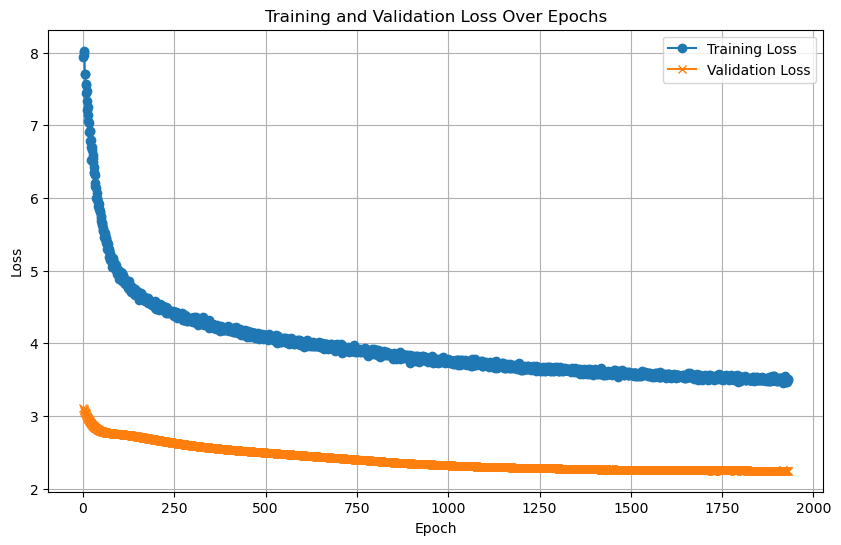

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/210], Loss: 5.2325
Test Batch [20/210], Loss: 5.5431
Test Batch [30/210], Loss: 6.0323
Test Batch [40/210], Loss: 5.9534
Test Batch [50/210], Loss: 4.3577


Test Batch [60/210], Loss: 4.4654
Test Batch [70/210], Loss: 4.7520
Test Batch [80/210], Loss: 4.7485
Test Batch [90/210], Loss: 4.8157
Test Batch [100/210], Loss: 4.8238
Test Batch [110/210], Loss: 5.1204
Test Batch [120/210], Loss: 5.6017
Test Batch [130/210], Loss: 4.5122
Test Batch [140/210], Loss: 4.4760


Test Batch [150/210], Loss: 4.3728
Test Batch [160/210], Loss: 4.8771
Test Batch [170/210], Loss: 5.1225
Test Batch [180/210], Loss: 5.1718
Test Batch [190/210], Loss: 5.2729
Test Batch [200/210], Loss: 4.8662
Test Batch [210/210], Loss: 5.2239

Test Loss: 5.0245


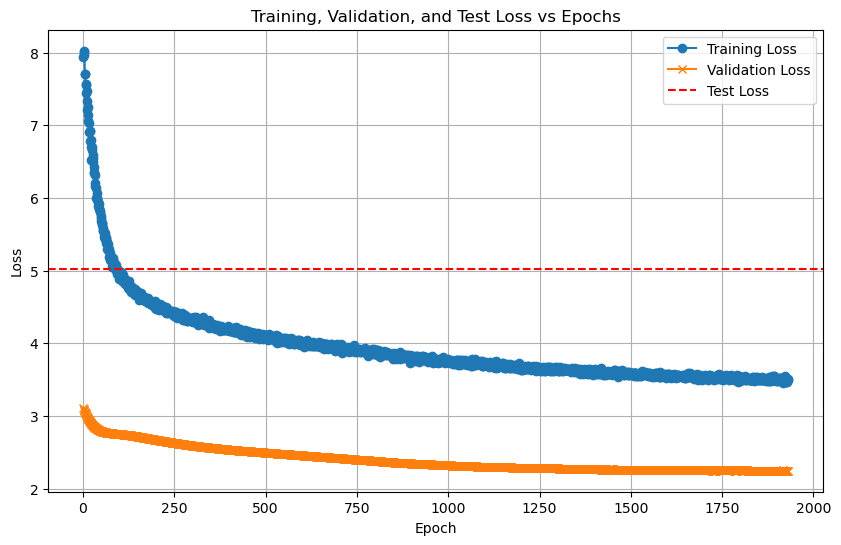

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/210 for test dataset.
  Processed batch 20/210 for test dataset.
  Processed batch 30/210 for test dataset.
  Processed batch 40/210 for test dataset.
  Processed batch 50/210 for test dataset.


  Processed batch 60/210 for test dataset.
  Processed batch 70/210 for test dataset.
  Processed batch 80/210 for test dataset.
  Processed batch 90/210 for test dataset.
  Processed batch 100/210 for test dataset.
  Processed batch 110/210 for test dataset.
  Processed batch 120/210 for test dataset.


  Processed batch 130/210 for test dataset.
  Processed batch 140/210 for test dataset.
  Processed batch 150/210 for test dataset.
  Processed batch 160/210 for test dataset.
  Processed batch 170/210 for test dataset.
  Processed batch 180/210 for test dataset.
  Processed batch 190/210 for test dataset.


  Processed batch 200/210 for test dataset.
  Processed batch 210/210 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53729, 128)
Test labels shape: (53729,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 93.75%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       0.83      1.00      0.91         5
           7       0.75      0.60      0.67         5
           8       1.00      1.00      1.00         5
           9       1.00      0.60      0.75         5
          10       0.83      1.00      0.91         5
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         5
          13       1.0

Saved CAE+LRM predictions and true labels to model_predictions


### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53729, 128)
Test labels shape: (53729,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7926  |  Val Loss: 2.7647
Validation loss improved from inf to 2.7647.
[Epoch 2/1000] Train Loss: 2.7484  |  Val Loss: 2.7244
Validation loss improved from 2.7647 to 2.7244.
[Epoch 3/1000] Train Loss: 2.7060  |  Val Loss: 2.6874
Validation loss improved from 2.7244 to 2.6874.
[Epoch 4/1000] Train Loss: 2.6682  |  Val Loss: 2.6525
Validation loss improved from 2.6874 to 2.6525.
[Epoch 5/1000] Train Loss: 2.6323  |  Val Loss: 2.6207
Validation loss improved from 2.6525 to 2.6207.
[Epoch 6/1000] Train Loss: 2.6001  |  Val Loss: 2.5920
Validation loss improved from 2.6207 to 2.5920.
[Epoch 7/1000] Train Loss: 2.5690  |  Val Loss: 2.5646
Validation loss improved from 2.5920 to 2.5646.
[Epoch 8/1000] Train Loss: 2.5388  |  Val Loss: 2.5380
Validation loss improved from 2.5646 to 2.5380.
[Epoch 9/1000] Train Loss: 2.5098  |  Val Loss: 2.5115
Validation loss improved from 2.5380 to 2.5115.
[Epoch 10/1000] Train Loss: 2.4817  |  Val Loss: 2.4851
Validation loss impr

[Epoch 12/1000] Train Loss: 2.4247  |  Val Loss: 2.4352
Validation loss improved from 2.4599 to 2.4352.
[Epoch 13/1000] Train Loss: 2.3973  |  Val Loss: 2.4104
Validation loss improved from 2.4352 to 2.4104.
[Epoch 14/1000] Train Loss: 2.3718  |  Val Loss: 2.3848
Validation loss improved from 2.4104 to 2.3848.
[Epoch 15/1000] Train Loss: 2.3437  |  Val Loss: 2.3594
Validation loss improved from 2.3848 to 2.3594.
[Epoch 16/1000] Train Loss: 2.3168  |  Val Loss: 2.3332
Validation loss improved from 2.3594 to 2.3332.
[Epoch 17/1000] Train Loss: 2.2881  |  Val Loss: 2.3076
Validation loss improved from 2.3332 to 2.3076.


[Epoch 18/1000] Train Loss: 2.2615  |  Val Loss: 2.2820
Validation loss improved from 2.3076 to 2.2820.


[Epoch 19/1000] Train Loss: 2.2350  |  Val Loss: 2.2565
Validation loss improved from 2.2820 to 2.2565.
[Epoch 20/1000] Train Loss: 2.2088  |  Val Loss: 2.2315
Validation loss improved from 2.2565 to 2.2315.
[Epoch 21/1000] Train Loss: 2.1817  |  Val Loss: 2.2070
Validation loss improved from 2.2315 to 2.2070.
[Epoch 22/1000] Train Loss: 2.1563  |  Val Loss: 2.1822
Validation loss improved from 2.2070 to 2.1822.
[Epoch 23/1000] Train Loss: 2.1311  |  Val Loss: 2.1578
Validation loss improved from 2.1822 to 2.1578.
[Epoch 24/1000] Train Loss: 2.1055  |  Val Loss: 2.1347
Validation loss improved from 2.1578 to 2.1347.
[Epoch 25/1000] Train Loss: 2.0811  |  Val Loss: 2.1121
Validation loss improved from 2.1347 to 2.1121.
[Epoch 26/1000] Train Loss: 2.0575  |  Val Loss: 2.0893
Validation loss improved from 2.1121 to 2.0893.
[Epoch 27/1000] Train Loss: 2.0332  |  Val Loss: 2.0675
Validation loss improved from 2.0893 to 2.0675.
[Epoch 28/1000] Train Loss: 2.0102  |  Val Loss: 2.0457
Validati

[Epoch 30/1000] Train Loss: 1.9650  |  Val Loss: 2.0027
Validation loss improved from 2.0241 to 2.0027.
[Epoch 31/1000] Train Loss: 1.9425  |  Val Loss: 1.9820
Validation loss improved from 2.0027 to 1.9820.
[Epoch 32/1000] Train Loss: 1.9203  |  Val Loss: 1.9620
Validation loss improved from 1.9820 to 1.9620.
[Epoch 33/1000] Train Loss: 1.9003  |  Val Loss: 1.9421
Validation loss improved from 1.9620 to 1.9421.
[Epoch 34/1000] Train Loss: 1.8795  |  Val Loss: 1.9229
Validation loss improved from 1.9421 to 1.9229.
[Epoch 35/1000] Train Loss: 1.8587  |  Val Loss: 1.9046
Validation loss improved from 1.9229 to 1.9046.
[Epoch 36/1000] Train Loss: 1.8392  |  Val Loss: 1.8859
Validation loss improved from 1.9046 to 1.8859.


[Epoch 37/1000] Train Loss: 1.8193  |  Val Loss: 1.8678
Validation loss improved from 1.8859 to 1.8678.
[Epoch 38/1000] Train Loss: 1.8008  |  Val Loss: 1.8494
Validation loss improved from 1.8678 to 1.8494.
[Epoch 39/1000] Train Loss: 1.7812  |  Val Loss: 1.8316
Validation loss improved from 1.8494 to 1.8316.
[Epoch 40/1000] Train Loss: 1.7617  |  Val Loss: 1.8142
Validation loss improved from 1.8316 to 1.8142.
[Epoch 41/1000] Train Loss: 1.7433  |  Val Loss: 1.7969
Validation loss improved from 1.8142 to 1.7969.
[Epoch 42/1000] Train Loss: 1.7251  |  Val Loss: 1.7795
Validation loss improved from 1.7969 to 1.7795.
[Epoch 43/1000] Train Loss: 1.7070  |  Val Loss: 1.7622
Validation loss improved from 1.7795 to 1.7622.
[Epoch 44/1000] Train Loss: 1.6891  |  Val Loss: 1.7451
Validation loss improved from 1.7622 to 1.7451.
[Epoch 45/1000] Train Loss: 1.6708  |  Val Loss: 1.7285
Validation loss improved from 1.7451 to 1.7285.
[Epoch 46/1000] Train Loss: 1.6532  |  Val Loss: 1.7119
Validati

[Epoch 49/1000] Train Loss: 1.6009  |  Val Loss: 1.6628
Validation loss improved from 1.6792 to 1.6628.
[Epoch 50/1000] Train Loss: 1.5837  |  Val Loss: 1.6468
Validation loss improved from 1.6628 to 1.6468.
[Epoch 51/1000] Train Loss: 1.5669  |  Val Loss: 1.6306
Validation loss improved from 1.6468 to 1.6306.
[Epoch 52/1000] Train Loss: 1.5502  |  Val Loss: 1.6144
Validation loss improved from 1.6306 to 1.6144.
[Epoch 53/1000] Train Loss: 1.5333  |  Val Loss: 1.5983
Validation loss improved from 1.6144 to 1.5983.
[Epoch 54/1000] Train Loss: 1.5167  |  Val Loss: 1.5828
Validation loss improved from 1.5983 to 1.5828.


[Epoch 55/1000] Train Loss: 1.5004  |  Val Loss: 1.5669
Validation loss improved from 1.5828 to 1.5669.
[Epoch 56/1000] Train Loss: 1.4842  |  Val Loss: 1.5511
Validation loss improved from 1.5669 to 1.5511.
[Epoch 57/1000] Train Loss: 1.4675  |  Val Loss: 1.5356
Validation loss improved from 1.5511 to 1.5356.
[Epoch 58/1000] Train Loss: 1.4516  |  Val Loss: 1.5203
Validation loss improved from 1.5356 to 1.5203.
[Epoch 59/1000] Train Loss: 1.4360  |  Val Loss: 1.5049
Validation loss improved from 1.5203 to 1.5049.
[Epoch 60/1000] Train Loss: 1.4208  |  Val Loss: 1.4895
Validation loss improved from 1.5049 to 1.4895.
[Epoch 61/1000] Train Loss: 1.4054  |  Val Loss: 1.4747
Validation loss improved from 1.4895 to 1.4747.
[Epoch 62/1000] Train Loss: 1.3905  |  Val Loss: 1.4602
Validation loss improved from 1.4747 to 1.4602.
[Epoch 63/1000] Train Loss: 1.3762  |  Val Loss: 1.4462
Validation loss improved from 1.4602 to 1.4462.
[Epoch 64/1000] Train Loss: 1.3618  |  Val Loss: 1.4315
Validati

[Epoch 68/1000] Train Loss: 1.3066  |  Val Loss: 1.3761
Validation loss improved from 1.3899 to 1.3761.
[Epoch 69/1000] Train Loss: 1.2929  |  Val Loss: 1.3628
Validation loss improved from 1.3761 to 1.3628.
[Epoch 70/1000] Train Loss: 1.2802  |  Val Loss: 1.3501
Validation loss improved from 1.3628 to 1.3501.
[Epoch 71/1000] Train Loss: 1.2671  |  Val Loss: 1.3369
Validation loss improved from 1.3501 to 1.3369.
[Epoch 72/1000] Train Loss: 1.2543  |  Val Loss: 1.3241
Validation loss improved from 1.3369 to 1.3241.
[Epoch 73/1000] Train Loss: 1.2420  |  Val Loss: 1.3111
Validation loss improved from 1.3241 to 1.3111.


[Epoch 74/1000] Train Loss: 1.2297  |  Val Loss: 1.2986
Validation loss improved from 1.3111 to 1.2986.
[Epoch 75/1000] Train Loss: 1.2179  |  Val Loss: 1.2859
Validation loss improved from 1.2986 to 1.2859.
[Epoch 76/1000] Train Loss: 1.2053  |  Val Loss: 1.2739
Validation loss improved from 1.2859 to 1.2739.
[Epoch 77/1000] Train Loss: 1.1931  |  Val Loss: 1.2620
Validation loss improved from 1.2739 to 1.2620.
[Epoch 78/1000] Train Loss: 1.1810  |  Val Loss: 1.2501
Validation loss improved from 1.2620 to 1.2501.
[Epoch 79/1000] Train Loss: 1.1688  |  Val Loss: 1.2383
Validation loss improved from 1.2501 to 1.2383.
[Epoch 80/1000] Train Loss: 1.1570  |  Val Loss: 1.2260
Validation loss improved from 1.2383 to 1.2260.
[Epoch 81/1000] Train Loss: 1.1454  |  Val Loss: 1.2141
Validation loss improved from 1.2260 to 1.2141.
[Epoch 82/1000] Train Loss: 1.1333  |  Val Loss: 1.2019
Validation loss improved from 1.2141 to 1.2019.
[Epoch 83/1000] Train Loss: 1.1220  |  Val Loss: 1.1896
Validati

[Epoch 89/1000] Train Loss: 1.0518  |  Val Loss: 1.1188
Validation loss improved from 1.1310 to 1.1188.
[Epoch 90/1000] Train Loss: 1.0405  |  Val Loss: 1.1067
Validation loss improved from 1.1188 to 1.1067.
[Epoch 91/1000] Train Loss: 1.0281  |  Val Loss: 1.0953
Validation loss improved from 1.1067 to 1.0953.
[Epoch 92/1000] Train Loss: 1.0166  |  Val Loss: 1.0844
Validation loss improved from 1.0953 to 1.0844.
[Epoch 93/1000] Train Loss: 1.0060  |  Val Loss: 1.0734
Validation loss improved from 1.0844 to 1.0734.


[Epoch 94/1000] Train Loss: 0.9937  |  Val Loss: 1.0615
Validation loss improved from 1.0734 to 1.0615.
[Epoch 95/1000] Train Loss: 0.9826  |  Val Loss: 1.0500
Validation loss improved from 1.0615 to 1.0500.
[Epoch 96/1000] Train Loss: 0.9713  |  Val Loss: 1.0382
Validation loss improved from 1.0500 to 1.0382.
[Epoch 97/1000] Train Loss: 0.9598  |  Val Loss: 1.0275
Validation loss improved from 1.0382 to 1.0275.
[Epoch 98/1000] Train Loss: 0.9482  |  Val Loss: 1.0167
Validation loss improved from 1.0275 to 1.0167.
[Epoch 99/1000] Train Loss: 0.9374  |  Val Loss: 1.0053
Validation loss improved from 1.0167 to 1.0053.
[Epoch 100/1000] Train Loss: 0.9263  |  Val Loss: 0.9940
Validation loss improved from 1.0053 to 0.9940.
[Epoch 101/1000] Train Loss: 0.9147  |  Val Loss: 0.9834
Validation loss improved from 0.9940 to 0.9834.
[Epoch 102/1000] Train Loss: 0.9045  |  Val Loss: 0.9726
Validation loss improved from 0.9834 to 0.9726.
[Epoch 103/1000] Train Loss: 0.8931  |  Val Loss: 0.9622
Vali

[Epoch 110/1000] Train Loss: 0.8176  |  Val Loss: 0.8890
Validation loss improved from 0.8986 to 0.8890.


[Epoch 111/1000] Train Loss: 0.8065  |  Val Loss: 0.8793
Validation loss improved from 0.8890 to 0.8793.
[Epoch 112/1000] Train Loss: 0.7966  |  Val Loss: 0.8690
Validation loss improved from 0.8793 to 0.8690.
[Epoch 113/1000] Train Loss: 0.7862  |  Val Loss: 0.8591
Validation loss improved from 0.8690 to 0.8591.
[Epoch 114/1000] Train Loss: 0.7761  |  Val Loss: 0.8502
Validation loss improved from 0.8591 to 0.8502.
[Epoch 115/1000] Train Loss: 0.7657  |  Val Loss: 0.8410
Validation loss improved from 0.8502 to 0.8410.
[Epoch 116/1000] Train Loss: 0.7558  |  Val Loss: 0.8316
Validation loss improved from 0.8410 to 0.8316.
[Epoch 117/1000] Train Loss: 0.7459  |  Val Loss: 0.8217
Validation loss improved from 0.8316 to 0.8217.
[Epoch 118/1000] Train Loss: 0.7359  |  Val Loss: 0.8125
Validation loss improved from 0.8217 to 0.8125.
[Epoch 119/1000] Train Loss: 0.7260  |  Val Loss: 0.8038
Validation loss improved from 0.8125 to 0.8038.
[Epoch 120/1000] Train Loss: 0.7167  |  Val Loss: 0.795

[Epoch 128/1000] Train Loss: 0.6444  |  Val Loss: 0.7288
Validation loss improved from 0.7389 to 0.7288.
[Epoch 129/1000] Train Loss: 0.6357  |  Val Loss: 0.7196
Validation loss improved from 0.7288 to 0.7196.
[Epoch 130/1000] Train Loss: 0.6284  |  Val Loss: 0.7121
Validation loss improved from 0.7196 to 0.7121.
[Epoch 131/1000] Train Loss: 0.6198  |  Val Loss: 0.7062
Validation loss improved from 0.7121 to 0.7062.
[Epoch 132/1000] Train Loss: 0.6118  |  Val Loss: 0.7002
Validation loss improved from 0.7062 to 0.7002.
[Epoch 133/1000] Train Loss: 0.6035  |  Val Loss: 0.6923
Validation loss improved from 0.7002 to 0.6923.
[Epoch 134/1000] Train Loss: 0.5955  |  Val Loss: 0.6849
Validation loss improved from 0.6923 to 0.6849.
[Epoch 135/1000] Train Loss: 0.5880  |  Val Loss: 0.6774
Validation loss improved from 0.6849 to 0.6774.
[Epoch 136/1000] Train Loss: 0.5802  |  Val Loss: 0.6706
Validation loss improved from 0.6774 to 0.6706.
[Epoch 137/1000] Train Loss: 0.5732  |  Val Loss: 0.665

[Epoch 147/1000] Train Loss: 0.5043  |  Val Loss: 0.6058
Validation loss improved from 0.6111 to 0.6058.
[Epoch 148/1000] Train Loss: 0.4987  |  Val Loss: 0.5997
Validation loss improved from 0.6058 to 0.5997.
[Epoch 149/1000] Train Loss: 0.4922  |  Val Loss: 0.5949
Validation loss improved from 0.5997 to 0.5949.
[Epoch 150/1000] Train Loss: 0.4867  |  Val Loss: 0.5899
Validation loss improved from 0.5949 to 0.5899.
[Epoch 151/1000] Train Loss: 0.4801  |  Val Loss: 0.5851
Validation loss improved from 0.5899 to 0.5851.
[Epoch 152/1000] Train Loss: 0.4743  |  Val Loss: 0.5818
Validation loss improved from 0.5851 to 0.5818.
[Epoch 153/1000] Train Loss: 0.4692  |  Val Loss: 0.5781
Validation loss improved from 0.5818 to 0.5781.
[Epoch 154/1000] Train Loss: 0.4633  |  Val Loss: 0.5716
Validation loss improved from 0.5781 to 0.5716.
[Epoch 155/1000] Train Loss: 0.4579  |  Val Loss: 0.5656
Validation loss improved from 0.5716 to 0.5656.
[Epoch 156/1000] Train Loss: 0.4526  |  Val Loss: 0.561

[Epoch 165/1000] Train Loss: 0.4075  |  Val Loss: 0.5260
Validation loss improved from 0.5294 to 0.5260.
[Epoch 166/1000] Train Loss: 0.4030  |  Val Loss: 0.5213
Validation loss improved from 0.5260 to 0.5213.
[Epoch 167/1000] Train Loss: 0.3984  |  Val Loss: 0.5174
Validation loss improved from 0.5213 to 0.5174.
[Epoch 168/1000] Train Loss: 0.3945  |  Val Loss: 0.5134
Validation loss improved from 0.5174 to 0.5134.
[Epoch 169/1000] Train Loss: 0.3899  |  Val Loss: 0.5111
Validation loss improved from 0.5134 to 0.5111.
[Epoch 170/1000] Train Loss: 0.3857  |  Val Loss: 0.5095
Validation loss improved from 0.5111 to 0.5095.
[Epoch 171/1000] Train Loss: 0.3818  |  Val Loss: 0.5061
Validation loss improved from 0.5095 to 0.5061.
[Epoch 172/1000] Train Loss: 0.3774  |  Val Loss: 0.5018
Validation loss improved from 0.5061 to 0.5018.
[Epoch 173/1000] Train Loss: 0.3733  |  Val Loss: 0.4975
Validation loss improved from 0.5018 to 0.4975.
[Epoch 174/1000] Train Loss: 0.3693  |  Val Loss: 0.495

[Epoch 184/1000] Train Loss: 0.3334  |  Val Loss: 0.4679
Validation loss improved from 0.4721 to 0.4679.
[Epoch 185/1000] Train Loss: 0.3300  |  Val Loss: 0.4658
Validation loss improved from 0.4679 to 0.4658.
[Epoch 186/1000] Train Loss: 0.3266  |  Val Loss: 0.4634
Validation loss improved from 0.4658 to 0.4634.
[Epoch 187/1000] Train Loss: 0.3241  |  Val Loss: 0.4632
Validation loss improved from 0.4634 to 0.4632.
[Epoch 188/1000] Train Loss: 0.3205  |  Val Loss: 0.4601
Validation loss improved from 0.4632 to 0.4601.
[Epoch 189/1000] Train Loss: 0.3182  |  Val Loss: 0.4589
Validation loss improved from 0.4601 to 0.4589.
[Epoch 190/1000] Train Loss: 0.3147  |  Val Loss: 0.4551
Validation loss improved from 0.4589 to 0.4551.
[Epoch 191/1000] Train Loss: 0.3119  |  Val Loss: 0.4524
Validation loss improved from 0.4551 to 0.4524.
[Epoch 192/1000] Train Loss: 0.3092  |  Val Loss: 0.4504
Validation loss improved from 0.4524 to 0.4504.
[Epoch 193/1000] Train Loss: 0.3070  |  Val Loss: 0.448

[Epoch 202/1000] Train Loss: 0.2837  |  Val Loss: 0.4340
Validation loss improved from 0.4345 to 0.4340.
[Epoch 203/1000] Train Loss: 0.2812  |  Val Loss: 0.4311
Validation loss improved from 0.4340 to 0.4311.
[Epoch 204/1000] Train Loss: 0.2788  |  Val Loss: 0.4298
Validation loss improved from 0.4311 to 0.4298.
[Epoch 205/1000] Train Loss: 0.2770  |  Val Loss: 0.4290
Validation loss improved from 0.4298 to 0.4290.
[Epoch 206/1000] Train Loss: 0.2743  |  Val Loss: 0.4271
Validation loss improved from 0.4290 to 0.4271.
[Epoch 207/1000] Train Loss: 0.2725  |  Val Loss: 0.4256
Validation loss improved from 0.4271 to 0.4256.
[Epoch 208/1000] Train Loss: 0.2698  |  Val Loss: 0.4246
Validation loss improved from 0.4256 to 0.4246.
[Epoch 209/1000] Train Loss: 0.2682  |  Val Loss: 0.4229
Validation loss improved from 0.4246 to 0.4229.
[Epoch 210/1000] Train Loss: 0.2656  |  Val Loss: 0.4221
Validation loss improved from 0.4229 to 0.4221.
[Epoch 211/1000] Train Loss: 0.2642  |  Val Loss: 0.422

[Epoch 221/1000] Train Loss: 0.2450  |  Val Loss: 0.4079
Validation loss improved from 0.4096 to 0.4079.
[Epoch 222/1000] Train Loss: 0.2433  |  Val Loss: 0.4071
Validation loss improved from 0.4079 to 0.4071.
[Epoch 223/1000] Train Loss: 0.2415  |  Val Loss: 0.4069
Validation loss improved from 0.4071 to 0.4069.
[Epoch 224/1000] Train Loss: 0.2399  |  Val Loss: 0.4062
Validation loss improved from 0.4069 to 0.4062.
[Epoch 225/1000] Train Loss: 0.2380  |  Val Loss: 0.4045
Validation loss improved from 0.4062 to 0.4045.
[Epoch 226/1000] Train Loss: 0.2366  |  Val Loss: 0.4035
Validation loss improved from 0.4045 to 0.4035.
[Epoch 227/1000] Train Loss: 0.2348  |  Val Loss: 0.4011
Validation loss improved from 0.4035 to 0.4011.
[Epoch 228/1000] Train Loss: 0.2334  |  Val Loss: 0.4000
Validation loss improved from 0.4011 to 0.4000.
[Epoch 229/1000] Train Loss: 0.2319  |  Val Loss: 0.3996
Validation loss improved from 0.4000 to 0.3996.
[Epoch 230/1000] Train Loss: 0.2305  |  Val Loss: 0.399

[Epoch 238/1000] Train Loss: 0.2194  |  Val Loss: 0.3925
Validation loss improved from 0.3930 to 0.3925.
[Epoch 239/1000] Train Loss: 0.2173  |  Val Loss: 0.3925
Validation loss improved from 0.3925 to 0.3925.
[Epoch 240/1000] Train Loss: 0.2159  |  Val Loss: 0.3926
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 241/1000] Train Loss: 0.2148  |  Val Loss: 0.3902
Validation loss improved from 0.3925 to 0.3902.
[Epoch 242/1000] Train Loss: 0.2137  |  Val Loss: 0.3891
Validation loss improved from 0.3902 to 0.3891.
[Epoch 243/1000] Train Loss: 0.2122  |  Val Loss: 0.3896
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 244/1000] Train Loss: 0.2110  |  Val Loss: 0.3880
Validation loss improved from 0.3891 to 0.3880.
[Epoch 245/1000] Train Loss: 0.2095  |  Val Loss: 0.3877
Validation loss improved from 0.3880 to 0.3877.
[Epoch 246/1000] Train Loss: 0.2083  |  Val Loss: 0.3860
Validation loss improved from 0.3877 to 0.3860.
[Epoch 247/1000] Train Loss: 0.2071  |  Val

[Epoch 259/1000] Train Loss: 0.1939  |  Val Loss: 0.3810
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 260/1000] Train Loss: 0.1929  |  Val Loss: 0.3791
Validation loss improved from 0.3804 to 0.3791.
[Epoch 261/1000] Train Loss: 0.1918  |  Val Loss: 0.3790
Validation loss improved from 0.3791 to 0.3790.
[Epoch 262/1000] Train Loss: 0.1914  |  Val Loss: 0.3775
Validation loss improved from 0.3790 to 0.3775.
[Epoch 263/1000] Train Loss: 0.1903  |  Val Loss: 0.3784
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 264/1000] Train Loss: 0.1893  |  Val Loss: 0.3779
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 265/1000] Train Loss: 0.1880  |  Val Loss: 0.3778
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 266/1000] Train Loss: 0.1872  |  Val Loss: 0.3761
Validation loss improved from 0.3775 to 0.3761.
[Epoch 267/1000] Train Loss: 0.1861  |  Val Loss: 0.3770
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 268/1000] Train Lo

[Epoch 277/1000] Train Loss: 0.1776  |  Val Loss: 0.3731
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 278/1000] Train Loss: 0.1767  |  Val Loss: 0.3731
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 279/1000] Train Loss: 0.1761  |  Val Loss: 0.3731
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 280/1000] Train Loss: 0.1754  |  Val Loss: 0.3726
Validation loss improved from 0.3727 to 0.3726.
[Epoch 281/1000] Train Loss: 0.1749  |  Val Loss: 0.3713
Validation loss improved from 0.3726 to 0.3713.
[Epoch 282/1000] Train Loss: 0.1736  |  Val Loss: 0.3709
Validation loss improved from 0.3713 to 0.3709.
[Epoch 283/1000] Train Loss: 0.1731  |  Val Loss: 0.3711
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 284/1000] Train Loss: 0.1725  |  Val Loss: 0.3704
Validation loss improved from 0.3709 to 0.3704.
[Epoch 285/1000] Train Loss: 0.1716  |  Val Loss: 0.3711
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 286/1000] Train Lo

[Epoch 296/1000] Train Loss: 0.1648  |  Val Loss: 0.3685
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 297/1000] Train Loss: 0.1641  |  Val Loss: 0.3689
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 298/1000] Train Loss: 0.1627  |  Val Loss: 0.3680
Validation loss improved from 0.3681 to 0.3680.
[Epoch 299/1000] Train Loss: 0.1621  |  Val Loss: 0.3673
Validation loss improved from 0.3680 to 0.3673.
[Epoch 300/1000] Train Loss: 0.1615  |  Val Loss: 0.3672
Validation loss improved from 0.3673 to 0.3672.
[Epoch 301/1000] Train Loss: 0.1621  |  Val Loss: 0.3679
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 302/1000] Train Loss: 0.1603  |  Val Loss: 0.3691
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 303/1000] Train Loss: 0.1602  |  Val Loss: 0.3692
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 304/1000] Train Loss: 0.1601  |  Val Loss: 0.3698
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 305/1000] Tr

[Epoch 316/1000] Train Loss: 0.1529  |  Val Loss: 0.3677
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 317/1000] Train Loss: 0.1523  |  Val Loss: 0.3670
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 318/1000] Train Loss: 0.1520  |  Val Loss: 0.3653
Validation loss improved from 0.3662 to 0.3653.
[Epoch 319/1000] Train Loss: 0.1517  |  Val Loss: 0.3663
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 320/1000] Train Loss: 0.1511  |  Val Loss: 0.3674
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 321/1000] Train Loss: 0.1505  |  Val Loss: 0.3668
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 322/1000] Train Loss: 0.1502  |  Val Loss: 0.3664
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 323/1000] Train Loss: 0.1495  |  Val Loss: 0.3683
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 324/1000] Train Loss: 0.1489  |  Val Loss: 0.3681
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch

[Epoch 336/1000] Train Loss: 0.1440  |  Val Loss: 0.3697
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 337/1000] Train Loss: 0.1433  |  Val Loss: 0.3676
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 338/1000] Train Loss: 0.1427  |  Val Loss: 0.3667
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 339/1000] Train Loss: 0.1425  |  Val Loss: 0.3656
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 340/1000] Train Loss: 0.1423  |  Val Loss: 0.3642
Validation loss improved from 0.3653 to 0.3642.
[Epoch 341/1000] Train Loss: 0.1425  |  Val Loss: 0.3667
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 342/1000] Train Loss: 0.1415  |  Val Loss: 0.3656
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 343/1000] Train Loss: 0.1410  |  Val Loss: 0.3666
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 344/1000] Train Loss: 0.1406  |  Val Loss: 0.3668
!! Validation loss did NOT improve !! Patience: 4/100
[Ep

[Epoch 354/1000] Train Loss: 0.1372  |  Val Loss: 0.3688
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 355/1000] Train Loss: 0.1382  |  Val Loss: 0.3714
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 356/1000] Train Loss: 0.1360  |  Val Loss: 0.3681
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 357/1000] Train Loss: 0.1365  |  Val Loss: 0.3645
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 358/1000] Train Loss: 0.1360  |  Val Loss: 0.3649
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 359/1000] Train Loss: 0.1362  |  Val Loss: 0.3651
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 360/1000] Train Loss: 0.1356  |  Val Loss: 0.3697
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 361/1000] Train Loss: 0.1349  |  Val Loss: 0.3696
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 362/1000] Train Loss: 0.1352  |  Val Loss: 0.3694
!! Validation loss did NOT improve !! Patience:

[Epoch 374/1000] Train Loss: 0.1309  |  Val Loss: 0.3699
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 375/1000] Train Loss: 0.1303  |  Val Loss: 0.3693
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 376/1000] Train Loss: 0.1306  |  Val Loss: 0.3681
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 377/1000] Train Loss: 0.1301  |  Val Loss: 0.3690
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 378/1000] Train Loss: 0.1296  |  Val Loss: 0.3682
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 379/1000] Train Loss: 0.1293  |  Val Loss: 0.3706
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 380/1000] Train Loss: 0.1293  |  Val Loss: 0.3706
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 381/1000] Train Loss: 0.1290  |  Val Loss: 0.3694
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 382/1000] Train Loss: 0.1283  |  Val Loss: 0.3701
!! Validation loss did NOT improve !! Patience:

[Epoch 393/1000] Train Loss: 0.1261  |  Val Loss: 0.3693
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 394/1000] Train Loss: 0.1255  |  Val Loss: 0.3705
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 395/1000] Train Loss: 0.1252  |  Val Loss: 0.3721
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 396/1000] Train Loss: 0.1247  |  Val Loss: 0.3717
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 397/1000] Train Loss: 0.1248  |  Val Loss: 0.3700
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 398/1000] Train Loss: 0.1246  |  Val Loss: 0.3702
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 399/1000] Train Loss: 0.1241  |  Val Loss: 0.3721
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 400/1000] Train Loss: 0.1241  |  Val Loss: 0.3720
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 401/1000] Train Loss: 0.1240  |  Val Loss: 0.3731
!! Validation loss did NOT improve !! Patience:

[Epoch 411/1000] Train Loss: 0.1213  |  Val Loss: 0.3727
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 412/1000] Train Loss: 0.1210  |  Val Loss: 0.3742
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 413/1000] Train Loss: 0.1209  |  Val Loss: 0.3743
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 414/1000] Train Loss: 0.1205  |  Val Loss: 0.3747
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 415/1000] Train Loss: 0.1203  |  Val Loss: 0.3742
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 416/1000] Train Loss: 0.1205  |  Val Loss: 0.3728
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 417/1000] Train Loss: 0.1206  |  Val Loss: 0.3737
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 418/1000] Train Loss: 0.1200  |  Val Loss: 0.3757
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 419/1000] Train Loss: 0.1200  |  Val Loss: 0.3780
!! Validation loss did NOT improve !! Patience:

[Epoch 430/1000] Train Loss: 0.1174  |  Val Loss: 0.3766
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 431/1000] Train Loss: 0.1178  |  Val Loss: 0.3781
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 432/1000] Train Loss: 0.1168  |  Val Loss: 0.3770
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 433/1000] Train Loss: 0.1168  |  Val Loss: 0.3773
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 434/1000] Train Loss: 0.1168  |  Val Loss: 0.3757
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 435/1000] Train Loss: 0.1168  |  Val Loss: 0.3780
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 436/1000] Train Loss: 0.1165  |  Val Loss: 0.3785
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 437/1000] Train Loss: 0.1162  |  Val Loss: 0.3787
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 438/1000] Train Loss: 0.1160  |  Val Loss: 0.3766
!! Validation loss did NOT improve !! Patience:

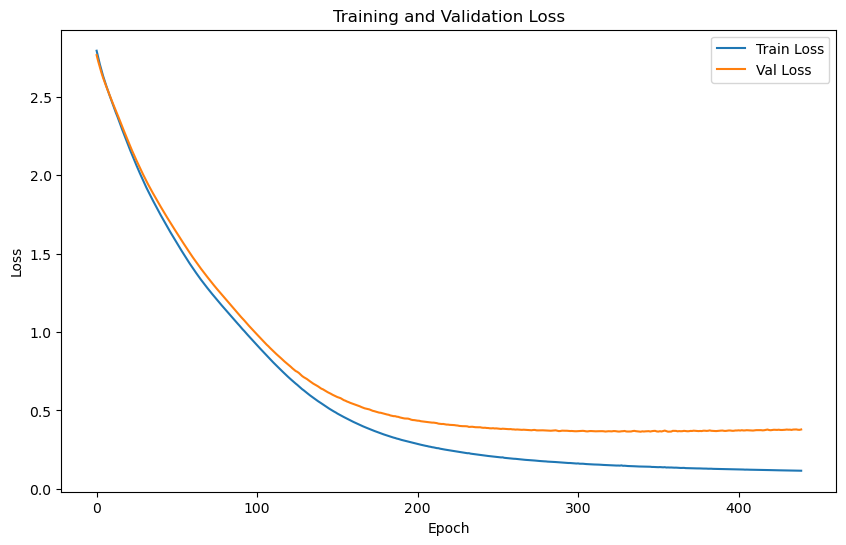

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.6399 | Test Accuracy: 81.83%


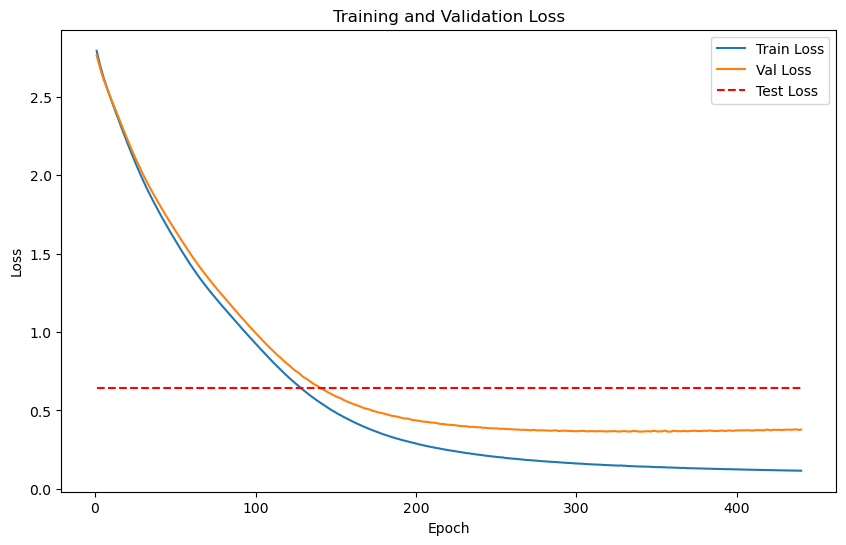

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53729 samples with 64 features each
LOG: Labels shape: (53729,)


Train embeddings shape: (320, 64), 
Train labels shape: (320,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (53729, 64), 
Test labels shape: (53729,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}
Training batch size: 320


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4667
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.3082
    Batch [2/2], Val Loss: 0.3261
Epoch [1/2000], Avg Train Loss: 0.4667, Avg Val Loss: 0.3172

Validation loss improved from inf to 0.3172. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.4646
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.3094
    Batch [2/2], Val Loss: 0.3246
Epoch [2/2000], Avg Train Loss: 0.4646, Avg Val Loss: 0.3170

Validation loss improved from 0.3172 to 0.3170. Saving model...
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4632
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.3106
    Batch [2/2], Val Loss: 0.3237
Epoch [3/2000], Avg Train Loss: 0.4632, Avg Val Loss: 0.3172

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.4645
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.3111
    Batch [2/2], Val Loss: 0.3226
Epoch [4/2000], Avg Train Loss: 0.4645, Avg Val Loss: 0.3168

Validation loss improved from 0.3170 to 0.3168. Saving model...
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.4635
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.3118
    Batch [2/2], Val Loss: 0.3213
Epoch [5/2000], Avg Train Loss: 0.4635, Avg Val Loss: 0.3165

Validation loss improved from 0.3168 to 0.3165. Saving model...
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.4615
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.3108
    Batch [2/2], Val Loss: 0.3204
Epoch [6/2000], Avg Train Loss: 0.4615, Avg Val Loss: 0.3156

Validation loss improved from 0.3165 to 0.3156. Saving model...
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.4638
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.3111
    Batch [2/2], Val Loss: 0.3200
Epoch [7/2000], Avg Train Loss: 0.4638, Avg Val Loss: 0.3156

Validation loss improved from 0.3156 to 0.3156. Saving model...
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.4608
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.3129
    Batch [2/2], Val Loss: 0.3198
Epoch [8/2000], Avg Train Loss: 0.4608, Avg Val Loss: 0.3163

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.4611
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.3148
    Batch [2/2], Val Loss: 0.3191
Epoch [9/2000], Avg Train Loss: 0.4611, Avg Val Loss: 0.3169

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.4578
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.3157
    Batch [2/2], Val Loss: 0.3179
Epoch [10/2000], Avg Train Loss: 0.4578, Avg Val Loss: 0.3168

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.4584
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.3159
    Batch [2/2], Val Loss: 0.3156
Epoch [11/2000], Avg Train Loss: 0.4584, Avg Val Loss: 0.3157

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4535
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.3160
    Batch [2/2], Val Loss: 0.3130
Epoch [12/2000], Avg Train Loss: 0.4535, Avg Val Loss: 0.3145

Validation loss improved from 0.3156 to 0.3145. Saving model...
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.4575
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.3162
    Batch [2/2], Val Loss: 0.3102
Epoch [13/2000], Avg Train Loss: 0.4575, Avg Val Loss: 0.3132

Validation loss improved from 0.3145 to 0.3132. Saving model...
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.4593
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.3155
    Batch [2/2], Val Loss: 0.3072
Epoch [14/2000], Avg Train Loss: 0.4593, Avg Val Loss: 0.3113

Validation loss improved from 0.3132 to 0.3113. Saving model...
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4567
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.3145
    Batch [2/2], Val Loss: 0.3048
Epoch [15/2000], Avg Train Loss: 0.4567, Avg Val Loss: 0.3097

Validation loss improved from 0.3113 to 0.3097. Saving model...
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.4557
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.3140
    Batch [2/2], Val Loss: 0.3031
Epoch [16/2000], Avg Train Loss: 0.4557, Avg Val Loss: 0.3085

Validation loss improved from 0.3097 to 0.3085. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4516
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.3135
    Batch [2/2], Val Loss: 0.3015
Epoch [17/2000], Avg Train Loss: 0.4516, Avg Val Loss: 0.3075

Validation loss improved from 0.3085 to 0.3075. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.4543
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.3132
    Batch [2/2], Val Loss: 0.3000
Epoch [18/2000], Avg Train Loss: 0.4543, Avg Val Loss: 0.3066

Validation loss improved from 0.3075 to 0.3066. Saving model...
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.4532
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.3130
    Batch [2/2], Val Loss: 0.2985
Epoch [19/2000], Avg Train Loss: 0.4532, Avg Val Loss: 0.3057

Validation loss improved from 0.3066 to 0.3057. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.4552
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.3125
    Batch [2/2], Val Loss: 0.2971
Epoch [20/2000], Avg Train Loss: 0.4552, Avg Val Loss: 0.3048

Validation loss improved from 0.3057 to 0.3048. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.4501
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.3119
    Batch [2/2], Val Loss: 0.2956
Epoch [21/2000], Avg Train Loss: 0.4501, Avg Val Loss: 0.3038

Validation loss improved from 0.3048 to 0.3038. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.4537
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.3114
    Batch [2/2], Val Loss: 0.2943
Epoch [22/2000], Avg Train Loss: 0.4537, Avg Val Loss: 0.3028

Validation loss improved from 0.3038 to 0.3028. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4510
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.3109
    Batch [2/2], Val Loss: 0.2931
Epoch [23/2000], Avg Train Loss: 0.4510, Avg Val Loss: 0.3020

Validation loss improved from 0.3028 to 0.3020. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.4514
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.3102
    Batch [2/2], Val Loss: 0.2920
Epoch [24/2000], Avg Train Loss: 0.4514, Avg Val Loss: 0.3011

Validation loss improved from 0.3020 to 0.3011. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.4479
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.3096
    Batch [2/2], Val Loss: 0.2908
Epoch [25/2000], Avg Train Loss: 0.4479, Avg Val Loss: 0.3002

Validation loss improved from 0.3011 to 0.3002. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.4479
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.3090
    Batch [2/2], Val Loss: 0.2896
Epoch [26/2000], Avg Train Loss: 0.4479, Avg Val Loss: 0.2993

Validation loss improved from 0.3002 to 0.2993. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.4470
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.3084
    Batch [2/2], Val Loss: 0.2885
Epoch [27/2000], Avg Train Loss: 0.4470, Avg Val Loss: 0.2985

Validation loss improved from 0.2993 to 0.2985. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.4476
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.3079
    Batch [2/2], Val Loss: 0.2875
Epoch [28/2000], Avg Train Loss: 0.4476, Avg Val Loss: 0.2977

Validation loss improved from 0.2985 to 0.2977. Saving model...
LOG: Epoch [29/2000] - Training


    Batch [1/1], Train Loss: 0.4475
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.3072
    Batch [2/2], Val Loss: 0.2864
Epoch [29/2000], Avg Train Loss: 0.4475, Avg Val Loss: 0.2968

Validation loss improved from 0.2977 to 0.2968. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.4457
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.3066
    Batch [2/2], Val Loss: 0.2855
Epoch [30/2000], Avg Train Loss: 0.4457, Avg Val Loss: 0.2960

Validation loss improved from 0.2968 to 0.2960. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.4440
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.3059
    Batch [2/2], Val Loss: 0.2845
Epoch [31/2000], Avg Train Loss: 0.4440, Avg Val Loss: 0.2952

Validation loss improved from 0.2960 to 0.2952. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.4474
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.3052
    Batch [2/2], Val Loss: 0.2837
Epoch [32/2000], Avg Train Loss: 0.4474, Avg Val Loss: 0.2944

Validation loss improved from 0.2952 to 0.2944. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.4420
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.3045
    Batch [2/2], Val Loss: 0.2830
Epoch [33/2000], Avg Train Loss: 0.4420, Avg Val Loss: 0.2938

Validation loss improved from 0.2944 to 0.2938. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.4448
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.3038
    Batch [2/2], Val Loss: 0.2824
Epoch [34/2000], Avg Train Loss: 0.4448, Avg Val Loss: 0.2931

Validation loss improved from 0.2938 to 0.2931. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.4428
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.3032
    Batch [2/2], Val Loss: 0.2818
Epoch [35/2000], Avg Train Loss: 0.4428, Avg Val Loss: 0.2925

Validation loss improved from 0.2931 to 0.2925. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.4403
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.3026
    Batch [2/2], Val Loss: 0.2813
Epoch [36/2000], Avg Train Loss: 0.4403, Avg Val Loss: 0.2919

Validation loss improved from 0.2925 to 0.2919. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.4447
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.3021
    Batch [2/2], Val Loss: 0.2807
Epoch [37/2000], Avg Train Loss: 0.4447, Avg Val Loss: 0.2914

Validation loss improved from 0.2919 to 0.2914. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.4458
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.3015
    Batch [2/2], Val Loss: 0.2802
Epoch [38/2000], Avg Train Loss: 0.4458, Avg Val Loss: 0.2908

Validation loss improved from 0.2914 to 0.2908. Saving model...
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.4458
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.3009
    Batch [2/2], Val Loss: 0.2796
Epoch [39/2000], Avg Train Loss: 0.4458, Avg Val Loss: 0.2903

Validation loss improved from 0.2908 to 0.2903. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.4410
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.3004
    Batch [2/2], Val Loss: 0.2790
Epoch [40/2000], Avg Train Loss: 0.4410, Avg Val Loss: 0.2897

Validation loss improved from 0.2903 to 0.2897. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.4415
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.2998
    Batch [2/2], Val Loss: 0.2785
Epoch [41/2000], Avg Train Loss: 0.4415, Avg Val Loss: 0.2892

Validation loss improved from 0.2897 to 0.2892. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.4375
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.2993
    Batch [2/2], Val Loss: 0.2779
Epoch [42/2000], Avg Train Loss: 0.4375, Avg Val Loss: 0.2886

Validation loss improved from 0.2892 to 0.2886. Saving model...
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.4406
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.2988
    Batch [2/2], Val Loss: 0.2774
Epoch [43/2000], Avg Train Loss: 0.4406, Avg Val Loss: 0.2881

Validation loss improved from 0.2886 to 0.2881. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.4395
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.2983
    Batch [2/2], Val Loss: 0.2768
Epoch [44/2000], Avg Train Loss: 0.4395, Avg Val Loss: 0.2876

Validation loss improved from 0.2881 to 0.2876. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.4382
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.2979
    Batch [2/2], Val Loss: 0.2763
Epoch [45/2000], Avg Train Loss: 0.4382, Avg Val Loss: 0.2871

Validation loss improved from 0.2876 to 0.2871. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.4406
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.2974
    Batch [2/2], Val Loss: 0.2758
Epoch [46/2000], Avg Train Loss: 0.4406, Avg Val Loss: 0.2866

Validation loss improved from 0.2871 to 0.2866. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.4354
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.2969
    Batch [2/2], Val Loss: 0.2753
Epoch [47/2000], Avg Train Loss: 0.4354, Avg Val Loss: 0.2861

Validation loss improved from 0.2866 to 0.2861. Saving model...
LOG: Epoch [48/2000] - Training


    Batch [1/1], Train Loss: 0.4349
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.2965
    Batch [2/2], Val Loss: 0.2747
Epoch [48/2000], Avg Train Loss: 0.4349, Avg Val Loss: 0.2856

Validation loss improved from 0.2861 to 0.2856. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.4381
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.2960
    Batch [2/2], Val Loss: 0.2742
Epoch [49/2000], Avg Train Loss: 0.4381, Avg Val Loss: 0.2851

Validation loss improved from 0.2856 to 0.2851. Saving model...
LOG: Epoch [50/2000] - Training


    Batch [1/1], Train Loss: 0.4374
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.2955
    Batch [2/2], Val Loss: 0.2738
Epoch [50/2000], Avg Train Loss: 0.4374, Avg Val Loss: 0.2846

Validation loss improved from 0.2851 to 0.2846. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.4347
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.2950
    Batch [2/2], Val Loss: 0.2733
Epoch [51/2000], Avg Train Loss: 0.4347, Avg Val Loss: 0.2841

Validation loss improved from 0.2846 to 0.2841. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.4331
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.2944
    Batch [2/2], Val Loss: 0.2727
Epoch [52/2000], Avg Train Loss: 0.4331, Avg Val Loss: 0.2836

Validation loss improved from 0.2841 to 0.2836. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.4349
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.2939
    Batch [2/2], Val Loss: 0.2721
Epoch [53/2000], Avg Train Loss: 0.4349, Avg Val Loss: 0.2830

Validation loss improved from 0.2836 to 0.2830. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.4332
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.2934
    Batch [2/2], Val Loss: 0.2715
Epoch [54/2000], Avg Train Loss: 0.4332, Avg Val Loss: 0.2825

Validation loss improved from 0.2830 to 0.2825. Saving model...
LOG: Epoch [55/2000] - Training


    Batch [1/1], Train Loss: 0.4352
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.2929
    Batch [2/2], Val Loss: 0.2709
Epoch [55/2000], Avg Train Loss: 0.4352, Avg Val Loss: 0.2819

Validation loss improved from 0.2825 to 0.2819. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.4360
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.2924
    Batch [2/2], Val Loss: 0.2702
Epoch [56/2000], Avg Train Loss: 0.4360, Avg Val Loss: 0.2813

Validation loss improved from 0.2819 to 0.2813. Saving model...
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.4353
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.2919
    Batch [2/2], Val Loss: 0.2696
Epoch [57/2000], Avg Train Loss: 0.4353, Avg Val Loss: 0.2808

Validation loss improved from 0.2813 to 0.2808. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.4316
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.2914
    Batch [2/2], Val Loss: 0.2691
Epoch [58/2000], Avg Train Loss: 0.4316, Avg Val Loss: 0.2803

Validation loss improved from 0.2808 to 0.2803. Saving model...
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.4312
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.2909
    Batch [2/2], Val Loss: 0.2685
Epoch [59/2000], Avg Train Loss: 0.4312, Avg Val Loss: 0.2797

Validation loss improved from 0.2803 to 0.2797. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.4311
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.2904
    Batch [2/2], Val Loss: 0.2680
Epoch [60/2000], Avg Train Loss: 0.4311, Avg Val Loss: 0.2792

Validation loss improved from 0.2797 to 0.2792. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.4342
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.2899
    Batch [2/2], Val Loss: 0.2674
Epoch [61/2000], Avg Train Loss: 0.4342, Avg Val Loss: 0.2787

Validation loss improved from 0.2792 to 0.2787. Saving model...
LOG: Epoch [62/2000] - Training


    Batch [1/1], Train Loss: 0.4314
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.2894
    Batch [2/2], Val Loss: 0.2669
Epoch [62/2000], Avg Train Loss: 0.4314, Avg Val Loss: 0.2781

Validation loss improved from 0.2787 to 0.2781. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.4317
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.2888
    Batch [2/2], Val Loss: 0.2664
Epoch [63/2000], Avg Train Loss: 0.4317, Avg Val Loss: 0.2776

Validation loss improved from 0.2781 to 0.2776. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.4306
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.2882
    Batch [2/2], Val Loss: 0.2659
Epoch [64/2000], Avg Train Loss: 0.4306, Avg Val Loss: 0.2771

Validation loss improved from 0.2776 to 0.2771. Saving model...
LOG: Epoch [65/2000] - Training


    Batch [1/1], Train Loss: 0.4322
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.2876
    Batch [2/2], Val Loss: 0.2655
Epoch [65/2000], Avg Train Loss: 0.4322, Avg Val Loss: 0.2765

Validation loss improved from 0.2771 to 0.2765. Saving model...
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.4311
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.2870
    Batch [2/2], Val Loss: 0.2650
Epoch [66/2000], Avg Train Loss: 0.4311, Avg Val Loss: 0.2760

Validation loss improved from 0.2765 to 0.2760. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.4294
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.2865
    Batch [2/2], Val Loss: 0.2646
Epoch [67/2000], Avg Train Loss: 0.4294, Avg Val Loss: 0.2755

Validation loss improved from 0.2760 to 0.2755. Saving model...
LOG: Epoch [68/2000] - Training


    Batch [1/1], Train Loss: 0.4269
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.2859
    Batch [2/2], Val Loss: 0.2641
Epoch [68/2000], Avg Train Loss: 0.4269, Avg Val Loss: 0.2750

Validation loss improved from 0.2755 to 0.2750. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.4248
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.2854
    Batch [2/2], Val Loss: 0.2635
Epoch [69/2000], Avg Train Loss: 0.4248, Avg Val Loss: 0.2744

Validation loss improved from 0.2750 to 0.2744. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.4260
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.2848
    Batch [2/2], Val Loss: 0.2631
Epoch [70/2000], Avg Train Loss: 0.4260, Avg Val Loss: 0.2739

Validation loss improved from 0.2744 to 0.2739. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.4257
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.2843
    Batch [2/2], Val Loss: 0.2625
Epoch [71/2000], Avg Train Loss: 0.4257, Avg Val Loss: 0.2734

Validation loss improved from 0.2739 to 0.2734. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.4270
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.2838
    Batch [2/2], Val Loss: 0.2621
Epoch [72/2000], Avg Train Loss: 0.4270, Avg Val Loss: 0.2729

Validation loss improved from 0.2734 to 0.2729. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.4250
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.2833
    Batch [2/2], Val Loss: 0.2615
Epoch [73/2000], Avg Train Loss: 0.4250, Avg Val Loss: 0.2724

Validation loss improved from 0.2729 to 0.2724. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.4281
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.2829
    Batch [2/2], Val Loss: 0.2611
Epoch [74/2000], Avg Train Loss: 0.4281, Avg Val Loss: 0.2720

Validation loss improved from 0.2724 to 0.2720. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.4268
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.2824
    Batch [2/2], Val Loss: 0.2605
Epoch [75/2000], Avg Train Loss: 0.4268, Avg Val Loss: 0.2714

Validation loss improved from 0.2720 to 0.2714. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.4229
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.2820
    Batch [2/2], Val Loss: 0.2599
Epoch [76/2000], Avg Train Loss: 0.4229, Avg Val Loss: 0.2709

Validation loss improved from 0.2714 to 0.2709. Saving model...
LOG: Epoch [77/2000] - Training


    Batch [1/1], Train Loss: 0.4243
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.2815
    Batch [2/2], Val Loss: 0.2593
Epoch [77/2000], Avg Train Loss: 0.4243, Avg Val Loss: 0.2704

Validation loss improved from 0.2709 to 0.2704. Saving model...
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.4196
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.2811
    Batch [2/2], Val Loss: 0.2587
Epoch [78/2000], Avg Train Loss: 0.4196, Avg Val Loss: 0.2699

Validation loss improved from 0.2704 to 0.2699. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.4232
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.2806
    Batch [2/2], Val Loss: 0.2581
Epoch [79/2000], Avg Train Loss: 0.4232, Avg Val Loss: 0.2693

Validation loss improved from 0.2699 to 0.2693. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.4202
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.2801
    Batch [2/2], Val Loss: 0.2576
Epoch [80/2000], Avg Train Loss: 0.4202, Avg Val Loss: 0.2688

Validation loss improved from 0.2693 to 0.2688. Saving model...
LOG: Epoch [81/2000] - Training


    Batch [1/1], Train Loss: 0.4252
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.2796
    Batch [2/2], Val Loss: 0.2570
Epoch [81/2000], Avg Train Loss: 0.4252, Avg Val Loss: 0.2683

Validation loss improved from 0.2688 to 0.2683. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.4203
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.2791
    Batch [2/2], Val Loss: 0.2565
Epoch [82/2000], Avg Train Loss: 0.4203, Avg Val Loss: 0.2678

Validation loss improved from 0.2683 to 0.2678. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.4181
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.2785
    Batch [2/2], Val Loss: 0.2560
Epoch [83/2000], Avg Train Loss: 0.4181, Avg Val Loss: 0.2672

Validation loss improved from 0.2678 to 0.2672. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.4209
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.2780
    Batch [2/2], Val Loss: 0.2555
Epoch [84/2000], Avg Train Loss: 0.4209, Avg Val Loss: 0.2668

Validation loss improved from 0.2672 to 0.2668. Saving model...
LOG: Epoch [85/2000] - Training


    Batch [1/1], Train Loss: 0.4182
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.2775
    Batch [2/2], Val Loss: 0.2550
Epoch [85/2000], Avg Train Loss: 0.4182, Avg Val Loss: 0.2663

Validation loss improved from 0.2668 to 0.2663. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.4186
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.2770
    Batch [2/2], Val Loss: 0.2544
Epoch [86/2000], Avg Train Loss: 0.4186, Avg Val Loss: 0.2657

Validation loss improved from 0.2663 to 0.2657. Saving model...
LOG: Epoch [87/2000] - Training


    Batch [1/1], Train Loss: 0.4218
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.2765
    Batch [2/2], Val Loss: 0.2540
Epoch [87/2000], Avg Train Loss: 0.4218, Avg Val Loss: 0.2652

Validation loss improved from 0.2657 to 0.2652. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.4226
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.2760
    Batch [2/2], Val Loss: 0.2534
Epoch [88/2000], Avg Train Loss: 0.4226, Avg Val Loss: 0.2647

Validation loss improved from 0.2652 to 0.2647. Saving model...
LOG: Epoch [89/2000] - Training


    Batch [1/1], Train Loss: 0.4195
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.2755
    Batch [2/2], Val Loss: 0.2529
Epoch [89/2000], Avg Train Loss: 0.4195, Avg Val Loss: 0.2642

Validation loss improved from 0.2647 to 0.2642. Saving model...
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.4149
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.2750
    Batch [2/2], Val Loss: 0.2523
Epoch [90/2000], Avg Train Loss: 0.4149, Avg Val Loss: 0.2637

Validation loss improved from 0.2642 to 0.2637. Saving model...
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.4168
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.2746
    Batch [2/2], Val Loss: 0.2518
Epoch [91/2000], Avg Train Loss: 0.4168, Avg Val Loss: 0.2632

Validation loss improved from 0.2637 to 0.2632. Saving model...
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.4188
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.2742
    Batch [2/2], Val Loss: 0.2513
Epoch [92/2000], Avg Train Loss: 0.4188, Avg Val Loss: 0.2627

Validation loss improved from 0.2632 to 0.2627. Saving model...
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.4152
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.2738
    Batch [2/2], Val Loss: 0.2507
Epoch [93/2000], Avg Train Loss: 0.4152, Avg Val Loss: 0.2622

Validation loss improved from 0.2627 to 0.2622. Saving model...
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.4103
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.2733
    Batch [2/2], Val Loss: 0.2502
Epoch [94/2000], Avg Train Loss: 0.4103, Avg Val Loss: 0.2617

Validation loss improved from 0.2622 to 0.2617. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.4124
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.2729
    Batch [2/2], Val Loss: 0.2497
Epoch [95/2000], Avg Train Loss: 0.4124, Avg Val Loss: 0.2613

Validation loss improved from 0.2617 to 0.2613. Saving model...
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.4131
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.2725
    Batch [2/2], Val Loss: 0.2494
Epoch [96/2000], Avg Train Loss: 0.4131, Avg Val Loss: 0.2609

Validation loss improved from 0.2613 to 0.2609. Saving model...
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.4151
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.2721
    Batch [2/2], Val Loss: 0.2490
Epoch [97/2000], Avg Train Loss: 0.4151, Avg Val Loss: 0.2605

Validation loss improved from 0.2609 to 0.2605. Saving model...
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.4114
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.2717
    Batch [2/2], Val Loss: 0.2485
Epoch [98/2000], Avg Train Loss: 0.4114, Avg Val Loss: 0.2601

Validation loss improved from 0.2605 to 0.2601. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.4126
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.2713
    Batch [2/2], Val Loss: 0.2480
Epoch [99/2000], Avg Train Loss: 0.4126, Avg Val Loss: 0.2596

Validation loss improved from 0.2601 to 0.2596. Saving model...
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.4116
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.2708
    Batch [2/2], Val Loss: 0.2474
Epoch [100/2000], Avg Train Loss: 0.4116, Avg Val Loss: 0.2591

Validation loss improved from 0.2596 to 0.2591. Saving model...
LOG: Epoch [101/2000] - Training


    Batch [1/1], Train Loss: 0.4109
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.2704
    Batch [2/2], Val Loss: 0.2468
Epoch [101/2000], Avg Train Loss: 0.4109, Avg Val Loss: 0.2586

Validation loss improved from 0.2591 to 0.2586. Saving model...
LOG: Epoch [102/2000] - Training


    Batch [1/1], Train Loss: 0.4105
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.2700
    Batch [2/2], Val Loss: 0.2462
Epoch [102/2000], Avg Train Loss: 0.4105, Avg Val Loss: 0.2581

Validation loss improved from 0.2586 to 0.2581. Saving model...
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.4123
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.2696
    Batch [2/2], Val Loss: 0.2456
Epoch [103/2000], Avg Train Loss: 0.4123, Avg Val Loss: 0.2576

Validation loss improved from 0.2581 to 0.2576. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.4103
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.2692
    Batch [2/2], Val Loss: 0.2451
Epoch [104/2000], Avg Train Loss: 0.4103, Avg Val Loss: 0.2572

Validation loss improved from 0.2576 to 0.2572. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/1], Train Loss: 0.4081
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.2688
    Batch [2/2], Val Loss: 0.2447
Epoch [105/2000], Avg Train Loss: 0.4081, Avg Val Loss: 0.2567

Validation loss improved from 0.2572 to 0.2567. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.4118
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.2683
    Batch [2/2], Val Loss: 0.2444
Epoch [106/2000], Avg Train Loss: 0.4118, Avg Val Loss: 0.2564

Validation loss improved from 0.2567 to 0.2564. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/1], Train Loss: 0.4111
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.2679
    Batch [2/2], Val Loss: 0.2440
Epoch [107/2000], Avg Train Loss: 0.4111, Avg Val Loss: 0.2560

Validation loss improved from 0.2564 to 0.2560. Saving model...
LOG: Epoch [108/2000] - Training


    Batch [1/1], Train Loss: 0.4095
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.2675
    Batch [2/2], Val Loss: 0.2438
Epoch [108/2000], Avg Train Loss: 0.4095, Avg Val Loss: 0.2556

Validation loss improved from 0.2560 to 0.2556. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/1], Train Loss: 0.4082
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.2671
    Batch [2/2], Val Loss: 0.2435
Epoch [109/2000], Avg Train Loss: 0.4082, Avg Val Loss: 0.2553

Validation loss improved from 0.2556 to 0.2553. Saving model...
LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 0.4074
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.2667
    Batch [2/2], Val Loss: 0.2434
Epoch [110/2000], Avg Train Loss: 0.4074, Avg Val Loss: 0.2550

Validation loss improved from 0.2553 to 0.2550. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/1], Train Loss: 0.4050
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.2663
    Batch [2/2], Val Loss: 0.2432
Epoch [111/2000], Avg Train Loss: 0.4050, Avg Val Loss: 0.2548

Validation loss improved from 0.2550 to 0.2548. Saving model...
LOG: Epoch [112/2000] - Training


    Batch [1/1], Train Loss: 0.4066
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.2660
    Batch [2/2], Val Loss: 0.2431
Epoch [112/2000], Avg Train Loss: 0.4066, Avg Val Loss: 0.2545

Validation loss improved from 0.2548 to 0.2545. Saving model...
LOG: Epoch [113/2000] - Training


    Batch [1/1], Train Loss: 0.4016
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.2656
    Batch [2/2], Val Loss: 0.2428
Epoch [113/2000], Avg Train Loss: 0.4016, Avg Val Loss: 0.2542

Validation loss improved from 0.2545 to 0.2542. Saving model...
LOG: Epoch [114/2000] - Training


    Batch [1/1], Train Loss: 0.4035
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.2652
    Batch [2/2], Val Loss: 0.2425
Epoch [114/2000], Avg Train Loss: 0.4035, Avg Val Loss: 0.2539

Validation loss improved from 0.2542 to 0.2539. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/1], Train Loss: 0.4059
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.2649
    Batch [2/2], Val Loss: 0.2422
Epoch [115/2000], Avg Train Loss: 0.4059, Avg Val Loss: 0.2535

Validation loss improved from 0.2539 to 0.2535. Saving model...
LOG: Epoch [116/2000] - Training


    Batch [1/1], Train Loss: 0.4045
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.2645
    Batch [2/2], Val Loss: 0.2418
Epoch [116/2000], Avg Train Loss: 0.4045, Avg Val Loss: 0.2532

Validation loss improved from 0.2535 to 0.2532. Saving model...
LOG: Epoch [117/2000] - Training


    Batch [1/1], Train Loss: 0.4034
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.2642
    Batch [2/2], Val Loss: 0.2414
Epoch [117/2000], Avg Train Loss: 0.4034, Avg Val Loss: 0.2528

Validation loss improved from 0.2532 to 0.2528. Saving model...
LOG: Epoch [118/2000] - Training


    Batch [1/1], Train Loss: 0.4052
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.2638
    Batch [2/2], Val Loss: 0.2411
Epoch [118/2000], Avg Train Loss: 0.4052, Avg Val Loss: 0.2525

Validation loss improved from 0.2528 to 0.2525. Saving model...
LOG: Epoch [119/2000] - Training


    Batch [1/1], Train Loss: 0.4033
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.2634
    Batch [2/2], Val Loss: 0.2407
Epoch [119/2000], Avg Train Loss: 0.4033, Avg Val Loss: 0.2521

Validation loss improved from 0.2525 to 0.2521. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/1], Train Loss: 0.4056
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.2631
    Batch [2/2], Val Loss: 0.2404
Epoch [120/2000], Avg Train Loss: 0.4056, Avg Val Loss: 0.2517

Validation loss improved from 0.2521 to 0.2517. Saving model...
LOG: Epoch [121/2000] - Training


    Batch [1/1], Train Loss: 0.3997
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.2627
    Batch [2/2], Val Loss: 0.2401
Epoch [121/2000], Avg Train Loss: 0.3997, Avg Val Loss: 0.2514

Validation loss improved from 0.2517 to 0.2514. Saving model...
LOG: Epoch [122/2000] - Training


    Batch [1/1], Train Loss: 0.4001
LOG: Epoch [122/2000] - Validation
    Batch [1/2], Val Loss: 0.2623
    Batch [2/2], Val Loss: 0.2398
Epoch [122/2000], Avg Train Loss: 0.4001, Avg Val Loss: 0.2511

Validation loss improved from 0.2514 to 0.2511. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/1], Train Loss: 0.4035
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.2620
    Batch [2/2], Val Loss: 0.2395
Epoch [123/2000], Avg Train Loss: 0.4035, Avg Val Loss: 0.2508

Validation loss improved from 0.2511 to 0.2508. Saving model...
LOG: Epoch [124/2000] - Training


    Batch [1/1], Train Loss: 0.3997
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.2616
    Batch [2/2], Val Loss: 0.2393
Epoch [124/2000], Avg Train Loss: 0.3997, Avg Val Loss: 0.2505

Validation loss improved from 0.2508 to 0.2505. Saving model...
LOG: Epoch [125/2000] - Training


    Batch [1/1], Train Loss: 0.3942
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.2613
    Batch [2/2], Val Loss: 0.2390
Epoch [125/2000], Avg Train Loss: 0.3942, Avg Val Loss: 0.2502

Validation loss improved from 0.2505 to 0.2502. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.3979
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.2609
    Batch [2/2], Val Loss: 0.2389
Epoch [126/2000], Avg Train Loss: 0.3979, Avg Val Loss: 0.2499

Validation loss improved from 0.2502 to 0.2499. Saving model...
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.4007
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.2605
    Batch [2/2], Val Loss: 0.2388
Epoch [127/2000], Avg Train Loss: 0.4007, Avg Val Loss: 0.2496

Validation loss improved from 0.2499 to 0.2496. Saving model...
LOG: Epoch [128/2000] - Training


    Batch [1/1], Train Loss: 0.3980
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.2601
    Batch [2/2], Val Loss: 0.2387
Epoch [128/2000], Avg Train Loss: 0.3980, Avg Val Loss: 0.2494

Validation loss improved from 0.2496 to 0.2494. Saving model...
LOG: Epoch [129/2000] - Training


    Batch [1/1], Train Loss: 0.3937
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.2598
    Batch [2/2], Val Loss: 0.2387
Epoch [129/2000], Avg Train Loss: 0.3937, Avg Val Loss: 0.2492

Validation loss improved from 0.2494 to 0.2492. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/1], Train Loss: 0.4000
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.2595
    Batch [2/2], Val Loss: 0.2386
Epoch [130/2000], Avg Train Loss: 0.4000, Avg Val Loss: 0.2491

Validation loss improved from 0.2492 to 0.2491. Saving model...
LOG: Epoch [131/2000] - Training


    Batch [1/1], Train Loss: 0.3955
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.2592
    Batch [2/2], Val Loss: 0.2384
Epoch [131/2000], Avg Train Loss: 0.3955, Avg Val Loss: 0.2488

Validation loss improved from 0.2491 to 0.2488. Saving model...
LOG: Epoch [132/2000] - Training


    Batch [1/1], Train Loss: 0.3976
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.2590
    Batch [2/2], Val Loss: 0.2383
Epoch [132/2000], Avg Train Loss: 0.3976, Avg Val Loss: 0.2486

Validation loss improved from 0.2488 to 0.2486. Saving model...
LOG: Epoch [133/2000] - Training


    Batch [1/1], Train Loss: 0.3938
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.2587
    Batch [2/2], Val Loss: 0.2381
Epoch [133/2000], Avg Train Loss: 0.3938, Avg Val Loss: 0.2484

Validation loss improved from 0.2486 to 0.2484. Saving model...
LOG: Epoch [134/2000] - Training


    Batch [1/1], Train Loss: 0.3956
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.2584
    Batch [2/2], Val Loss: 0.2379
Epoch [134/2000], Avg Train Loss: 0.3956, Avg Val Loss: 0.2482

Validation loss improved from 0.2484 to 0.2482. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/1], Train Loss: 0.3946
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.2580
    Batch [2/2], Val Loss: 0.2376
Epoch [135/2000], Avg Train Loss: 0.3946, Avg Val Loss: 0.2478

Validation loss improved from 0.2482 to 0.2478. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/1], Train Loss: 0.3915
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.2577
    Batch [2/2], Val Loss: 0.2373
Epoch [136/2000], Avg Train Loss: 0.3915, Avg Val Loss: 0.2475

Validation loss improved from 0.2478 to 0.2475. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/1], Train Loss: 0.3952
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.2574
    Batch [2/2], Val Loss: 0.2369
Epoch [137/2000], Avg Train Loss: 0.3952, Avg Val Loss: 0.2472

Validation loss improved from 0.2475 to 0.2472. Saving model...
LOG: Epoch [138/2000] - Training


    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.2570
    Batch [2/2], Val Loss: 0.2365
Epoch [138/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.2468

Validation loss improved from 0.2472 to 0.2468. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/1], Train Loss: 0.3936
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.2567
    Batch [2/2], Val Loss: 0.2362
Epoch [139/2000], Avg Train Loss: 0.3936, Avg Val Loss: 0.2464

Validation loss improved from 0.2468 to 0.2464. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/1], Train Loss: 0.3899
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.2564
    Batch [2/2], Val Loss: 0.2358
Epoch [140/2000], Avg Train Loss: 0.3899, Avg Val Loss: 0.2461

Validation loss improved from 0.2464 to 0.2461. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/1], Train Loss: 0.3911
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.2560
    Batch [2/2], Val Loss: 0.2355
Epoch [141/2000], Avg Train Loss: 0.3911, Avg Val Loss: 0.2458

Validation loss improved from 0.2461 to 0.2458. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/1], Train Loss: 0.3908
LOG: Epoch [142/2000] - Validation
    Batch [1/2], Val Loss: 0.2557
    Batch [2/2], Val Loss: 0.2352
Epoch [142/2000], Avg Train Loss: 0.3908, Avg Val Loss: 0.2455

Validation loss improved from 0.2458 to 0.2455. Saving model...
LOG: Epoch [143/2000] - Training


    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.2554
    Batch [2/2], Val Loss: 0.2349
Epoch [143/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.2451

Validation loss improved from 0.2455 to 0.2451. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/1], Train Loss: 0.3887
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.2551
    Batch [2/2], Val Loss: 0.2345
Epoch [144/2000], Avg Train Loss: 0.3887, Avg Val Loss: 0.2448

Validation loss improved from 0.2451 to 0.2448. Saving model...
LOG: Epoch [145/2000] - Training


    Batch [1/1], Train Loss: 0.3897
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.2548
    Batch [2/2], Val Loss: 0.2343
Epoch [145/2000], Avg Train Loss: 0.3897, Avg Val Loss: 0.2445

Validation loss improved from 0.2448 to 0.2445. Saving model...
LOG: Epoch [146/2000] - Training


    Batch [1/1], Train Loss: 0.3883
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.2545
    Batch [2/2], Val Loss: 0.2340
Epoch [146/2000], Avg Train Loss: 0.3883, Avg Val Loss: 0.2443

Validation loss improved from 0.2445 to 0.2443. Saving model...
LOG: Epoch [147/2000] - Training


    Batch [1/1], Train Loss: 0.3897
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.2542
    Batch [2/2], Val Loss: 0.2337
Epoch [147/2000], Avg Train Loss: 0.3897, Avg Val Loss: 0.2439

Validation loss improved from 0.2443 to 0.2439. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.3885
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.2538
    Batch [2/2], Val Loss: 0.2334
Epoch [148/2000], Avg Train Loss: 0.3885, Avg Val Loss: 0.2436

Validation loss improved from 0.2439 to 0.2436. Saving model...
LOG: Epoch [149/2000] - Training


    Batch [1/1], Train Loss: 0.3878
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.2535
    Batch [2/2], Val Loss: 0.2331
Epoch [149/2000], Avg Train Loss: 0.3878, Avg Val Loss: 0.2433

Validation loss improved from 0.2436 to 0.2433. Saving model...
LOG: Epoch [150/2000] - Training


    Batch [1/1], Train Loss: 0.3887
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.2532
    Batch [2/2], Val Loss: 0.2327
Epoch [150/2000], Avg Train Loss: 0.3887, Avg Val Loss: 0.2430

Validation loss improved from 0.2433 to 0.2430. Saving model...
LOG: Epoch [151/2000] - Training


    Batch [1/1], Train Loss: 0.3872
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.2529
    Batch [2/2], Val Loss: 0.2325
Epoch [151/2000], Avg Train Loss: 0.3872, Avg Val Loss: 0.2427

Validation loss improved from 0.2430 to 0.2427. Saving model...
LOG: Epoch [152/2000] - Training


    Batch [1/1], Train Loss: 0.3867
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.2526
    Batch [2/2], Val Loss: 0.2323
Epoch [152/2000], Avg Train Loss: 0.3867, Avg Val Loss: 0.2425

Validation loss improved from 0.2427 to 0.2425. Saving model...
LOG: Epoch [153/2000] - Training


    Batch [1/1], Train Loss: 0.3835
LOG: Epoch [153/2000] - Validation
    Batch [1/2], Val Loss: 0.2523
    Batch [2/2], Val Loss: 0.2321
Epoch [153/2000], Avg Train Loss: 0.3835, Avg Val Loss: 0.2422

Validation loss improved from 0.2425 to 0.2422. Saving model...
LOG: Epoch [154/2000] - Training


    Batch [1/1], Train Loss: 0.3817
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.2520
    Batch [2/2], Val Loss: 0.2320
Epoch [154/2000], Avg Train Loss: 0.3817, Avg Val Loss: 0.2420

Validation loss improved from 0.2422 to 0.2420. Saving model...
LOG: Epoch [155/2000] - Training


    Batch [1/1], Train Loss: 0.3832
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.2517
    Batch [2/2], Val Loss: 0.2318
Epoch [155/2000], Avg Train Loss: 0.3832, Avg Val Loss: 0.2418

Validation loss improved from 0.2420 to 0.2418. Saving model...
LOG: Epoch [156/2000] - Training


    Batch [1/1], Train Loss: 0.3862
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.2515
    Batch [2/2], Val Loss: 0.2316
Epoch [156/2000], Avg Train Loss: 0.3862, Avg Val Loss: 0.2416

Validation loss improved from 0.2418 to 0.2416. Saving model...
LOG: Epoch [157/2000] - Training


    Batch [1/1], Train Loss: 0.3832
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.2512
    Batch [2/2], Val Loss: 0.2315
Epoch [157/2000], Avg Train Loss: 0.3832, Avg Val Loss: 0.2413

Validation loss improved from 0.2416 to 0.2413. Saving model...
LOG: Epoch [158/2000] - Training


    Batch [1/1], Train Loss: 0.3833
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.2508
    Batch [2/2], Val Loss: 0.2314
Epoch [158/2000], Avg Train Loss: 0.3833, Avg Val Loss: 0.2411

Validation loss improved from 0.2413 to 0.2411. Saving model...
LOG: Epoch [159/2000] - Training


    Batch [1/1], Train Loss: 0.3795
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.2505
    Batch [2/2], Val Loss: 0.2312
Epoch [159/2000], Avg Train Loss: 0.3795, Avg Val Loss: 0.2409

Validation loss improved from 0.2411 to 0.2409. Saving model...
LOG: Epoch [160/2000] - Training


    Batch [1/1], Train Loss: 0.3823
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.2502
    Batch [2/2], Val Loss: 0.2312
Epoch [160/2000], Avg Train Loss: 0.3823, Avg Val Loss: 0.2407

Validation loss improved from 0.2409 to 0.2407. Saving model...
LOG: Epoch [161/2000] - Training


    Batch [1/1], Train Loss: 0.3836
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.2499
    Batch [2/2], Val Loss: 0.2312
Epoch [161/2000], Avg Train Loss: 0.3836, Avg Val Loss: 0.2405

Validation loss improved from 0.2407 to 0.2405. Saving model...
LOG: Epoch [162/2000] - Training


    Batch [1/1], Train Loss: 0.3820
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.2496
    Batch [2/2], Val Loss: 0.2310
Epoch [162/2000], Avg Train Loss: 0.3820, Avg Val Loss: 0.2403

Validation loss improved from 0.2405 to 0.2403. Saving model...
LOG: Epoch [163/2000] - Training


    Batch [1/1], Train Loss: 0.3795
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.2494
    Batch [2/2], Val Loss: 0.2310
Epoch [163/2000], Avg Train Loss: 0.3795, Avg Val Loss: 0.2402

Validation loss improved from 0.2403 to 0.2402. Saving model...
LOG: Epoch [164/2000] - Training


    Batch [1/1], Train Loss: 0.3737
LOG: Epoch [164/2000] - Validation
    Batch [1/2], Val Loss: 0.2492
    Batch [2/2], Val Loss: 0.2309
Epoch [164/2000], Avg Train Loss: 0.3737, Avg Val Loss: 0.2400

Validation loss improved from 0.2402 to 0.2400. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/1], Train Loss: 0.3729
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.2489
    Batch [2/2], Val Loss: 0.2309
Epoch [165/2000], Avg Train Loss: 0.3729, Avg Val Loss: 0.2399

Validation loss improved from 0.2400 to 0.2399. Saving model...
LOG: Epoch [166/2000] - Training


    Batch [1/1], Train Loss: 0.3763
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.2486
    Batch [2/2], Val Loss: 0.2308
Epoch [166/2000], Avg Train Loss: 0.3763, Avg Val Loss: 0.2397

Validation loss improved from 0.2399 to 0.2397. Saving model...
LOG: Epoch [167/2000] - Training


    Batch [1/1], Train Loss: 0.3761
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.2483
    Batch [2/2], Val Loss: 0.2307
Epoch [167/2000], Avg Train Loss: 0.3761, Avg Val Loss: 0.2395

Validation loss improved from 0.2397 to 0.2395. Saving model...
LOG: Epoch [168/2000] - Training


    Batch [1/1], Train Loss: 0.3794
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.2481
    Batch [2/2], Val Loss: 0.2307
Epoch [168/2000], Avg Train Loss: 0.3794, Avg Val Loss: 0.2394

Validation loss improved from 0.2395 to 0.2394. Saving model...
LOG: Epoch [169/2000] - Training


    Batch [1/1], Train Loss: 0.3753
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.2478
    Batch [2/2], Val Loss: 0.2307
Epoch [169/2000], Avg Train Loss: 0.3753, Avg Val Loss: 0.2392

Validation loss improved from 0.2394 to 0.2392. Saving model...
LOG: Epoch [170/2000] - Training


    Batch [1/1], Train Loss: 0.3796
LOG: Epoch [170/2000] - Validation
    Batch [1/2], Val Loss: 0.2476
    Batch [2/2], Val Loss: 0.2308
Epoch [170/2000], Avg Train Loss: 0.3796, Avg Val Loss: 0.2392

Validation loss improved from 0.2392 to 0.2392. Saving model...
LOG: Epoch [171/2000] - Training


    Batch [1/1], Train Loss: 0.3757
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.2473
    Batch [2/2], Val Loss: 0.2308
Epoch [171/2000], Avg Train Loss: 0.3757, Avg Val Loss: 0.2391

Validation loss improved from 0.2392 to 0.2391. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.3735
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.2472
    Batch [2/2], Val Loss: 0.2309
Epoch [172/2000], Avg Train Loss: 0.3735, Avg Val Loss: 0.2390

Validation loss improved from 0.2391 to 0.2390. Saving model...
LOG: Epoch [173/2000] - Training


    Batch [1/1], Train Loss: 0.3771
LOG: Epoch [173/2000] - Validation
    Batch [1/2], Val Loss: 0.2470
    Batch [2/2], Val Loss: 0.2310
Epoch [173/2000], Avg Train Loss: 0.3771, Avg Val Loss: 0.2390

Validation loss improved from 0.2390 to 0.2390. Saving model...
LOG: Epoch [174/2000] - Training


    Batch [1/1], Train Loss: 0.3780
LOG: Epoch [174/2000] - Validation
    Batch [1/2], Val Loss: 0.2469
    Batch [2/2], Val Loss: 0.2310
Epoch [174/2000], Avg Train Loss: 0.3780, Avg Val Loss: 0.2389

Validation loss improved from 0.2390 to 0.2389. Saving model...
LOG: Epoch [175/2000] - Training


    Batch [1/1], Train Loss: 0.3734
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.2467
    Batch [2/2], Val Loss: 0.2310
Epoch [175/2000], Avg Train Loss: 0.3734, Avg Val Loss: 0.2388

Validation loss improved from 0.2389 to 0.2388. Saving model...
LOG: Epoch [176/2000] - Training


    Batch [1/1], Train Loss: 0.3684
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.2465
    Batch [2/2], Val Loss: 0.2309
Epoch [176/2000], Avg Train Loss: 0.3684, Avg Val Loss: 0.2387

Validation loss improved from 0.2388 to 0.2387. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/1], Train Loss: 0.3665
LOG: Epoch [177/2000] - Validation
    Batch [1/2], Val Loss: 0.2463
    Batch [2/2], Val Loss: 0.2307
Epoch [177/2000], Avg Train Loss: 0.3665, Avg Val Loss: 0.2385

Validation loss improved from 0.2387 to 0.2385. Saving model...
LOG: Epoch [178/2000] - Training


    Batch [1/1], Train Loss: 0.3706
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.2461
    Batch [2/2], Val Loss: 0.2306
Epoch [178/2000], Avg Train Loss: 0.3706, Avg Val Loss: 0.2383

Validation loss improved from 0.2385 to 0.2383. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/1], Train Loss: 0.3673
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.2459
    Batch [2/2], Val Loss: 0.2303
Epoch [179/2000], Avg Train Loss: 0.3673, Avg Val Loss: 0.2381

Validation loss improved from 0.2383 to 0.2381. Saving model...
LOG: Epoch [180/2000] - Training


    Batch [1/1], Train Loss: 0.3682
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.2457
    Batch [2/2], Val Loss: 0.2300
Epoch [180/2000], Avg Train Loss: 0.3682, Avg Val Loss: 0.2378

Validation loss improved from 0.2381 to 0.2378. Saving model...
LOG: Epoch [181/2000] - Training


    Batch [1/1], Train Loss: 0.3733
LOG: Epoch [181/2000] - Validation
    Batch [1/2], Val Loss: 0.2455
    Batch [2/2], Val Loss: 0.2297
Epoch [181/2000], Avg Train Loss: 0.3733, Avg Val Loss: 0.2376

Validation loss improved from 0.2378 to 0.2376. Saving model...
LOG: Epoch [182/2000] - Training


    Batch [1/1], Train Loss: 0.3662
LOG: Epoch [182/2000] - Validation
    Batch [1/2], Val Loss: 0.2453
    Batch [2/2], Val Loss: 0.2294
Epoch [182/2000], Avg Train Loss: 0.3662, Avg Val Loss: 0.2373

Validation loss improved from 0.2376 to 0.2373. Saving model...
LOG: Epoch [183/2000] - Training


    Batch [1/1], Train Loss: 0.3732
LOG: Epoch [183/2000] - Validation
    Batch [1/2], Val Loss: 0.2451
    Batch [2/2], Val Loss: 0.2292
Epoch [183/2000], Avg Train Loss: 0.3732, Avg Val Loss: 0.2371

Validation loss improved from 0.2373 to 0.2371. Saving model...
LOG: Epoch [184/2000] - Training


    Batch [1/1], Train Loss: 0.3738
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.2448
    Batch [2/2], Val Loss: 0.2291
Epoch [184/2000], Avg Train Loss: 0.3738, Avg Val Loss: 0.2369

Validation loss improved from 0.2371 to 0.2369. Saving model...
LOG: Epoch [185/2000] - Training


    Batch [1/1], Train Loss: 0.3664
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.2446
    Batch [2/2], Val Loss: 0.2289
Epoch [185/2000], Avg Train Loss: 0.3664, Avg Val Loss: 0.2368

Validation loss improved from 0.2369 to 0.2368. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/1], Train Loss: 0.3658
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.2443
    Batch [2/2], Val Loss: 0.2288
Epoch [186/2000], Avg Train Loss: 0.3658, Avg Val Loss: 0.2366

Validation loss improved from 0.2368 to 0.2366. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/1], Train Loss: 0.3682
LOG: Epoch [187/2000] - Validation
    Batch [1/2], Val Loss: 0.2441
    Batch [2/2], Val Loss: 0.2286
Epoch [187/2000], Avg Train Loss: 0.3682, Avg Val Loss: 0.2364

Validation loss improved from 0.2366 to 0.2364. Saving model...
LOG: Epoch [188/2000] - Training


    Batch [1/1], Train Loss: 0.3706
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.2439
    Batch [2/2], Val Loss: 0.2283
Epoch [188/2000], Avg Train Loss: 0.3706, Avg Val Loss: 0.2361

Validation loss improved from 0.2364 to 0.2361. Saving model...
LOG: Epoch [189/2000] - Training


    Batch [1/1], Train Loss: 0.3663
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.2436
    Batch [2/2], Val Loss: 0.2281
Epoch [189/2000], Avg Train Loss: 0.3663, Avg Val Loss: 0.2358

Validation loss improved from 0.2361 to 0.2358. Saving model...
LOG: Epoch [190/2000] - Training


    Batch [1/1], Train Loss: 0.3634
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.2433
    Batch [2/2], Val Loss: 0.2278
Epoch [190/2000], Avg Train Loss: 0.3634, Avg Val Loss: 0.2355

Validation loss improved from 0.2358 to 0.2355. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/1], Train Loss: 0.3655
LOG: Epoch [191/2000] - Validation
    Batch [1/2], Val Loss: 0.2430
    Batch [2/2], Val Loss: 0.2276
Epoch [191/2000], Avg Train Loss: 0.3655, Avg Val Loss: 0.2353

Validation loss improved from 0.2355 to 0.2353. Saving model...
LOG: Epoch [192/2000] - Training


    Batch [1/1], Train Loss: 0.3628
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.2428
    Batch [2/2], Val Loss: 0.2274
Epoch [192/2000], Avg Train Loss: 0.3628, Avg Val Loss: 0.2351

Validation loss improved from 0.2353 to 0.2351. Saving model...
LOG: Epoch [193/2000] - Training


    Batch [1/1], Train Loss: 0.3639
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.2425
    Batch [2/2], Val Loss: 0.2273
Epoch [193/2000], Avg Train Loss: 0.3639, Avg Val Loss: 0.2349

Validation loss improved from 0.2351 to 0.2349. Saving model...
LOG: Epoch [194/2000] - Training


    Batch [1/1], Train Loss: 0.3673
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.2422
    Batch [2/2], Val Loss: 0.2273
Epoch [194/2000], Avg Train Loss: 0.3673, Avg Val Loss: 0.2348

Validation loss improved from 0.2349 to 0.2348. Saving model...
LOG: Epoch [195/2000] - Training


    Batch [1/1], Train Loss: 0.3639
LOG: Epoch [195/2000] - Validation
    Batch [1/2], Val Loss: 0.2420
    Batch [2/2], Val Loss: 0.2273
Epoch [195/2000], Avg Train Loss: 0.3639, Avg Val Loss: 0.2346

Validation loss improved from 0.2348 to 0.2346. Saving model...
LOG: Epoch [196/2000] - Training


    Batch [1/1], Train Loss: 0.3617
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.2417
    Batch [2/2], Val Loss: 0.2273
Epoch [196/2000], Avg Train Loss: 0.3617, Avg Val Loss: 0.2345

Validation loss improved from 0.2346 to 0.2345. Saving model...
LOG: Epoch [197/2000] - Training


    Batch [1/1], Train Loss: 0.3632
LOG: Epoch [197/2000] - Validation
    Batch [1/2], Val Loss: 0.2413
    Batch [2/2], Val Loss: 0.2273
Epoch [197/2000], Avg Train Loss: 0.3632, Avg Val Loss: 0.2343

Validation loss improved from 0.2345 to 0.2343. Saving model...
LOG: Epoch [198/2000] - Training


    Batch [1/1], Train Loss: 0.3614
LOG: Epoch [198/2000] - Validation
    Batch [1/2], Val Loss: 0.2411
    Batch [2/2], Val Loss: 0.2275
Epoch [198/2000], Avg Train Loss: 0.3614, Avg Val Loss: 0.2343

Validation loss improved from 0.2343 to 0.2343. Saving model...
LOG: Epoch [199/2000] - Training


    Batch [1/1], Train Loss: 0.3572
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.2409
    Batch [2/2], Val Loss: 0.2278
Epoch [199/2000], Avg Train Loss: 0.3572, Avg Val Loss: 0.2343

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [200/2000] - Training


    Batch [1/1], Train Loss: 0.3609
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.2406
    Batch [2/2], Val Loss: 0.2279
Epoch [200/2000], Avg Train Loss: 0.3609, Avg Val Loss: 0.2343

Validation loss improved from 0.2343 to 0.2343. Saving model...
LOG: Epoch [201/2000] - Training


    Batch [1/1], Train Loss: 0.3638
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.2404
    Batch [2/2], Val Loss: 0.2281
Epoch [201/2000], Avg Train Loss: 0.3638, Avg Val Loss: 0.2343

Validation loss improved from 0.2343 to 0.2343. Saving model...
LOG: Epoch [202/2000] - Training


    Batch [1/1], Train Loss: 0.3593
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.2402
    Batch [2/2], Val Loss: 0.2282
Epoch [202/2000], Avg Train Loss: 0.3593, Avg Val Loss: 0.2342

Validation loss improved from 0.2343 to 0.2342. Saving model...
LOG: Epoch [203/2000] - Training


    Batch [1/1], Train Loss: 0.3593
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.2400
    Batch [2/2], Val Loss: 0.2281
Epoch [203/2000], Avg Train Loss: 0.3593, Avg Val Loss: 0.2341

Validation loss improved from 0.2342 to 0.2341. Saving model...
LOG: Epoch [204/2000] - Training


    Batch [1/1], Train Loss: 0.3547
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.2399
    Batch [2/2], Val Loss: 0.2281
Epoch [204/2000], Avg Train Loss: 0.3547, Avg Val Loss: 0.2340

Validation loss improved from 0.2341 to 0.2340. Saving model...
LOG: Epoch [205/2000] - Training


    Batch [1/1], Train Loss: 0.3605
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.2397
    Batch [2/2], Val Loss: 0.2280
Epoch [205/2000], Avg Train Loss: 0.3605, Avg Val Loss: 0.2338

Validation loss improved from 0.2340 to 0.2338. Saving model...
LOG: Epoch [206/2000] - Training


    Batch [1/1], Train Loss: 0.3590
LOG: Epoch [206/2000] - Validation
    Batch [1/2], Val Loss: 0.2395
    Batch [2/2], Val Loss: 0.2278
Epoch [206/2000], Avg Train Loss: 0.3590, Avg Val Loss: 0.2337

Validation loss improved from 0.2338 to 0.2337. Saving model...
LOG: Epoch [207/2000] - Training


    Batch [1/1], Train Loss: 0.3563
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.2393
    Batch [2/2], Val Loss: 0.2276
Epoch [207/2000], Avg Train Loss: 0.3563, Avg Val Loss: 0.2335

Validation loss improved from 0.2337 to 0.2335. Saving model...
LOG: Epoch [208/2000] - Training


    Batch [1/1], Train Loss: 0.3572
LOG: Epoch [208/2000] - Validation
    Batch [1/2], Val Loss: 0.2392
    Batch [2/2], Val Loss: 0.2275
Epoch [208/2000], Avg Train Loss: 0.3572, Avg Val Loss: 0.2333

Validation loss improved from 0.2335 to 0.2333. Saving model...
LOG: Epoch [209/2000] - Training


    Batch [1/1], Train Loss: 0.3552
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.2390
    Batch [2/2], Val Loss: 0.2273
Epoch [209/2000], Avg Train Loss: 0.3552, Avg Val Loss: 0.2331

Validation loss improved from 0.2333 to 0.2331. Saving model...
LOG: Epoch [210/2000] - Training


    Batch [1/1], Train Loss: 0.3550
LOG: Epoch [210/2000] - Validation
    Batch [1/2], Val Loss: 0.2388
    Batch [2/2], Val Loss: 0.2273
Epoch [210/2000], Avg Train Loss: 0.3550, Avg Val Loss: 0.2330

Validation loss improved from 0.2331 to 0.2330. Saving model...
LOG: Epoch [211/2000] - Training


    Batch [1/1], Train Loss: 0.3566
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.2386
    Batch [2/2], Val Loss: 0.2271
Epoch [211/2000], Avg Train Loss: 0.3566, Avg Val Loss: 0.2329

Validation loss improved from 0.2330 to 0.2329. Saving model...
LOG: Epoch [212/2000] - Training


    Batch [1/1], Train Loss: 0.3554
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.2384
    Batch [2/2], Val Loss: 0.2270
Epoch [212/2000], Avg Train Loss: 0.3554, Avg Val Loss: 0.2327

Validation loss improved from 0.2329 to 0.2327. Saving model...
LOG: Epoch [213/2000] - Training


    Batch [1/1], Train Loss: 0.3580
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.2383
    Batch [2/2], Val Loss: 0.2270
Epoch [213/2000], Avg Train Loss: 0.3580, Avg Val Loss: 0.2326

Validation loss improved from 0.2327 to 0.2326. Saving model...
LOG: Epoch [214/2000] - Training


    Batch [1/1], Train Loss: 0.3552
LOG: Epoch [214/2000] - Validation
    Batch [1/2], Val Loss: 0.2383
    Batch [2/2], Val Loss: 0.2269
Epoch [214/2000], Avg Train Loss: 0.3552, Avg Val Loss: 0.2326

Validation loss improved from 0.2326 to 0.2326. Saving model...
LOG: Epoch [215/2000] - Training


    Batch [1/1], Train Loss: 0.3543
LOG: Epoch [215/2000] - Validation
    Batch [1/2], Val Loss: 0.2381
    Batch [2/2], Val Loss: 0.2271
Epoch [215/2000], Avg Train Loss: 0.3543, Avg Val Loss: 0.2326

Validation loss improved from 0.2326 to 0.2326. Saving model...
LOG: Epoch [216/2000] - Training


    Batch [1/1], Train Loss: 0.3579
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.2380
    Batch [2/2], Val Loss: 0.2269
Epoch [216/2000], Avg Train Loss: 0.3579, Avg Val Loss: 0.2325

Validation loss improved from 0.2326 to 0.2325. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/1], Train Loss: 0.3543
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.2378
    Batch [2/2], Val Loss: 0.2269
Epoch [217/2000], Avg Train Loss: 0.3543, Avg Val Loss: 0.2324

Validation loss improved from 0.2325 to 0.2324. Saving model...
LOG: Epoch [218/2000] - Training


    Batch [1/1], Train Loss: 0.3530
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.2376
    Batch [2/2], Val Loss: 0.2268
Epoch [218/2000], Avg Train Loss: 0.3530, Avg Val Loss: 0.2322

Validation loss improved from 0.2324 to 0.2322. Saving model...
LOG: Epoch [219/2000] - Training


    Batch [1/1], Train Loss: 0.3545
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.2374
    Batch [2/2], Val Loss: 0.2267
Epoch [219/2000], Avg Train Loss: 0.3545, Avg Val Loss: 0.2320

Validation loss improved from 0.2322 to 0.2320. Saving model...
LOG: Epoch [220/2000] - Training


    Batch [1/1], Train Loss: 0.3562
LOG: Epoch [220/2000] - Validation
    Batch [1/2], Val Loss: 0.2371
    Batch [2/2], Val Loss: 0.2266
Epoch [220/2000], Avg Train Loss: 0.3562, Avg Val Loss: 0.2319

Validation loss improved from 0.2320 to 0.2319. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/1], Train Loss: 0.3506
LOG: Epoch [221/2000] - Validation
    Batch [1/2], Val Loss: 0.2369
    Batch [2/2], Val Loss: 0.2266
Epoch [221/2000], Avg Train Loss: 0.3506, Avg Val Loss: 0.2317

Validation loss improved from 0.2319 to 0.2317. Saving model...
LOG: Epoch [222/2000] - Training


    Batch [1/1], Train Loss: 0.3476
LOG: Epoch [222/2000] - Validation
    Batch [1/2], Val Loss: 0.2366
    Batch [2/2], Val Loss: 0.2267
Epoch [222/2000], Avg Train Loss: 0.3476, Avg Val Loss: 0.2316

Validation loss improved from 0.2317 to 0.2316. Saving model...
LOG: Epoch [223/2000] - Training


    Batch [1/1], Train Loss: 0.3459
LOG: Epoch [223/2000] - Validation
    Batch [1/2], Val Loss: 0.2362
    Batch [2/2], Val Loss: 0.2269
Epoch [223/2000], Avg Train Loss: 0.3459, Avg Val Loss: 0.2315

Validation loss improved from 0.2316 to 0.2315. Saving model...
LOG: Epoch [224/2000] - Training


    Batch [1/1], Train Loss: 0.3453
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.2358
    Batch [2/2], Val Loss: 0.2273
Epoch [224/2000], Avg Train Loss: 0.3453, Avg Val Loss: 0.2315

Validation loss improved from 0.2315 to 0.2315. Saving model...
LOG: Epoch [225/2000] - Training


    Batch [1/1], Train Loss: 0.3454
LOG: Epoch [225/2000] - Validation
    Batch [1/2], Val Loss: 0.2354
    Batch [2/2], Val Loss: 0.2276
Epoch [225/2000], Avg Train Loss: 0.3454, Avg Val Loss: 0.2315

Validation loss improved from 0.2315 to 0.2315. Saving model...
LOG: Epoch [226/2000] - Training


    Batch [1/1], Train Loss: 0.3483
LOG: Epoch [226/2000] - Validation
    Batch [1/2], Val Loss: 0.2351
    Batch [2/2], Val Loss: 0.2278
Epoch [226/2000], Avg Train Loss: 0.3483, Avg Val Loss: 0.2314

Validation loss improved from 0.2315 to 0.2314. Saving model...
LOG: Epoch [227/2000] - Training


    Batch [1/1], Train Loss: 0.3466
LOG: Epoch [227/2000] - Validation
    Batch [1/2], Val Loss: 0.2348
    Batch [2/2], Val Loss: 0.2279
Epoch [227/2000], Avg Train Loss: 0.3466, Avg Val Loss: 0.2313

Validation loss improved from 0.2314 to 0.2313. Saving model...
LOG: Epoch [228/2000] - Training


    Batch [1/1], Train Loss: 0.3484
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.2344
    Batch [2/2], Val Loss: 0.2279
Epoch [228/2000], Avg Train Loss: 0.3484, Avg Val Loss: 0.2312

Validation loss improved from 0.2313 to 0.2312. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/1], Train Loss: 0.3444
LOG: Epoch [229/2000] - Validation
    Batch [1/2], Val Loss: 0.2341
    Batch [2/2], Val Loss: 0.2276
Epoch [229/2000], Avg Train Loss: 0.3444, Avg Val Loss: 0.2309

Validation loss improved from 0.2312 to 0.2309. Saving model...
LOG: Epoch [230/2000] - Training


    Batch [1/1], Train Loss: 0.3462
LOG: Epoch [230/2000] - Validation
    Batch [1/2], Val Loss: 0.2338
    Batch [2/2], Val Loss: 0.2272
Epoch [230/2000], Avg Train Loss: 0.3462, Avg Val Loss: 0.2305

Validation loss improved from 0.2309 to 0.2305. Saving model...
LOG: Epoch [231/2000] - Training


    Batch [1/1], Train Loss: 0.3456
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.2335
    Batch [2/2], Val Loss: 0.2269
Epoch [231/2000], Avg Train Loss: 0.3456, Avg Val Loss: 0.2302

Validation loss improved from 0.2305 to 0.2302. Saving model...
LOG: Epoch [232/2000] - Training


    Batch [1/1], Train Loss: 0.3433
LOG: Epoch [232/2000] - Validation
    Batch [1/2], Val Loss: 0.2332
    Batch [2/2], Val Loss: 0.2266
Epoch [232/2000], Avg Train Loss: 0.3433, Avg Val Loss: 0.2299

Validation loss improved from 0.2302 to 0.2299. Saving model...
LOG: Epoch [233/2000] - Training


    Batch [1/1], Train Loss: 0.3442
LOG: Epoch [233/2000] - Validation
    Batch [1/2], Val Loss: 0.2328
    Batch [2/2], Val Loss: 0.2264
Epoch [233/2000], Avg Train Loss: 0.3442, Avg Val Loss: 0.2296

Validation loss improved from 0.2299 to 0.2296. Saving model...
LOG: Epoch [234/2000] - Training


    Batch [1/1], Train Loss: 0.3437
LOG: Epoch [234/2000] - Validation
    Batch [1/2], Val Loss: 0.2325
    Batch [2/2], Val Loss: 0.2262
Epoch [234/2000], Avg Train Loss: 0.3437, Avg Val Loss: 0.2293

Validation loss improved from 0.2296 to 0.2293. Saving model...
LOG: Epoch [235/2000] - Training


    Batch [1/1], Train Loss: 0.3420
LOG: Epoch [235/2000] - Validation
    Batch [1/2], Val Loss: 0.2321
    Batch [2/2], Val Loss: 0.2260
Epoch [235/2000], Avg Train Loss: 0.3420, Avg Val Loss: 0.2290

Validation loss improved from 0.2293 to 0.2290. Saving model...
LOG: Epoch [236/2000] - Training


    Batch [1/1], Train Loss: 0.3447
LOG: Epoch [236/2000] - Validation
    Batch [1/2], Val Loss: 0.2319
    Batch [2/2], Val Loss: 0.2258
Epoch [236/2000], Avg Train Loss: 0.3447, Avg Val Loss: 0.2288

Validation loss improved from 0.2290 to 0.2288. Saving model...
LOG: Epoch [237/2000] - Training


    Batch [1/1], Train Loss: 0.3408
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.2315
    Batch [2/2], Val Loss: 0.2256
Epoch [237/2000], Avg Train Loss: 0.3408, Avg Val Loss: 0.2286

Validation loss improved from 0.2288 to 0.2286. Saving model...
LOG: Epoch [238/2000] - Training


    Batch [1/1], Train Loss: 0.3431
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.2312
    Batch [2/2], Val Loss: 0.2257
Epoch [238/2000], Avg Train Loss: 0.3431, Avg Val Loss: 0.2284

Validation loss improved from 0.2286 to 0.2284. Saving model...
LOG: Epoch [239/2000] - Training


    Batch [1/1], Train Loss: 0.3433
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.2309
    Batch [2/2], Val Loss: 0.2255
Epoch [239/2000], Avg Train Loss: 0.3433, Avg Val Loss: 0.2282

Validation loss improved from 0.2284 to 0.2282. Saving model...
LOG: Epoch [240/2000] - Training


    Batch [1/1], Train Loss: 0.3420
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.2305
    Batch [2/2], Val Loss: 0.2253
Epoch [240/2000], Avg Train Loss: 0.3420, Avg Val Loss: 0.2279

Validation loss improved from 0.2282 to 0.2279. Saving model...
LOG: Epoch [241/2000] - Training


    Batch [1/1], Train Loss: 0.3423
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.2303
    Batch [2/2], Val Loss: 0.2250
Epoch [241/2000], Avg Train Loss: 0.3423, Avg Val Loss: 0.2276

Validation loss improved from 0.2279 to 0.2276. Saving model...
LOG: Epoch [242/2000] - Training


    Batch [1/1], Train Loss: 0.3389
LOG: Epoch [242/2000] - Validation
    Batch [1/2], Val Loss: 0.2300
    Batch [2/2], Val Loss: 0.2247
Epoch [242/2000], Avg Train Loss: 0.3389, Avg Val Loss: 0.2274

Validation loss improved from 0.2276 to 0.2274. Saving model...
LOG: Epoch [243/2000] - Training


    Batch [1/1], Train Loss: 0.3410
LOG: Epoch [243/2000] - Validation
    Batch [1/2], Val Loss: 0.2298
    Batch [2/2], Val Loss: 0.2245
Epoch [243/2000], Avg Train Loss: 0.3410, Avg Val Loss: 0.2271

Validation loss improved from 0.2274 to 0.2271. Saving model...
LOG: Epoch [244/2000] - Training


    Batch [1/1], Train Loss: 0.3405
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.2297
    Batch [2/2], Val Loss: 0.2242
Epoch [244/2000], Avg Train Loss: 0.3405, Avg Val Loss: 0.2270

Validation loss improved from 0.2271 to 0.2270. Saving model...
LOG: Epoch [245/2000] - Training


    Batch [1/1], Train Loss: 0.3407
LOG: Epoch [245/2000] - Validation
    Batch [1/2], Val Loss: 0.2296
    Batch [2/2], Val Loss: 0.2241
Epoch [245/2000], Avg Train Loss: 0.3407, Avg Val Loss: 0.2268

Validation loss improved from 0.2270 to 0.2268. Saving model...
LOG: Epoch [246/2000] - Training


    Batch [1/1], Train Loss: 0.3363
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.2295
    Batch [2/2], Val Loss: 0.2238
Epoch [246/2000], Avg Train Loss: 0.3363, Avg Val Loss: 0.2267

Validation loss improved from 0.2268 to 0.2267. Saving model...
LOG: Epoch [247/2000] - Training


    Batch [1/1], Train Loss: 0.3393
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.2295
    Batch [2/2], Val Loss: 0.2236
Epoch [247/2000], Avg Train Loss: 0.3393, Avg Val Loss: 0.2265

Validation loss improved from 0.2267 to 0.2265. Saving model...
LOG: Epoch [248/2000] - Training


    Batch [1/1], Train Loss: 0.3339
LOG: Epoch [248/2000] - Validation
    Batch [1/2], Val Loss: 0.2294
    Batch [2/2], Val Loss: 0.2234
Epoch [248/2000], Avg Train Loss: 0.3339, Avg Val Loss: 0.2264

Validation loss improved from 0.2265 to 0.2264. Saving model...
LOG: Epoch [249/2000] - Training


    Batch [1/1], Train Loss: 0.3397
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.2294
    Batch [2/2], Val Loss: 0.2233
Epoch [249/2000], Avg Train Loss: 0.3397, Avg Val Loss: 0.2264

Validation loss improved from 0.2264 to 0.2264. Saving model...
LOG: Epoch [250/2000] - Training


    Batch [1/1], Train Loss: 0.3377
LOG: Epoch [250/2000] - Validation
    Batch [1/2], Val Loss: 0.2293
    Batch [2/2], Val Loss: 0.2234
Epoch [250/2000], Avg Train Loss: 0.3377, Avg Val Loss: 0.2264

Validation loss improved from 0.2264 to 0.2264. Saving model...
LOG: Epoch [251/2000] - Training


    Batch [1/1], Train Loss: 0.3307
LOG: Epoch [251/2000] - Validation
    Batch [1/2], Val Loss: 0.2292
    Batch [2/2], Val Loss: 0.2236
Epoch [251/2000], Avg Train Loss: 0.3307, Avg Val Loss: 0.2264

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [252/2000] - Training


    Batch [1/1], Train Loss: 0.3336
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.2290
    Batch [2/2], Val Loss: 0.2237
Epoch [252/2000], Avg Train Loss: 0.3336, Avg Val Loss: 0.2264

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [253/2000] - Training


    Batch [1/1], Train Loss: 0.3334
LOG: Epoch [253/2000] - Validation
    Batch [1/2], Val Loss: 0.2288
    Batch [2/2], Val Loss: 0.2240
Epoch [253/2000], Avg Train Loss: 0.3334, Avg Val Loss: 0.2264

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [254/2000] - Training


    Batch [1/1], Train Loss: 0.3359
LOG: Epoch [254/2000] - Validation
    Batch [1/2], Val Loss: 0.2286
    Batch [2/2], Val Loss: 0.2242
Epoch [254/2000], Avg Train Loss: 0.3359, Avg Val Loss: 0.2264

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [255/2000] - Training


    Batch [1/1], Train Loss: 0.3383
LOG: Epoch [255/2000] - Validation
    Batch [1/2], Val Loss: 0.2284
    Batch [2/2], Val Loss: 0.2242
Epoch [255/2000], Avg Train Loss: 0.3383, Avg Val Loss: 0.2263

Validation loss improved from 0.2264 to 0.2263. Saving model...
LOG: Epoch [256/2000] - Training


    Batch [1/1], Train Loss: 0.3355
LOG: Epoch [256/2000] - Validation
    Batch [1/2], Val Loss: 0.2282
    Batch [2/2], Val Loss: 0.2242
Epoch [256/2000], Avg Train Loss: 0.3355, Avg Val Loss: 0.2262

Validation loss improved from 0.2263 to 0.2262. Saving model...
LOG: Epoch [257/2000] - Training


    Batch [1/1], Train Loss: 0.3361
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.2279
    Batch [2/2], Val Loss: 0.2243
Epoch [257/2000], Avg Train Loss: 0.3361, Avg Val Loss: 0.2261

Validation loss improved from 0.2262 to 0.2261. Saving model...
LOG: Epoch [258/2000] - Training


    Batch [1/1], Train Loss: 0.3325
LOG: Epoch [258/2000] - Validation
    Batch [1/2], Val Loss: 0.2276
    Batch [2/2], Val Loss: 0.2242
Epoch [258/2000], Avg Train Loss: 0.3325, Avg Val Loss: 0.2259

Validation loss improved from 0.2261 to 0.2259. Saving model...
LOG: Epoch [259/2000] - Training


    Batch [1/1], Train Loss: 0.3257
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.2273
    Batch [2/2], Val Loss: 0.2242
Epoch [259/2000], Avg Train Loss: 0.3257, Avg Val Loss: 0.2257

Validation loss improved from 0.2259 to 0.2257. Saving model...
LOG: Epoch [260/2000] - Training


    Batch [1/1], Train Loss: 0.3322
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.2269
    Batch [2/2], Val Loss: 0.2242
Epoch [260/2000], Avg Train Loss: 0.3322, Avg Val Loss: 0.2256

Validation loss improved from 0.2257 to 0.2256. Saving model...
LOG: Epoch [261/2000] - Training


    Batch [1/1], Train Loss: 0.3321
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.2266
    Batch [2/2], Val Loss: 0.2241
Epoch [261/2000], Avg Train Loss: 0.3321, Avg Val Loss: 0.2254

Validation loss improved from 0.2256 to 0.2254. Saving model...
LOG: Epoch [262/2000] - Training


    Batch [1/1], Train Loss: 0.3286
LOG: Epoch [262/2000] - Validation
    Batch [1/2], Val Loss: 0.2262
    Batch [2/2], Val Loss: 0.2239
Epoch [262/2000], Avg Train Loss: 0.3286, Avg Val Loss: 0.2251

Validation loss improved from 0.2254 to 0.2251. Saving model...
LOG: Epoch [263/2000] - Training


    Batch [1/1], Train Loss: 0.3317
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.2259
    Batch [2/2], Val Loss: 0.2238
Epoch [263/2000], Avg Train Loss: 0.3317, Avg Val Loss: 0.2249

Validation loss improved from 0.2251 to 0.2249. Saving model...
LOG: Epoch [264/2000] - Training


    Batch [1/1], Train Loss: 0.3330
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.2256
    Batch [2/2], Val Loss: 0.2239
Epoch [264/2000], Avg Train Loss: 0.3330, Avg Val Loss: 0.2247

Validation loss improved from 0.2249 to 0.2247. Saving model...
LOG: Epoch [265/2000] - Training


    Batch [1/1], Train Loss: 0.3285
LOG: Epoch [265/2000] - Validation
    Batch [1/2], Val Loss: 0.2254
    Batch [2/2], Val Loss: 0.2238
Epoch [265/2000], Avg Train Loss: 0.3285, Avg Val Loss: 0.2246

Validation loss improved from 0.2247 to 0.2246. Saving model...
LOG: Epoch [266/2000] - Training


    Batch [1/1], Train Loss: 0.3263
LOG: Epoch [266/2000] - Validation
    Batch [1/2], Val Loss: 0.2251
    Batch [2/2], Val Loss: 0.2236
Epoch [266/2000], Avg Train Loss: 0.3263, Avg Val Loss: 0.2244

Validation loss improved from 0.2246 to 0.2244. Saving model...
LOG: Epoch [267/2000] - Training


    Batch [1/1], Train Loss: 0.3268
LOG: Epoch [267/2000] - Validation
    Batch [1/2], Val Loss: 0.2249
    Batch [2/2], Val Loss: 0.2233
Epoch [267/2000], Avg Train Loss: 0.3268, Avg Val Loss: 0.2241

Validation loss improved from 0.2244 to 0.2241. Saving model...
LOG: Epoch [268/2000] - Training


    Batch [1/1], Train Loss: 0.3322
LOG: Epoch [268/2000] - Validation
    Batch [1/2], Val Loss: 0.2247
    Batch [2/2], Val Loss: 0.2230
Epoch [268/2000], Avg Train Loss: 0.3322, Avg Val Loss: 0.2238

Validation loss improved from 0.2241 to 0.2238. Saving model...
LOG: Epoch [269/2000] - Training


    Batch [1/1], Train Loss: 0.3255
LOG: Epoch [269/2000] - Validation
    Batch [1/2], Val Loss: 0.2244
    Batch [2/2], Val Loss: 0.2226
Epoch [269/2000], Avg Train Loss: 0.3255, Avg Val Loss: 0.2235

Validation loss improved from 0.2238 to 0.2235. Saving model...
LOG: Epoch [270/2000] - Training


    Batch [1/1], Train Loss: 0.3291
LOG: Epoch [270/2000] - Validation
    Batch [1/2], Val Loss: 0.2242
    Batch [2/2], Val Loss: 0.2223
Epoch [270/2000], Avg Train Loss: 0.3291, Avg Val Loss: 0.2233

Validation loss improved from 0.2235 to 0.2233. Saving model...
LOG: Epoch [271/2000] - Training


    Batch [1/1], Train Loss: 0.3276
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.2239
    Batch [2/2], Val Loss: 0.2222
Epoch [271/2000], Avg Train Loss: 0.3276, Avg Val Loss: 0.2231

Validation loss improved from 0.2233 to 0.2231. Saving model...
LOG: Epoch [272/2000] - Training


    Batch [1/1], Train Loss: 0.3213
LOG: Epoch [272/2000] - Validation
    Batch [1/2], Val Loss: 0.2238
    Batch [2/2], Val Loss: 0.2221
Epoch [272/2000], Avg Train Loss: 0.3213, Avg Val Loss: 0.2229

Validation loss improved from 0.2231 to 0.2229. Saving model...
LOG: Epoch [273/2000] - Training


    Batch [1/1], Train Loss: 0.3279
LOG: Epoch [273/2000] - Validation
    Batch [1/2], Val Loss: 0.2235
    Batch [2/2], Val Loss: 0.2221
Epoch [273/2000], Avg Train Loss: 0.3279, Avg Val Loss: 0.2228

Validation loss improved from 0.2229 to 0.2228. Saving model...
LOG: Epoch [274/2000] - Training


    Batch [1/1], Train Loss: 0.3275
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.2233
    Batch [2/2], Val Loss: 0.2220
Epoch [274/2000], Avg Train Loss: 0.3275, Avg Val Loss: 0.2227

Validation loss improved from 0.2228 to 0.2227. Saving model...
LOG: Epoch [275/2000] - Training


    Batch [1/1], Train Loss: 0.3266
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.2231
    Batch [2/2], Val Loss: 0.2222
Epoch [275/2000], Avg Train Loss: 0.3266, Avg Val Loss: 0.2227

Validation loss improved from 0.2227 to 0.2227. Saving model...
LOG: Epoch [276/2000] - Training


    Batch [1/1], Train Loss: 0.3274
LOG: Epoch [276/2000] - Validation
    Batch [1/2], Val Loss: 0.2229
    Batch [2/2], Val Loss: 0.2222
Epoch [276/2000], Avg Train Loss: 0.3274, Avg Val Loss: 0.2226

Validation loss improved from 0.2227 to 0.2226. Saving model...
LOG: Epoch [277/2000] - Training


    Batch [1/1], Train Loss: 0.3251
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.2227
    Batch [2/2], Val Loss: 0.2222
Epoch [277/2000], Avg Train Loss: 0.3251, Avg Val Loss: 0.2225

Validation loss improved from 0.2226 to 0.2225. Saving model...
LOG: Epoch [278/2000] - Training


    Batch [1/1], Train Loss: 0.3208
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.2226
    Batch [2/2], Val Loss: 0.2220
Epoch [278/2000], Avg Train Loss: 0.3208, Avg Val Loss: 0.2223

Validation loss improved from 0.2225 to 0.2223. Saving model...
LOG: Epoch [279/2000] - Training


    Batch [1/1], Train Loss: 0.3243
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.2223
    Batch [2/2], Val Loss: 0.2219
Epoch [279/2000], Avg Train Loss: 0.3243, Avg Val Loss: 0.2221

Validation loss improved from 0.2223 to 0.2221. Saving model...
LOG: Epoch [280/2000] - Training


    Batch [1/1], Train Loss: 0.3285
LOG: Epoch [280/2000] - Validation
    Batch [1/2], Val Loss: 0.2221
    Batch [2/2], Val Loss: 0.2218
Epoch [280/2000], Avg Train Loss: 0.3285, Avg Val Loss: 0.2219

Validation loss improved from 0.2221 to 0.2219. Saving model...
LOG: Epoch [281/2000] - Training


    Batch [1/1], Train Loss: 0.3220
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.2218
    Batch [2/2], Val Loss: 0.2216
Epoch [281/2000], Avg Train Loss: 0.3220, Avg Val Loss: 0.2217

Validation loss improved from 0.2219 to 0.2217. Saving model...
LOG: Epoch [282/2000] - Training


    Batch [1/1], Train Loss: 0.3245
LOG: Epoch [282/2000] - Validation
    Batch [1/2], Val Loss: 0.2215
    Batch [2/2], Val Loss: 0.2214
Epoch [282/2000], Avg Train Loss: 0.3245, Avg Val Loss: 0.2215

Validation loss improved from 0.2217 to 0.2215. Saving model...
LOG: Epoch [283/2000] - Training


    Batch [1/1], Train Loss: 0.3232
LOG: Epoch [283/2000] - Validation
    Batch [1/2], Val Loss: 0.2212
    Batch [2/2], Val Loss: 0.2212
Epoch [283/2000], Avg Train Loss: 0.3232, Avg Val Loss: 0.2212

Validation loss improved from 0.2215 to 0.2212. Saving model...
LOG: Epoch [284/2000] - Training


    Batch [1/1], Train Loss: 0.3237
LOG: Epoch [284/2000] - Validation
    Batch [1/2], Val Loss: 0.2209
    Batch [2/2], Val Loss: 0.2208
Epoch [284/2000], Avg Train Loss: 0.3237, Avg Val Loss: 0.2208

Validation loss improved from 0.2212 to 0.2208. Saving model...
LOG: Epoch [285/2000] - Training


    Batch [1/1], Train Loss: 0.3194
LOG: Epoch [285/2000] - Validation
    Batch [1/2], Val Loss: 0.2206
    Batch [2/2], Val Loss: 0.2206
Epoch [285/2000], Avg Train Loss: 0.3194, Avg Val Loss: 0.2206

Validation loss improved from 0.2208 to 0.2206. Saving model...
LOG: Epoch [286/2000] - Training


    Batch [1/1], Train Loss: 0.3198
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.2202
    Batch [2/2], Val Loss: 0.2204
Epoch [286/2000], Avg Train Loss: 0.3198, Avg Val Loss: 0.2203

Validation loss improved from 0.2206 to 0.2203. Saving model...
LOG: Epoch [287/2000] - Training


    Batch [1/1], Train Loss: 0.3236
LOG: Epoch [287/2000] - Validation
    Batch [1/2], Val Loss: 0.2199
    Batch [2/2], Val Loss: 0.2203
Epoch [287/2000], Avg Train Loss: 0.3236, Avg Val Loss: 0.2201

Validation loss improved from 0.2203 to 0.2201. Saving model...
LOG: Epoch [288/2000] - Training


    Batch [1/1], Train Loss: 0.3192
LOG: Epoch [288/2000] - Validation
    Batch [1/2], Val Loss: 0.2195
    Batch [2/2], Val Loss: 0.2203
Epoch [288/2000], Avg Train Loss: 0.3192, Avg Val Loss: 0.2199

Validation loss improved from 0.2201 to 0.2199. Saving model...
LOG: Epoch [289/2000] - Training


    Batch [1/1], Train Loss: 0.3191
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.2192
    Batch [2/2], Val Loss: 0.2204
Epoch [289/2000], Avg Train Loss: 0.3191, Avg Val Loss: 0.2198

Validation loss improved from 0.2199 to 0.2198. Saving model...
LOG: Epoch [290/2000] - Training


    Batch [1/1], Train Loss: 0.3216
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.2189
    Batch [2/2], Val Loss: 0.2202
Epoch [290/2000], Avg Train Loss: 0.3216, Avg Val Loss: 0.2196

Validation loss improved from 0.2198 to 0.2196. Saving model...
LOG: Epoch [291/2000] - Training


    Batch [1/1], Train Loss: 0.3156
LOG: Epoch [291/2000] - Validation
    Batch [1/2], Val Loss: 0.2187
    Batch [2/2], Val Loss: 0.2199
Epoch [291/2000], Avg Train Loss: 0.3156, Avg Val Loss: 0.2193

Validation loss improved from 0.2196 to 0.2193. Saving model...
LOG: Epoch [292/2000] - Training


    Batch [1/1], Train Loss: 0.3189
LOG: Epoch [292/2000] - Validation
    Batch [1/2], Val Loss: 0.2186
    Batch [2/2], Val Loss: 0.2195
Epoch [292/2000], Avg Train Loss: 0.3189, Avg Val Loss: 0.2190

Validation loss improved from 0.2193 to 0.2190. Saving model...
LOG: Epoch [293/2000] - Training


    Batch [1/1], Train Loss: 0.3144
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.2184
    Batch [2/2], Val Loss: 0.2192
Epoch [293/2000], Avg Train Loss: 0.3144, Avg Val Loss: 0.2188

Validation loss improved from 0.2190 to 0.2188. Saving model...
LOG: Epoch [294/2000] - Training


    Batch [1/1], Train Loss: 0.3195
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.2182
    Batch [2/2], Val Loss: 0.2189
Epoch [294/2000], Avg Train Loss: 0.3195, Avg Val Loss: 0.2186

Validation loss improved from 0.2188 to 0.2186. Saving model...
LOG: Epoch [295/2000] - Training


    Batch [1/1], Train Loss: 0.3135
LOG: Epoch [295/2000] - Validation
    Batch [1/2], Val Loss: 0.2181
    Batch [2/2], Val Loss: 0.2186
Epoch [295/2000], Avg Train Loss: 0.3135, Avg Val Loss: 0.2183

Validation loss improved from 0.2186 to 0.2183. Saving model...
LOG: Epoch [296/2000] - Training


    Batch [1/1], Train Loss: 0.3200
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.2179
    Batch [2/2], Val Loss: 0.2185
Epoch [296/2000], Avg Train Loss: 0.3200, Avg Val Loss: 0.2182

Validation loss improved from 0.2183 to 0.2182. Saving model...
LOG: Epoch [297/2000] - Training


    Batch [1/1], Train Loss: 0.3185
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.2178
    Batch [2/2], Val Loss: 0.2186
Epoch [297/2000], Avg Train Loss: 0.3185, Avg Val Loss: 0.2182

Validation loss improved from 0.2182 to 0.2182. Saving model...
LOG: Epoch [298/2000] - Training


    Batch [1/1], Train Loss: 0.3170
LOG: Epoch [298/2000] - Validation
    Batch [1/2], Val Loss: 0.2177
    Batch [2/2], Val Loss: 0.2184
Epoch [298/2000], Avg Train Loss: 0.3170, Avg Val Loss: 0.2181

Validation loss improved from 0.2182 to 0.2181. Saving model...
LOG: Epoch [299/2000] - Training


    Batch [1/1], Train Loss: 0.3173
LOG: Epoch [299/2000] - Validation
    Batch [1/2], Val Loss: 0.2176
    Batch [2/2], Val Loss: 0.2182
Epoch [299/2000], Avg Train Loss: 0.3173, Avg Val Loss: 0.2179

Validation loss improved from 0.2181 to 0.2179. Saving model...
LOG: Epoch [300/2000] - Training


    Batch [1/1], Train Loss: 0.3130
LOG: Epoch [300/2000] - Validation
    Batch [1/2], Val Loss: 0.2174
    Batch [2/2], Val Loss: 0.2180
Epoch [300/2000], Avg Train Loss: 0.3130, Avg Val Loss: 0.2177

Validation loss improved from 0.2179 to 0.2177. Saving model...
LOG: Epoch [301/2000] - Training


    Batch [1/1], Train Loss: 0.3170
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.2171
    Batch [2/2], Val Loss: 0.2179
Epoch [301/2000], Avg Train Loss: 0.3170, Avg Val Loss: 0.2175

Validation loss improved from 0.2177 to 0.2175. Saving model...
LOG: Epoch [302/2000] - Training


    Batch [1/1], Train Loss: 0.3146
LOG: Epoch [302/2000] - Validation
    Batch [1/2], Val Loss: 0.2169
    Batch [2/2], Val Loss: 0.2179
Epoch [302/2000], Avg Train Loss: 0.3146, Avg Val Loss: 0.2174

Validation loss improved from 0.2175 to 0.2174. Saving model...
LOG: Epoch [303/2000] - Training


    Batch [1/1], Train Loss: 0.3134
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.2166
    Batch [2/2], Val Loss: 0.2181
Epoch [303/2000], Avg Train Loss: 0.3134, Avg Val Loss: 0.2173

Validation loss improved from 0.2174 to 0.2173. Saving model...
LOG: Epoch [304/2000] - Training


    Batch [1/1], Train Loss: 0.3143
LOG: Epoch [304/2000] - Validation
    Batch [1/2], Val Loss: 0.2163
    Batch [2/2], Val Loss: 0.2182
Epoch [304/2000], Avg Train Loss: 0.3143, Avg Val Loss: 0.2173

Validation loss improved from 0.2173 to 0.2173. Saving model...
LOG: Epoch [305/2000] - Training


    Batch [1/1], Train Loss: 0.3139
LOG: Epoch [305/2000] - Validation
    Batch [1/2], Val Loss: 0.2161
    Batch [2/2], Val Loss: 0.2183
Epoch [305/2000], Avg Train Loss: 0.3139, Avg Val Loss: 0.2172

Validation loss improved from 0.2173 to 0.2172. Saving model...
LOG: Epoch [306/2000] - Training


    Batch [1/1], Train Loss: 0.3140
LOG: Epoch [306/2000] - Validation
    Batch [1/2], Val Loss: 0.2158
    Batch [2/2], Val Loss: 0.2184
Epoch [306/2000], Avg Train Loss: 0.3140, Avg Val Loss: 0.2171

Validation loss improved from 0.2172 to 0.2171. Saving model...
LOG: Epoch [307/2000] - Training


    Batch [1/1], Train Loss: 0.3131
LOG: Epoch [307/2000] - Validation
    Batch [1/2], Val Loss: 0.2157
    Batch [2/2], Val Loss: 0.2185
Epoch [307/2000], Avg Train Loss: 0.3131, Avg Val Loss: 0.2171

Validation loss improved from 0.2171 to 0.2171. Saving model...
LOG: Epoch [308/2000] - Training


    Batch [1/1], Train Loss: 0.3112
LOG: Epoch [308/2000] - Validation
    Batch [1/2], Val Loss: 0.2156
    Batch [2/2], Val Loss: 0.2185
Epoch [308/2000], Avg Train Loss: 0.3112, Avg Val Loss: 0.2170

Validation loss improved from 0.2171 to 0.2170. Saving model...
LOG: Epoch [309/2000] - Training


    Batch [1/1], Train Loss: 0.3129
LOG: Epoch [309/2000] - Validation
    Batch [1/2], Val Loss: 0.2154
    Batch [2/2], Val Loss: 0.2185
Epoch [309/2000], Avg Train Loss: 0.3129, Avg Val Loss: 0.2170

Validation loss improved from 0.2170 to 0.2170. Saving model...
LOG: Epoch [310/2000] - Training


    Batch [1/1], Train Loss: 0.3098
LOG: Epoch [310/2000] - Validation
    Batch [1/2], Val Loss: 0.2154
    Batch [2/2], Val Loss: 0.2185
Epoch [310/2000], Avg Train Loss: 0.3098, Avg Val Loss: 0.2169

Validation loss improved from 0.2170 to 0.2169. Saving model...
LOG: Epoch [311/2000] - Training


    Batch [1/1], Train Loss: 0.3115
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.2153
    Batch [2/2], Val Loss: 0.2183
Epoch [311/2000], Avg Train Loss: 0.3115, Avg Val Loss: 0.2168

Validation loss improved from 0.2169 to 0.2168. Saving model...
LOG: Epoch [312/2000] - Training


    Batch [1/1], Train Loss: 0.3099
LOG: Epoch [312/2000] - Validation
    Batch [1/2], Val Loss: 0.2153
    Batch [2/2], Val Loss: 0.2180
Epoch [312/2000], Avg Train Loss: 0.3099, Avg Val Loss: 0.2166

Validation loss improved from 0.2168 to 0.2166. Saving model...
LOG: Epoch [313/2000] - Training


    Batch [1/1], Train Loss: 0.3102
LOG: Epoch [313/2000] - Validation
    Batch [1/2], Val Loss: 0.2153
    Batch [2/2], Val Loss: 0.2177
Epoch [313/2000], Avg Train Loss: 0.3102, Avg Val Loss: 0.2165

Validation loss improved from 0.2166 to 0.2165. Saving model...
LOG: Epoch [314/2000] - Training


    Batch [1/1], Train Loss: 0.3068
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.2153
    Batch [2/2], Val Loss: 0.2173
Epoch [314/2000], Avg Train Loss: 0.3068, Avg Val Loss: 0.2163

Validation loss improved from 0.2165 to 0.2163. Saving model...
LOG: Epoch [315/2000] - Training


    Batch [1/1], Train Loss: 0.3105
LOG: Epoch [315/2000] - Validation
    Batch [1/2], Val Loss: 0.2152
    Batch [2/2], Val Loss: 0.2171
Epoch [315/2000], Avg Train Loss: 0.3105, Avg Val Loss: 0.2162

Validation loss improved from 0.2163 to 0.2162. Saving model...
LOG: Epoch [316/2000] - Training


    Batch [1/1], Train Loss: 0.3077
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.2151
    Batch [2/2], Val Loss: 0.2168
Epoch [316/2000], Avg Train Loss: 0.3077, Avg Val Loss: 0.2159

Validation loss improved from 0.2162 to 0.2159. Saving model...
LOG: Epoch [317/2000] - Training


    Batch [1/1], Train Loss: 0.3116
LOG: Epoch [317/2000] - Validation
    Batch [1/2], Val Loss: 0.2150
    Batch [2/2], Val Loss: 0.2163
Epoch [317/2000], Avg Train Loss: 0.3116, Avg Val Loss: 0.2156

Validation loss improved from 0.2159 to 0.2156. Saving model...
LOG: Epoch [318/2000] - Training


    Batch [1/1], Train Loss: 0.3113
LOG: Epoch [318/2000] - Validation
    Batch [1/2], Val Loss: 0.2148
    Batch [2/2], Val Loss: 0.2161
Epoch [318/2000], Avg Train Loss: 0.3113, Avg Val Loss: 0.2154

Validation loss improved from 0.2156 to 0.2154. Saving model...
LOG: Epoch [319/2000] - Training


    Batch [1/1], Train Loss: 0.3071
LOG: Epoch [319/2000] - Validation
    Batch [1/2], Val Loss: 0.2146
    Batch [2/2], Val Loss: 0.2160
Epoch [319/2000], Avg Train Loss: 0.3071, Avg Val Loss: 0.2153

Validation loss improved from 0.2154 to 0.2153. Saving model...
LOG: Epoch [320/2000] - Training


    Batch [1/1], Train Loss: 0.3116
LOG: Epoch [320/2000] - Validation
    Batch [1/2], Val Loss: 0.2144
    Batch [2/2], Val Loss: 0.2160
Epoch [320/2000], Avg Train Loss: 0.3116, Avg Val Loss: 0.2152

Validation loss improved from 0.2153 to 0.2152. Saving model...
LOG: Epoch [321/2000] - Training


    Batch [1/1], Train Loss: 0.3070
LOG: Epoch [321/2000] - Validation
    Batch [1/2], Val Loss: 0.2141
    Batch [2/2], Val Loss: 0.2158
Epoch [321/2000], Avg Train Loss: 0.3070, Avg Val Loss: 0.2150

Validation loss improved from 0.2152 to 0.2150. Saving model...
LOG: Epoch [322/2000] - Training


    Batch [1/1], Train Loss: 0.3073
LOG: Epoch [322/2000] - Validation
    Batch [1/2], Val Loss: 0.2139
    Batch [2/2], Val Loss: 0.2158
Epoch [322/2000], Avg Train Loss: 0.3073, Avg Val Loss: 0.2149

Validation loss improved from 0.2150 to 0.2149. Saving model...
LOG: Epoch [323/2000] - Training


    Batch [1/1], Train Loss: 0.3075
LOG: Epoch [323/2000] - Validation
    Batch [1/2], Val Loss: 0.2136
    Batch [2/2], Val Loss: 0.2158
Epoch [323/2000], Avg Train Loss: 0.3075, Avg Val Loss: 0.2147

Validation loss improved from 0.2149 to 0.2147. Saving model...
LOG: Epoch [324/2000] - Training


    Batch [1/1], Train Loss: 0.3039
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.2134
    Batch [2/2], Val Loss: 0.2156
Epoch [324/2000], Avg Train Loss: 0.3039, Avg Val Loss: 0.2145

Validation loss improved from 0.2147 to 0.2145. Saving model...
LOG: Epoch [325/2000] - Training


    Batch [1/1], Train Loss: 0.3030
LOG: Epoch [325/2000] - Validation
    Batch [1/2], Val Loss: 0.2131
    Batch [2/2], Val Loss: 0.2152
Epoch [325/2000], Avg Train Loss: 0.3030, Avg Val Loss: 0.2142

Validation loss improved from 0.2145 to 0.2142. Saving model...
LOG: Epoch [326/2000] - Training


    Batch [1/1], Train Loss: 0.3103
LOG: Epoch [326/2000] - Validation
    Batch [1/2], Val Loss: 0.2129
    Batch [2/2], Val Loss: 0.2151
Epoch [326/2000], Avg Train Loss: 0.3103, Avg Val Loss: 0.2140

Validation loss improved from 0.2142 to 0.2140. Saving model...
LOG: Epoch [327/2000] - Training


    Batch [1/1], Train Loss: 0.3035
LOG: Epoch [327/2000] - Validation
    Batch [1/2], Val Loss: 0.2127
    Batch [2/2], Val Loss: 0.2151
Epoch [327/2000], Avg Train Loss: 0.3035, Avg Val Loss: 0.2139

Validation loss improved from 0.2140 to 0.2139. Saving model...
LOG: Epoch [328/2000] - Training


    Batch [1/1], Train Loss: 0.3069
LOG: Epoch [328/2000] - Validation
    Batch [1/2], Val Loss: 0.2126
    Batch [2/2], Val Loss: 0.2150
Epoch [328/2000], Avg Train Loss: 0.3069, Avg Val Loss: 0.2138

Validation loss improved from 0.2139 to 0.2138. Saving model...
LOG: Epoch [329/2000] - Training


    Batch [1/1], Train Loss: 0.3047
LOG: Epoch [329/2000] - Validation
    Batch [1/2], Val Loss: 0.2125
    Batch [2/2], Val Loss: 0.2149
Epoch [329/2000], Avg Train Loss: 0.3047, Avg Val Loss: 0.2137

Validation loss improved from 0.2138 to 0.2137. Saving model...
LOG: Epoch [330/2000] - Training


    Batch [1/1], Train Loss: 0.3010
LOG: Epoch [330/2000] - Validation
    Batch [1/2], Val Loss: 0.2124
    Batch [2/2], Val Loss: 0.2146
Epoch [330/2000], Avg Train Loss: 0.3010, Avg Val Loss: 0.2135

Validation loss improved from 0.2137 to 0.2135. Saving model...
LOG: Epoch [331/2000] - Training


    Batch [1/1], Train Loss: 0.3052
LOG: Epoch [331/2000] - Validation
    Batch [1/2], Val Loss: 0.2122
    Batch [2/2], Val Loss: 0.2143
Epoch [331/2000], Avg Train Loss: 0.3052, Avg Val Loss: 0.2132

Validation loss improved from 0.2135 to 0.2132. Saving model...
LOG: Epoch [332/2000] - Training


    Batch [1/1], Train Loss: 0.3024
LOG: Epoch [332/2000] - Validation
    Batch [1/2], Val Loss: 0.2121
    Batch [2/2], Val Loss: 0.2139
Epoch [332/2000], Avg Train Loss: 0.3024, Avg Val Loss: 0.2130

Validation loss improved from 0.2132 to 0.2130. Saving model...
LOG: Epoch [333/2000] - Training


    Batch [1/1], Train Loss: 0.3034
LOG: Epoch [333/2000] - Validation
    Batch [1/2], Val Loss: 0.2119
    Batch [2/2], Val Loss: 0.2135
Epoch [333/2000], Avg Train Loss: 0.3034, Avg Val Loss: 0.2127

Validation loss improved from 0.2130 to 0.2127. Saving model...
LOG: Epoch [334/2000] - Training


    Batch [1/1], Train Loss: 0.3005
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.2117
    Batch [2/2], Val Loss: 0.2131
Epoch [334/2000], Avg Train Loss: 0.3005, Avg Val Loss: 0.2124

Validation loss improved from 0.2127 to 0.2124. Saving model...
LOG: Epoch [335/2000] - Training


    Batch [1/1], Train Loss: 0.2985
LOG: Epoch [335/2000] - Validation
    Batch [1/2], Val Loss: 0.2115
    Batch [2/2], Val Loss: 0.2130
Epoch [335/2000], Avg Train Loss: 0.2985, Avg Val Loss: 0.2123

Validation loss improved from 0.2124 to 0.2123. Saving model...
LOG: Epoch [336/2000] - Training


    Batch [1/1], Train Loss: 0.3031
LOG: Epoch [336/2000] - Validation
    Batch [1/2], Val Loss: 0.2113
    Batch [2/2], Val Loss: 0.2129
Epoch [336/2000], Avg Train Loss: 0.3031, Avg Val Loss: 0.2121

Validation loss improved from 0.2123 to 0.2121. Saving model...
LOG: Epoch [337/2000] - Training


    Batch [1/1], Train Loss: 0.3040
LOG: Epoch [337/2000] - Validation
    Batch [1/2], Val Loss: 0.2112
    Batch [2/2], Val Loss: 0.2129
Epoch [337/2000], Avg Train Loss: 0.3040, Avg Val Loss: 0.2120

Validation loss improved from 0.2121 to 0.2120. Saving model...
LOG: Epoch [338/2000] - Training


    Batch [1/1], Train Loss: 0.2938
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.2110
    Batch [2/2], Val Loss: 0.2128
Epoch [338/2000], Avg Train Loss: 0.2938, Avg Val Loss: 0.2119

Validation loss improved from 0.2120 to 0.2119. Saving model...
LOG: Epoch [339/2000] - Training


    Batch [1/1], Train Loss: 0.3020
LOG: Epoch [339/2000] - Validation
    Batch [1/2], Val Loss: 0.2108
    Batch [2/2], Val Loss: 0.2128
Epoch [339/2000], Avg Train Loss: 0.3020, Avg Val Loss: 0.2118

Validation loss improved from 0.2119 to 0.2118. Saving model...
LOG: Epoch [340/2000] - Training


    Batch [1/1], Train Loss: 0.3019
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.2107
    Batch [2/2], Val Loss: 0.2127
Epoch [340/2000], Avg Train Loss: 0.3019, Avg Val Loss: 0.2117

Validation loss improved from 0.2118 to 0.2117. Saving model...
LOG: Epoch [341/2000] - Training


    Batch [1/1], Train Loss: 0.2969
LOG: Epoch [341/2000] - Validation
    Batch [1/2], Val Loss: 0.2106
    Batch [2/2], Val Loss: 0.2125
Epoch [341/2000], Avg Train Loss: 0.2969, Avg Val Loss: 0.2115

Validation loss improved from 0.2117 to 0.2115. Saving model...
LOG: Epoch [342/2000] - Training


    Batch [1/1], Train Loss: 0.3054
LOG: Epoch [342/2000] - Validation
    Batch [1/2], Val Loss: 0.2104
    Batch [2/2], Val Loss: 0.2124
Epoch [342/2000], Avg Train Loss: 0.3054, Avg Val Loss: 0.2114

Validation loss improved from 0.2115 to 0.2114. Saving model...
LOG: Epoch [343/2000] - Training


    Batch [1/1], Train Loss: 0.2960
LOG: Epoch [343/2000] - Validation
    Batch [1/2], Val Loss: 0.2103
    Batch [2/2], Val Loss: 0.2122
Epoch [343/2000], Avg Train Loss: 0.2960, Avg Val Loss: 0.2113

Validation loss improved from 0.2114 to 0.2113. Saving model...
LOG: Epoch [344/2000] - Training


    Batch [1/1], Train Loss: 0.3021
LOG: Epoch [344/2000] - Validation
    Batch [1/2], Val Loss: 0.2103
    Batch [2/2], Val Loss: 0.2118
Epoch [344/2000], Avg Train Loss: 0.3021, Avg Val Loss: 0.2111

Validation loss improved from 0.2113 to 0.2111. Saving model...
LOG: Epoch [345/2000] - Training


    Batch [1/1], Train Loss: 0.2994
LOG: Epoch [345/2000] - Validation
    Batch [1/2], Val Loss: 0.2103
    Batch [2/2], Val Loss: 0.2116
Epoch [345/2000], Avg Train Loss: 0.2994, Avg Val Loss: 0.2109

Validation loss improved from 0.2111 to 0.2109. Saving model...
LOG: Epoch [346/2000] - Training


    Batch [1/1], Train Loss: 0.3006
LOG: Epoch [346/2000] - Validation
    Batch [1/2], Val Loss: 0.2103
    Batch [2/2], Val Loss: 0.2114
Epoch [346/2000], Avg Train Loss: 0.3006, Avg Val Loss: 0.2109

Validation loss improved from 0.2109 to 0.2109. Saving model...
LOG: Epoch [347/2000] - Training


    Batch [1/1], Train Loss: 0.2974
LOG: Epoch [347/2000] - Validation
    Batch [1/2], Val Loss: 0.2103
    Batch [2/2], Val Loss: 0.2114
Epoch [347/2000], Avg Train Loss: 0.2974, Avg Val Loss: 0.2109

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [348/2000] - Training


    Batch [1/1], Train Loss: 0.2947
LOG: Epoch [348/2000] - Validation
    Batch [1/2], Val Loss: 0.2103
    Batch [2/2], Val Loss: 0.2116
Epoch [348/2000], Avg Train Loss: 0.2947, Avg Val Loss: 0.2109

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [349/2000] - Training


    Batch [1/1], Train Loss: 0.2980
LOG: Epoch [349/2000] - Validation
    Batch [1/2], Val Loss: 0.2102
    Batch [2/2], Val Loss: 0.2118
Epoch [349/2000], Avg Train Loss: 0.2980, Avg Val Loss: 0.2110

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [350/2000] - Training


    Batch [1/1], Train Loss: 0.2967
LOG: Epoch [350/2000] - Validation
    Batch [1/2], Val Loss: 0.2102
    Batch [2/2], Val Loss: 0.2117
Epoch [350/2000], Avg Train Loss: 0.2967, Avg Val Loss: 0.2110

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [351/2000] - Training


    Batch [1/1], Train Loss: 0.2949
LOG: Epoch [351/2000] - Validation
    Batch [1/2], Val Loss: 0.2103
    Batch [2/2], Val Loss: 0.2115
Epoch [351/2000], Avg Train Loss: 0.2949, Avg Val Loss: 0.2109

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [352/2000] - Training


    Batch [1/1], Train Loss: 0.2913
LOG: Epoch [352/2000] - Validation
    Batch [1/2], Val Loss: 0.2103
    Batch [2/2], Val Loss: 0.2114
Epoch [352/2000], Avg Train Loss: 0.2913, Avg Val Loss: 0.2109

Validation loss improved from 0.2109 to 0.2109. Saving model...
LOG: Epoch [353/2000] - Training


    Batch [1/1], Train Loss: 0.2926
LOG: Epoch [353/2000] - Validation
    Batch [1/2], Val Loss: 0.2102
    Batch [2/2], Val Loss: 0.2113
Epoch [353/2000], Avg Train Loss: 0.2926, Avg Val Loss: 0.2107

Validation loss improved from 0.2109 to 0.2107. Saving model...
LOG: Epoch [354/2000] - Training


    Batch [1/1], Train Loss: 0.2932
LOG: Epoch [354/2000] - Validation
    Batch [1/2], Val Loss: 0.2102
    Batch [2/2], Val Loss: 0.2110
Epoch [354/2000], Avg Train Loss: 0.2932, Avg Val Loss: 0.2106

Validation loss improved from 0.2107 to 0.2106. Saving model...
LOG: Epoch [355/2000] - Training


    Batch [1/1], Train Loss: 0.2947
LOG: Epoch [355/2000] - Validation
    Batch [1/2], Val Loss: 0.2101
    Batch [2/2], Val Loss: 0.2108
Epoch [355/2000], Avg Train Loss: 0.2947, Avg Val Loss: 0.2105

Validation loss improved from 0.2106 to 0.2105. Saving model...
LOG: Epoch [356/2000] - Training


    Batch [1/1], Train Loss: 0.2967
LOG: Epoch [356/2000] - Validation
    Batch [1/2], Val Loss: 0.2101
    Batch [2/2], Val Loss: 0.2104
Epoch [356/2000], Avg Train Loss: 0.2967, Avg Val Loss: 0.2102

Validation loss improved from 0.2105 to 0.2102. Saving model...
LOG: Epoch [357/2000] - Training


    Batch [1/1], Train Loss: 0.2913
LOG: Epoch [357/2000] - Validation
    Batch [1/2], Val Loss: 0.2100
    Batch [2/2], Val Loss: 0.2100
Epoch [357/2000], Avg Train Loss: 0.2913, Avg Val Loss: 0.2100

Validation loss improved from 0.2102 to 0.2100. Saving model...
LOG: Epoch [358/2000] - Training


    Batch [1/1], Train Loss: 0.2952
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.2099
    Batch [2/2], Val Loss: 0.2098
Epoch [358/2000], Avg Train Loss: 0.2952, Avg Val Loss: 0.2098

Validation loss improved from 0.2100 to 0.2098. Saving model...
LOG: Epoch [359/2000] - Training


    Batch [1/1], Train Loss: 0.2966
LOG: Epoch [359/2000] - Validation
    Batch [1/2], Val Loss: 0.2097
    Batch [2/2], Val Loss: 0.2098
Epoch [359/2000], Avg Train Loss: 0.2966, Avg Val Loss: 0.2098

Validation loss improved from 0.2098 to 0.2098. Saving model...
LOG: Epoch [360/2000] - Training


    Batch [1/1], Train Loss: 0.2959
LOG: Epoch [360/2000] - Validation
    Batch [1/2], Val Loss: 0.2095
    Batch [2/2], Val Loss: 0.2100
Epoch [360/2000], Avg Train Loss: 0.2959, Avg Val Loss: 0.2097

Validation loss improved from 0.2098 to 0.2097. Saving model...
LOG: Epoch [361/2000] - Training


    Batch [1/1], Train Loss: 0.2906
LOG: Epoch [361/2000] - Validation
    Batch [1/2], Val Loss: 0.2093
    Batch [2/2], Val Loss: 0.2100
Epoch [361/2000], Avg Train Loss: 0.2906, Avg Val Loss: 0.2097

Validation loss improved from 0.2097 to 0.2097. Saving model...
LOG: Epoch [362/2000] - Training


    Batch [1/1], Train Loss: 0.2903
LOG: Epoch [362/2000] - Validation
    Batch [1/2], Val Loss: 0.2093
    Batch [2/2], Val Loss: 0.2102
Epoch [362/2000], Avg Train Loss: 0.2903, Avg Val Loss: 0.2097

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [363/2000] - Training


    Batch [1/1], Train Loss: 0.2931
LOG: Epoch [363/2000] - Validation
    Batch [1/2], Val Loss: 0.2092
    Batch [2/2], Val Loss: 0.2101
Epoch [363/2000], Avg Train Loss: 0.2931, Avg Val Loss: 0.2096

Validation loss improved from 0.2097 to 0.2096. Saving model...
LOG: Epoch [364/2000] - Training


    Batch [1/1], Train Loss: 0.2899
LOG: Epoch [364/2000] - Validation
    Batch [1/2], Val Loss: 0.2091
    Batch [2/2], Val Loss: 0.2099
Epoch [364/2000], Avg Train Loss: 0.2899, Avg Val Loss: 0.2095

Validation loss improved from 0.2096 to 0.2095. Saving model...
LOG: Epoch [365/2000] - Training


    Batch [1/1], Train Loss: 0.2842
LOG: Epoch [365/2000] - Validation
    Batch [1/2], Val Loss: 0.2090
    Batch [2/2], Val Loss: 0.2098
Epoch [365/2000], Avg Train Loss: 0.2842, Avg Val Loss: 0.2094

Validation loss improved from 0.2095 to 0.2094. Saving model...
LOG: Epoch [366/2000] - Training


    Batch [1/1], Train Loss: 0.2923
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.2089
    Batch [2/2], Val Loss: 0.2096
Epoch [366/2000], Avg Train Loss: 0.2923, Avg Val Loss: 0.2093

Validation loss improved from 0.2094 to 0.2093. Saving model...
LOG: Epoch [367/2000] - Training


    Batch [1/1], Train Loss: 0.2914
LOG: Epoch [367/2000] - Validation
    Batch [1/2], Val Loss: 0.2089
    Batch [2/2], Val Loss: 0.2094
Epoch [367/2000], Avg Train Loss: 0.2914, Avg Val Loss: 0.2092

Validation loss improved from 0.2093 to 0.2092. Saving model...
LOG: Epoch [368/2000] - Training


    Batch [1/1], Train Loss: 0.2940
LOG: Epoch [368/2000] - Validation
    Batch [1/2], Val Loss: 0.2089
    Batch [2/2], Val Loss: 0.2092
Epoch [368/2000], Avg Train Loss: 0.2940, Avg Val Loss: 0.2090

Validation loss improved from 0.2092 to 0.2090. Saving model...
LOG: Epoch [369/2000] - Training


    Batch [1/1], Train Loss: 0.2901
LOG: Epoch [369/2000] - Validation
    Batch [1/2], Val Loss: 0.2089
    Batch [2/2], Val Loss: 0.2091
Epoch [369/2000], Avg Train Loss: 0.2901, Avg Val Loss: 0.2090

Validation loss improved from 0.2090 to 0.2090. Saving model...
LOG: Epoch [370/2000] - Training


    Batch [1/1], Train Loss: 0.2935
LOG: Epoch [370/2000] - Validation
    Batch [1/2], Val Loss: 0.2089
    Batch [2/2], Val Loss: 0.2092
Epoch [370/2000], Avg Train Loss: 0.2935, Avg Val Loss: 0.2091

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [371/2000] - Training


    Batch [1/1], Train Loss: 0.2889
LOG: Epoch [371/2000] - Validation
    Batch [1/2], Val Loss: 0.2089
    Batch [2/2], Val Loss: 0.2093
Epoch [371/2000], Avg Train Loss: 0.2889, Avg Val Loss: 0.2091

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [372/2000] - Training


    Batch [1/1], Train Loss: 0.2890
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.2089
    Batch [2/2], Val Loss: 0.2094
Epoch [372/2000], Avg Train Loss: 0.2890, Avg Val Loss: 0.2092

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [373/2000] - Training


    Batch [1/1], Train Loss: 0.2796
LOG: Epoch [373/2000] - Validation
    Batch [1/2], Val Loss: 0.2089
    Batch [2/2], Val Loss: 0.2095
Epoch [373/2000], Avg Train Loss: 0.2796, Avg Val Loss: 0.2092

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [374/2000] - Training


    Batch [1/1], Train Loss: 0.2892
LOG: Epoch [374/2000] - Validation
    Batch [1/2], Val Loss: 0.2088
    Batch [2/2], Val Loss: 0.2095
Epoch [374/2000], Avg Train Loss: 0.2892, Avg Val Loss: 0.2091

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [375/2000] - Training


    Batch [1/1], Train Loss: 0.2873
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.2086
    Batch [2/2], Val Loss: 0.2097
Epoch [375/2000], Avg Train Loss: 0.2873, Avg Val Loss: 0.2092

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [376/2000] - Training


    Batch [1/1], Train Loss: 0.2900
LOG: Epoch [376/2000] - Validation
    Batch [1/2], Val Loss: 0.2085
    Batch [2/2], Val Loss: 0.2100
Epoch [376/2000], Avg Train Loss: 0.2900, Avg Val Loss: 0.2092

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [377/2000] - Training


    Batch [1/1], Train Loss: 0.2902
LOG: Epoch [377/2000] - Validation
    Batch [1/2], Val Loss: 0.2083
    Batch [2/2], Val Loss: 0.2100
Epoch [377/2000], Avg Train Loss: 0.2902, Avg Val Loss: 0.2091

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [378/2000] - Training


    Batch [1/1], Train Loss: 0.2873
LOG: Epoch [378/2000] - Validation
    Batch [1/2], Val Loss: 0.2082
    Batch [2/2], Val Loss: 0.2096
Epoch [378/2000], Avg Train Loss: 0.2873, Avg Val Loss: 0.2089

Validation loss improved from 0.2090 to 0.2089. Saving model...
LOG: Epoch [379/2000] - Training


    Batch [1/1], Train Loss: 0.2866
LOG: Epoch [379/2000] - Validation
    Batch [1/2], Val Loss: 0.2080
    Batch [2/2], Val Loss: 0.2090
Epoch [379/2000], Avg Train Loss: 0.2866, Avg Val Loss: 0.2085

Validation loss improved from 0.2089 to 0.2085. Saving model...
LOG: Epoch [380/2000] - Training


    Batch [1/1], Train Loss: 0.2864
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.2078
    Batch [2/2], Val Loss: 0.2083
Epoch [380/2000], Avg Train Loss: 0.2864, Avg Val Loss: 0.2081

Validation loss improved from 0.2085 to 0.2081. Saving model...
LOG: Epoch [381/2000] - Training


    Batch [1/1], Train Loss: 0.2904
LOG: Epoch [381/2000] - Validation
    Batch [1/2], Val Loss: 0.2077
    Batch [2/2], Val Loss: 0.2079
Epoch [381/2000], Avg Train Loss: 0.2904, Avg Val Loss: 0.2078

Validation loss improved from 0.2081 to 0.2078. Saving model...
LOG: Epoch [382/2000] - Training


    Batch [1/1], Train Loss: 0.2892
LOG: Epoch [382/2000] - Validation
    Batch [1/2], Val Loss: 0.2077
    Batch [2/2], Val Loss: 0.2076
Epoch [382/2000], Avg Train Loss: 0.2892, Avg Val Loss: 0.2077

Validation loss improved from 0.2078 to 0.2077. Saving model...
LOG: Epoch [383/2000] - Training


    Batch [1/1], Train Loss: 0.2823
LOG: Epoch [383/2000] - Validation
    Batch [1/2], Val Loss: 0.2076
    Batch [2/2], Val Loss: 0.2076
Epoch [383/2000], Avg Train Loss: 0.2823, Avg Val Loss: 0.2076

Validation loss improved from 0.2077 to 0.2076. Saving model...
LOG: Epoch [384/2000] - Training


    Batch [1/1], Train Loss: 0.2823
LOG: Epoch [384/2000] - Validation
    Batch [1/2], Val Loss: 0.2074
    Batch [2/2], Val Loss: 0.2076
Epoch [384/2000], Avg Train Loss: 0.2823, Avg Val Loss: 0.2075

Validation loss improved from 0.2076 to 0.2075. Saving model...
LOG: Epoch [385/2000] - Training


    Batch [1/1], Train Loss: 0.2856
LOG: Epoch [385/2000] - Validation
    Batch [1/2], Val Loss: 0.2073
    Batch [2/2], Val Loss: 0.2077
Epoch [385/2000], Avg Train Loss: 0.2856, Avg Val Loss: 0.2075

Validation loss improved from 0.2075 to 0.2075. Saving model...
LOG: Epoch [386/2000] - Training


    Batch [1/1], Train Loss: 0.2832
LOG: Epoch [386/2000] - Validation
    Batch [1/2], Val Loss: 0.2071
    Batch [2/2], Val Loss: 0.2078
Epoch [386/2000], Avg Train Loss: 0.2832, Avg Val Loss: 0.2074

Validation loss improved from 0.2075 to 0.2074. Saving model...
LOG: Epoch [387/2000] - Training


    Batch [1/1], Train Loss: 0.2826
LOG: Epoch [387/2000] - Validation
    Batch [1/2], Val Loss: 0.2070
    Batch [2/2], Val Loss: 0.2078
Epoch [387/2000], Avg Train Loss: 0.2826, Avg Val Loss: 0.2074

Validation loss improved from 0.2074 to 0.2074. Saving model...
LOG: Epoch [388/2000] - Training


    Batch [1/1], Train Loss: 0.2838
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.2068
    Batch [2/2], Val Loss: 0.2080
Epoch [388/2000], Avg Train Loss: 0.2838, Avg Val Loss: 0.2074

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [389/2000] - Training


    Batch [1/1], Train Loss: 0.2826
LOG: Epoch [389/2000] - Validation
    Batch [1/2], Val Loss: 0.2066
    Batch [2/2], Val Loss: 0.2083
Epoch [389/2000], Avg Train Loss: 0.2826, Avg Val Loss: 0.2075

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [390/2000] - Training


    Batch [1/1], Train Loss: 0.2839
LOG: Epoch [390/2000] - Validation
    Batch [1/2], Val Loss: 0.2065
    Batch [2/2], Val Loss: 0.2088
Epoch [390/2000], Avg Train Loss: 0.2839, Avg Val Loss: 0.2076

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [391/2000] - Training


    Batch [1/1], Train Loss: 0.2858
LOG: Epoch [391/2000] - Validation
    Batch [1/2], Val Loss: 0.2064
    Batch [2/2], Val Loss: 0.2090
Epoch [391/2000], Avg Train Loss: 0.2858, Avg Val Loss: 0.2077

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [392/2000] - Training


    Batch [1/1], Train Loss: 0.2852
LOG: Epoch [392/2000] - Validation
    Batch [1/2], Val Loss: 0.2063
    Batch [2/2], Val Loss: 0.2091
Epoch [392/2000], Avg Train Loss: 0.2852, Avg Val Loss: 0.2077

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [393/2000] - Training


    Batch [1/1], Train Loss: 0.2800
LOG: Epoch [393/2000] - Validation
    Batch [1/2], Val Loss: 0.2063
    Batch [2/2], Val Loss: 0.2092
Epoch [393/2000], Avg Train Loss: 0.2800, Avg Val Loss: 0.2077

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [394/2000] - Training


    Batch [1/1], Train Loss: 0.2852
LOG: Epoch [394/2000] - Validation
    Batch [1/2], Val Loss: 0.2063
    Batch [2/2], Val Loss: 0.2091
Epoch [394/2000], Avg Train Loss: 0.2852, Avg Val Loss: 0.2077

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [395/2000] - Training


    Batch [1/1], Train Loss: 0.2807
LOG: Epoch [395/2000] - Validation
    Batch [1/2], Val Loss: 0.2063
    Batch [2/2], Val Loss: 0.2090
Epoch [395/2000], Avg Train Loss: 0.2807, Avg Val Loss: 0.2077

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [396/2000] - Training


    Batch [1/1], Train Loss: 0.2792
LOG: Epoch [396/2000] - Validation
    Batch [1/2], Val Loss: 0.2064
    Batch [2/2], Val Loss: 0.2086
Epoch [396/2000], Avg Train Loss: 0.2792, Avg Val Loss: 0.2075

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [397/2000] - Training


    Batch [1/1], Train Loss: 0.2787
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.2064
    Batch [2/2], Val Loss: 0.2084
Epoch [397/2000], Avg Train Loss: 0.2787, Avg Val Loss: 0.2074

Validation loss improved from 0.2074 to 0.2074. Saving model...
LOG: Epoch [398/2000] - Training


    Batch [1/1], Train Loss: 0.2812
LOG: Epoch [398/2000] - Validation
    Batch [1/2], Val Loss: 0.2063
    Batch [2/2], Val Loss: 0.2079
Epoch [398/2000], Avg Train Loss: 0.2812, Avg Val Loss: 0.2071

Validation loss improved from 0.2074 to 0.2071. Saving model...
LOG: Epoch [399/2000] - Training


    Batch [1/1], Train Loss: 0.2789
LOG: Epoch [399/2000] - Validation
    Batch [1/2], Val Loss: 0.2062
    Batch [2/2], Val Loss: 0.2076
Epoch [399/2000], Avg Train Loss: 0.2789, Avg Val Loss: 0.2069

Validation loss improved from 0.2071 to 0.2069. Saving model...
LOG: Epoch [400/2000] - Training


    Batch [1/1], Train Loss: 0.2765
LOG: Epoch [400/2000] - Validation
    Batch [1/2], Val Loss: 0.2060
    Batch [2/2], Val Loss: 0.2073
Epoch [400/2000], Avg Train Loss: 0.2765, Avg Val Loss: 0.2067

Validation loss improved from 0.2069 to 0.2067. Saving model...
LOG: Epoch [401/2000] - Training


    Batch [1/1], Train Loss: 0.2844
LOG: Epoch [401/2000] - Validation
    Batch [1/2], Val Loss: 0.2058
    Batch [2/2], Val Loss: 0.2068
Epoch [401/2000], Avg Train Loss: 0.2844, Avg Val Loss: 0.2063

Validation loss improved from 0.2067 to 0.2063. Saving model...
LOG: Epoch [402/2000] - Training


    Batch [1/1], Train Loss: 0.2787
LOG: Epoch [402/2000] - Validation
    Batch [1/2], Val Loss: 0.2056
    Batch [2/2], Val Loss: 0.2062
Epoch [402/2000], Avg Train Loss: 0.2787, Avg Val Loss: 0.2059

Validation loss improved from 0.2063 to 0.2059. Saving model...
LOG: Epoch [403/2000] - Training


    Batch [1/1], Train Loss: 0.2812
LOG: Epoch [403/2000] - Validation
    Batch [1/2], Val Loss: 0.2053
    Batch [2/2], Val Loss: 0.2056
Epoch [403/2000], Avg Train Loss: 0.2812, Avg Val Loss: 0.2055

Validation loss improved from 0.2059 to 0.2055. Saving model...
LOG: Epoch [404/2000] - Training


    Batch [1/1], Train Loss: 0.2783
LOG: Epoch [404/2000] - Validation
    Batch [1/2], Val Loss: 0.2050
    Batch [2/2], Val Loss: 0.2052
Epoch [404/2000], Avg Train Loss: 0.2783, Avg Val Loss: 0.2051

Validation loss improved from 0.2055 to 0.2051. Saving model...
LOG: Epoch [405/2000] - Training


    Batch [1/1], Train Loss: 0.2836
LOG: Epoch [405/2000] - Validation
    Batch [1/2], Val Loss: 0.2047
    Batch [2/2], Val Loss: 0.2047
Epoch [405/2000], Avg Train Loss: 0.2836, Avg Val Loss: 0.2047

Validation loss improved from 0.2051 to 0.2047. Saving model...
LOG: Epoch [406/2000] - Training


    Batch [1/1], Train Loss: 0.2792
LOG: Epoch [406/2000] - Validation
    Batch [1/2], Val Loss: 0.2044
    Batch [2/2], Val Loss: 0.2045
Epoch [406/2000], Avg Train Loss: 0.2792, Avg Val Loss: 0.2045

Validation loss improved from 0.2047 to 0.2045. Saving model...
LOG: Epoch [407/2000] - Training


    Batch [1/1], Train Loss: 0.2799
LOG: Epoch [407/2000] - Validation
    Batch [1/2], Val Loss: 0.2041
    Batch [2/2], Val Loss: 0.2045
Epoch [407/2000], Avg Train Loss: 0.2799, Avg Val Loss: 0.2043

Validation loss improved from 0.2045 to 0.2043. Saving model...
LOG: Epoch [408/2000] - Training


    Batch [1/1], Train Loss: 0.2748
LOG: Epoch [408/2000] - Validation
    Batch [1/2], Val Loss: 0.2039
    Batch [2/2], Val Loss: 0.2043
Epoch [408/2000], Avg Train Loss: 0.2748, Avg Val Loss: 0.2041

Validation loss improved from 0.2043 to 0.2041. Saving model...
LOG: Epoch [409/2000] - Training


    Batch [1/1], Train Loss: 0.2755
LOG: Epoch [409/2000] - Validation
    Batch [1/2], Val Loss: 0.2037
    Batch [2/2], Val Loss: 0.2040
Epoch [409/2000], Avg Train Loss: 0.2755, Avg Val Loss: 0.2038

Validation loss improved from 0.2041 to 0.2038. Saving model...
LOG: Epoch [410/2000] - Training


    Batch [1/1], Train Loss: 0.2794
LOG: Epoch [410/2000] - Validation
    Batch [1/2], Val Loss: 0.2036
    Batch [2/2], Val Loss: 0.2041
Epoch [410/2000], Avg Train Loss: 0.2794, Avg Val Loss: 0.2038

Validation loss improved from 0.2038 to 0.2038. Saving model...
LOG: Epoch [411/2000] - Training


    Batch [1/1], Train Loss: 0.2790
LOG: Epoch [411/2000] - Validation
    Batch [1/2], Val Loss: 0.2036
    Batch [2/2], Val Loss: 0.2041
Epoch [411/2000], Avg Train Loss: 0.2790, Avg Val Loss: 0.2039

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [412/2000] - Training


    Batch [1/1], Train Loss: 0.2706
LOG: Epoch [412/2000] - Validation
    Batch [1/2], Val Loss: 0.2036
    Batch [2/2], Val Loss: 0.2043
Epoch [412/2000], Avg Train Loss: 0.2706, Avg Val Loss: 0.2040

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [413/2000] - Training


    Batch [1/1], Train Loss: 0.2773
LOG: Epoch [413/2000] - Validation
    Batch [1/2], Val Loss: 0.2036
    Batch [2/2], Val Loss: 0.2041
Epoch [413/2000], Avg Train Loss: 0.2773, Avg Val Loss: 0.2039

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [414/2000] - Training


    Batch [1/1], Train Loss: 0.2800
LOG: Epoch [414/2000] - Validation
    Batch [1/2], Val Loss: 0.2035
    Batch [2/2], Val Loss: 0.2040
Epoch [414/2000], Avg Train Loss: 0.2800, Avg Val Loss: 0.2038

Validation loss improved from 0.2038 to 0.2038. Saving model...
LOG: Epoch [415/2000] - Training


    Batch [1/1], Train Loss: 0.2798
LOG: Epoch [415/2000] - Validation
    Batch [1/2], Val Loss: 0.2035
    Batch [2/2], Val Loss: 0.2038
Epoch [415/2000], Avg Train Loss: 0.2798, Avg Val Loss: 0.2036

Validation loss improved from 0.2038 to 0.2036. Saving model...
LOG: Epoch [416/2000] - Training


    Batch [1/1], Train Loss: 0.2769
LOG: Epoch [416/2000] - Validation
    Batch [1/2], Val Loss: 0.2034
    Batch [2/2], Val Loss: 0.2035
Epoch [416/2000], Avg Train Loss: 0.2769, Avg Val Loss: 0.2035

Validation loss improved from 0.2036 to 0.2035. Saving model...
LOG: Epoch [417/2000] - Training


    Batch [1/1], Train Loss: 0.2774
LOG: Epoch [417/2000] - Validation
    Batch [1/2], Val Loss: 0.2034
    Batch [2/2], Val Loss: 0.2033
Epoch [417/2000], Avg Train Loss: 0.2774, Avg Val Loss: 0.2033

Validation loss improved from 0.2035 to 0.2033. Saving model...
LOG: Epoch [418/2000] - Training


    Batch [1/1], Train Loss: 0.2699
LOG: Epoch [418/2000] - Validation
    Batch [1/2], Val Loss: 0.2032
    Batch [2/2], Val Loss: 0.2028
Epoch [418/2000], Avg Train Loss: 0.2699, Avg Val Loss: 0.2030

Validation loss improved from 0.2033 to 0.2030. Saving model...
LOG: Epoch [419/2000] - Training


    Batch [1/1], Train Loss: 0.2747
LOG: Epoch [419/2000] - Validation
    Batch [1/2], Val Loss: 0.2030
    Batch [2/2], Val Loss: 0.2024
Epoch [419/2000], Avg Train Loss: 0.2747, Avg Val Loss: 0.2027

Validation loss improved from 0.2030 to 0.2027. Saving model...
LOG: Epoch [420/2000] - Training


    Batch [1/1], Train Loss: 0.2761
LOG: Epoch [420/2000] - Validation
    Batch [1/2], Val Loss: 0.2027
    Batch [2/2], Val Loss: 0.2019
Epoch [420/2000], Avg Train Loss: 0.2761, Avg Val Loss: 0.2023

Validation loss improved from 0.2027 to 0.2023. Saving model...
LOG: Epoch [421/2000] - Training


    Batch [1/1], Train Loss: 0.2736
LOG: Epoch [421/2000] - Validation
    Batch [1/2], Val Loss: 0.2025
    Batch [2/2], Val Loss: 0.2014
Epoch [421/2000], Avg Train Loss: 0.2736, Avg Val Loss: 0.2019

Validation loss improved from 0.2023 to 0.2019. Saving model...
LOG: Epoch [422/2000] - Training


    Batch [1/1], Train Loss: 0.2759
LOG: Epoch [422/2000] - Validation
    Batch [1/2], Val Loss: 0.2022
    Batch [2/2], Val Loss: 0.2012
Epoch [422/2000], Avg Train Loss: 0.2759, Avg Val Loss: 0.2017

Validation loss improved from 0.2019 to 0.2017. Saving model...
LOG: Epoch [423/2000] - Training


    Batch [1/1], Train Loss: 0.2770
LOG: Epoch [423/2000] - Validation
    Batch [1/2], Val Loss: 0.2020
    Batch [2/2], Val Loss: 0.2010
Epoch [423/2000], Avg Train Loss: 0.2770, Avg Val Loss: 0.2015

Validation loss improved from 0.2017 to 0.2015. Saving model...
LOG: Epoch [424/2000] - Training


    Batch [1/1], Train Loss: 0.2703
LOG: Epoch [424/2000] - Validation
    Batch [1/2], Val Loss: 0.2017
    Batch [2/2], Val Loss: 0.2010
Epoch [424/2000], Avg Train Loss: 0.2703, Avg Val Loss: 0.2013

Validation loss improved from 0.2015 to 0.2013. Saving model...
LOG: Epoch [425/2000] - Training


    Batch [1/1], Train Loss: 0.2787
LOG: Epoch [425/2000] - Validation
    Batch [1/2], Val Loss: 0.2015
    Batch [2/2], Val Loss: 0.2012
Epoch [425/2000], Avg Train Loss: 0.2787, Avg Val Loss: 0.2013

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [426/2000] - Training


    Batch [1/1], Train Loss: 0.2711
LOG: Epoch [426/2000] - Validation
    Batch [1/2], Val Loss: 0.2013
    Batch [2/2], Val Loss: 0.2015
Epoch [426/2000], Avg Train Loss: 0.2711, Avg Val Loss: 0.2014

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [427/2000] - Training


    Batch [1/1], Train Loss: 0.2745
LOG: Epoch [427/2000] - Validation
    Batch [1/2], Val Loss: 0.2012
    Batch [2/2], Val Loss: 0.2021
Epoch [427/2000], Avg Train Loss: 0.2745, Avg Val Loss: 0.2017

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [428/2000] - Training


    Batch [1/1], Train Loss: 0.2730
LOG: Epoch [428/2000] - Validation
    Batch [1/2], Val Loss: 0.2012
    Batch [2/2], Val Loss: 0.2024
Epoch [428/2000], Avg Train Loss: 0.2730, Avg Val Loss: 0.2018

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [429/2000] - Training


    Batch [1/1], Train Loss: 0.2723
LOG: Epoch [429/2000] - Validation
    Batch [1/2], Val Loss: 0.2010
    Batch [2/2], Val Loss: 0.2025
Epoch [429/2000], Avg Train Loss: 0.2723, Avg Val Loss: 0.2018

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [430/2000] - Training


    Batch [1/1], Train Loss: 0.2698
LOG: Epoch [430/2000] - Validation
    Batch [1/2], Val Loss: 0.2009
    Batch [2/2], Val Loss: 0.2023
Epoch [430/2000], Avg Train Loss: 0.2698, Avg Val Loss: 0.2016

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [431/2000] - Training


    Batch [1/1], Train Loss: 0.2726
LOG: Epoch [431/2000] - Validation
    Batch [1/2], Val Loss: 0.2008
    Batch [2/2], Val Loss: 0.2023
Epoch [431/2000], Avg Train Loss: 0.2726, Avg Val Loss: 0.2015

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [432/2000] - Training


    Batch [1/1], Train Loss: 0.2674
LOG: Epoch [432/2000] - Validation
    Batch [1/2], Val Loss: 0.2007
    Batch [2/2], Val Loss: 0.2022
Epoch [432/2000], Avg Train Loss: 0.2674, Avg Val Loss: 0.2015

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [433/2000] - Training


    Batch [1/1], Train Loss: 0.2674
LOG: Epoch [433/2000] - Validation
    Batch [1/2], Val Loss: 0.2007
    Batch [2/2], Val Loss: 0.2021
Epoch [433/2000], Avg Train Loss: 0.2674, Avg Val Loss: 0.2014

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [434/2000] - Training


    Batch [1/1], Train Loss: 0.2690
LOG: Epoch [434/2000] - Validation
    Batch [1/2], Val Loss: 0.2008
    Batch [2/2], Val Loss: 0.2019
Epoch [434/2000], Avg Train Loss: 0.2690, Avg Val Loss: 0.2013

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [435/2000] - Training


    Batch [1/1], Train Loss: 0.2707
LOG: Epoch [435/2000] - Validation
    Batch [1/2], Val Loss: 0.2008
    Batch [2/2], Val Loss: 0.2016
Epoch [435/2000], Avg Train Loss: 0.2707, Avg Val Loss: 0.2012

Validation loss improved from 0.2013 to 0.2012. Saving model...
LOG: Epoch [436/2000] - Training


    Batch [1/1], Train Loss: 0.2659
LOG: Epoch [436/2000] - Validation
    Batch [1/2], Val Loss: 0.2008
    Batch [2/2], Val Loss: 0.2016
Epoch [436/2000], Avg Train Loss: 0.2659, Avg Val Loss: 0.2012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [437/2000] - Training


    Batch [1/1], Train Loss: 0.2700
LOG: Epoch [437/2000] - Validation
    Batch [1/2], Val Loss: 0.2007
    Batch [2/2], Val Loss: 0.2016
Epoch [437/2000], Avg Train Loss: 0.2700, Avg Val Loss: 0.2012

Validation loss improved from 0.2012 to 0.2012. Saving model...
LOG: Epoch [438/2000] - Training


    Batch [1/1], Train Loss: 0.2739
LOG: Epoch [438/2000] - Validation
    Batch [1/2], Val Loss: 0.2007
    Batch [2/2], Val Loss: 0.2015
Epoch [438/2000], Avg Train Loss: 0.2739, Avg Val Loss: 0.2011

Validation loss improved from 0.2012 to 0.2011. Saving model...
LOG: Epoch [439/2000] - Training


    Batch [1/1], Train Loss: 0.2685
LOG: Epoch [439/2000] - Validation
    Batch [1/2], Val Loss: 0.2006
    Batch [2/2], Val Loss: 0.2016
Epoch [439/2000], Avg Train Loss: 0.2685, Avg Val Loss: 0.2011

Validation loss improved from 0.2011 to 0.2011. Saving model...
LOG: Epoch [440/2000] - Training


    Batch [1/1], Train Loss: 0.2652
LOG: Epoch [440/2000] - Validation
    Batch [1/2], Val Loss: 0.2005
    Batch [2/2], Val Loss: 0.2017
Epoch [440/2000], Avg Train Loss: 0.2652, Avg Val Loss: 0.2011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [441/2000] - Training


    Batch [1/1], Train Loss: 0.2640
LOG: Epoch [441/2000] - Validation
    Batch [1/2], Val Loss: 0.2004
    Batch [2/2], Val Loss: 0.2018
Epoch [441/2000], Avg Train Loss: 0.2640, Avg Val Loss: 0.2011

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [442/2000] - Training


    Batch [1/1], Train Loss: 0.2721
LOG: Epoch [442/2000] - Validation
    Batch [1/2], Val Loss: 0.2003
    Batch [2/2], Val Loss: 0.2016
Epoch [442/2000], Avg Train Loss: 0.2721, Avg Val Loss: 0.2010

Validation loss improved from 0.2011 to 0.2010. Saving model...
LOG: Epoch [443/2000] - Training


    Batch [1/1], Train Loss: 0.2698
LOG: Epoch [443/2000] - Validation
    Batch [1/2], Val Loss: 0.2001
    Batch [2/2], Val Loss: 0.2011
Epoch [443/2000], Avg Train Loss: 0.2698, Avg Val Loss: 0.2006

Validation loss improved from 0.2010 to 0.2006. Saving model...
LOG: Epoch [444/2000] - Training


    Batch [1/1], Train Loss: 0.2678
LOG: Epoch [444/2000] - Validation
    Batch [1/2], Val Loss: 0.2000
    Batch [2/2], Val Loss: 0.2001
Epoch [444/2000], Avg Train Loss: 0.2678, Avg Val Loss: 0.2000

Validation loss improved from 0.2006 to 0.2000. Saving model...
LOG: Epoch [445/2000] - Training


    Batch [1/1], Train Loss: 0.2684
LOG: Epoch [445/2000] - Validation
    Batch [1/2], Val Loss: 0.1998
    Batch [2/2], Val Loss: 0.1990
Epoch [445/2000], Avg Train Loss: 0.2684, Avg Val Loss: 0.1994

Validation loss improved from 0.2000 to 0.1994. Saving model...
LOG: Epoch [446/2000] - Training


    Batch [1/1], Train Loss: 0.2606
LOG: Epoch [446/2000] - Validation
    Batch [1/2], Val Loss: 0.1997
    Batch [2/2], Val Loss: 0.1980
Epoch [446/2000], Avg Train Loss: 0.2606, Avg Val Loss: 0.1989

Validation loss improved from 0.1994 to 0.1989. Saving model...
LOG: Epoch [447/2000] - Training


    Batch [1/1], Train Loss: 0.2697
LOG: Epoch [447/2000] - Validation
    Batch [1/2], Val Loss: 0.1996
    Batch [2/2], Val Loss: 0.1971
Epoch [447/2000], Avg Train Loss: 0.2697, Avg Val Loss: 0.1984

Validation loss improved from 0.1989 to 0.1984. Saving model...
LOG: Epoch [448/2000] - Training


    Batch [1/1], Train Loss: 0.2684
LOG: Epoch [448/2000] - Validation
    Batch [1/2], Val Loss: 0.1995
    Batch [2/2], Val Loss: 0.1963
Epoch [448/2000], Avg Train Loss: 0.2684, Avg Val Loss: 0.1979

Validation loss improved from 0.1984 to 0.1979. Saving model...
LOG: Epoch [449/2000] - Training


    Batch [1/1], Train Loss: 0.2703
LOG: Epoch [449/2000] - Validation
    Batch [1/2], Val Loss: 0.1993
    Batch [2/2], Val Loss: 0.1959
Epoch [449/2000], Avg Train Loss: 0.2703, Avg Val Loss: 0.1976

Validation loss improved from 0.1979 to 0.1976. Saving model...
LOG: Epoch [450/2000] - Training


    Batch [1/1], Train Loss: 0.2650
LOG: Epoch [450/2000] - Validation
    Batch [1/2], Val Loss: 0.1991
    Batch [2/2], Val Loss: 0.1959
Epoch [450/2000], Avg Train Loss: 0.2650, Avg Val Loss: 0.1975

Validation loss improved from 0.1976 to 0.1975. Saving model...
LOG: Epoch [451/2000] - Training


    Batch [1/1], Train Loss: 0.2677
LOG: Epoch [451/2000] - Validation
    Batch [1/2], Val Loss: 0.1988
    Batch [2/2], Val Loss: 0.1964
Epoch [451/2000], Avg Train Loss: 0.2677, Avg Val Loss: 0.1976

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [452/2000] - Training


    Batch [1/1], Train Loss: 0.2653
LOG: Epoch [452/2000] - Validation
    Batch [1/2], Val Loss: 0.1987
    Batch [2/2], Val Loss: 0.1969
Epoch [452/2000], Avg Train Loss: 0.2653, Avg Val Loss: 0.1978

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [453/2000] - Training


    Batch [1/1], Train Loss: 0.2669
LOG: Epoch [453/2000] - Validation
    Batch [1/2], Val Loss: 0.1986
    Batch [2/2], Val Loss: 0.1973
Epoch [453/2000], Avg Train Loss: 0.2669, Avg Val Loss: 0.1980

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [454/2000] - Training


    Batch [1/1], Train Loss: 0.2612
LOG: Epoch [454/2000] - Validation
    Batch [1/2], Val Loss: 0.1984
    Batch [2/2], Val Loss: 0.1976
Epoch [454/2000], Avg Train Loss: 0.2612, Avg Val Loss: 0.1980

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [455/2000] - Training


    Batch [1/1], Train Loss: 0.2633
LOG: Epoch [455/2000] - Validation
    Batch [1/2], Val Loss: 0.1982
    Batch [2/2], Val Loss: 0.1982
Epoch [455/2000], Avg Train Loss: 0.2633, Avg Val Loss: 0.1982

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [456/2000] - Training


    Batch [1/1], Train Loss: 0.2662
LOG: Epoch [456/2000] - Validation
    Batch [1/2], Val Loss: 0.1980
    Batch [2/2], Val Loss: 0.1985
Epoch [456/2000], Avg Train Loss: 0.2662, Avg Val Loss: 0.1983

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [457/2000] - Training


    Batch [1/1], Train Loss: 0.2615
LOG: Epoch [457/2000] - Validation
    Batch [1/2], Val Loss: 0.1978
    Batch [2/2], Val Loss: 0.1987
Epoch [457/2000], Avg Train Loss: 0.2615, Avg Val Loss: 0.1982

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [458/2000] - Training


    Batch [1/1], Train Loss: 0.2645
LOG: Epoch [458/2000] - Validation
    Batch [1/2], Val Loss: 0.1977
    Batch [2/2], Val Loss: 0.1986
Epoch [458/2000], Avg Train Loss: 0.2645, Avg Val Loss: 0.1981

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [459/2000] - Training


    Batch [1/1], Train Loss: 0.2642
LOG: Epoch [459/2000] - Validation
    Batch [1/2], Val Loss: 0.1975
    Batch [2/2], Val Loss: 0.1985
Epoch [459/2000], Avg Train Loss: 0.2642, Avg Val Loss: 0.1980

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [460/2000] - Training


    Batch [1/1], Train Loss: 0.2602
LOG: Epoch [460/2000] - Validation
    Batch [1/2], Val Loss: 0.1975
    Batch [2/2], Val Loss: 0.1981
Epoch [460/2000], Avg Train Loss: 0.2602, Avg Val Loss: 0.1978

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [461/2000] - Training


    Batch [1/1], Train Loss: 0.2636
LOG: Epoch [461/2000] - Validation
    Batch [1/2], Val Loss: 0.1974
    Batch [2/2], Val Loss: 0.1977
Epoch [461/2000], Avg Train Loss: 0.2636, Avg Val Loss: 0.1976

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [462/2000] - Training


    Batch [1/1], Train Loss: 0.2614
LOG: Epoch [462/2000] - Validation
    Batch [1/2], Val Loss: 0.1974
    Batch [2/2], Val Loss: 0.1974
Epoch [462/2000], Avg Train Loss: 0.2614, Avg Val Loss: 0.1974

Validation loss improved from 0.1975 to 0.1974. Saving model...
LOG: Epoch [463/2000] - Training


    Batch [1/1], Train Loss: 0.2685
LOG: Epoch [463/2000] - Validation
    Batch [1/2], Val Loss: 0.1974
    Batch [2/2], Val Loss: 0.1972
Epoch [463/2000], Avg Train Loss: 0.2685, Avg Val Loss: 0.1973

Validation loss improved from 0.1974 to 0.1973. Saving model...
LOG: Epoch [464/2000] - Training


    Batch [1/1], Train Loss: 0.2651
LOG: Epoch [464/2000] - Validation
    Batch [1/2], Val Loss: 0.1972
    Batch [2/2], Val Loss: 0.1972
Epoch [464/2000], Avg Train Loss: 0.2651, Avg Val Loss: 0.1972

Validation loss improved from 0.1973 to 0.1972. Saving model...
LOG: Epoch [465/2000] - Training


    Batch [1/1], Train Loss: 0.2570
LOG: Epoch [465/2000] - Validation
    Batch [1/2], Val Loss: 0.1971
    Batch [2/2], Val Loss: 0.1972
Epoch [465/2000], Avg Train Loss: 0.2570, Avg Val Loss: 0.1971

Validation loss improved from 0.1972 to 0.1971. Saving model...
LOG: Epoch [466/2000] - Training


    Batch [1/1], Train Loss: 0.2645
LOG: Epoch [466/2000] - Validation
    Batch [1/2], Val Loss: 0.1969
    Batch [2/2], Val Loss: 0.1971
Epoch [466/2000], Avg Train Loss: 0.2645, Avg Val Loss: 0.1970

Validation loss improved from 0.1971 to 0.1970. Saving model...
LOG: Epoch [467/2000] - Training


    Batch [1/1], Train Loss: 0.2653
LOG: Epoch [467/2000] - Validation
    Batch [1/2], Val Loss: 0.1967
    Batch [2/2], Val Loss: 0.1970
Epoch [467/2000], Avg Train Loss: 0.2653, Avg Val Loss: 0.1969

Validation loss improved from 0.1970 to 0.1969. Saving model...
LOG: Epoch [468/2000] - Training


    Batch [1/1], Train Loss: 0.2620
LOG: Epoch [468/2000] - Validation
    Batch [1/2], Val Loss: 0.1964
    Batch [2/2], Val Loss: 0.1968
Epoch [468/2000], Avg Train Loss: 0.2620, Avg Val Loss: 0.1966

Validation loss improved from 0.1969 to 0.1966. Saving model...
LOG: Epoch [469/2000] - Training


    Batch [1/1], Train Loss: 0.2618
LOG: Epoch [469/2000] - Validation
    Batch [1/2], Val Loss: 0.1962
    Batch [2/2], Val Loss: 0.1968
Epoch [469/2000], Avg Train Loss: 0.2618, Avg Val Loss: 0.1965

Validation loss improved from 0.1966 to 0.1965. Saving model...
LOG: Epoch [470/2000] - Training


    Batch [1/1], Train Loss: 0.2640
LOG: Epoch [470/2000] - Validation
    Batch [1/2], Val Loss: 0.1960
    Batch [2/2], Val Loss: 0.1969
Epoch [470/2000], Avg Train Loss: 0.2640, Avg Val Loss: 0.1964

Validation loss improved from 0.1965 to 0.1964. Saving model...
LOG: Epoch [471/2000] - Training


    Batch [1/1], Train Loss: 0.2650
LOG: Epoch [471/2000] - Validation
    Batch [1/2], Val Loss: 0.1958
    Batch [2/2], Val Loss: 0.1968
Epoch [471/2000], Avg Train Loss: 0.2650, Avg Val Loss: 0.1963

Validation loss improved from 0.1964 to 0.1963. Saving model...
LOG: Epoch [472/2000] - Training


    Batch [1/1], Train Loss: 0.2632
LOG: Epoch [472/2000] - Validation
    Batch [1/2], Val Loss: 0.1955
    Batch [2/2], Val Loss: 0.1967
Epoch [472/2000], Avg Train Loss: 0.2632, Avg Val Loss: 0.1961

Validation loss improved from 0.1963 to 0.1961. Saving model...
LOG: Epoch [473/2000] - Training


    Batch [1/1], Train Loss: 0.2558
LOG: Epoch [473/2000] - Validation
    Batch [1/2], Val Loss: 0.1953
    Batch [2/2], Val Loss: 0.1966
Epoch [473/2000], Avg Train Loss: 0.2558, Avg Val Loss: 0.1959

Validation loss improved from 0.1961 to 0.1959. Saving model...
LOG: Epoch [474/2000] - Training


    Batch [1/1], Train Loss: 0.2597
LOG: Epoch [474/2000] - Validation
    Batch [1/2], Val Loss: 0.1951
    Batch [2/2], Val Loss: 0.1966
Epoch [474/2000], Avg Train Loss: 0.2597, Avg Val Loss: 0.1958

Validation loss improved from 0.1959 to 0.1958. Saving model...
LOG: Epoch [475/2000] - Training


    Batch [1/1], Train Loss: 0.2586
LOG: Epoch [475/2000] - Validation
    Batch [1/2], Val Loss: 0.1949
    Batch [2/2], Val Loss: 0.1964
Epoch [475/2000], Avg Train Loss: 0.2586, Avg Val Loss: 0.1957

Validation loss improved from 0.1958 to 0.1957. Saving model...
LOG: Epoch [476/2000] - Training


    Batch [1/1], Train Loss: 0.2610
LOG: Epoch [476/2000] - Validation
    Batch [1/2], Val Loss: 0.1948
    Batch [2/2], Val Loss: 0.1962
Epoch [476/2000], Avg Train Loss: 0.2610, Avg Val Loss: 0.1955

Validation loss improved from 0.1957 to 0.1955. Saving model...
LOG: Epoch [477/2000] - Training


    Batch [1/1], Train Loss: 0.2655
LOG: Epoch [477/2000] - Validation
    Batch [1/2], Val Loss: 0.1947
    Batch [2/2], Val Loss: 0.1959
Epoch [477/2000], Avg Train Loss: 0.2655, Avg Val Loss: 0.1953

Validation loss improved from 0.1955 to 0.1953. Saving model...
LOG: Epoch [478/2000] - Training


    Batch [1/1], Train Loss: 0.2595
LOG: Epoch [478/2000] - Validation
    Batch [1/2], Val Loss: 0.1946
    Batch [2/2], Val Loss: 0.1955
Epoch [478/2000], Avg Train Loss: 0.2595, Avg Val Loss: 0.1951

Validation loss improved from 0.1953 to 0.1951. Saving model...
LOG: Epoch [479/2000] - Training


    Batch [1/1], Train Loss: 0.2609
LOG: Epoch [479/2000] - Validation
    Batch [1/2], Val Loss: 0.1946
    Batch [2/2], Val Loss: 0.1952
Epoch [479/2000], Avg Train Loss: 0.2609, Avg Val Loss: 0.1949

Validation loss improved from 0.1951 to 0.1949. Saving model...
LOG: Epoch [480/2000] - Training


    Batch [1/1], Train Loss: 0.2607
LOG: Epoch [480/2000] - Validation
    Batch [1/2], Val Loss: 0.1946
    Batch [2/2], Val Loss: 0.1949
Epoch [480/2000], Avg Train Loss: 0.2607, Avg Val Loss: 0.1947

Validation loss improved from 0.1949 to 0.1947. Saving model...
LOG: Epoch [481/2000] - Training


    Batch [1/1], Train Loss: 0.2579
LOG: Epoch [481/2000] - Validation
    Batch [1/2], Val Loss: 0.1945
    Batch [2/2], Val Loss: 0.1946
Epoch [481/2000], Avg Train Loss: 0.2579, Avg Val Loss: 0.1946

Validation loss improved from 0.1947 to 0.1946. Saving model...
LOG: Epoch [482/2000] - Training


    Batch [1/1], Train Loss: 0.2540
LOG: Epoch [482/2000] - Validation
    Batch [1/2], Val Loss: 0.1946
    Batch [2/2], Val Loss: 0.1944
Epoch [482/2000], Avg Train Loss: 0.2540, Avg Val Loss: 0.1945

Validation loss improved from 0.1946 to 0.1945. Saving model...
LOG: Epoch [483/2000] - Training


    Batch [1/1], Train Loss: 0.2577
LOG: Epoch [483/2000] - Validation
    Batch [1/2], Val Loss: 0.1946
    Batch [2/2], Val Loss: 0.1943
Epoch [483/2000], Avg Train Loss: 0.2577, Avg Val Loss: 0.1944

Validation loss improved from 0.1945 to 0.1944. Saving model...
LOG: Epoch [484/2000] - Training


    Batch [1/1], Train Loss: 0.2575
LOG: Epoch [484/2000] - Validation
    Batch [1/2], Val Loss: 0.1945
    Batch [2/2], Val Loss: 0.1945
Epoch [484/2000], Avg Train Loss: 0.2575, Avg Val Loss: 0.1945

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [485/2000] - Training


    Batch [1/1], Train Loss: 0.2642
LOG: Epoch [485/2000] - Validation
    Batch [1/2], Val Loss: 0.1945
    Batch [2/2], Val Loss: 0.1945
Epoch [485/2000], Avg Train Loss: 0.2642, Avg Val Loss: 0.1945

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [486/2000] - Training


    Batch [1/1], Train Loss: 0.2602
LOG: Epoch [486/2000] - Validation
    Batch [1/2], Val Loss: 0.1945
    Batch [2/2], Val Loss: 0.1947
Epoch [486/2000], Avg Train Loss: 0.2602, Avg Val Loss: 0.1946

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [487/2000] - Training


    Batch [1/1], Train Loss: 0.2608
LOG: Epoch [487/2000] - Validation
    Batch [1/2], Val Loss: 0.1945
    Batch [2/2], Val Loss: 0.1948
Epoch [487/2000], Avg Train Loss: 0.2608, Avg Val Loss: 0.1946

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [488/2000] - Training


    Batch [1/1], Train Loss: 0.2589
LOG: Epoch [488/2000] - Validation
    Batch [1/2], Val Loss: 0.1944
    Batch [2/2], Val Loss: 0.1948
Epoch [488/2000], Avg Train Loss: 0.2589, Avg Val Loss: 0.1946

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [489/2000] - Training


    Batch [1/1], Train Loss: 0.2530
LOG: Epoch [489/2000] - Validation
    Batch [1/2], Val Loss: 0.1944
    Batch [2/2], Val Loss: 0.1947
Epoch [489/2000], Avg Train Loss: 0.2530, Avg Val Loss: 0.1946

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [490/2000] - Training


    Batch [1/1], Train Loss: 0.2542
LOG: Epoch [490/2000] - Validation
    Batch [1/2], Val Loss: 0.1943
    Batch [2/2], Val Loss: 0.1946
Epoch [490/2000], Avg Train Loss: 0.2542, Avg Val Loss: 0.1945

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [491/2000] - Training


    Batch [1/1], Train Loss: 0.2541
LOG: Epoch [491/2000] - Validation
    Batch [1/2], Val Loss: 0.1942
    Batch [2/2], Val Loss: 0.1946
Epoch [491/2000], Avg Train Loss: 0.2541, Avg Val Loss: 0.1944

Validation loss improved from 0.1944 to 0.1944. Saving model...
LOG: Epoch [492/2000] - Training


    Batch [1/1], Train Loss: 0.2566
LOG: Epoch [492/2000] - Validation
    Batch [1/2], Val Loss: 0.1941
    Batch [2/2], Val Loss: 0.1947
Epoch [492/2000], Avg Train Loss: 0.2566, Avg Val Loss: 0.1944

Validation loss improved from 0.1944 to 0.1944. Saving model...
LOG: Epoch [493/2000] - Training


    Batch [1/1], Train Loss: 0.2629
LOG: Epoch [493/2000] - Validation
    Batch [1/2], Val Loss: 0.1940
    Batch [2/2], Val Loss: 0.1948
Epoch [493/2000], Avg Train Loss: 0.2629, Avg Val Loss: 0.1944

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [494/2000] - Training


    Batch [1/1], Train Loss: 0.2539
LOG: Epoch [494/2000] - Validation
    Batch [1/2], Val Loss: 0.1939
    Batch [2/2], Val Loss: 0.1951
Epoch [494/2000], Avg Train Loss: 0.2539, Avg Val Loss: 0.1945

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [495/2000] - Training


    Batch [1/1], Train Loss: 0.2587
LOG: Epoch [495/2000] - Validation
    Batch [1/2], Val Loss: 0.1938
    Batch [2/2], Val Loss: 0.1954
Epoch [495/2000], Avg Train Loss: 0.2587, Avg Val Loss: 0.1946

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [496/2000] - Training


    Batch [1/1], Train Loss: 0.2533
LOG: Epoch [496/2000] - Validation
    Batch [1/2], Val Loss: 0.1938
    Batch [2/2], Val Loss: 0.1956
Epoch [496/2000], Avg Train Loss: 0.2533, Avg Val Loss: 0.1947

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [497/2000] - Training


    Batch [1/1], Train Loss: 0.2515
LOG: Epoch [497/2000] - Validation
    Batch [1/2], Val Loss: 0.1937
    Batch [2/2], Val Loss: 0.1956
Epoch [497/2000], Avg Train Loss: 0.2515, Avg Val Loss: 0.1947

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [498/2000] - Training


    Batch [1/1], Train Loss: 0.2551
LOG: Epoch [498/2000] - Validation
    Batch [1/2], Val Loss: 0.1938
    Batch [2/2], Val Loss: 0.1956
Epoch [498/2000], Avg Train Loss: 0.2551, Avg Val Loss: 0.1947

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [499/2000] - Training


    Batch [1/1], Train Loss: 0.2522
LOG: Epoch [499/2000] - Validation
    Batch [1/2], Val Loss: 0.1937
    Batch [2/2], Val Loss: 0.1957
Epoch [499/2000], Avg Train Loss: 0.2522, Avg Val Loss: 0.1947

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [500/2000] - Training


    Batch [1/1], Train Loss: 0.2545
LOG: Epoch [500/2000] - Validation
    Batch [1/2], Val Loss: 0.1937
    Batch [2/2], Val Loss: 0.1957
Epoch [500/2000], Avg Train Loss: 0.2545, Avg Val Loss: 0.1947

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [501/2000] - Training


    Batch [1/1], Train Loss: 0.2557
LOG: Epoch [501/2000] - Validation
    Batch [1/2], Val Loss: 0.1938
    Batch [2/2], Val Loss: 0.1957
Epoch [501/2000], Avg Train Loss: 0.2557, Avg Val Loss: 0.1948

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [502/2000] - Training


    Batch [1/1], Train Loss: 0.2499
LOG: Epoch [502/2000] - Validation
    Batch [1/2], Val Loss: 0.1938
    Batch [2/2], Val Loss: 0.1957
Epoch [502/2000], Avg Train Loss: 0.2499, Avg Val Loss: 0.1948

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [503/2000] - Training


    Batch [1/1], Train Loss: 0.2540
LOG: Epoch [503/2000] - Validation
    Batch [1/2], Val Loss: 0.1939
    Batch [2/2], Val Loss: 0.1954
Epoch [503/2000], Avg Train Loss: 0.2540, Avg Val Loss: 0.1946

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [504/2000] - Training


    Batch [1/1], Train Loss: 0.2490
LOG: Epoch [504/2000] - Validation
    Batch [1/2], Val Loss: 0.1938
    Batch [2/2], Val Loss: 0.1950
Epoch [504/2000], Avg Train Loss: 0.2490, Avg Val Loss: 0.1944

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [505/2000] - Training


    Batch [1/1], Train Loss: 0.2522
LOG: Epoch [505/2000] - Validation
    Batch [1/2], Val Loss: 0.1938
    Batch [2/2], Val Loss: 0.1944
Epoch [505/2000], Avg Train Loss: 0.2522, Avg Val Loss: 0.1941

Validation loss improved from 0.1944 to 0.1941. Saving model...
LOG: Epoch [506/2000] - Training


    Batch [1/1], Train Loss: 0.2580
LOG: Epoch [506/2000] - Validation
    Batch [1/2], Val Loss: 0.1938
    Batch [2/2], Val Loss: 0.1940
Epoch [506/2000], Avg Train Loss: 0.2580, Avg Val Loss: 0.1939

Validation loss improved from 0.1941 to 0.1939. Saving model...
LOG: Epoch [507/2000] - Training


    Batch [1/1], Train Loss: 0.2514
LOG: Epoch [507/2000] - Validation
    Batch [1/2], Val Loss: 0.1938
    Batch [2/2], Val Loss: 0.1935
Epoch [507/2000], Avg Train Loss: 0.2514, Avg Val Loss: 0.1937

Validation loss improved from 0.1939 to 0.1937. Saving model...
LOG: Epoch [508/2000] - Training


    Batch [1/1], Train Loss: 0.2466
LOG: Epoch [508/2000] - Validation
    Batch [1/2], Val Loss: 0.1937
    Batch [2/2], Val Loss: 0.1931
Epoch [508/2000], Avg Train Loss: 0.2466, Avg Val Loss: 0.1934

Validation loss improved from 0.1937 to 0.1934. Saving model...
LOG: Epoch [509/2000] - Training


    Batch [1/1], Train Loss: 0.2524
LOG: Epoch [509/2000] - Validation
    Batch [1/2], Val Loss: 0.1938
    Batch [2/2], Val Loss: 0.1927
Epoch [509/2000], Avg Train Loss: 0.2524, Avg Val Loss: 0.1933

Validation loss improved from 0.1934 to 0.1933. Saving model...
LOG: Epoch [510/2000] - Training


    Batch [1/1], Train Loss: 0.2534
LOG: Epoch [510/2000] - Validation
    Batch [1/2], Val Loss: 0.1938
    Batch [2/2], Val Loss: 0.1923
Epoch [510/2000], Avg Train Loss: 0.2534, Avg Val Loss: 0.1930

Validation loss improved from 0.1933 to 0.1930. Saving model...
LOG: Epoch [511/2000] - Training


    Batch [1/1], Train Loss: 0.2570
LOG: Epoch [511/2000] - Validation
    Batch [1/2], Val Loss: 0.1938
    Batch [2/2], Val Loss: 0.1920
Epoch [511/2000], Avg Train Loss: 0.2570, Avg Val Loss: 0.1929

Validation loss improved from 0.1930 to 0.1929. Saving model...
LOG: Epoch [512/2000] - Training


    Batch [1/1], Train Loss: 0.2522
LOG: Epoch [512/2000] - Validation
    Batch [1/2], Val Loss: 0.1938
    Batch [2/2], Val Loss: 0.1918
Epoch [512/2000], Avg Train Loss: 0.2522, Avg Val Loss: 0.1928

Validation loss improved from 0.1929 to 0.1928. Saving model...
LOG: Epoch [513/2000] - Training


    Batch [1/1], Train Loss: 0.2521
LOG: Epoch [513/2000] - Validation
    Batch [1/2], Val Loss: 0.1937
    Batch [2/2], Val Loss: 0.1918
Epoch [513/2000], Avg Train Loss: 0.2521, Avg Val Loss: 0.1928

Validation loss improved from 0.1928 to 0.1928. Saving model...
LOG: Epoch [514/2000] - Training


    Batch [1/1], Train Loss: 0.2499
LOG: Epoch [514/2000] - Validation
    Batch [1/2], Val Loss: 0.1935
    Batch [2/2], Val Loss: 0.1921
Epoch [514/2000], Avg Train Loss: 0.2499, Avg Val Loss: 0.1928

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [515/2000] - Training


    Batch [1/1], Train Loss: 0.2526
LOG: Epoch [515/2000] - Validation
    Batch [1/2], Val Loss: 0.1934
    Batch [2/2], Val Loss: 0.1922
Epoch [515/2000], Avg Train Loss: 0.2526, Avg Val Loss: 0.1928

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [516/2000] - Training


    Batch [1/1], Train Loss: 0.2562
LOG: Epoch [516/2000] - Validation
    Batch [1/2], Val Loss: 0.1933
    Batch [2/2], Val Loss: 0.1924
Epoch [516/2000], Avg Train Loss: 0.2562, Avg Val Loss: 0.1928

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [517/2000] - Training


    Batch [1/1], Train Loss: 0.2529
LOG: Epoch [517/2000] - Validation
    Batch [1/2], Val Loss: 0.1932
    Batch [2/2], Val Loss: 0.1924
Epoch [517/2000], Avg Train Loss: 0.2529, Avg Val Loss: 0.1928

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [518/2000] - Training


    Batch [1/1], Train Loss: 0.2480
LOG: Epoch [518/2000] - Validation
    Batch [1/2], Val Loss: 0.1931
    Batch [2/2], Val Loss: 0.1922
Epoch [518/2000], Avg Train Loss: 0.2480, Avg Val Loss: 0.1927

Validation loss improved from 0.1928 to 0.1927. Saving model...
LOG: Epoch [519/2000] - Training


    Batch [1/1], Train Loss: 0.2500
LOG: Epoch [519/2000] - Validation
    Batch [1/2], Val Loss: 0.1931
    Batch [2/2], Val Loss: 0.1917
Epoch [519/2000], Avg Train Loss: 0.2500, Avg Val Loss: 0.1924

Validation loss improved from 0.1927 to 0.1924. Saving model...
LOG: Epoch [520/2000] - Training


    Batch [1/1], Train Loss: 0.2469
LOG: Epoch [520/2000] - Validation
    Batch [1/2], Val Loss: 0.1931
    Batch [2/2], Val Loss: 0.1912
Epoch [520/2000], Avg Train Loss: 0.2469, Avg Val Loss: 0.1922

Validation loss improved from 0.1924 to 0.1922. Saving model...
LOG: Epoch [521/2000] - Training


    Batch [1/1], Train Loss: 0.2488
LOG: Epoch [521/2000] - Validation
    Batch [1/2], Val Loss: 0.1931
    Batch [2/2], Val Loss: 0.1910
Epoch [521/2000], Avg Train Loss: 0.2488, Avg Val Loss: 0.1921

Validation loss improved from 0.1922 to 0.1921. Saving model...
LOG: Epoch [522/2000] - Training


    Batch [1/1], Train Loss: 0.2503
LOG: Epoch [522/2000] - Validation
    Batch [1/2], Val Loss: 0.1928
    Batch [2/2], Val Loss: 0.1908
Epoch [522/2000], Avg Train Loss: 0.2503, Avg Val Loss: 0.1918

Validation loss improved from 0.1921 to 0.1918. Saving model...
LOG: Epoch [523/2000] - Training


    Batch [1/1], Train Loss: 0.2526
LOG: Epoch [523/2000] - Validation
    Batch [1/2], Val Loss: 0.1926
    Batch [2/2], Val Loss: 0.1908
Epoch [523/2000], Avg Train Loss: 0.2526, Avg Val Loss: 0.1917

Validation loss improved from 0.1918 to 0.1917. Saving model...
LOG: Epoch [524/2000] - Training


    Batch [1/1], Train Loss: 0.2521
LOG: Epoch [524/2000] - Validation
    Batch [1/2], Val Loss: 0.1923
    Batch [2/2], Val Loss: 0.1907
Epoch [524/2000], Avg Train Loss: 0.2521, Avg Val Loss: 0.1915

Validation loss improved from 0.1917 to 0.1915. Saving model...
LOG: Epoch [525/2000] - Training


    Batch [1/1], Train Loss: 0.2537
LOG: Epoch [525/2000] - Validation
    Batch [1/2], Val Loss: 0.1921
    Batch [2/2], Val Loss: 0.1905
Epoch [525/2000], Avg Train Loss: 0.2537, Avg Val Loss: 0.1913

Validation loss improved from 0.1915 to 0.1913. Saving model...
LOG: Epoch [526/2000] - Training


    Batch [1/1], Train Loss: 0.2462
LOG: Epoch [526/2000] - Validation
    Batch [1/2], Val Loss: 0.1920
    Batch [2/2], Val Loss: 0.1903
Epoch [526/2000], Avg Train Loss: 0.2462, Avg Val Loss: 0.1912

Validation loss improved from 0.1913 to 0.1912. Saving model...
LOG: Epoch [527/2000] - Training


    Batch [1/1], Train Loss: 0.2464
LOG: Epoch [527/2000] - Validation
    Batch [1/2], Val Loss: 0.1919
    Batch [2/2], Val Loss: 0.1906
Epoch [527/2000], Avg Train Loss: 0.2464, Avg Val Loss: 0.1912

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [528/2000] - Training


    Batch [1/1], Train Loss: 0.2524
LOG: Epoch [528/2000] - Validation
    Batch [1/2], Val Loss: 0.1919
    Batch [2/2], Val Loss: 0.1908
Epoch [528/2000], Avg Train Loss: 0.2524, Avg Val Loss: 0.1914

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [529/2000] - Training


    Batch [1/1], Train Loss: 0.2465
LOG: Epoch [529/2000] - Validation
    Batch [1/2], Val Loss: 0.1920
    Batch [2/2], Val Loss: 0.1911
Epoch [529/2000], Avg Train Loss: 0.2465, Avg Val Loss: 0.1915

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [530/2000] - Training


    Batch [1/1], Train Loss: 0.2507
LOG: Epoch [530/2000] - Validation
    Batch [1/2], Val Loss: 0.1920
    Batch [2/2], Val Loss: 0.1912
Epoch [530/2000], Avg Train Loss: 0.2507, Avg Val Loss: 0.1916

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [531/2000] - Training


    Batch [1/1], Train Loss: 0.2452
LOG: Epoch [531/2000] - Validation
    Batch [1/2], Val Loss: 0.1921
    Batch [2/2], Val Loss: 0.1914
Epoch [531/2000], Avg Train Loss: 0.2452, Avg Val Loss: 0.1917

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [532/2000] - Training


    Batch [1/1], Train Loss: 0.2485
LOG: Epoch [532/2000] - Validation
    Batch [1/2], Val Loss: 0.1922
    Batch [2/2], Val Loss: 0.1913
Epoch [532/2000], Avg Train Loss: 0.2485, Avg Val Loss: 0.1918

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [533/2000] - Training


    Batch [1/1], Train Loss: 0.2507
LOG: Epoch [533/2000] - Validation
    Batch [1/2], Val Loss: 0.1922
    Batch [2/2], Val Loss: 0.1914
Epoch [533/2000], Avg Train Loss: 0.2507, Avg Val Loss: 0.1918

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [534/2000] - Training


    Batch [1/1], Train Loss: 0.2442
LOG: Epoch [534/2000] - Validation
    Batch [1/2], Val Loss: 0.1921
    Batch [2/2], Val Loss: 0.1912
Epoch [534/2000], Avg Train Loss: 0.2442, Avg Val Loss: 0.1917

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [535/2000] - Training


    Batch [1/1], Train Loss: 0.2485
LOG: Epoch [535/2000] - Validation
    Batch [1/2], Val Loss: 0.1921
    Batch [2/2], Val Loss: 0.1910
Epoch [535/2000], Avg Train Loss: 0.2485, Avg Val Loss: 0.1916

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [536/2000] - Training


    Batch [1/1], Train Loss: 0.2468
LOG: Epoch [536/2000] - Validation
    Batch [1/2], Val Loss: 0.1921
    Batch [2/2], Val Loss: 0.1905
Epoch [536/2000], Avg Train Loss: 0.2468, Avg Val Loss: 0.1913

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [537/2000] - Training


    Batch [1/1], Train Loss: 0.2451
LOG: Epoch [537/2000] - Validation
    Batch [1/2], Val Loss: 0.1920
    Batch [2/2], Val Loss: 0.1900
Epoch [537/2000], Avg Train Loss: 0.2451, Avg Val Loss: 0.1910

Validation loss improved from 0.1912 to 0.1910. Saving model...
LOG: Epoch [538/2000] - Training


    Batch [1/1], Train Loss: 0.2463
LOG: Epoch [538/2000] - Validation
    Batch [1/2], Val Loss: 0.1919
    Batch [2/2], Val Loss: 0.1897
Epoch [538/2000], Avg Train Loss: 0.2463, Avg Val Loss: 0.1908

Validation loss improved from 0.1910 to 0.1908. Saving model...
LOG: Epoch [539/2000] - Training


    Batch [1/1], Train Loss: 0.2445
LOG: Epoch [539/2000] - Validation
    Batch [1/2], Val Loss: 0.1917
    Batch [2/2], Val Loss: 0.1894
Epoch [539/2000], Avg Train Loss: 0.2445, Avg Val Loss: 0.1905

Validation loss improved from 0.1908 to 0.1905. Saving model...
LOG: Epoch [540/2000] - Training


    Batch [1/1], Train Loss: 0.2453
LOG: Epoch [540/2000] - Validation
    Batch [1/2], Val Loss: 0.1913
    Batch [2/2], Val Loss: 0.1891
Epoch [540/2000], Avg Train Loss: 0.2453, Avg Val Loss: 0.1902

Validation loss improved from 0.1905 to 0.1902. Saving model...
LOG: Epoch [541/2000] - Training


    Batch [1/1], Train Loss: 0.2474
LOG: Epoch [541/2000] - Validation
    Batch [1/2], Val Loss: 0.1909
    Batch [2/2], Val Loss: 0.1888
Epoch [541/2000], Avg Train Loss: 0.2474, Avg Val Loss: 0.1898

Validation loss improved from 0.1902 to 0.1898. Saving model...
LOG: Epoch [542/2000] - Training


    Batch [1/1], Train Loss: 0.2412
LOG: Epoch [542/2000] - Validation
    Batch [1/2], Val Loss: 0.1905
    Batch [2/2], Val Loss: 0.1885
Epoch [542/2000], Avg Train Loss: 0.2412, Avg Val Loss: 0.1895

Validation loss improved from 0.1898 to 0.1895. Saving model...
LOG: Epoch [543/2000] - Training


    Batch [1/1], Train Loss: 0.2458
LOG: Epoch [543/2000] - Validation
    Batch [1/2], Val Loss: 0.1901
    Batch [2/2], Val Loss: 0.1883
Epoch [543/2000], Avg Train Loss: 0.2458, Avg Val Loss: 0.1892

Validation loss improved from 0.1895 to 0.1892. Saving model...
LOG: Epoch [544/2000] - Training


    Batch [1/1], Train Loss: 0.2513
LOG: Epoch [544/2000] - Validation
    Batch [1/2], Val Loss: 0.1899
    Batch [2/2], Val Loss: 0.1882
Epoch [544/2000], Avg Train Loss: 0.2513, Avg Val Loss: 0.1890

Validation loss improved from 0.1892 to 0.1890. Saving model...
LOG: Epoch [545/2000] - Training


    Batch [1/1], Train Loss: 0.2396
LOG: Epoch [545/2000] - Validation
    Batch [1/2], Val Loss: 0.1898
    Batch [2/2], Val Loss: 0.1881
Epoch [545/2000], Avg Train Loss: 0.2396, Avg Val Loss: 0.1889

Validation loss improved from 0.1890 to 0.1889. Saving model...
LOG: Epoch [546/2000] - Training


    Batch [1/1], Train Loss: 0.2418
LOG: Epoch [546/2000] - Validation
    Batch [1/2], Val Loss: 0.1897
    Batch [2/2], Val Loss: 0.1880
Epoch [546/2000], Avg Train Loss: 0.2418, Avg Val Loss: 0.1888

Validation loss improved from 0.1889 to 0.1888. Saving model...
LOG: Epoch [547/2000] - Training


    Batch [1/1], Train Loss: 0.2423
LOG: Epoch [547/2000] - Validation
    Batch [1/2], Val Loss: 0.1898
    Batch [2/2], Val Loss: 0.1879
Epoch [547/2000], Avg Train Loss: 0.2423, Avg Val Loss: 0.1888

Validation loss improved from 0.1888 to 0.1888. Saving model...
LOG: Epoch [548/2000] - Training


    Batch [1/1], Train Loss: 0.2405
LOG: Epoch [548/2000] - Validation
    Batch [1/2], Val Loss: 0.1897
    Batch [2/2], Val Loss: 0.1880
Epoch [548/2000], Avg Train Loss: 0.2405, Avg Val Loss: 0.1889

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [549/2000] - Training


    Batch [1/1], Train Loss: 0.2492
LOG: Epoch [549/2000] - Validation
    Batch [1/2], Val Loss: 0.1896
    Batch [2/2], Val Loss: 0.1884
Epoch [549/2000], Avg Train Loss: 0.2492, Avg Val Loss: 0.1890

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [550/2000] - Training


    Batch [1/1], Train Loss: 0.2422
LOG: Epoch [550/2000] - Validation
    Batch [1/2], Val Loss: 0.1895
    Batch [2/2], Val Loss: 0.1888
Epoch [550/2000], Avg Train Loss: 0.2422, Avg Val Loss: 0.1891

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [551/2000] - Training


    Batch [1/1], Train Loss: 0.2424
LOG: Epoch [551/2000] - Validation
    Batch [1/2], Val Loss: 0.1895
    Batch [2/2], Val Loss: 0.1889
Epoch [551/2000], Avg Train Loss: 0.2424, Avg Val Loss: 0.1892

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [552/2000] - Training


    Batch [1/1], Train Loss: 0.2394
LOG: Epoch [552/2000] - Validation
    Batch [1/2], Val Loss: 0.1895
    Batch [2/2], Val Loss: 0.1891
Epoch [552/2000], Avg Train Loss: 0.2394, Avg Val Loss: 0.1893

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [553/2000] - Training


    Batch [1/1], Train Loss: 0.2405
LOG: Epoch [553/2000] - Validation
    Batch [1/2], Val Loss: 0.1896
    Batch [2/2], Val Loss: 0.1891
Epoch [553/2000], Avg Train Loss: 0.2405, Avg Val Loss: 0.1893

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [554/2000] - Training


    Batch [1/1], Train Loss: 0.2453
LOG: Epoch [554/2000] - Validation
    Batch [1/2], Val Loss: 0.1898
    Batch [2/2], Val Loss: 0.1888
Epoch [554/2000], Avg Train Loss: 0.2453, Avg Val Loss: 0.1893

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [555/2000] - Training


    Batch [1/1], Train Loss: 0.2466
LOG: Epoch [555/2000] - Validation
    Batch [1/2], Val Loss: 0.1898
    Batch [2/2], Val Loss: 0.1885
Epoch [555/2000], Avg Train Loss: 0.2466, Avg Val Loss: 0.1891

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [556/2000] - Training


    Batch [1/1], Train Loss: 0.2436
LOG: Epoch [556/2000] - Validation
    Batch [1/2], Val Loss: 0.1900
    Batch [2/2], Val Loss: 0.1878
Epoch [556/2000], Avg Train Loss: 0.2436, Avg Val Loss: 0.1889

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [557/2000] - Training


    Batch [1/1], Train Loss: 0.2381
LOG: Epoch [557/2000] - Validation
    Batch [1/2], Val Loss: 0.1900
    Batch [2/2], Val Loss: 0.1875
Epoch [557/2000], Avg Train Loss: 0.2381, Avg Val Loss: 0.1888

Validation loss improved from 0.1888 to 0.1888. Saving model...
LOG: Epoch [558/2000] - Training


    Batch [1/1], Train Loss: 0.2405
LOG: Epoch [558/2000] - Validation
    Batch [1/2], Val Loss: 0.1900
    Batch [2/2], Val Loss: 0.1874
Epoch [558/2000], Avg Train Loss: 0.2405, Avg Val Loss: 0.1887

Validation loss improved from 0.1888 to 0.1887. Saving model...
LOG: Epoch [559/2000] - Training


    Batch [1/1], Train Loss: 0.2440
LOG: Epoch [559/2000] - Validation
    Batch [1/2], Val Loss: 0.1899
    Batch [2/2], Val Loss: 0.1874
Epoch [559/2000], Avg Train Loss: 0.2440, Avg Val Loss: 0.1887

Validation loss improved from 0.1887 to 0.1887. Saving model...
LOG: Epoch [560/2000] - Training


    Batch [1/1], Train Loss: 0.2418
LOG: Epoch [560/2000] - Validation
    Batch [1/2], Val Loss: 0.1897
    Batch [2/2], Val Loss: 0.1876
Epoch [560/2000], Avg Train Loss: 0.2418, Avg Val Loss: 0.1887

Validation loss improved from 0.1887 to 0.1887. Saving model...
LOG: Epoch [561/2000] - Training


    Batch [1/1], Train Loss: 0.2468
LOG: Epoch [561/2000] - Validation
    Batch [1/2], Val Loss: 0.1896
    Batch [2/2], Val Loss: 0.1877
Epoch [561/2000], Avg Train Loss: 0.2468, Avg Val Loss: 0.1887

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [562/2000] - Training


    Batch [1/1], Train Loss: 0.2416
LOG: Epoch [562/2000] - Validation
    Batch [1/2], Val Loss: 0.1894
    Batch [2/2], Val Loss: 0.1880
Epoch [562/2000], Avg Train Loss: 0.2416, Avg Val Loss: 0.1887

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [563/2000] - Training


    Batch [1/1], Train Loss: 0.2389
LOG: Epoch [563/2000] - Validation
    Batch [1/2], Val Loss: 0.1891
    Batch [2/2], Val Loss: 0.1884
Epoch [563/2000], Avg Train Loss: 0.2389, Avg Val Loss: 0.1888

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [564/2000] - Training


    Batch [1/1], Train Loss: 0.2428
LOG: Epoch [564/2000] - Validation
    Batch [1/2], Val Loss: 0.1890
    Batch [2/2], Val Loss: 0.1885
Epoch [564/2000], Avg Train Loss: 0.2428, Avg Val Loss: 0.1888

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [565/2000] - Training


    Batch [1/1], Train Loss: 0.2422
LOG: Epoch [565/2000] - Validation
    Batch [1/2], Val Loss: 0.1889
    Batch [2/2], Val Loss: 0.1886
Epoch [565/2000], Avg Train Loss: 0.2422, Avg Val Loss: 0.1888

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [566/2000] - Training


    Batch [1/1], Train Loss: 0.2396
LOG: Epoch [566/2000] - Validation
    Batch [1/2], Val Loss: 0.1888
    Batch [2/2], Val Loss: 0.1885
Epoch [566/2000], Avg Train Loss: 0.2396, Avg Val Loss: 0.1887

Validation loss improved from 0.1887 to 0.1887. Saving model...
LOG: Epoch [567/2000] - Training


    Batch [1/1], Train Loss: 0.2430
LOG: Epoch [567/2000] - Validation
    Batch [1/2], Val Loss: 0.1887
    Batch [2/2], Val Loss: 0.1883
Epoch [567/2000], Avg Train Loss: 0.2430, Avg Val Loss: 0.1885

Validation loss improved from 0.1887 to 0.1885. Saving model...
LOG: Epoch [568/2000] - Training


    Batch [1/1], Train Loss: 0.2446
LOG: Epoch [568/2000] - Validation
    Batch [1/2], Val Loss: 0.1887
    Batch [2/2], Val Loss: 0.1879
Epoch [568/2000], Avg Train Loss: 0.2446, Avg Val Loss: 0.1883

Validation loss improved from 0.1885 to 0.1883. Saving model...
LOG: Epoch [569/2000] - Training


    Batch [1/1], Train Loss: 0.2399
LOG: Epoch [569/2000] - Validation
    Batch [1/2], Val Loss: 0.1885
    Batch [2/2], Val Loss: 0.1875
Epoch [569/2000], Avg Train Loss: 0.2399, Avg Val Loss: 0.1880

Validation loss improved from 0.1883 to 0.1880. Saving model...
LOG: Epoch [570/2000] - Training


    Batch [1/1], Train Loss: 0.2382
LOG: Epoch [570/2000] - Validation
    Batch [1/2], Val Loss: 0.1885
    Batch [2/2], Val Loss: 0.1871
Epoch [570/2000], Avg Train Loss: 0.2382, Avg Val Loss: 0.1878

Validation loss improved from 0.1880 to 0.1878. Saving model...
LOG: Epoch [571/2000] - Training


    Batch [1/1], Train Loss: 0.2406
LOG: Epoch [571/2000] - Validation
    Batch [1/2], Val Loss: 0.1884
    Batch [2/2], Val Loss: 0.1866
Epoch [571/2000], Avg Train Loss: 0.2406, Avg Val Loss: 0.1875

Validation loss improved from 0.1878 to 0.1875. Saving model...
LOG: Epoch [572/2000] - Training


    Batch [1/1], Train Loss: 0.2439
LOG: Epoch [572/2000] - Validation
    Batch [1/2], Val Loss: 0.1883
    Batch [2/2], Val Loss: 0.1862
Epoch [572/2000], Avg Train Loss: 0.2439, Avg Val Loss: 0.1873

Validation loss improved from 0.1875 to 0.1873. Saving model...
LOG: Epoch [573/2000] - Training


    Batch [1/1], Train Loss: 0.2355
LOG: Epoch [573/2000] - Validation
    Batch [1/2], Val Loss: 0.1882
    Batch [2/2], Val Loss: 0.1860
Epoch [573/2000], Avg Train Loss: 0.2355, Avg Val Loss: 0.1871

Validation loss improved from 0.1873 to 0.1871. Saving model...
LOG: Epoch [574/2000] - Training


    Batch [1/1], Train Loss: 0.2402
LOG: Epoch [574/2000] - Validation
    Batch [1/2], Val Loss: 0.1880
    Batch [2/2], Val Loss: 0.1860
Epoch [574/2000], Avg Train Loss: 0.2402, Avg Val Loss: 0.1870

Validation loss improved from 0.1871 to 0.1870. Saving model...
LOG: Epoch [575/2000] - Training


    Batch [1/1], Train Loss: 0.2426
LOG: Epoch [575/2000] - Validation
    Batch [1/2], Val Loss: 0.1880
    Batch [2/2], Val Loss: 0.1857
Epoch [575/2000], Avg Train Loss: 0.2426, Avg Val Loss: 0.1868

Validation loss improved from 0.1870 to 0.1868. Saving model...
LOG: Epoch [576/2000] - Training


    Batch [1/1], Train Loss: 0.2324
LOG: Epoch [576/2000] - Validation
    Batch [1/2], Val Loss: 0.1879
    Batch [2/2], Val Loss: 0.1857
Epoch [576/2000], Avg Train Loss: 0.2324, Avg Val Loss: 0.1868

Validation loss improved from 0.1868 to 0.1868. Saving model...
LOG: Epoch [577/2000] - Training


    Batch [1/1], Train Loss: 0.2428
LOG: Epoch [577/2000] - Validation
    Batch [1/2], Val Loss: 0.1878
    Batch [2/2], Val Loss: 0.1857
Epoch [577/2000], Avg Train Loss: 0.2428, Avg Val Loss: 0.1867

Validation loss improved from 0.1868 to 0.1867. Saving model...
LOG: Epoch [578/2000] - Training


    Batch [1/1], Train Loss: 0.2368
LOG: Epoch [578/2000] - Validation
    Batch [1/2], Val Loss: 0.1876
    Batch [2/2], Val Loss: 0.1860
Epoch [578/2000], Avg Train Loss: 0.2368, Avg Val Loss: 0.1868

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [579/2000] - Training


    Batch [1/1], Train Loss: 0.2363
LOG: Epoch [579/2000] - Validation
    Batch [1/2], Val Loss: 0.1873
    Batch [2/2], Val Loss: 0.1863
Epoch [579/2000], Avg Train Loss: 0.2363, Avg Val Loss: 0.1868

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [580/2000] - Training


    Batch [1/1], Train Loss: 0.2416
LOG: Epoch [580/2000] - Validation
    Batch [1/2], Val Loss: 0.1871
    Batch [2/2], Val Loss: 0.1866
Epoch [580/2000], Avg Train Loss: 0.2416, Avg Val Loss: 0.1869

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [581/2000] - Training


    Batch [1/1], Train Loss: 0.2373
LOG: Epoch [581/2000] - Validation
    Batch [1/2], Val Loss: 0.1870
    Batch [2/2], Val Loss: 0.1868
Epoch [581/2000], Avg Train Loss: 0.2373, Avg Val Loss: 0.1869

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [582/2000] - Training


    Batch [1/1], Train Loss: 0.2383
LOG: Epoch [582/2000] - Validation
    Batch [1/2], Val Loss: 0.1869
    Batch [2/2], Val Loss: 0.1869
Epoch [582/2000], Avg Train Loss: 0.2383, Avg Val Loss: 0.1869

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [583/2000] - Training


    Batch [1/1], Train Loss: 0.2369
LOG: Epoch [583/2000] - Validation
    Batch [1/2], Val Loss: 0.1869
    Batch [2/2], Val Loss: 0.1866
Epoch [583/2000], Avg Train Loss: 0.2369, Avg Val Loss: 0.1867

Validation loss improved from 0.1867 to 0.1867. Saving model...
LOG: Epoch [584/2000] - Training


    Batch [1/1], Train Loss: 0.2375
LOG: Epoch [584/2000] - Validation
    Batch [1/2], Val Loss: 0.1869
    Batch [2/2], Val Loss: 0.1862
Epoch [584/2000], Avg Train Loss: 0.2375, Avg Val Loss: 0.1865

Validation loss improved from 0.1867 to 0.1865. Saving model...
LOG: Epoch [585/2000] - Training


    Batch [1/1], Train Loss: 0.2323
LOG: Epoch [585/2000] - Validation
    Batch [1/2], Val Loss: 0.1869
    Batch [2/2], Val Loss: 0.1856
Epoch [585/2000], Avg Train Loss: 0.2323, Avg Val Loss: 0.1862

Validation loss improved from 0.1865 to 0.1862. Saving model...
LOG: Epoch [586/2000] - Training


    Batch [1/1], Train Loss: 0.2369
LOG: Epoch [586/2000] - Validation
    Batch [1/2], Val Loss: 0.1868
    Batch [2/2], Val Loss: 0.1849
Epoch [586/2000], Avg Train Loss: 0.2369, Avg Val Loss: 0.1858

Validation loss improved from 0.1862 to 0.1858. Saving model...
LOG: Epoch [587/2000] - Training


    Batch [1/1], Train Loss: 0.2383
LOG: Epoch [587/2000] - Validation
    Batch [1/2], Val Loss: 0.1865
    Batch [2/2], Val Loss: 0.1842
Epoch [587/2000], Avg Train Loss: 0.2383, Avg Val Loss: 0.1854

Validation loss improved from 0.1858 to 0.1854. Saving model...
LOG: Epoch [588/2000] - Training


    Batch [1/1], Train Loss: 0.2345
LOG: Epoch [588/2000] - Validation
    Batch [1/2], Val Loss: 0.1862
    Batch [2/2], Val Loss: 0.1838
Epoch [588/2000], Avg Train Loss: 0.2345, Avg Val Loss: 0.1850

Validation loss improved from 0.1854 to 0.1850. Saving model...
LOG: Epoch [589/2000] - Training


    Batch [1/1], Train Loss: 0.2363
LOG: Epoch [589/2000] - Validation
    Batch [1/2], Val Loss: 0.1860
    Batch [2/2], Val Loss: 0.1837
Epoch [589/2000], Avg Train Loss: 0.2363, Avg Val Loss: 0.1848

Validation loss improved from 0.1850 to 0.1848. Saving model...
LOG: Epoch [590/2000] - Training


    Batch [1/1], Train Loss: 0.2320
LOG: Epoch [590/2000] - Validation
    Batch [1/2], Val Loss: 0.1857
    Batch [2/2], Val Loss: 0.1839
Epoch [590/2000], Avg Train Loss: 0.2320, Avg Val Loss: 0.1848

Validation loss improved from 0.1848 to 0.1848. Saving model...
LOG: Epoch [591/2000] - Training


    Batch [1/1], Train Loss: 0.2346
LOG: Epoch [591/2000] - Validation
    Batch [1/2], Val Loss: 0.1853
    Batch [2/2], Val Loss: 0.1843
Epoch [591/2000], Avg Train Loss: 0.2346, Avg Val Loss: 0.1848

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [592/2000] - Training


    Batch [1/1], Train Loss: 0.2383
LOG: Epoch [592/2000] - Validation
    Batch [1/2], Val Loss: 0.1850
    Batch [2/2], Val Loss: 0.1846
Epoch [592/2000], Avg Train Loss: 0.2383, Avg Val Loss: 0.1848

Validation loss improved from 0.1848 to 0.1848. Saving model...
LOG: Epoch [593/2000] - Training


    Batch [1/1], Train Loss: 0.2363
LOG: Epoch [593/2000] - Validation
    Batch [1/2], Val Loss: 0.1847
    Batch [2/2], Val Loss: 0.1849
Epoch [593/2000], Avg Train Loss: 0.2363, Avg Val Loss: 0.1848

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [594/2000] - Training


    Batch [1/1], Train Loss: 0.2348
LOG: Epoch [594/2000] - Validation
    Batch [1/2], Val Loss: 0.1845
    Batch [2/2], Val Loss: 0.1854
Epoch [594/2000], Avg Train Loss: 0.2348, Avg Val Loss: 0.1849

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [595/2000] - Training


    Batch [1/1], Train Loss: 0.2316
LOG: Epoch [595/2000] - Validation
    Batch [1/2], Val Loss: 0.1845
    Batch [2/2], Val Loss: 0.1857
Epoch [595/2000], Avg Train Loss: 0.2316, Avg Val Loss: 0.1851

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [596/2000] - Training


    Batch [1/1], Train Loss: 0.2360
LOG: Epoch [596/2000] - Validation
    Batch [1/2], Val Loss: 0.1845
    Batch [2/2], Val Loss: 0.1859
Epoch [596/2000], Avg Train Loss: 0.2360, Avg Val Loss: 0.1852

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [597/2000] - Training


    Batch [1/1], Train Loss: 0.2328
LOG: Epoch [597/2000] - Validation
    Batch [1/2], Val Loss: 0.1846
    Batch [2/2], Val Loss: 0.1861
Epoch [597/2000], Avg Train Loss: 0.2328, Avg Val Loss: 0.1853

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [598/2000] - Training


    Batch [1/1], Train Loss: 0.2356
LOG: Epoch [598/2000] - Validation
    Batch [1/2], Val Loss: 0.1846
    Batch [2/2], Val Loss: 0.1864
Epoch [598/2000], Avg Train Loss: 0.2356, Avg Val Loss: 0.1855

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [599/2000] - Training


    Batch [1/1], Train Loss: 0.2316
LOG: Epoch [599/2000] - Validation
    Batch [1/2], Val Loss: 0.1848
    Batch [2/2], Val Loss: 0.1863
Epoch [599/2000], Avg Train Loss: 0.2316, Avg Val Loss: 0.1856

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [600/2000] - Training


    Batch [1/1], Train Loss: 0.2342
LOG: Epoch [600/2000] - Validation
    Batch [1/2], Val Loss: 0.1849
    Batch [2/2], Val Loss: 0.1862
Epoch [600/2000], Avg Train Loss: 0.2342, Avg Val Loss: 0.1856

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [601/2000] - Training


    Batch [1/1], Train Loss: 0.2364
LOG: Epoch [601/2000] - Validation
    Batch [1/2], Val Loss: 0.1851
    Batch [2/2], Val Loss: 0.1863
Epoch [601/2000], Avg Train Loss: 0.2364, Avg Val Loss: 0.1857

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [602/2000] - Training


    Batch [1/1], Train Loss: 0.2317
LOG: Epoch [602/2000] - Validation
    Batch [1/2], Val Loss: 0.1853
    Batch [2/2], Val Loss: 0.1864
Epoch [602/2000], Avg Train Loss: 0.2317, Avg Val Loss: 0.1858

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [603/2000] - Training


    Batch [1/1], Train Loss: 0.2333
LOG: Epoch [603/2000] - Validation
    Batch [1/2], Val Loss: 0.1854
    Batch [2/2], Val Loss: 0.1865
Epoch [603/2000], Avg Train Loss: 0.2333, Avg Val Loss: 0.1859

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [604/2000] - Training


    Batch [1/1], Train Loss: 0.2335
LOG: Epoch [604/2000] - Validation
    Batch [1/2], Val Loss: 0.1857
    Batch [2/2], Val Loss: 0.1866
Epoch [604/2000], Avg Train Loss: 0.2335, Avg Val Loss: 0.1861

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [605/2000] - Training


    Batch [1/1], Train Loss: 0.2329
LOG: Epoch [605/2000] - Validation
    Batch [1/2], Val Loss: 0.1858
    Batch [2/2], Val Loss: 0.1864
Epoch [605/2000], Avg Train Loss: 0.2329, Avg Val Loss: 0.1861

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [606/2000] - Training


    Batch [1/1], Train Loss: 0.2350
LOG: Epoch [606/2000] - Validation
    Batch [1/2], Val Loss: 0.1860
    Batch [2/2], Val Loss: 0.1860
Epoch [606/2000], Avg Train Loss: 0.2350, Avg Val Loss: 0.1860

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [607/2000] - Training


    Batch [1/1], Train Loss: 0.2367
LOG: Epoch [607/2000] - Validation
    Batch [1/2], Val Loss: 0.1862
    Batch [2/2], Val Loss: 0.1857
Epoch [607/2000], Avg Train Loss: 0.2367, Avg Val Loss: 0.1859

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [608/2000] - Training


    Batch [1/1], Train Loss: 0.2319
LOG: Epoch [608/2000] - Validation
    Batch [1/2], Val Loss: 0.1864
    Batch [2/2], Val Loss: 0.1852
Epoch [608/2000], Avg Train Loss: 0.2319, Avg Val Loss: 0.1858

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [609/2000] - Training


    Batch [1/1], Train Loss: 0.2327
LOG: Epoch [609/2000] - Validation
    Batch [1/2], Val Loss: 0.1863
    Batch [2/2], Val Loss: 0.1851
Epoch [609/2000], Avg Train Loss: 0.2327, Avg Val Loss: 0.1857

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [610/2000] - Training


    Batch [1/1], Train Loss: 0.2354
LOG: Epoch [610/2000] - Validation
    Batch [1/2], Val Loss: 0.1862
    Batch [2/2], Val Loss: 0.1853
Epoch [610/2000], Avg Train Loss: 0.2354, Avg Val Loss: 0.1857

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [611/2000] - Training


    Batch [1/1], Train Loss: 0.2362
LOG: Epoch [611/2000] - Validation
    Batch [1/2], Val Loss: 0.1862
    Batch [2/2], Val Loss: 0.1853
Epoch [611/2000], Avg Train Loss: 0.2362, Avg Val Loss: 0.1857

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [612/2000] - Training


    Batch [1/1], Train Loss: 0.2381
LOG: Epoch [612/2000] - Validation
    Batch [1/2], Val Loss: 0.1861
    Batch [2/2], Val Loss: 0.1854
Epoch [612/2000], Avg Train Loss: 0.2381, Avg Val Loss: 0.1857

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [613/2000] - Training


    Batch [1/1], Train Loss: 0.2331
LOG: Epoch [613/2000] - Validation
    Batch [1/2], Val Loss: 0.1859
    Batch [2/2], Val Loss: 0.1852
Epoch [613/2000], Avg Train Loss: 0.2331, Avg Val Loss: 0.1855

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [614/2000] - Training


    Batch [1/1], Train Loss: 0.2355
LOG: Epoch [614/2000] - Validation
    Batch [1/2], Val Loss: 0.1857
    Batch [2/2], Val Loss: 0.1849
Epoch [614/2000], Avg Train Loss: 0.2355, Avg Val Loss: 0.1853

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [615/2000] - Training


    Batch [1/1], Train Loss: 0.2390
LOG: Epoch [615/2000] - Validation
    Batch [1/2], Val Loss: 0.1856
    Batch [2/2], Val Loss: 0.1846
Epoch [615/2000], Avg Train Loss: 0.2390, Avg Val Loss: 0.1851

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [616/2000] - Training


    Batch [1/1], Train Loss: 0.2283
LOG: Epoch [616/2000] - Validation
    Batch [1/2], Val Loss: 0.1855
    Batch [2/2], Val Loss: 0.1843
Epoch [616/2000], Avg Train Loss: 0.2283, Avg Val Loss: 0.1849

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [617/2000] - Training


    Batch [1/1], Train Loss: 0.2354
LOG: Epoch [617/2000] - Validation
    Batch [1/2], Val Loss: 0.1854
    Batch [2/2], Val Loss: 0.1842
Epoch [617/2000], Avg Train Loss: 0.2354, Avg Val Loss: 0.1848

Validation loss improved from 0.1848 to 0.1848. Saving model...
LOG: Epoch [618/2000] - Training


    Batch [1/1], Train Loss: 0.2294
LOG: Epoch [618/2000] - Validation
    Batch [1/2], Val Loss: 0.1853
    Batch [2/2], Val Loss: 0.1841
Epoch [618/2000], Avg Train Loss: 0.2294, Avg Val Loss: 0.1847

Validation loss improved from 0.1848 to 0.1847. Saving model...
LOG: Epoch [619/2000] - Training


    Batch [1/1], Train Loss: 0.2247
LOG: Epoch [619/2000] - Validation
    Batch [1/2], Val Loss: 0.1852
    Batch [2/2], Val Loss: 0.1841
Epoch [619/2000], Avg Train Loss: 0.2247, Avg Val Loss: 0.1847

Validation loss improved from 0.1847 to 0.1847. Saving model...
LOG: Epoch [620/2000] - Training


    Batch [1/1], Train Loss: 0.2308
LOG: Epoch [620/2000] - Validation
    Batch [1/2], Val Loss: 0.1852
    Batch [2/2], Val Loss: 0.1840
Epoch [620/2000], Avg Train Loss: 0.2308, Avg Val Loss: 0.1846

Validation loss improved from 0.1847 to 0.1846. Saving model...
LOG: Epoch [621/2000] - Training


    Batch [1/1], Train Loss: 0.2317
LOG: Epoch [621/2000] - Validation
    Batch [1/2], Val Loss: 0.1851
    Batch [2/2], Val Loss: 0.1839
Epoch [621/2000], Avg Train Loss: 0.2317, Avg Val Loss: 0.1845

Validation loss improved from 0.1846 to 0.1845. Saving model...
LOG: Epoch [622/2000] - Training


    Batch [1/1], Train Loss: 0.2317
LOG: Epoch [622/2000] - Validation
    Batch [1/2], Val Loss: 0.1851
    Batch [2/2], Val Loss: 0.1839
Epoch [622/2000], Avg Train Loss: 0.2317, Avg Val Loss: 0.1845

Validation loss improved from 0.1845 to 0.1845. Saving model...
LOG: Epoch [623/2000] - Training


    Batch [1/1], Train Loss: 0.2374
LOG: Epoch [623/2000] - Validation
    Batch [1/2], Val Loss: 0.1850
    Batch [2/2], Val Loss: 0.1839
Epoch [623/2000], Avg Train Loss: 0.2374, Avg Val Loss: 0.1844

Validation loss improved from 0.1845 to 0.1844. Saving model...
LOG: Epoch [624/2000] - Training


    Batch [1/1], Train Loss: 0.2355
LOG: Epoch [624/2000] - Validation
    Batch [1/2], Val Loss: 0.1849
    Batch [2/2], Val Loss: 0.1839
Epoch [624/2000], Avg Train Loss: 0.2355, Avg Val Loss: 0.1844

Validation loss improved from 0.1844 to 0.1844. Saving model...
LOG: Epoch [625/2000] - Training


    Batch [1/1], Train Loss: 0.2281
LOG: Epoch [625/2000] - Validation
    Batch [1/2], Val Loss: 0.1849
    Batch [2/2], Val Loss: 0.1839
Epoch [625/2000], Avg Train Loss: 0.2281, Avg Val Loss: 0.1844

Validation loss improved from 0.1844 to 0.1844. Saving model...
LOG: Epoch [626/2000] - Training


    Batch [1/1], Train Loss: 0.2349
LOG: Epoch [626/2000] - Validation
    Batch [1/2], Val Loss: 0.1849
    Batch [2/2], Val Loss: 0.1839
Epoch [626/2000], Avg Train Loss: 0.2349, Avg Val Loss: 0.1844

Validation loss improved from 0.1844 to 0.1844. Saving model...
LOG: Epoch [627/2000] - Training


    Batch [1/1], Train Loss: 0.2339
LOG: Epoch [627/2000] - Validation
    Batch [1/2], Val Loss: 0.1848
    Batch [2/2], Val Loss: 0.1838
Epoch [627/2000], Avg Train Loss: 0.2339, Avg Val Loss: 0.1843

Validation loss improved from 0.1844 to 0.1843. Saving model...
LOG: Epoch [628/2000] - Training


    Batch [1/1], Train Loss: 0.2329
LOG: Epoch [628/2000] - Validation
    Batch [1/2], Val Loss: 0.1848
    Batch [2/2], Val Loss: 0.1838
Epoch [628/2000], Avg Train Loss: 0.2329, Avg Val Loss: 0.1843

Validation loss improved from 0.1843 to 0.1843. Saving model...
LOG: Epoch [629/2000] - Training


    Batch [1/1], Train Loss: 0.2296
LOG: Epoch [629/2000] - Validation
    Batch [1/2], Val Loss: 0.1848
    Batch [2/2], Val Loss: 0.1838
Epoch [629/2000], Avg Train Loss: 0.2296, Avg Val Loss: 0.1843

Validation loss improved from 0.1843 to 0.1843. Saving model...
LOG: Epoch [630/2000] - Training


    Batch [1/1], Train Loss: 0.2330
LOG: Epoch [630/2000] - Validation
    Batch [1/2], Val Loss: 0.1847
    Batch [2/2], Val Loss: 0.1837
Epoch [630/2000], Avg Train Loss: 0.2330, Avg Val Loss: 0.1842

Validation loss improved from 0.1843 to 0.1842. Saving model...
LOG: Epoch [631/2000] - Training


    Batch [1/1], Train Loss: 0.2331
LOG: Epoch [631/2000] - Validation
    Batch [1/2], Val Loss: 0.1847
    Batch [2/2], Val Loss: 0.1837
Epoch [631/2000], Avg Train Loss: 0.2331, Avg Val Loss: 0.1842

Validation loss improved from 0.1842 to 0.1842. Saving model...
LOG: Epoch [632/2000] - Training


    Batch [1/1], Train Loss: 0.2317
LOG: Epoch [632/2000] - Validation
    Batch [1/2], Val Loss: 0.1847
    Batch [2/2], Val Loss: 0.1837
Epoch [632/2000], Avg Train Loss: 0.2317, Avg Val Loss: 0.1842

Validation loss improved from 0.1842 to 0.1842. Saving model...
LOG: Epoch [633/2000] - Training


    Batch [1/1], Train Loss: 0.2328
LOG: Epoch [633/2000] - Validation
    Batch [1/2], Val Loss: 0.1847
    Batch [2/2], Val Loss: 0.1836
Epoch [633/2000], Avg Train Loss: 0.2328, Avg Val Loss: 0.1842

Validation loss improved from 0.1842 to 0.1842. Saving model...
LOG: Epoch [634/2000] - Training


    Batch [1/1], Train Loss: 0.2306
LOG: Epoch [634/2000] - Validation
    Batch [1/2], Val Loss: 0.1847
    Batch [2/2], Val Loss: 0.1836
Epoch [634/2000], Avg Train Loss: 0.2306, Avg Val Loss: 0.1841

Validation loss improved from 0.1842 to 0.1841. Saving model...
LOG: Epoch [635/2000] - Training


    Batch [1/1], Train Loss: 0.2306
LOG: Epoch [635/2000] - Validation
    Batch [1/2], Val Loss: 0.1847
    Batch [2/2], Val Loss: 0.1835
Epoch [635/2000], Avg Train Loss: 0.2306, Avg Val Loss: 0.1841

Validation loss improved from 0.1841 to 0.1841. Saving model...
LOG: Epoch [636/2000] - Training


    Batch [1/1], Train Loss: 0.2315
LOG: Epoch [636/2000] - Validation
    Batch [1/2], Val Loss: 0.1847
    Batch [2/2], Val Loss: 0.1835
Epoch [636/2000], Avg Train Loss: 0.2315, Avg Val Loss: 0.1841

Validation loss improved from 0.1841 to 0.1841. Saving model...
LOG: Epoch [637/2000] - Training


    Batch [1/1], Train Loss: 0.2309
LOG: Epoch [637/2000] - Validation
    Batch [1/2], Val Loss: 0.1847
    Batch [2/2], Val Loss: 0.1835
Epoch [637/2000], Avg Train Loss: 0.2309, Avg Val Loss: 0.1841

Validation loss improved from 0.1841 to 0.1841. Saving model...
LOG: Epoch [638/2000] - Training


    Batch [1/1], Train Loss: 0.2306
LOG: Epoch [638/2000] - Validation
    Batch [1/2], Val Loss: 0.1847
    Batch [2/2], Val Loss: 0.1835
Epoch [638/2000], Avg Train Loss: 0.2306, Avg Val Loss: 0.1841

Validation loss improved from 0.1841 to 0.1841. Saving model...
LOG: Epoch [639/2000] - Training


    Batch [1/1], Train Loss: 0.2338
LOG: Epoch [639/2000] - Validation
    Batch [1/2], Val Loss: 0.1847
    Batch [2/2], Val Loss: 0.1834
Epoch [639/2000], Avg Train Loss: 0.2338, Avg Val Loss: 0.1841

Validation loss improved from 0.1841 to 0.1841. Saving model...
LOG: Epoch [640/2000] - Training


    Batch [1/1], Train Loss: 0.2330
LOG: Epoch [640/2000] - Validation
    Batch [1/2], Val Loss: 0.1846
    Batch [2/2], Val Loss: 0.1834
Epoch [640/2000], Avg Train Loss: 0.2330, Avg Val Loss: 0.1840

Validation loss improved from 0.1841 to 0.1840. Saving model...
LOG: Epoch [641/2000] - Training


    Batch [1/1], Train Loss: 0.2277
LOG: Epoch [641/2000] - Validation
    Batch [1/2], Val Loss: 0.1846
    Batch [2/2], Val Loss: 0.1834
Epoch [641/2000], Avg Train Loss: 0.2277, Avg Val Loss: 0.1840

Validation loss improved from 0.1840 to 0.1840. Saving model...
LOG: Epoch [642/2000] - Training


    Batch [1/1], Train Loss: 0.2377
LOG: Epoch [642/2000] - Validation
    Batch [1/2], Val Loss: 0.1846
    Batch [2/2], Val Loss: 0.1834
Epoch [642/2000], Avg Train Loss: 0.2377, Avg Val Loss: 0.1840

Validation loss improved from 0.1840 to 0.1840. Saving model...
LOG: Epoch [643/2000] - Training


    Batch [1/1], Train Loss: 0.2321
LOG: Epoch [643/2000] - Validation
    Batch [1/2], Val Loss: 0.1846
    Batch [2/2], Val Loss: 0.1834
Epoch [643/2000], Avg Train Loss: 0.2321, Avg Val Loss: 0.1840

Validation loss improved from 0.1840 to 0.1840. Saving model...
LOG: Epoch [644/2000] - Training


    Batch [1/1], Train Loss: 0.2281
LOG: Epoch [644/2000] - Validation
    Batch [1/2], Val Loss: 0.1846
    Batch [2/2], Val Loss: 0.1834
Epoch [644/2000], Avg Train Loss: 0.2281, Avg Val Loss: 0.1840

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [645/2000] - Training


    Batch [1/1], Train Loss: 0.2314
LOG: Epoch [645/2000] - Validation
    Batch [1/2], Val Loss: 0.1846
    Batch [2/2], Val Loss: 0.1835
Epoch [645/2000], Avg Train Loss: 0.2314, Avg Val Loss: 0.1840

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [646/2000] - Training


    Batch [1/1], Train Loss: 0.2282
LOG: Epoch [646/2000] - Validation
    Batch [1/2], Val Loss: 0.1846
    Batch [2/2], Val Loss: 0.1835
Epoch [646/2000], Avg Train Loss: 0.2282, Avg Val Loss: 0.1840

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [647/2000] - Training


    Batch [1/1], Train Loss: 0.2311
LOG: Epoch [647/2000] - Validation
    Batch [1/2], Val Loss: 0.1845
    Batch [2/2], Val Loss: 0.1836
Epoch [647/2000], Avg Train Loss: 0.2311, Avg Val Loss: 0.1840

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [648/2000] - Training


    Batch [1/1], Train Loss: 0.2252
LOG: Epoch [648/2000] - Validation
    Batch [1/2], Val Loss: 0.1845
    Batch [2/2], Val Loss: 0.1836
Epoch [648/2000], Avg Train Loss: 0.2252, Avg Val Loss: 0.1840

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [649/2000] - Training


    Batch [1/1], Train Loss: 0.2270
LOG: Epoch [649/2000] - Validation
    Batch [1/2], Val Loss: 0.1845
    Batch [2/2], Val Loss: 0.1836
Epoch [649/2000], Avg Train Loss: 0.2270, Avg Val Loss: 0.1840

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [650/2000] - Training


    Batch [1/1], Train Loss: 0.2277
LOG: Epoch [650/2000] - Validation
    Batch [1/2], Val Loss: 0.1844
    Batch [2/2], Val Loss: 0.1836
Epoch [650/2000], Avg Train Loss: 0.2277, Avg Val Loss: 0.1840

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [651/2000] - Training


    Batch [1/1], Train Loss: 0.2367
LOG: Epoch [651/2000] - Validation
    Batch [1/2], Val Loss: 0.1844
    Batch [2/2], Val Loss: 0.1836
Epoch [651/2000], Avg Train Loss: 0.2367, Avg Val Loss: 0.1840

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [652/2000] - Training


    Batch [1/1], Train Loss: 0.2357
LOG: Epoch [652/2000] - Validation
    Batch [1/2], Val Loss: 0.1844
    Batch [2/2], Val Loss: 0.1836
Epoch [652/2000], Avg Train Loss: 0.2357, Avg Val Loss: 0.1840

Validation loss improved from 0.1840 to 0.1840. Saving model...
LOG: Epoch [653/2000] - Training


    Batch [1/1], Train Loss: 0.2300
LOG: Epoch [653/2000] - Validation
    Batch [1/2], Val Loss: 0.1844
    Batch [2/2], Val Loss: 0.1836
Epoch [653/2000], Avg Train Loss: 0.2300, Avg Val Loss: 0.1840

Validation loss improved from 0.1840 to 0.1840. Saving model...
LOG: Epoch [654/2000] - Training


    Batch [1/1], Train Loss: 0.2296
LOG: Epoch [654/2000] - Validation
    Batch [1/2], Val Loss: 0.1844
    Batch [2/2], Val Loss: 0.1836
Epoch [654/2000], Avg Train Loss: 0.2296, Avg Val Loss: 0.1840

Validation loss improved from 0.1840 to 0.1840. Saving model...
LOG: Epoch [655/2000] - Training


    Batch [1/1], Train Loss: 0.2315
LOG: Epoch [655/2000] - Validation
    Batch [1/2], Val Loss: 0.1843
    Batch [2/2], Val Loss: 0.1836
Epoch [655/2000], Avg Train Loss: 0.2315, Avg Val Loss: 0.1840

Validation loss improved from 0.1840 to 0.1840. Saving model...
LOG: Epoch [656/2000] - Training


    Batch [1/1], Train Loss: 0.2313
LOG: Epoch [656/2000] - Validation
    Batch [1/2], Val Loss: 0.1843
    Batch [2/2], Val Loss: 0.1835
Epoch [656/2000], Avg Train Loss: 0.2313, Avg Val Loss: 0.1839

Validation loss improved from 0.1840 to 0.1839. Saving model...
LOG: Epoch [657/2000] - Training


    Batch [1/1], Train Loss: 0.2334
LOG: Epoch [657/2000] - Validation
    Batch [1/2], Val Loss: 0.1843
    Batch [2/2], Val Loss: 0.1835
Epoch [657/2000], Avg Train Loss: 0.2334, Avg Val Loss: 0.1839

Validation loss improved from 0.1839 to 0.1839. Saving model...
LOG: Epoch [658/2000] - Training


    Batch [1/1], Train Loss: 0.2332
LOG: Epoch [658/2000] - Validation
    Batch [1/2], Val Loss: 0.1843
    Batch [2/2], Val Loss: 0.1834
Epoch [658/2000], Avg Train Loss: 0.2332, Avg Val Loss: 0.1839

Validation loss improved from 0.1839 to 0.1839. Saving model...
LOG: Epoch [659/2000] - Training


    Batch [1/1], Train Loss: 0.2303
LOG: Epoch [659/2000] - Validation
    Batch [1/2], Val Loss: 0.1843
    Batch [2/2], Val Loss: 0.1833
Epoch [659/2000], Avg Train Loss: 0.2303, Avg Val Loss: 0.1838

Validation loss improved from 0.1839 to 0.1838. Saving model...
LOG: Epoch [660/2000] - Training


    Batch [1/1], Train Loss: 0.2311
LOG: Epoch [660/2000] - Validation
    Batch [1/2], Val Loss: 0.1843
    Batch [2/2], Val Loss: 0.1833
Epoch [660/2000], Avg Train Loss: 0.2311, Avg Val Loss: 0.1838

Validation loss improved from 0.1838 to 0.1838. Saving model...
LOG: Epoch [661/2000] - Training


    Batch [1/1], Train Loss: 0.2251
LOG: Epoch [661/2000] - Validation
    Batch [1/2], Val Loss: 0.1843
    Batch [2/2], Val Loss: 0.1832
Epoch [661/2000], Avg Train Loss: 0.2251, Avg Val Loss: 0.1838

Validation loss improved from 0.1838 to 0.1838. Saving model...
LOG: Epoch [662/2000] - Training


    Batch [1/1], Train Loss: 0.2323
LOG: Epoch [662/2000] - Validation
    Batch [1/2], Val Loss: 0.1843
    Batch [2/2], Val Loss: 0.1832
Epoch [662/2000], Avg Train Loss: 0.2323, Avg Val Loss: 0.1837

Validation loss improved from 0.1838 to 0.1837. Saving model...
LOG: Epoch [663/2000] - Training


    Batch [1/1], Train Loss: 0.2284
LOG: Epoch [663/2000] - Validation
    Batch [1/2], Val Loss: 0.1843
    Batch [2/2], Val Loss: 0.1831
Epoch [663/2000], Avg Train Loss: 0.2284, Avg Val Loss: 0.1837

Validation loss improved from 0.1837 to 0.1837. Saving model...
LOG: Epoch [664/2000] - Training


    Batch [1/1], Train Loss: 0.2324
LOG: Epoch [664/2000] - Validation
    Batch [1/2], Val Loss: 0.1843
    Batch [2/2], Val Loss: 0.1830
Epoch [664/2000], Avg Train Loss: 0.2324, Avg Val Loss: 0.1837

Validation loss improved from 0.1837 to 0.1837. Saving model...
LOG: Epoch [665/2000] - Training


    Batch [1/1], Train Loss: 0.2280
LOG: Epoch [665/2000] - Validation
    Batch [1/2], Val Loss: 0.1843
    Batch [2/2], Val Loss: 0.1830
Epoch [665/2000], Avg Train Loss: 0.2280, Avg Val Loss: 0.1836

Validation loss improved from 0.1837 to 0.1836. Saving model...
LOG: Epoch [666/2000] - Training


    Batch [1/1], Train Loss: 0.2283
LOG: Epoch [666/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1830
Epoch [666/2000], Avg Train Loss: 0.2283, Avg Val Loss: 0.1836

Validation loss improved from 0.1836 to 0.1836. Saving model...
LOG: Epoch [667/2000] - Training


    Batch [1/1], Train Loss: 0.2299
LOG: Epoch [667/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1830
Epoch [667/2000], Avg Train Loss: 0.2299, Avg Val Loss: 0.1836

Validation loss improved from 0.1836 to 0.1836. Saving model...
LOG: Epoch [668/2000] - Training


    Batch [1/1], Train Loss: 0.2292
LOG: Epoch [668/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1830
Epoch [668/2000], Avg Train Loss: 0.2292, Avg Val Loss: 0.1836

Validation loss improved from 0.1836 to 0.1836. Saving model...
LOG: Epoch [669/2000] - Training


    Batch [1/1], Train Loss: 0.2303
LOG: Epoch [669/2000] - Validation
    Batch [1/2], Val Loss: 0.1841
    Batch [2/2], Val Loss: 0.1830
Epoch [669/2000], Avg Train Loss: 0.2303, Avg Val Loss: 0.1836

Validation loss improved from 0.1836 to 0.1836. Saving model...
LOG: Epoch [670/2000] - Training


    Batch [1/1], Train Loss: 0.2319
LOG: Epoch [670/2000] - Validation
    Batch [1/2], Val Loss: 0.1841
    Batch [2/2], Val Loss: 0.1829
Epoch [670/2000], Avg Train Loss: 0.2319, Avg Val Loss: 0.1835

Validation loss improved from 0.1836 to 0.1835. Saving model...
LOG: Epoch [671/2000] - Training


    Batch [1/1], Train Loss: 0.2347
LOG: Epoch [671/2000] - Validation
    Batch [1/2], Val Loss: 0.1841
    Batch [2/2], Val Loss: 0.1829
Epoch [671/2000], Avg Train Loss: 0.2347, Avg Val Loss: 0.1835

Validation loss improved from 0.1835 to 0.1835. Saving model...
LOG: Epoch [672/2000] - Training


    Batch [1/1], Train Loss: 0.2322
LOG: Epoch [672/2000] - Validation
    Batch [1/2], Val Loss: 0.1841
    Batch [2/2], Val Loss: 0.1829
Epoch [672/2000], Avg Train Loss: 0.2322, Avg Val Loss: 0.1835

Validation loss improved from 0.1835 to 0.1835. Saving model...
LOG: Epoch [673/2000] - Training


    Batch [1/1], Train Loss: 0.2256
LOG: Epoch [673/2000] - Validation
    Batch [1/2], Val Loss: 0.1841
    Batch [2/2], Val Loss: 0.1829
Epoch [673/2000], Avg Train Loss: 0.2256, Avg Val Loss: 0.1835

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [674/2000] - Training


    Batch [1/1], Train Loss: 0.2318
LOG: Epoch [674/2000] - Validation
    Batch [1/2], Val Loss: 0.1841
    Batch [2/2], Val Loss: 0.1829
Epoch [674/2000], Avg Train Loss: 0.2318, Avg Val Loss: 0.1835

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [675/2000] - Training


    Batch [1/1], Train Loss: 0.2372
LOG: Epoch [675/2000] - Validation
    Batch [1/2], Val Loss: 0.1841
    Batch [2/2], Val Loss: 0.1830
Epoch [675/2000], Avg Train Loss: 0.2372, Avg Val Loss: 0.1835

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [676/2000] - Training


    Batch [1/1], Train Loss: 0.2264
LOG: Epoch [676/2000] - Validation
    Batch [1/2], Val Loss: 0.1841
    Batch [2/2], Val Loss: 0.1829
Epoch [676/2000], Avg Train Loss: 0.2264, Avg Val Loss: 0.1835

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [677/2000] - Training


    Batch [1/1], Train Loss: 0.2305
LOG: Epoch [677/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1829
Epoch [677/2000], Avg Train Loss: 0.2305, Avg Val Loss: 0.1835

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [678/2000] - Training


    Batch [1/1], Train Loss: 0.2309
LOG: Epoch [678/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1829
Epoch [678/2000], Avg Train Loss: 0.2309, Avg Val Loss: 0.1835

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [679/2000] - Training


    Batch [1/1], Train Loss: 0.2315
LOG: Epoch [679/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1829
Epoch [679/2000], Avg Train Loss: 0.2315, Avg Val Loss: 0.1835

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [680/2000] - Training


    Batch [1/1], Train Loss: 0.2282
LOG: Epoch [680/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1829
Epoch [680/2000], Avg Train Loss: 0.2282, Avg Val Loss: 0.1835

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [681/2000] - Training


    Batch [1/1], Train Loss: 0.2280
LOG: Epoch [681/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1828
Epoch [681/2000], Avg Train Loss: 0.2280, Avg Val Loss: 0.1835

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [682/2000] - Training


    Batch [1/1], Train Loss: 0.2336
LOG: Epoch [682/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1828
Epoch [682/2000], Avg Train Loss: 0.2336, Avg Val Loss: 0.1835

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [683/2000] - Training


    Batch [1/1], Train Loss: 0.2309
LOG: Epoch [683/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1828
Epoch [683/2000], Avg Train Loss: 0.2309, Avg Val Loss: 0.1835

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [684/2000] - Training


    Batch [1/1], Train Loss: 0.2284
LOG: Epoch [684/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1828
Epoch [684/2000], Avg Train Loss: 0.2284, Avg Val Loss: 0.1835

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [685/2000] - Training


    Batch [1/1], Train Loss: 0.2276
LOG: Epoch [685/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1828
Epoch [685/2000], Avg Train Loss: 0.2276, Avg Val Loss: 0.1835

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [686/2000] - Training


    Batch [1/1], Train Loss: 0.2309
LOG: Epoch [686/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1828
Epoch [686/2000], Avg Train Loss: 0.2309, Avg Val Loss: 0.1835

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [687/2000] - Training


    Batch [1/1], Train Loss: 0.2287
LOG: Epoch [687/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1828
Epoch [687/2000], Avg Train Loss: 0.2287, Avg Val Loss: 0.1835

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [688/2000] - Training


    Batch [1/1], Train Loss: 0.2308
LOG: Epoch [688/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1829
Epoch [688/2000], Avg Train Loss: 0.2308, Avg Val Loss: 0.1835

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [689/2000] - Training


    Batch [1/1], Train Loss: 0.2297
LOG: Epoch [689/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1829
Epoch [689/2000], Avg Train Loss: 0.2297, Avg Val Loss: 0.1835

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [690/2000] - Training


    Batch [1/1], Train Loss: 0.2343
LOG: Epoch [690/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1829
Epoch [690/2000], Avg Train Loss: 0.2343, Avg Val Loss: 0.1835

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [691/2000] - Training


    Batch [1/1], Train Loss: 0.2357
LOG: Epoch [691/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1829
Epoch [691/2000], Avg Train Loss: 0.2357, Avg Val Loss: 0.1835

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [692/2000] - Training


    Batch [1/1], Train Loss: 0.2309
LOG: Epoch [692/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1829
Epoch [692/2000], Avg Train Loss: 0.2309, Avg Val Loss: 0.1835

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [693/2000] - Training


    Batch [1/1], Train Loss: 0.2314
LOG: Epoch [693/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1829
Epoch [693/2000], Avg Train Loss: 0.2314, Avg Val Loss: 0.1835

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [694/2000] - Training


    Batch [1/1], Train Loss: 0.2353
LOG: Epoch [694/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1829
Epoch [694/2000], Avg Train Loss: 0.2353, Avg Val Loss: 0.1835

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [695/2000] - Training


    Batch [1/1], Train Loss: 0.2313
LOG: Epoch [695/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1829
Epoch [695/2000], Avg Train Loss: 0.2313, Avg Val Loss: 0.1835

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [696/2000] - Training


    Batch [1/1], Train Loss: 0.2343
LOG: Epoch [696/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1829
Epoch [696/2000], Avg Train Loss: 0.2343, Avg Val Loss: 0.1835

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [697/2000] - Training


    Batch [1/1], Train Loss: 0.2270
LOG: Epoch [697/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1829
Epoch [697/2000], Avg Train Loss: 0.2270, Avg Val Loss: 0.1835

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [698/2000] - Training


    Batch [1/1], Train Loss: 0.2310
LOG: Epoch [698/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1829
Epoch [698/2000], Avg Train Loss: 0.2310, Avg Val Loss: 0.1835

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [699/2000] - Training


    Batch [1/1], Train Loss: 0.2321
LOG: Epoch [699/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1829
Epoch [699/2000], Avg Train Loss: 0.2321, Avg Val Loss: 0.1835

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [700/2000] - Training


    Batch [1/1], Train Loss: 0.2286
LOG: Epoch [700/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1829
Epoch [700/2000], Avg Train Loss: 0.2286, Avg Val Loss: 0.1835

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [701/2000] - Training


    Batch [1/1], Train Loss: 0.2292
LOG: Epoch [701/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1829
Epoch [701/2000], Avg Train Loss: 0.2292, Avg Val Loss: 0.1835

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [702/2000] - Training


    Batch [1/1], Train Loss: 0.2298
LOG: Epoch [702/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1828
Epoch [702/2000], Avg Train Loss: 0.2298, Avg Val Loss: 0.1835

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [703/2000] - Training


    Batch [1/1], Train Loss: 0.2293
LOG: Epoch [703/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1828
Epoch [703/2000], Avg Train Loss: 0.2293, Avg Val Loss: 0.1835

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [704/2000] - Training


    Batch [1/1], Train Loss: 0.2291
LOG: Epoch [704/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1828
Epoch [704/2000], Avg Train Loss: 0.2291, Avg Val Loss: 0.1835

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [705/2000] - Training


    Batch [1/1], Train Loss: 0.2303
LOG: Epoch [705/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1828
Epoch [705/2000], Avg Train Loss: 0.2303, Avg Val Loss: 0.1835

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [706/2000] - Training


    Batch [1/1], Train Loss: 0.2284
LOG: Epoch [706/2000] - Validation
    Batch [1/2], Val Loss: 0.1843
    Batch [2/2], Val Loss: 0.1828
Epoch [706/2000], Avg Train Loss: 0.2284, Avg Val Loss: 0.1835

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [707/2000] - Training


    Batch [1/1], Train Loss: 0.2328
LOG: Epoch [707/2000] - Validation
    Batch [1/2], Val Loss: 0.1843
    Batch [2/2], Val Loss: 0.1828
Epoch [707/2000], Avg Train Loss: 0.2328, Avg Val Loss: 0.1835

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [708/2000] - Training


    Batch [1/1], Train Loss: 0.2276
LOG: Epoch [708/2000] - Validation
    Batch [1/2], Val Loss: 0.1843
    Batch [2/2], Val Loss: 0.1828
Epoch [708/2000], Avg Train Loss: 0.2276, Avg Val Loss: 0.1835

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [709/2000] - Training


    Batch [1/1], Train Loss: 0.2297
LOG: Epoch [709/2000] - Validation
    Batch [1/2], Val Loss: 0.1843
    Batch [2/2], Val Loss: 0.1828
Epoch [709/2000], Avg Train Loss: 0.2297, Avg Val Loss: 0.1835

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [710/2000] - Training


    Batch [1/1], Train Loss: 0.2296
LOG: Epoch [710/2000] - Validation
    Batch [1/2], Val Loss: 0.1843
    Batch [2/2], Val Loss: 0.1828
Epoch [710/2000], Avg Train Loss: 0.2296, Avg Val Loss: 0.1835

Validation loss improved from 0.1835 to 0.1835. Saving model...
LOG: Epoch [711/2000] - Training


    Batch [1/1], Train Loss: 0.2235
LOG: Epoch [711/2000] - Validation
    Batch [1/2], Val Loss: 0.1843
    Batch [2/2], Val Loss: 0.1828
Epoch [711/2000], Avg Train Loss: 0.2235, Avg Val Loss: 0.1835

Validation loss improved from 0.1835 to 0.1835. Saving model...
LOG: Epoch [712/2000] - Training


    Batch [1/1], Train Loss: 0.2277
LOG: Epoch [712/2000] - Validation
    Batch [1/2], Val Loss: 0.1843
    Batch [2/2], Val Loss: 0.1828
Epoch [712/2000], Avg Train Loss: 0.2277, Avg Val Loss: 0.1835

Validation loss improved from 0.1835 to 0.1835. Saving model...
LOG: Epoch [713/2000] - Training


    Batch [1/1], Train Loss: 0.2348
LOG: Epoch [713/2000] - Validation
    Batch [1/2], Val Loss: 0.1843
    Batch [2/2], Val Loss: 0.1828
Epoch [713/2000], Avg Train Loss: 0.2348, Avg Val Loss: 0.1835

Validation loss improved from 0.1835 to 0.1835. Saving model...
LOG: Epoch [714/2000] - Training


    Batch [1/1], Train Loss: 0.2294
LOG: Epoch [714/2000] - Validation
    Batch [1/2], Val Loss: 0.1843
    Batch [2/2], Val Loss: 0.1827
Epoch [714/2000], Avg Train Loss: 0.2294, Avg Val Loss: 0.1835

Validation loss improved from 0.1835 to 0.1835. Saving model...
LOG: Epoch [715/2000] - Training


    Batch [1/1], Train Loss: 0.2290
LOG: Epoch [715/2000] - Validation
    Batch [1/2], Val Loss: 0.1843
    Batch [2/2], Val Loss: 0.1827
Epoch [715/2000], Avg Train Loss: 0.2290, Avg Val Loss: 0.1835

Validation loss improved from 0.1835 to 0.1835. Saving model...
LOG: Epoch [716/2000] - Training


    Batch [1/1], Train Loss: 0.2294
LOG: Epoch [716/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [716/2000], Avg Train Loss: 0.2294, Avg Val Loss: 0.1835

Validation loss improved from 0.1835 to 0.1835. Saving model...
LOG: Epoch [717/2000] - Training


    Batch [1/1], Train Loss: 0.2309
LOG: Epoch [717/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [717/2000], Avg Train Loss: 0.2309, Avg Val Loss: 0.1835

Validation loss improved from 0.1835 to 0.1835. Saving model...
LOG: Epoch [718/2000] - Training


    Batch [1/1], Train Loss: 0.2292
LOG: Epoch [718/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [718/2000], Avg Train Loss: 0.2292, Avg Val Loss: 0.1835

Validation loss improved from 0.1835 to 0.1835. Saving model...
LOG: Epoch [719/2000] - Training


    Batch [1/1], Train Loss: 0.2329
LOG: Epoch [719/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [719/2000], Avg Train Loss: 0.2329, Avg Val Loss: 0.1835

Validation loss improved from 0.1835 to 0.1835. Saving model...
LOG: Epoch [720/2000] - Training


    Batch [1/1], Train Loss: 0.2299
LOG: Epoch [720/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [720/2000], Avg Train Loss: 0.2299, Avg Val Loss: 0.1835

Validation loss improved from 0.1835 to 0.1835. Saving model...
LOG: Epoch [721/2000] - Training


    Batch [1/1], Train Loss: 0.2357
LOG: Epoch [721/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [721/2000], Avg Train Loss: 0.2357, Avg Val Loss: 0.1835

Validation loss improved from 0.1835 to 0.1835. Saving model...
LOG: Epoch [722/2000] - Training


    Batch [1/1], Train Loss: 0.2286
LOG: Epoch [722/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [722/2000], Avg Train Loss: 0.2286, Avg Val Loss: 0.1835

Validation loss improved from 0.1835 to 0.1835. Saving model...
LOG: Epoch [723/2000] - Training


    Batch [1/1], Train Loss: 0.2324
LOG: Epoch [723/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [723/2000], Avg Train Loss: 0.2324, Avg Val Loss: 0.1835

Validation loss improved from 0.1835 to 0.1835. Saving model...
LOG: Epoch [724/2000] - Training


    Batch [1/1], Train Loss: 0.2278
LOG: Epoch [724/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [724/2000], Avg Train Loss: 0.2278, Avg Val Loss: 0.1835

Validation loss improved from 0.1835 to 0.1835. Saving model...
LOG: Epoch [725/2000] - Training


    Batch [1/1], Train Loss: 0.2355
LOG: Epoch [725/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [725/2000], Avg Train Loss: 0.2355, Avg Val Loss: 0.1835

Validation loss improved from 0.1835 to 0.1835. Saving model...
LOG: Epoch [726/2000] - Training


    Batch [1/1], Train Loss: 0.2342
LOG: Epoch [726/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [726/2000], Avg Train Loss: 0.2342, Avg Val Loss: 0.1835

Validation loss improved from 0.1835 to 0.1835. Saving model...
LOG: Epoch [727/2000] - Training


    Batch [1/1], Train Loss: 0.2289
LOG: Epoch [727/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [727/2000], Avg Train Loss: 0.2289, Avg Val Loss: 0.1835

Validation loss improved from 0.1835 to 0.1835. Saving model...
LOG: Epoch [728/2000] - Training


    Batch [1/1], Train Loss: 0.2295
LOG: Epoch [728/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [728/2000], Avg Train Loss: 0.2295, Avg Val Loss: 0.1835

Validation loss improved from 0.1835 to 0.1835. Saving model...
LOG: Epoch [729/2000] - Training


    Batch [1/1], Train Loss: 0.2312
LOG: Epoch [729/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [729/2000], Avg Train Loss: 0.2312, Avg Val Loss: 0.1834

Validation loss improved from 0.1835 to 0.1834. Saving model...
LOG: Epoch [730/2000] - Training


    Batch [1/1], Train Loss: 0.2272
LOG: Epoch [730/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [730/2000], Avg Train Loss: 0.2272, Avg Val Loss: 0.1834

Validation loss improved from 0.1834 to 0.1834. Saving model...
LOG: Epoch [731/2000] - Training


    Batch [1/1], Train Loss: 0.2318
LOG: Epoch [731/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [731/2000], Avg Train Loss: 0.2318, Avg Val Loss: 0.1834

Validation loss improved from 0.1834 to 0.1834. Saving model...
LOG: Epoch [732/2000] - Training


    Batch [1/1], Train Loss: 0.2287
LOG: Epoch [732/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1826
Epoch [732/2000], Avg Train Loss: 0.2287, Avg Val Loss: 0.1834

Validation loss improved from 0.1834 to 0.1834. Saving model...
LOG: Epoch [733/2000] - Training


    Batch [1/1], Train Loss: 0.2340
LOG: Epoch [733/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1826
Epoch [733/2000], Avg Train Loss: 0.2340, Avg Val Loss: 0.1834

Validation loss improved from 0.1834 to 0.1834. Saving model...
LOG: Epoch [734/2000] - Training


    Batch [1/1], Train Loss: 0.2326
LOG: Epoch [734/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1826
Epoch [734/2000], Avg Train Loss: 0.2326, Avg Val Loss: 0.1834

Validation loss improved from 0.1834 to 0.1834. Saving model...
LOG: Epoch [735/2000] - Training


    Batch [1/1], Train Loss: 0.2301
LOG: Epoch [735/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1826
Epoch [735/2000], Avg Train Loss: 0.2301, Avg Val Loss: 0.1834

Validation loss improved from 0.1834 to 0.1834. Saving model...
LOG: Epoch [736/2000] - Training


    Batch [1/1], Train Loss: 0.2309
LOG: Epoch [736/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1826
Epoch [736/2000], Avg Train Loss: 0.2309, Avg Val Loss: 0.1834

Validation loss improved from 0.1834 to 0.1834. Saving model...
LOG: Epoch [737/2000] - Training


    Batch [1/1], Train Loss: 0.2327
LOG: Epoch [737/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1826
Epoch [737/2000], Avg Train Loss: 0.2327, Avg Val Loss: 0.1834

Validation loss improved from 0.1834 to 0.1834. Saving model...
LOG: Epoch [738/2000] - Training


    Batch [1/1], Train Loss: 0.2315
LOG: Epoch [738/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1826
Epoch [738/2000], Avg Train Loss: 0.2315, Avg Val Loss: 0.1834

Validation loss improved from 0.1834 to 0.1834. Saving model...
LOG: Epoch [739/2000] - Training


    Batch [1/1], Train Loss: 0.2259
LOG: Epoch [739/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1826
Epoch [739/2000], Avg Train Loss: 0.2259, Avg Val Loss: 0.1834

Validation loss improved from 0.1834 to 0.1834. Saving model...
LOG: Epoch [740/2000] - Training


    Batch [1/1], Train Loss: 0.2208
LOG: Epoch [740/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1826
Epoch [740/2000], Avg Train Loss: 0.2208, Avg Val Loss: 0.1834

Validation loss improved from 0.1834 to 0.1834. Saving model...
LOG: Epoch [741/2000] - Training


    Batch [1/1], Train Loss: 0.2281
LOG: Epoch [741/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1826
Epoch [741/2000], Avg Train Loss: 0.2281, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [742/2000] - Training


    Batch [1/1], Train Loss: 0.2286
LOG: Epoch [742/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1826
Epoch [742/2000], Avg Train Loss: 0.2286, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [743/2000] - Training


    Batch [1/1], Train Loss: 0.2268
LOG: Epoch [743/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1826
Epoch [743/2000], Avg Train Loss: 0.2268, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [744/2000] - Training


    Batch [1/1], Train Loss: 0.2287
LOG: Epoch [744/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1826
Epoch [744/2000], Avg Train Loss: 0.2287, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [745/2000] - Training


    Batch [1/1], Train Loss: 0.2310
LOG: Epoch [745/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1826
Epoch [745/2000], Avg Train Loss: 0.2310, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [746/2000] - Training


    Batch [1/1], Train Loss: 0.2312
LOG: Epoch [746/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1826
Epoch [746/2000], Avg Train Loss: 0.2312, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [747/2000] - Training


    Batch [1/1], Train Loss: 0.2356
LOG: Epoch [747/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1826
Epoch [747/2000], Avg Train Loss: 0.2356, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [748/2000] - Training


    Batch [1/1], Train Loss: 0.2324
LOG: Epoch [748/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1826
Epoch [748/2000], Avg Train Loss: 0.2324, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [749/2000] - Training


    Batch [1/1], Train Loss: 0.2310
LOG: Epoch [749/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1826
Epoch [749/2000], Avg Train Loss: 0.2310, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [750/2000] - Training


    Batch [1/1], Train Loss: 0.2308
LOG: Epoch [750/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1826
Epoch [750/2000], Avg Train Loss: 0.2308, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [751/2000] - Training


    Batch [1/1], Train Loss: 0.2304
LOG: Epoch [751/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1826
Epoch [751/2000], Avg Train Loss: 0.2304, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [752/2000] - Training


    Batch [1/1], Train Loss: 0.2254
LOG: Epoch [752/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1826
Epoch [752/2000], Avg Train Loss: 0.2254, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [753/2000] - Training


    Batch [1/1], Train Loss: 0.2275
LOG: Epoch [753/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1826
Epoch [753/2000], Avg Train Loss: 0.2275, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [754/2000] - Training


    Batch [1/1], Train Loss: 0.2293
LOG: Epoch [754/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1826
Epoch [754/2000], Avg Train Loss: 0.2293, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [755/2000] - Training


    Batch [1/1], Train Loss: 0.2301
LOG: Epoch [755/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1826
Epoch [755/2000], Avg Train Loss: 0.2301, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [756/2000] - Training


    Batch [1/1], Train Loss: 0.2284
LOG: Epoch [756/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [756/2000], Avg Train Loss: 0.2284, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [757/2000] - Training


    Batch [1/1], Train Loss: 0.2289
LOG: Epoch [757/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [757/2000], Avg Train Loss: 0.2289, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [758/2000] - Training


    Batch [1/1], Train Loss: 0.2302
LOG: Epoch [758/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [758/2000], Avg Train Loss: 0.2302, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [759/2000] - Training


    Batch [1/1], Train Loss: 0.2309
LOG: Epoch [759/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [759/2000], Avg Train Loss: 0.2309, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [760/2000] - Training


    Batch [1/1], Train Loss: 0.2321
LOG: Epoch [760/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [760/2000], Avg Train Loss: 0.2321, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [761/2000] - Training


    Batch [1/1], Train Loss: 0.2252
LOG: Epoch [761/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [761/2000], Avg Train Loss: 0.2252, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [762/2000] - Training


    Batch [1/1], Train Loss: 0.2289
LOG: Epoch [762/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [762/2000], Avg Train Loss: 0.2289, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [763/2000] - Training


    Batch [1/1], Train Loss: 0.2307
LOG: Epoch [763/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [763/2000], Avg Train Loss: 0.2307, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [764/2000] - Training


    Batch [1/1], Train Loss: 0.2305
LOG: Epoch [764/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [764/2000], Avg Train Loss: 0.2305, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [765/2000] - Training


    Batch [1/1], Train Loss: 0.2313
LOG: Epoch [765/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [765/2000], Avg Train Loss: 0.2313, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [766/2000] - Training


    Batch [1/1], Train Loss: 0.2296
LOG: Epoch [766/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [766/2000], Avg Train Loss: 0.2296, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [767/2000] - Training


    Batch [1/1], Train Loss: 0.2279
LOG: Epoch [767/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [767/2000], Avg Train Loss: 0.2279, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [768/2000] - Training


    Batch [1/1], Train Loss: 0.2311
LOG: Epoch [768/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [768/2000], Avg Train Loss: 0.2311, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [769/2000] - Training


    Batch [1/1], Train Loss: 0.2321
LOG: Epoch [769/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [769/2000], Avg Train Loss: 0.2321, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [770/2000] - Training


    Batch [1/1], Train Loss: 0.2279
LOG: Epoch [770/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [770/2000], Avg Train Loss: 0.2279, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [771/2000] - Training


    Batch [1/1], Train Loss: 0.2280
LOG: Epoch [771/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [771/2000], Avg Train Loss: 0.2280, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [772/2000] - Training


    Batch [1/1], Train Loss: 0.2260
LOG: Epoch [772/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [772/2000], Avg Train Loss: 0.2260, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [773/2000] - Training


    Batch [1/1], Train Loss: 0.2255
LOG: Epoch [773/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [773/2000], Avg Train Loss: 0.2255, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [774/2000] - Training


    Batch [1/1], Train Loss: 0.2242
LOG: Epoch [774/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [774/2000], Avg Train Loss: 0.2242, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [775/2000] - Training


    Batch [1/1], Train Loss: 0.2260
LOG: Epoch [775/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [775/2000], Avg Train Loss: 0.2260, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [776/2000] - Training


    Batch [1/1], Train Loss: 0.2286
LOG: Epoch [776/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [776/2000], Avg Train Loss: 0.2286, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [777/2000] - Training


    Batch [1/1], Train Loss: 0.2260
LOG: Epoch [777/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [777/2000], Avg Train Loss: 0.2260, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [778/2000] - Training


    Batch [1/1], Train Loss: 0.2295
LOG: Epoch [778/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [778/2000], Avg Train Loss: 0.2295, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [779/2000] - Training


    Batch [1/1], Train Loss: 0.2308
LOG: Epoch [779/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [779/2000], Avg Train Loss: 0.2308, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [780/2000] - Training


    Batch [1/1], Train Loss: 0.2265
LOG: Epoch [780/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [780/2000], Avg Train Loss: 0.2265, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [781/2000] - Training


    Batch [1/1], Train Loss: 0.2348
LOG: Epoch [781/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [781/2000], Avg Train Loss: 0.2348, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [782/2000] - Training


    Batch [1/1], Train Loss: 0.2297
LOG: Epoch [782/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [782/2000], Avg Train Loss: 0.2297, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [783/2000] - Training


    Batch [1/1], Train Loss: 0.2296
LOG: Epoch [783/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [783/2000], Avg Train Loss: 0.2296, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [784/2000] - Training


    Batch [1/1], Train Loss: 0.2273
LOG: Epoch [784/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [784/2000], Avg Train Loss: 0.2273, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [785/2000] - Training


    Batch [1/1], Train Loss: 0.2335
LOG: Epoch [785/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [785/2000], Avg Train Loss: 0.2335, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [786/2000] - Training


    Batch [1/1], Train Loss: 0.2287
LOG: Epoch [786/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [786/2000], Avg Train Loss: 0.2287, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [787/2000] - Training


    Batch [1/1], Train Loss: 0.2326
LOG: Epoch [787/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [787/2000], Avg Train Loss: 0.2326, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [788/2000] - Training


    Batch [1/1], Train Loss: 0.2307
LOG: Epoch [788/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [788/2000], Avg Train Loss: 0.2307, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [789/2000] - Training


    Batch [1/1], Train Loss: 0.2310
LOG: Epoch [789/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [789/2000], Avg Train Loss: 0.2310, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [790/2000] - Training


    Batch [1/1], Train Loss: 0.2278
LOG: Epoch [790/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [790/2000], Avg Train Loss: 0.2278, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [791/2000] - Training


    Batch [1/1], Train Loss: 0.2270
LOG: Epoch [791/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [791/2000], Avg Train Loss: 0.2270, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [792/2000] - Training


    Batch [1/1], Train Loss: 0.2315
LOG: Epoch [792/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [792/2000], Avg Train Loss: 0.2315, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [793/2000] - Training


    Batch [1/1], Train Loss: 0.2301
LOG: Epoch [793/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [793/2000], Avg Train Loss: 0.2301, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [794/2000] - Training


    Batch [1/1], Train Loss: 0.2222
LOG: Epoch [794/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [794/2000], Avg Train Loss: 0.2222, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [795/2000] - Training


    Batch [1/1], Train Loss: 0.2222
LOG: Epoch [795/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [795/2000], Avg Train Loss: 0.2222, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [796/2000] - Training


    Batch [1/1], Train Loss: 0.2323
LOG: Epoch [796/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [796/2000], Avg Train Loss: 0.2323, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [797/2000] - Training


    Batch [1/1], Train Loss: 0.2266
LOG: Epoch [797/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [797/2000], Avg Train Loss: 0.2266, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [798/2000] - Training


    Batch [1/1], Train Loss: 0.2269
LOG: Epoch [798/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [798/2000], Avg Train Loss: 0.2269, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [799/2000] - Training


    Batch [1/1], Train Loss: 0.2258
LOG: Epoch [799/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [799/2000], Avg Train Loss: 0.2258, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [800/2000] - Training


    Batch [1/1], Train Loss: 0.2248
LOG: Epoch [800/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [800/2000], Avg Train Loss: 0.2248, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [801/2000] - Training


    Batch [1/1], Train Loss: 0.2356
LOG: Epoch [801/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [801/2000], Avg Train Loss: 0.2356, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [802/2000] - Training


    Batch [1/1], Train Loss: 0.2267
LOG: Epoch [802/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [802/2000], Avg Train Loss: 0.2267, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [803/2000] - Training


    Batch [1/1], Train Loss: 0.2301
LOG: Epoch [803/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [803/2000], Avg Train Loss: 0.2301, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [804/2000] - Training


    Batch [1/1], Train Loss: 0.2325
LOG: Epoch [804/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [804/2000], Avg Train Loss: 0.2325, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [805/2000] - Training


    Batch [1/1], Train Loss: 0.2316
LOG: Epoch [805/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [805/2000], Avg Train Loss: 0.2316, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [806/2000] - Training


    Batch [1/1], Train Loss: 0.2303
LOG: Epoch [806/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [806/2000], Avg Train Loss: 0.2303, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [807/2000] - Training


    Batch [1/1], Train Loss: 0.2307
LOG: Epoch [807/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [807/2000], Avg Train Loss: 0.2307, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [808/2000] - Training


    Batch [1/1], Train Loss: 0.2331
LOG: Epoch [808/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [808/2000], Avg Train Loss: 0.2331, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [809/2000] - Training


    Batch [1/1], Train Loss: 0.2291
LOG: Epoch [809/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [809/2000], Avg Train Loss: 0.2291, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [810/2000] - Training


    Batch [1/1], Train Loss: 0.2340
LOG: Epoch [810/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [810/2000], Avg Train Loss: 0.2340, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [811/2000] - Training


    Batch [1/1], Train Loss: 0.2300
LOG: Epoch [811/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [811/2000], Avg Train Loss: 0.2300, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [812/2000] - Training


    Batch [1/1], Train Loss: 0.2306
LOG: Epoch [812/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [812/2000], Avg Train Loss: 0.2306, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [813/2000] - Training


    Batch [1/1], Train Loss: 0.2283
LOG: Epoch [813/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [813/2000], Avg Train Loss: 0.2283, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [814/2000] - Training


    Batch [1/1], Train Loss: 0.2298
LOG: Epoch [814/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [814/2000], Avg Train Loss: 0.2298, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [815/2000] - Training


    Batch [1/1], Train Loss: 0.2343
LOG: Epoch [815/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [815/2000], Avg Train Loss: 0.2343, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [816/2000] - Training


    Batch [1/1], Train Loss: 0.2255
LOG: Epoch [816/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [816/2000], Avg Train Loss: 0.2255, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [817/2000] - Training


    Batch [1/1], Train Loss: 0.2280
LOG: Epoch [817/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [817/2000], Avg Train Loss: 0.2280, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [818/2000] - Training


    Batch [1/1], Train Loss: 0.2314
LOG: Epoch [818/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [818/2000], Avg Train Loss: 0.2314, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [819/2000] - Training


    Batch [1/1], Train Loss: 0.2263
LOG: Epoch [819/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [819/2000], Avg Train Loss: 0.2263, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [820/2000] - Training


    Batch [1/1], Train Loss: 0.2286
LOG: Epoch [820/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [820/2000], Avg Train Loss: 0.2286, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [821/2000] - Training


    Batch [1/1], Train Loss: 0.2292
LOG: Epoch [821/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [821/2000], Avg Train Loss: 0.2292, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [822/2000] - Training


    Batch [1/1], Train Loss: 0.2282
LOG: Epoch [822/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [822/2000], Avg Train Loss: 0.2282, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [823/2000] - Training


    Batch [1/1], Train Loss: 0.2272
LOG: Epoch [823/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [823/2000], Avg Train Loss: 0.2272, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [824/2000] - Training


    Batch [1/1], Train Loss: 0.2293
LOG: Epoch [824/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [824/2000], Avg Train Loss: 0.2293, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [825/2000] - Training


    Batch [1/1], Train Loss: 0.2305
LOG: Epoch [825/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [825/2000], Avg Train Loss: 0.2305, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [826/2000] - Training


    Batch [1/1], Train Loss: 0.2290
LOG: Epoch [826/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [826/2000], Avg Train Loss: 0.2290, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [827/2000] - Training


    Batch [1/1], Train Loss: 0.2280
LOG: Epoch [827/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [827/2000], Avg Train Loss: 0.2280, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [828/2000] - Training


    Batch [1/1], Train Loss: 0.2319
LOG: Epoch [828/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [828/2000], Avg Train Loss: 0.2319, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [829/2000] - Training


    Batch [1/1], Train Loss: 0.2323
LOG: Epoch [829/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [829/2000], Avg Train Loss: 0.2323, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [830/2000] - Training


    Batch [1/1], Train Loss: 0.2345
LOG: Epoch [830/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [830/2000], Avg Train Loss: 0.2345, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [831/2000] - Training


    Batch [1/1], Train Loss: 0.2279
LOG: Epoch [831/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [831/2000], Avg Train Loss: 0.2279, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [832/2000] - Training


    Batch [1/1], Train Loss: 0.2292
LOG: Epoch [832/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [832/2000], Avg Train Loss: 0.2292, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [833/2000] - Training


    Batch [1/1], Train Loss: 0.2297
LOG: Epoch [833/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [833/2000], Avg Train Loss: 0.2297, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [834/2000] - Training


    Batch [1/1], Train Loss: 0.2293
LOG: Epoch [834/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [834/2000], Avg Train Loss: 0.2293, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [835/2000] - Training


    Batch [1/1], Train Loss: 0.2323
LOG: Epoch [835/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [835/2000], Avg Train Loss: 0.2323, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [836/2000] - Training


    Batch [1/1], Train Loss: 0.2270
LOG: Epoch [836/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [836/2000], Avg Train Loss: 0.2270, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [837/2000] - Training


    Batch [1/1], Train Loss: 0.2353
LOG: Epoch [837/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [837/2000], Avg Train Loss: 0.2353, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [838/2000] - Training


    Batch [1/1], Train Loss: 0.2291
LOG: Epoch [838/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [838/2000], Avg Train Loss: 0.2291, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [839/2000] - Training


    Batch [1/1], Train Loss: 0.2319
LOG: Epoch [839/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [839/2000], Avg Train Loss: 0.2319, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [840/2000] - Training


    Batch [1/1], Train Loss: 0.2329
LOG: Epoch [840/2000] - Validation
    Batch [1/2], Val Loss: 0.1842
    Batch [2/2], Val Loss: 0.1827
Epoch [840/2000], Avg Train Loss: 0.2329, Avg Val Loss: 0.1834

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 840!!
No improvement for 100 epochs


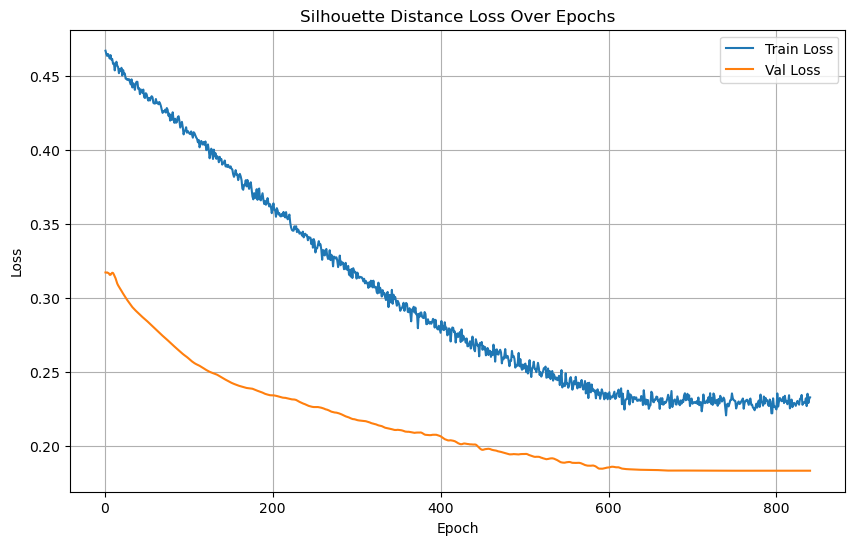

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/840], Loss: 0.0791


Test Batch [20/840], Loss: 0.0858
Test Batch [30/840], Loss: 0.1163
Test Batch [40/840], Loss: 0.5000
Test Batch [50/840], Loss: 0.0746
Test Batch [60/840], Loss: 0.0862
Test Batch [70/840], Loss: 0.0751


Test Batch [80/840], Loss: 0.5000


Test Batch [90/840], Loss: 0.1054
Test Batch [100/840], Loss: 0.1054
Test Batch [110/840], Loss: 0.5000
Test Batch [120/840], Loss: 0.0926
Test Batch [130/840], Loss: 0.0834
Test Batch [140/840], Loss: 0.0980
Test Batch [150/840], Loss: 0.0823


Test Batch [160/840], Loss: 0.1879
Test Batch [170/840], Loss: 0.0952
Test Batch [180/840], Loss: 0.0904
Test Batch [190/840], Loss: 0.0868
Test Batch [200/840], Loss: 0.0693


Test Batch [210/840], Loss: 0.0571
Test Batch [220/840], Loss: 0.0822
Test Batch [230/840], Loss: 0.0857
Test Batch [240/840], Loss: 0.0759


Test Batch [250/840], Loss: 0.1014
Test Batch [260/840], Loss: 0.2877
Test Batch [270/840], Loss: 0.3153
Test Batch [280/840], Loss: 0.2779


Test Batch [290/840], Loss: 0.1612
Test Batch [300/840], Loss: 0.2439
Test Batch [310/840], Loss: 0.1749
Test Batch [320/840], Loss: 0.0782


Test Batch [330/840], Loss: 0.1317
Test Batch [340/840], Loss: 0.1117
Test Batch [350/840], Loss: 0.5000
Test Batch [360/840], Loss: 0.5000
Test Batch [370/840], Loss: 0.5000
Test Batch [380/840], Loss: 0.5000
Test Batch [390/840], Loss: 0.5000
Test Batch [400/840], Loss: 0.5000
Test Batch [410/840], Loss: 0.5000
Test Batch [420/840], Loss: 0.5000
Test Batch [430/840], Loss: 0.0789
Test Batch [440/840], Loss: 0.0790


Test Batch [450/840], Loss: 0.0963
Test Batch [460/840], Loss: 0.0571
Test Batch [470/840], Loss: 0.1124
Test Batch [480/840], Loss: 0.1189
Test Batch [490/840], Loss: 0.5000
Test Batch [500/840], Loss: 0.0754
Test Batch [510/840], Loss: 0.0911


Test Batch [520/840], Loss: 0.1105
Test Batch [530/840], Loss: 0.1093
Test Batch [540/840], Loss: 0.1161
Test Batch [550/840], Loss: 0.1071
Test Batch [560/840], Loss: 0.1020


Test Batch [570/840], Loss: 0.1063
Test Batch [580/840], Loss: 0.0970
Test Batch [590/840], Loss: 0.0808
Test Batch [600/840], Loss: 0.5000
Test Batch [610/840], Loss: 0.0737
Test Batch [620/840], Loss: 0.0917


Test Batch [630/840], Loss: 0.0724
Test Batch [640/840], Loss: 0.0519
Test Batch [650/840], Loss: 0.2172
Test Batch [660/840], Loss: 0.3537
Test Batch [670/840], Loss: 0.0555


Test Batch [680/840], Loss: 0.0743
Test Batch [690/840], Loss: 0.3191
Test Batch [700/840], Loss: 0.1910
Test Batch [710/840], Loss: 0.0728
Test Batch [720/840], Loss: 0.0927


Test Batch [730/840], Loss: 0.0850
Test Batch [740/840], Loss: 0.1586
Test Batch [750/840], Loss: 0.1079
Test Batch [760/840], Loss: 0.5000
Test Batch [770/840], Loss: 0.1079


Test Batch [780/840], Loss: 0.5000
Test Batch [790/840], Loss: 0.2553
Test Batch [800/840], Loss: 0.1423
Test Batch [810/840], Loss: 0.5000
Test Batch [820/840], Loss: 0.1557
Test Batch [830/840], Loss: 0.5000


Test Batch [840/840], Loss: 0.1257

Test Loss: 0.1853


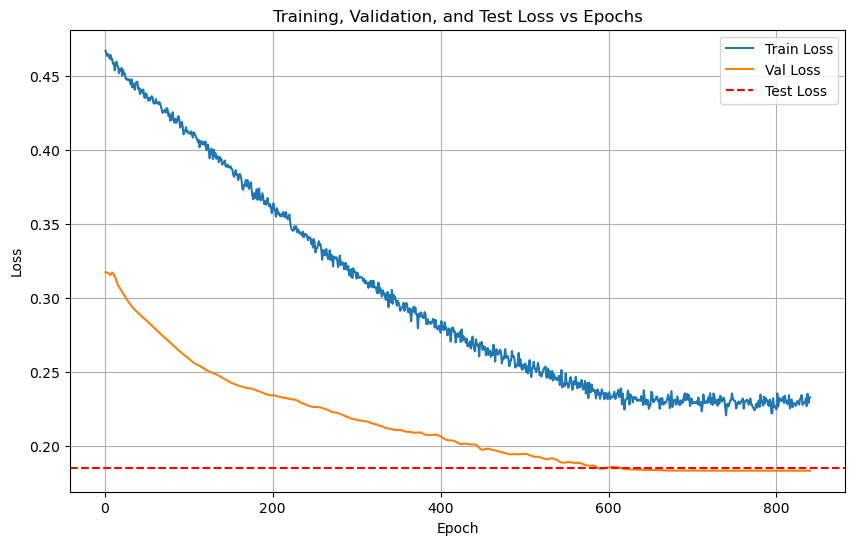

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/840 for test dataset.


  Processed batch 20/840 for test dataset.


  Processed batch 30/840 for test dataset.
  Processed batch 40/840 for test dataset.


  Processed batch 50/840 for test dataset.


  Processed batch 60/840 for test dataset.
  Processed batch 70/840 for test dataset.


  Processed batch 80/840 for test dataset.


  Processed batch 90/840 for test dataset.
  Processed batch 100/840 for test dataset.


  Processed batch 110/840 for test dataset.


  Processed batch 120/840 for test dataset.
  Processed batch 130/840 for test dataset.


  Processed batch 140/840 for test dataset.


  Processed batch 150/840 for test dataset.
  Processed batch 160/840 for test dataset.


  Processed batch 170/840 for test dataset.


  Processed batch 180/840 for test dataset.
  Processed batch 190/840 for test dataset.


  Processed batch 200/840 for test dataset.
  Processed batch 210/840 for test dataset.


  Processed batch 220/840 for test dataset.
  Processed batch 230/840 for test dataset.


  Processed batch 240/840 for test dataset.
  Processed batch 250/840 for test dataset.


  Processed batch 260/840 for test dataset.
  Processed batch 270/840 for test dataset.


  Processed batch 280/840 for test dataset.


  Processed batch 290/840 for test dataset.
  Processed batch 300/840 for test dataset.
  Processed batch 310/840 for test dataset.


  Processed batch 320/840 for test dataset.


  Processed batch 330/840 for test dataset.
  Processed batch 340/840 for test dataset.


  Processed batch 350/840 for test dataset.


  Processed batch 360/840 for test dataset.
  Processed batch 370/840 for test dataset.


  Processed batch 380/840 for test dataset.


  Processed batch 390/840 for test dataset.
  Processed batch 400/840 for test dataset.


  Processed batch 410/840 for test dataset.


  Processed batch 420/840 for test dataset.
  Processed batch 430/840 for test dataset.


  Processed batch 440/840 for test dataset.


  Processed batch 450/840 for test dataset.
  Processed batch 460/840 for test dataset.


  Processed batch 470/840 for test dataset.


  Processed batch 480/840 for test dataset.
  Processed batch 490/840 for test dataset.


  Processed batch 500/840 for test dataset.
  Processed batch 510/840 for test dataset.


  Processed batch 520/840 for test dataset.
  Processed batch 530/840 for test dataset.


  Processed batch 540/840 for test dataset.
  Processed batch 550/840 for test dataset.


  Processed batch 560/840 for test dataset.
  Processed batch 570/840 for test dataset.


  Processed batch 580/840 for test dataset.


  Processed batch 590/840 for test dataset.
  Processed batch 600/840 for test dataset.


  Processed batch 610/840 for test dataset.


  Processed batch 620/840 for test dataset.
  Processed batch 630/840 for test dataset.


  Processed batch 640/840 for test dataset.


  Processed batch 650/840 for test dataset.
  Processed batch 660/840 for test dataset.
  Processed batch 670/840 for test dataset.


  Processed batch 680/840 for test dataset.


  Processed batch 690/840 for test dataset.
  Processed batch 700/840 for test dataset.


  Processed batch 710/840 for test dataset.


  Processed batch 720/840 for test dataset.
  Processed batch 730/840 for test dataset.


  Processed batch 740/840 for test dataset.


  Processed batch 750/840 for test dataset.
  Processed batch 760/840 for test dataset.


  Processed batch 770/840 for test dataset.


  Processed batch 780/840 for test dataset.
  Processed batch 790/840 for test dataset.
  Processed batch 800/840 for test dataset.


  Processed batch 810/840 for test dataset.


  Processed batch 820/840 for test dataset.
  Processed batch 830/840 for test dataset.
  Processed batch 840/840 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53729, 128)
Test labels shape: (53729,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 92.50%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       0.83      1.00      0.91         5
           7       1.00      0.60      0.75         5
           8       1.00      0.80      0.89         5
           9       1.00      0.60      0.75         5
          10       0.71      1.00      0.83         5
          11       1.00      1.00      1.00         5
          12       0.83      1.00      0.91         5
          13       1.0

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53729, 128)
Test labels shape: (53729,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7421  |  Val Loss: 2.7090
Validation loss improved from inf to 2.7090.
[Epoch 2/1000] Train Loss: 2.6925  |  Val Loss: 2.6655
Validation loss improved from 2.7090 to 2.6655.
[Epoch 3/1000] Train Loss: 2.6452  |  Val Loss: 2.6250
Validation loss improved from 2.6655 to 2.6250.
[Epoch 4/1000] Train Loss: 2.6012  |  Val Loss: 2.5859
Validation loss improved from 2.6250 to 2.5859.
[Epoch 5/1000] Train Loss: 2.5603  |  Val Loss: 2.5491
Validation loss improved from 2.5859 to 2.5491.
[Epoch 6/1000] Train Loss: 2.5208  |  Val Loss: 2.5150
Validation loss improved from 2.5491 to 2.5150.
[Epoch 7/1000] Train Loss: 2.4840  |  Val Loss: 2.4824
Validation loss improved from 2.5150 to 2.4824.
[Epoch 8/1000] Train Loss: 2.4477  |  Val Loss: 2.4507
Validation loss improved from 2.4824 to 2.4507.
[Epoch 9/1000] Train Loss: 2.4127  |  Val Loss: 2.4201
Validation loss improved from 2.4507 to 2.4201.
[Epoch 10/1000] Train Loss: 2.3791  |  Val Loss: 2.3903
Validation loss impr

[Epoch 17/1000] Train Loss: 2.1617  |  Val Loss: 2.1914
Validation loss improved from 2.2190 to 2.1914.
[Epoch 18/1000] Train Loss: 2.1317  |  Val Loss: 2.1629
Validation loss improved from 2.1914 to 2.1629.
[Epoch 19/1000] Train Loss: 2.1009  |  Val Loss: 2.1342
Validation loss improved from 2.1629 to 2.1342.
[Epoch 20/1000] Train Loss: 2.0700  |  Val Loss: 2.1045
Validation loss improved from 2.1342 to 2.1045.
[Epoch 21/1000] Train Loss: 2.0380  |  Val Loss: 2.0733
Validation loss improved from 2.1045 to 2.0733.
[Epoch 22/1000] Train Loss: 2.0056  |  Val Loss: 2.0420
Validation loss improved from 2.0733 to 2.0420.
[Epoch 23/1000] Train Loss: 1.9729  |  Val Loss: 2.0108
Validation loss improved from 2.0420 to 2.0108.
[Epoch 24/1000] Train Loss: 1.9401  |  Val Loss: 1.9801
Validation loss improved from 2.0108 to 1.9801.
[Epoch 25/1000] Train Loss: 1.9095  |  Val Loss: 1.9495
Validation loss improved from 1.9801 to 1.9495.
[Epoch 26/1000] Train Loss: 1.8787  |  Val Loss: 1.9193
Validati

[Epoch 37/1000] Train Loss: 1.5570  |  Val Loss: 1.6058
Validation loss improved from 1.6335 to 1.6058.
[Epoch 38/1000] Train Loss: 1.5290  |  Val Loss: 1.5785
Validation loss improved from 1.6058 to 1.5785.
[Epoch 39/1000] Train Loss: 1.5016  |  Val Loss: 1.5514
Validation loss improved from 1.5785 to 1.5514.
[Epoch 40/1000] Train Loss: 1.4733  |  Val Loss: 1.5249
Validation loss improved from 1.5514 to 1.5249.
[Epoch 41/1000] Train Loss: 1.4465  |  Val Loss: 1.4990
Validation loss improved from 1.5249 to 1.4990.
[Epoch 42/1000] Train Loss: 1.4214  |  Val Loss: 1.4729
Validation loss improved from 1.4990 to 1.4729.
[Epoch 43/1000] Train Loss: 1.3947  |  Val Loss: 1.4467
Validation loss improved from 1.4729 to 1.4467.
[Epoch 44/1000] Train Loss: 1.3682  |  Val Loss: 1.4206
Validation loss improved from 1.4467 to 1.4206.
[Epoch 45/1000] Train Loss: 1.3424  |  Val Loss: 1.3948
Validation loss improved from 1.4206 to 1.3948.
[Epoch 46/1000] Train Loss: 1.3165  |  Val Loss: 1.3697
Validati

[Epoch 56/1000] Train Loss: 1.0857  |  Val Loss: 1.1446
Validation loss improved from 1.1656 to 1.1446.
[Epoch 57/1000] Train Loss: 1.0650  |  Val Loss: 1.1241
Validation loss improved from 1.1446 to 1.1241.
[Epoch 58/1000] Train Loss: 1.0442  |  Val Loss: 1.1044
Validation loss improved from 1.1241 to 1.1044.
[Epoch 59/1000] Train Loss: 1.0245  |  Val Loss: 1.0849
Validation loss improved from 1.1044 to 1.0849.
[Epoch 60/1000] Train Loss: 1.0053  |  Val Loss: 1.0662
Validation loss improved from 1.0849 to 1.0662.
[Epoch 61/1000] Train Loss: 0.9858  |  Val Loss: 1.0481
Validation loss improved from 1.0662 to 1.0481.
[Epoch 62/1000] Train Loss: 0.9678  |  Val Loss: 1.0303
Validation loss improved from 1.0481 to 1.0303.
[Epoch 63/1000] Train Loss: 0.9504  |  Val Loss: 1.0130
Validation loss improved from 1.0303 to 1.0130.
[Epoch 64/1000] Train Loss: 0.9327  |  Val Loss: 0.9958
Validation loss improved from 1.0130 to 0.9958.
[Epoch 65/1000] Train Loss: 0.9159  |  Val Loss: 0.9794
Validati

[Epoch 73/1000] Train Loss: 0.7906  |  Val Loss: 0.8558
Validation loss improved from 0.8704 to 0.8558.
[Epoch 74/1000] Train Loss: 0.7761  |  Val Loss: 0.8417
Validation loss improved from 0.8558 to 0.8417.
[Epoch 75/1000] Train Loss: 0.7618  |  Val Loss: 0.8280
Validation loss improved from 0.8417 to 0.8280.
[Epoch 76/1000] Train Loss: 0.7477  |  Val Loss: 0.8143
Validation loss improved from 0.8280 to 0.8143.
[Epoch 77/1000] Train Loss: 0.7340  |  Val Loss: 0.8006
Validation loss improved from 0.8143 to 0.8006.
[Epoch 78/1000] Train Loss: 0.7200  |  Val Loss: 0.7875
Validation loss improved from 0.8006 to 0.7875.
[Epoch 79/1000] Train Loss: 0.7066  |  Val Loss: 0.7745
Validation loss improved from 0.7875 to 0.7745.
[Epoch 80/1000] Train Loss: 0.6932  |  Val Loss: 0.7617
Validation loss improved from 0.7745 to 0.7617.
[Epoch 81/1000] Train Loss: 0.6805  |  Val Loss: 0.7487
Validation loss improved from 0.7617 to 0.7487.
[Epoch 82/1000] Train Loss: 0.6669  |  Val Loss: 0.7364
Validati

[Epoch 93/1000] Train Loss: 0.5349  |  Val Loss: 0.6106
Validation loss improved from 0.6212 to 0.6106.
[Epoch 94/1000] Train Loss: 0.5240  |  Val Loss: 0.6004
Validation loss improved from 0.6106 to 0.6004.
[Epoch 95/1000] Train Loss: 0.5133  |  Val Loss: 0.5902
Validation loss improved from 0.6004 to 0.5902.
[Epoch 96/1000] Train Loss: 0.5027  |  Val Loss: 0.5803
Validation loss improved from 0.5902 to 0.5803.
[Epoch 97/1000] Train Loss: 0.4926  |  Val Loss: 0.5709
Validation loss improved from 0.5803 to 0.5709.
[Epoch 98/1000] Train Loss: 0.4823  |  Val Loss: 0.5614
Validation loss improved from 0.5709 to 0.5614.
[Epoch 99/1000] Train Loss: 0.4730  |  Val Loss: 0.5523
Validation loss improved from 0.5614 to 0.5523.
[Epoch 100/1000] Train Loss: 0.4627  |  Val Loss: 0.5434
Validation loss improved from 0.5523 to 0.5434.
[Epoch 101/1000] Train Loss: 0.4538  |  Val Loss: 0.5345
Validation loss improved from 0.5434 to 0.5345.
[Epoch 102/1000] Train Loss: 0.4439  |  Val Loss: 0.5259
Valid

[Epoch 112/1000] Train Loss: 0.3649  |  Val Loss: 0.4546
Validation loss improved from 0.4605 to 0.4546.
[Epoch 113/1000] Train Loss: 0.3582  |  Val Loss: 0.4489
Validation loss improved from 0.4546 to 0.4489.
[Epoch 114/1000] Train Loss: 0.3518  |  Val Loss: 0.4433
Validation loss improved from 0.4489 to 0.4433.
[Epoch 115/1000] Train Loss: 0.3452  |  Val Loss: 0.4377
Validation loss improved from 0.4433 to 0.4377.
[Epoch 116/1000] Train Loss: 0.3392  |  Val Loss: 0.4328
Validation loss improved from 0.4377 to 0.4328.
[Epoch 117/1000] Train Loss: 0.3331  |  Val Loss: 0.4274
Validation loss improved from 0.4328 to 0.4274.
[Epoch 118/1000] Train Loss: 0.3273  |  Val Loss: 0.4224
Validation loss improved from 0.4274 to 0.4224.
[Epoch 119/1000] Train Loss: 0.3220  |  Val Loss: 0.4176
Validation loss improved from 0.4224 to 0.4176.
[Epoch 120/1000] Train Loss: 0.3162  |  Val Loss: 0.4130
Validation loss improved from 0.4176 to 0.4130.
[Epoch 121/1000] Train Loss: 0.3109  |  Val Loss: 0.408

[Epoch 131/1000] Train Loss: 0.2660  |  Val Loss: 0.3708
Validation loss improved from 0.3738 to 0.3708.
[Epoch 132/1000] Train Loss: 0.2618  |  Val Loss: 0.3675
Validation loss improved from 0.3708 to 0.3675.
[Epoch 133/1000] Train Loss: 0.2581  |  Val Loss: 0.3644
Validation loss improved from 0.3675 to 0.3644.
[Epoch 134/1000] Train Loss: 0.2546  |  Val Loss: 0.3616
Validation loss improved from 0.3644 to 0.3616.
[Epoch 135/1000] Train Loss: 0.2510  |  Val Loss: 0.3586
Validation loss improved from 0.3616 to 0.3586.
[Epoch 136/1000] Train Loss: 0.2484  |  Val Loss: 0.3558
Validation loss improved from 0.3586 to 0.3558.
[Epoch 137/1000] Train Loss: 0.2444  |  Val Loss: 0.3531
Validation loss improved from 0.3558 to 0.3531.
[Epoch 138/1000] Train Loss: 0.2413  |  Val Loss: 0.3504
Validation loss improved from 0.3531 to 0.3504.
[Epoch 139/1000] Train Loss: 0.2382  |  Val Loss: 0.3478
Validation loss improved from 0.3504 to 0.3478.
[Epoch 140/1000] Train Loss: 0.2350  |  Val Loss: 0.345

[Epoch 148/1000] Train Loss: 0.2132  |  Val Loss: 0.3286
Validation loss improved from 0.3307 to 0.3286.
[Epoch 149/1000] Train Loss: 0.2109  |  Val Loss: 0.3270
Validation loss improved from 0.3286 to 0.3270.
[Epoch 150/1000] Train Loss: 0.2084  |  Val Loss: 0.3255
Validation loss improved from 0.3270 to 0.3255.
[Epoch 151/1000] Train Loss: 0.2061  |  Val Loss: 0.3236
Validation loss improved from 0.3255 to 0.3236.
[Epoch 152/1000] Train Loss: 0.2039  |  Val Loss: 0.3221
Validation loss improved from 0.3236 to 0.3221.
[Epoch 153/1000] Train Loss: 0.2016  |  Val Loss: 0.3206
Validation loss improved from 0.3221 to 0.3206.
[Epoch 154/1000] Train Loss: 0.1997  |  Val Loss: 0.3190
Validation loss improved from 0.3206 to 0.3190.
[Epoch 155/1000] Train Loss: 0.1975  |  Val Loss: 0.3172
Validation loss improved from 0.3190 to 0.3172.
[Epoch 156/1000] Train Loss: 0.1955  |  Val Loss: 0.3160
Validation loss improved from 0.3172 to 0.3160.
[Epoch 157/1000] Train Loss: 0.1937  |  Val Loss: 0.314

[Epoch 168/1000] Train Loss: 0.1745  |  Val Loss: 0.3008
Validation loss improved from 0.3018 to 0.3008.
[Epoch 169/1000] Train Loss: 0.1727  |  Val Loss: 0.2997
Validation loss improved from 0.3008 to 0.2997.
[Epoch 170/1000] Train Loss: 0.1713  |  Val Loss: 0.2987
Validation loss improved from 0.2997 to 0.2987.
[Epoch 171/1000] Train Loss: 0.1697  |  Val Loss: 0.2974
Validation loss improved from 0.2987 to 0.2974.
[Epoch 172/1000] Train Loss: 0.1691  |  Val Loss: 0.2963
Validation loss improved from 0.2974 to 0.2963.
[Epoch 173/1000] Train Loss: 0.1670  |  Val Loss: 0.2953
Validation loss improved from 0.2963 to 0.2953.
[Epoch 174/1000] Train Loss: 0.1657  |  Val Loss: 0.2947
Validation loss improved from 0.2953 to 0.2947.
[Epoch 175/1000] Train Loss: 0.1643  |  Val Loss: 0.2939
Validation loss improved from 0.2947 to 0.2939.
[Epoch 176/1000] Train Loss: 0.1629  |  Val Loss: 0.2927
Validation loss improved from 0.2939 to 0.2927.
[Epoch 177/1000] Train Loss: 0.1618  |  Val Loss: 0.292

[Epoch 186/1000] Train Loss: 0.1514  |  Val Loss: 0.2853
Validation loss improved from 0.2863 to 0.2853.
[Epoch 187/1000] Train Loss: 0.1504  |  Val Loss: 0.2842
Validation loss improved from 0.2853 to 0.2842.
[Epoch 188/1000] Train Loss: 0.1492  |  Val Loss: 0.2832
Validation loss improved from 0.2842 to 0.2832.
[Epoch 189/1000] Train Loss: 0.1482  |  Val Loss: 0.2828
Validation loss improved from 0.2832 to 0.2828.
[Epoch 190/1000] Train Loss: 0.1471  |  Val Loss: 0.2826
Validation loss improved from 0.2828 to 0.2826.
[Epoch 191/1000] Train Loss: 0.1463  |  Val Loss: 0.2822
Validation loss improved from 0.2826 to 0.2822.
[Epoch 192/1000] Train Loss: 0.1454  |  Val Loss: 0.2818
Validation loss improved from 0.2822 to 0.2818.
[Epoch 193/1000] Train Loss: 0.1441  |  Val Loss: 0.2810
Validation loss improved from 0.2818 to 0.2810.
[Epoch 194/1000] Train Loss: 0.1436  |  Val Loss: 0.2801
Validation loss improved from 0.2810 to 0.2801.
[Epoch 195/1000] Train Loss: 0.1424  |  Val Loss: 0.279

[Epoch 204/1000] Train Loss: 0.1346  |  Val Loss: 0.2756
Validation loss improved from 0.2762 to 0.2756.
[Epoch 205/1000] Train Loss: 0.1339  |  Val Loss: 0.2749
Validation loss improved from 0.2756 to 0.2749.
[Epoch 206/1000] Train Loss: 0.1331  |  Val Loss: 0.2745
Validation loss improved from 0.2749 to 0.2745.
[Epoch 207/1000] Train Loss: 0.1322  |  Val Loss: 0.2739
Validation loss improved from 0.2745 to 0.2739.
[Epoch 208/1000] Train Loss: 0.1318  |  Val Loss: 0.2736
Validation loss improved from 0.2739 to 0.2736.
[Epoch 209/1000] Train Loss: 0.1309  |  Val Loss: 0.2733
Validation loss improved from 0.2736 to 0.2733.
[Epoch 210/1000] Train Loss: 0.1302  |  Val Loss: 0.2733
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 211/1000] Train Loss: 0.1296  |  Val Loss: 0.2732
Validation loss improved from 0.2733 to 0.2732.
[Epoch 212/1000] Train Loss: 0.1287  |  Val Loss: 0.2724
Validation loss improved from 0.2732 to 0.2724.
[Epoch 213/1000] Train Loss: 0.1282  |  Val Loss:

[Epoch 223/1000] Train Loss: 0.1217  |  Val Loss: 0.2691
Validation loss improved from 0.2692 to 0.2691.
[Epoch 224/1000] Train Loss: 0.1208  |  Val Loss: 0.2691
Validation loss improved from 0.2691 to 0.2691.
[Epoch 225/1000] Train Loss: 0.1204  |  Val Loss: 0.2692
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 226/1000] Train Loss: 0.1199  |  Val Loss: 0.2692
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 227/1000] Train Loss: 0.1193  |  Val Loss: 0.2689
Validation loss improved from 0.2691 to 0.2689.
[Epoch 228/1000] Train Loss: 0.1185  |  Val Loss: 0.2680
Validation loss improved from 0.2689 to 0.2680.
[Epoch 229/1000] Train Loss: 0.1180  |  Val Loss: 0.2677
Validation loss improved from 0.2680 to 0.2677.
[Epoch 230/1000] Train Loss: 0.1176  |  Val Loss: 0.2680
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 231/1000] Train Loss: 0.1168  |  Val Loss: 0.2678
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 232/1000] Train Loss: 0.

[Epoch 239/1000] Train Loss: 0.1125  |  Val Loss: 0.2659
Validation loss improved from 0.2661 to 0.2659.
[Epoch 240/1000] Train Loss: 0.1120  |  Val Loss: 0.2655
Validation loss improved from 0.2659 to 0.2655.
[Epoch 241/1000] Train Loss: 0.1115  |  Val Loss: 0.2654
Validation loss improved from 0.2655 to 0.2654.
[Epoch 242/1000] Train Loss: 0.1114  |  Val Loss: 0.2658
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 243/1000] Train Loss: 0.1106  |  Val Loss: 0.2659
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 244/1000] Train Loss: 0.1100  |  Val Loss: 0.2657
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 245/1000] Train Loss: 0.1095  |  Val Loss: 0.2651
Validation loss improved from 0.2654 to 0.2651.
[Epoch 246/1000] Train Loss: 0.1091  |  Val Loss: 0.2645
Validation loss improved from 0.2651 to 0.2645.
[Epoch 247/1000] Train Loss: 0.1087  |  Val Loss: 0.2642
Validation loss improved from 0.2645 to 0.2642.
[Epoch 248/1000] Train Loss: 0.1083  

[Epoch 258/1000] Train Loss: 0.1037  |  Val Loss: 0.2636
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 259/1000] Train Loss: 0.1034  |  Val Loss: 0.2632
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 260/1000] Train Loss: 0.1031  |  Val Loss: 0.2633
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 261/1000] Train Loss: 0.1027  |  Val Loss: 0.2629
Validation loss improved from 0.2632 to 0.2629.
[Epoch 262/1000] Train Loss: 0.1024  |  Val Loss: 0.2628
Validation loss improved from 0.2629 to 0.2628.
[Epoch 263/1000] Train Loss: 0.1020  |  Val Loss: 0.2624
Validation loss improved from 0.2628 to 0.2624.
[Epoch 264/1000] Train Loss: 0.1015  |  Val Loss: 0.2624
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 265/1000] Train Loss: 0.1013  |  Val Loss: 0.2629
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 266/1000] Train Loss: 0.1008  |  Val Loss: 0.2624
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 267/1000] Tr

[Epoch 276/1000] Train Loss: 0.0972  |  Val Loss: 0.2609
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 277/1000] Train Loss: 0.0966  |  Val Loss: 0.2609
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 278/1000] Train Loss: 0.0963  |  Val Loss: 0.2609
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 279/1000] Train Loss: 0.0962  |  Val Loss: 0.2609
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 280/1000] Train Loss: 0.0956  |  Val Loss: 0.2607
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 281/1000] Train Loss: 0.0953  |  Val Loss: 0.2604
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 282/1000] Train Loss: 0.0950  |  Val Loss: 0.2599
Validation loss improved from 0.2604 to 0.2599.
[Epoch 283/1000] Train Loss: 0.0946  |  Val Loss: 0.2602
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 284/1000] Train Loss: 0.0942  |  Val Loss: 0.2601
!! Validation loss did NOT improve !! Patience: 2/100
[Epo

[Epoch 295/1000] Train Loss: 0.0908  |  Val Loss: 0.2601
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 296/1000] Train Loss: 0.0906  |  Val Loss: 0.2595
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 297/1000] Train Loss: 0.0903  |  Val Loss: 0.2593
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 298/1000] Train Loss: 0.0899  |  Val Loss: 0.2597
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 299/1000] Train Loss: 0.0898  |  Val Loss: 0.2602
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 300/1000] Train Loss: 0.0892  |  Val Loss: 0.2599
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 301/1000] Train Loss: 0.0889  |  Val Loss: 0.2601
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 302/1000] Train Loss: 0.0886  |  Val Loss: 0.2602
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 303/1000] Train Loss: 0.0882  |  Val Loss: 0.2601
!! Validation loss did NOT improve !! Patience: 1

[Epoch 315/1000] Train Loss: 0.0850  |  Val Loss: 0.2606
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 316/1000] Train Loss: 0.0846  |  Val Loss: 0.2607
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 317/1000] Train Loss: 0.0843  |  Val Loss: 0.2610
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 318/1000] Train Loss: 0.0841  |  Val Loss: 0.2613
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 319/1000] Train Loss: 0.0842  |  Val Loss: 0.2617
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 320/1000] Train Loss: 0.0836  |  Val Loss: 0.2612
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 321/1000] Train Loss: 0.0833  |  Val Loss: 0.2618
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 322/1000] Train Loss: 0.0832  |  Val Loss: 0.2617
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 323/1000] Train Loss: 0.0828  |  Val Loss: 0.2617
!! Validation loss did NOT improve !! Patience:

[Epoch 334/1000] Train Loss: 0.0800  |  Val Loss: 0.2619
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 335/1000] Train Loss: 0.0800  |  Val Loss: 0.2624
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 336/1000] Train Loss: 0.0796  |  Val Loss: 0.2626
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 337/1000] Train Loss: 0.0793  |  Val Loss: 0.2625
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 338/1000] Train Loss: 0.0790  |  Val Loss: 0.2628
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 339/1000] Train Loss: 0.0789  |  Val Loss: 0.2630
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 340/1000] Train Loss: 0.0787  |  Val Loss: 0.2633
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 341/1000] Train Loss: 0.0784  |  Val Loss: 0.2631
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 342/1000] Train Loss: 0.0780  |  Val Loss: 0.2633
!! Validation loss did NOT improve !! Patience:

[Epoch 355/1000] Train Loss: 0.0755  |  Val Loss: 0.2655
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 356/1000] Train Loss: 0.0754  |  Val Loss: 0.2640
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 357/1000] Train Loss: 0.0750  |  Val Loss: 0.2644
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 358/1000] Train Loss: 0.0746  |  Val Loss: 0.2651
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 359/1000] Train Loss: 0.0748  |  Val Loss: 0.2648
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 360/1000] Train Loss: 0.0742  |  Val Loss: 0.2654
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 361/1000] Train Loss: 0.0743  |  Val Loss: 0.2660
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 362/1000] Train Loss: 0.0739  |  Val Loss: 0.2663
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 363/1000] Train Loss: 0.0741  |  Val Loss: 0.2660
!! Validation loss did NOT improve !! Patience:

[Epoch 375/1000] Train Loss: 0.0713  |  Val Loss: 0.2677
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 376/1000] Train Loss: 0.0714  |  Val Loss: 0.2673
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 377/1000] Train Loss: 0.0708  |  Val Loss: 0.2676
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 378/1000] Train Loss: 0.0706  |  Val Loss: 0.2681
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 379/1000] Train Loss: 0.0706  |  Val Loss: 0.2680
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 380/1000] Train Loss: 0.0702  |  Val Loss: 0.2681
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 381/1000] Train Loss: 0.0701  |  Val Loss: 0.2694
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 382/1000] Train Loss: 0.0700  |  Val Loss: 0.2697
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 383/1000] Train Loss: 0.0697  |  Val Loss: 0.2693
!! Validation loss did NOT improve !! Patience:

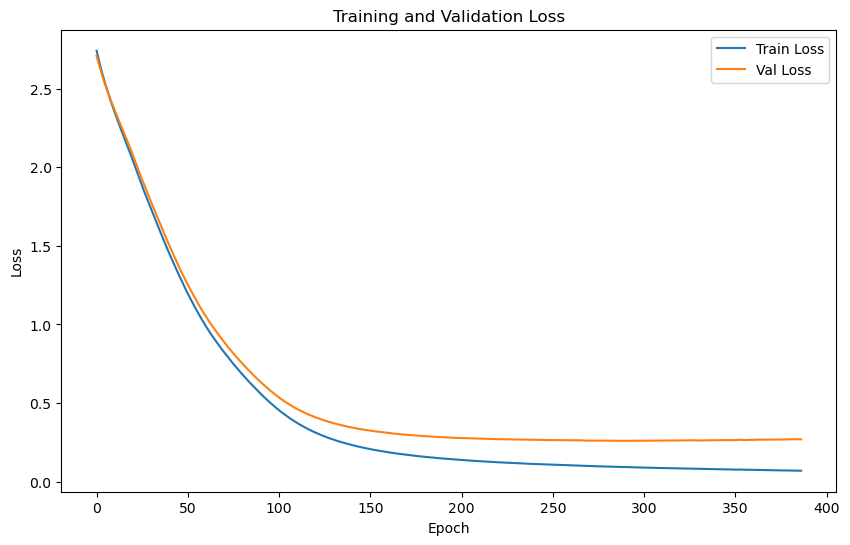

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.5676 | Test Accuracy: 83.47%


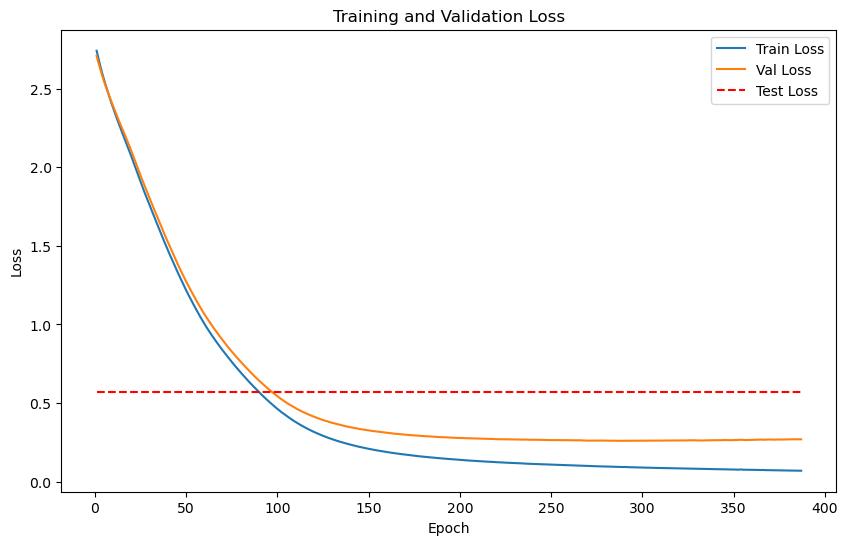

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


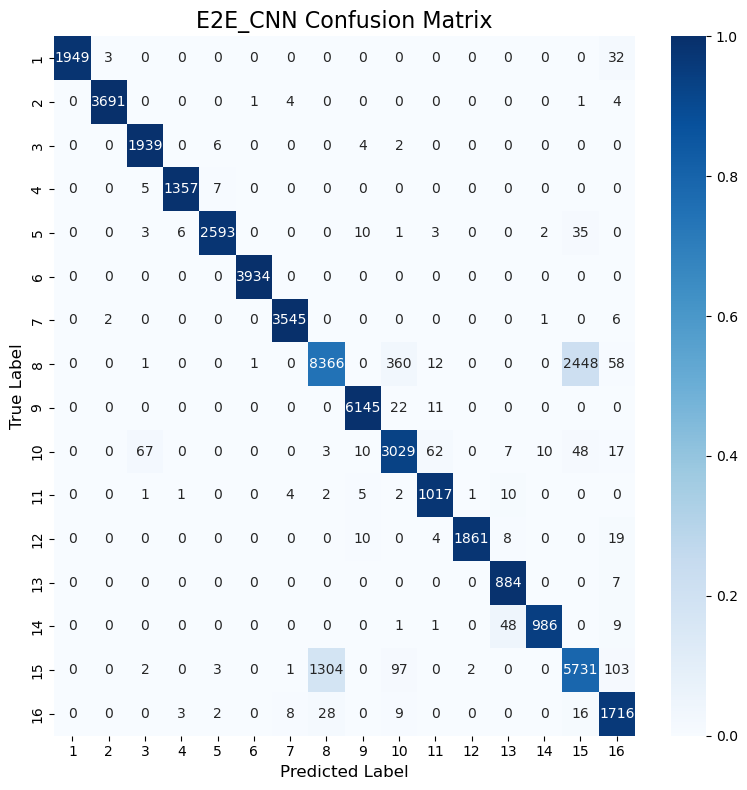

Classification Accuracy: 90.72%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


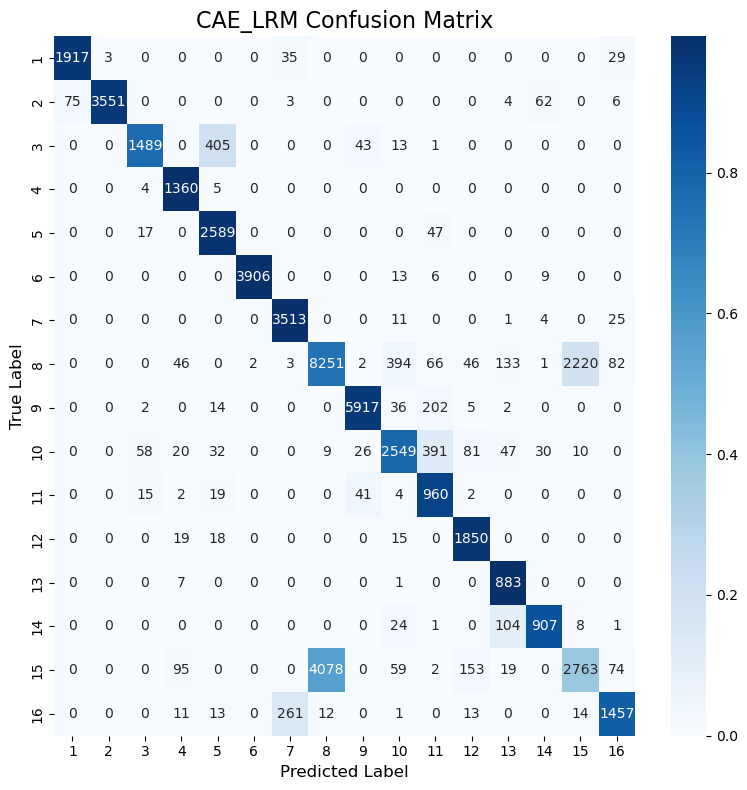

Classification Accuracy: 81.64%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


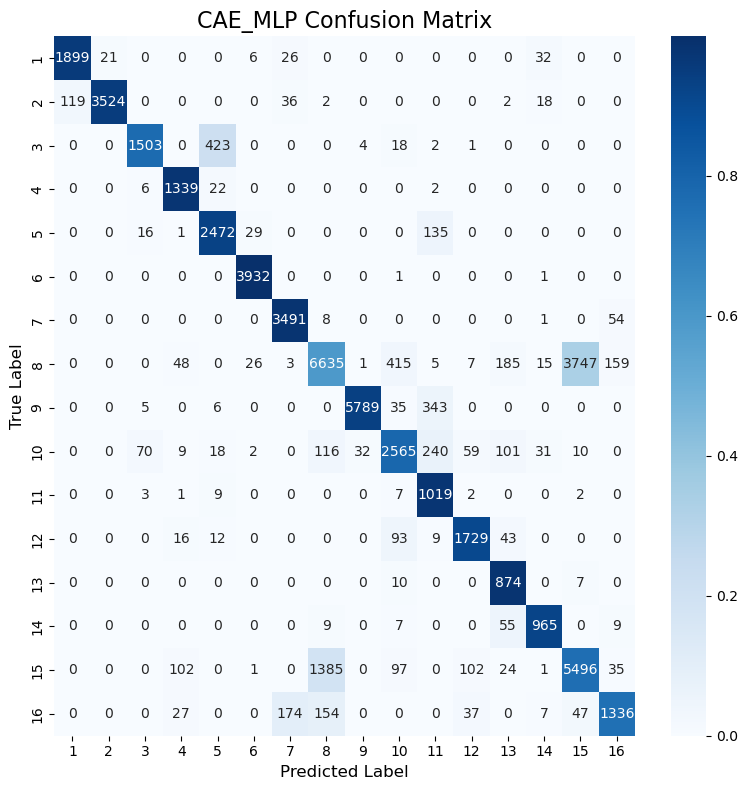

Classification Accuracy: 82.95%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


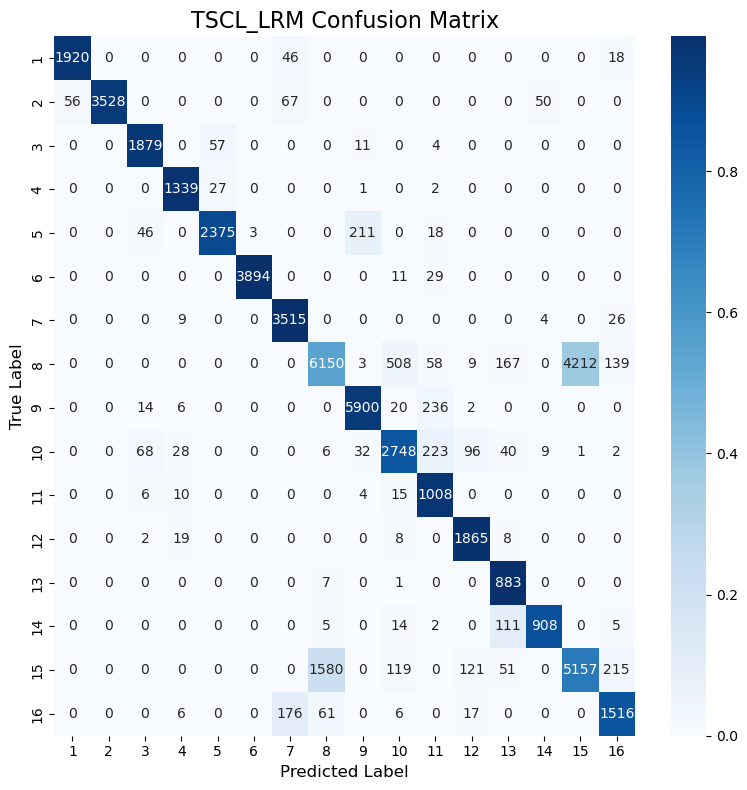

Classification Accuracy: 82.98%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


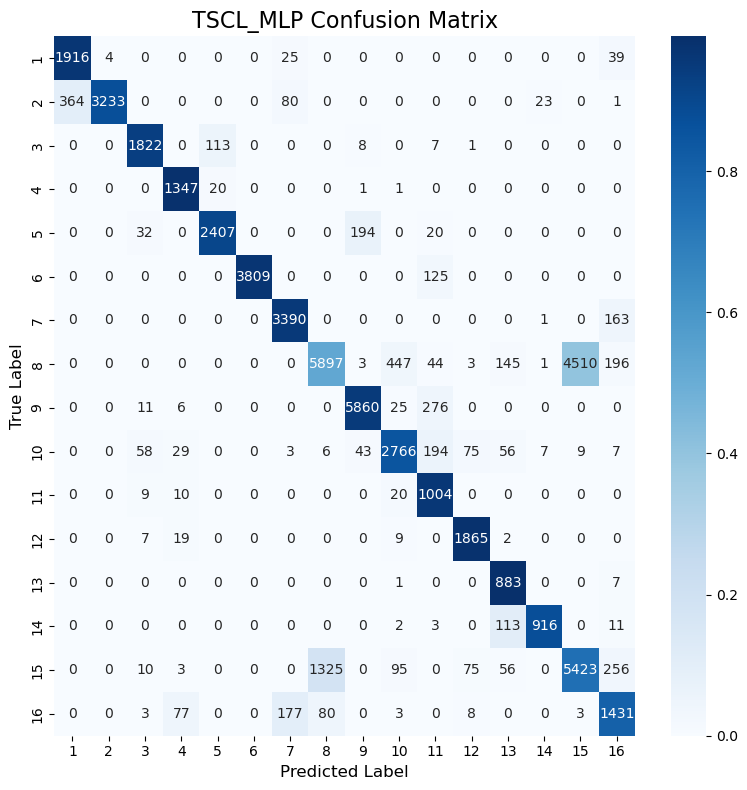

Classification Accuracy: 81.83%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


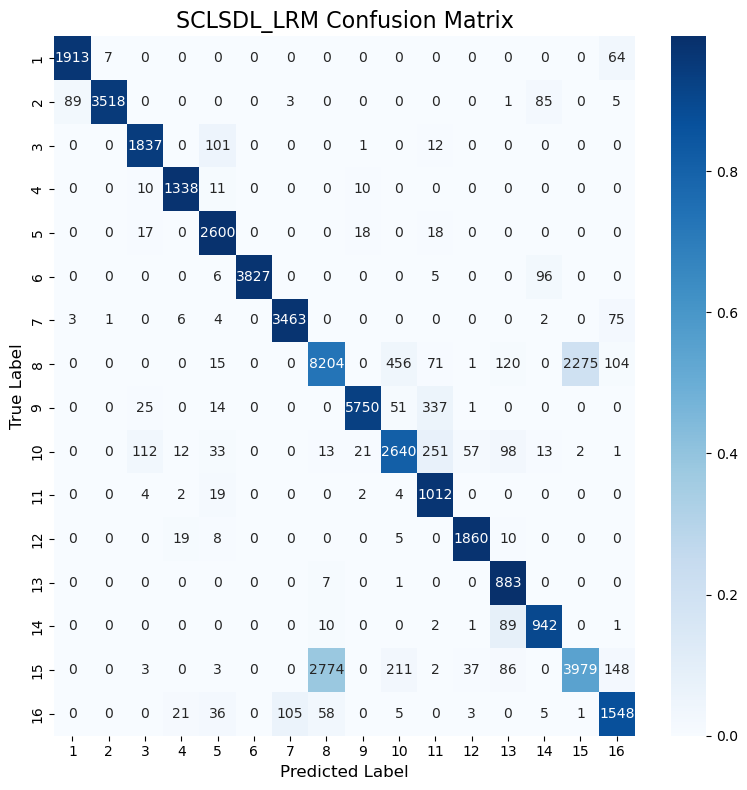

Classification Accuracy: 84.34%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


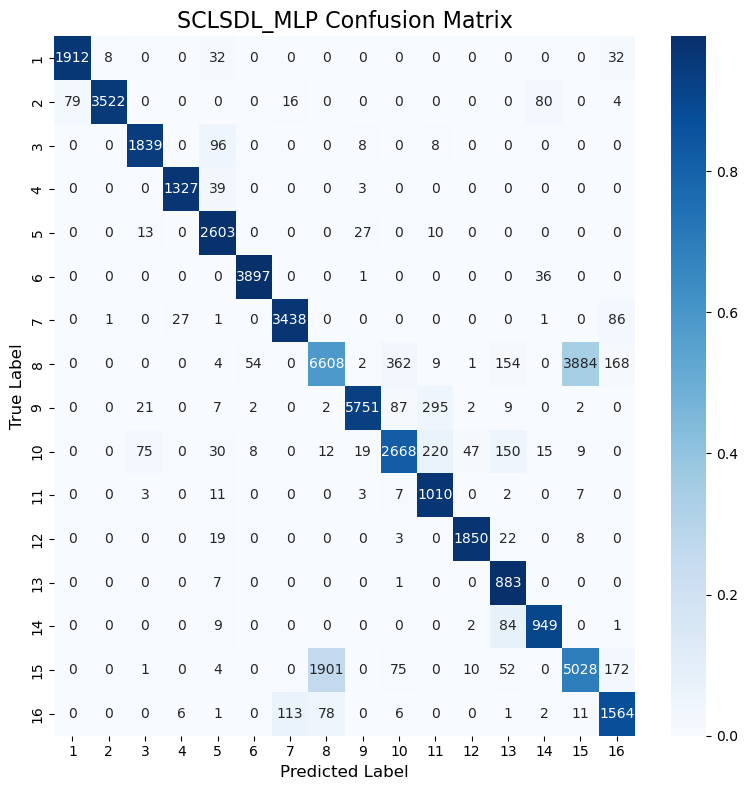

Classification Accuracy: 83.47%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          90.72
1    LRM (CAE)          81.64
2    MLP (CAE)          82.95
3     TSCL LRM          82.98
4     TSCL MLP          81.83
5  SCL_SDL LRM          84.34
6  SCL_SDL MLP          83.47

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          90.72
5  SCL_SDL LRM          84.34
6  SCL_SDL MLP          83.47
3     TSCL LRM          82.98
2    MLP (CAE)          82.95
4     TSCL MLP          81.83
1    LRM (CAE)          81.64
